### Load Data (MNIST)

Here, we use a suitable object that will hold the data and that will be easier to be referenced from within the MLP.


In [62]:
import numpy as np

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

class Dataset(object):
    
    def __init__(self,x,y,test_size):
        xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=test_size, random_state=0)
        self.xtrain = xtrain.T
        self.xtest = xtest.T
        self.ytrain = ytrain.T
        self.ytest = ytest.T
                
        self.nx = self.xtrain.shape[0]
        self.mtrain = self.xtrain.shape[1]
        self.mtest = self.xtest.shape[1]

        self.indices = np.arange(self.mtrain)
        np.random.shuffle(self.indices)
        self.counter = 0
        print("Training Data: x=%s | y=%s, Test Data: x=%s | y=%s"%(str(self.xtrain.shape), str(self.ytrain.shape), 
                                                                    str(self.xtest.shape), str(self.ytest.shape)))

                    
    def next_batch(self, batchsize):
        if (self.counter+1)*batchsize >= self.mtrain:
            self.counter = 0
            np.random.shuffle(self.indices)
        it = self.indices[self.counter*batchsize:(self.counter+1)*batchsize]
        self.counter += 1
        xbatch = self.xtrain[:,it].reshape(self.nx, batchsize)
        ybatch = self.ytrain[:,it].reshape(1,batchsize)
        return xbatch, ybatch

    def training_set(self):
        return self.xtrain, self.ytrain

    def test_set(self):
        return self.xtest, self.ytest


In [63]:
mnist = fetch_mldata('MNIST original')
x, y = mnist['data'], np.array(mnist['target'], dtype='int')
y = y.reshape(y.size,1)

ds = Dataset(x,y,test_size=10000)

Training Data: x=(784, 60000) | y=(1, 60000), Test Data: x=(784, 10000) | y=(1, 10000)


### Model Components

In this section, we define the different compartments of the MLP model, including 

* Activation function including suitable methods to compute values and derivatives: here, the simoid activation function will be used. 
* For implementing softmax, a softmax activation function is provided. It just provides the possibility to compute the softmax values, but not the derivatives. The derivatives will be needed for the backpropagation but will be integrated in the code for the softmax layer.  
* Initializer for initializing the weights and bias parameters: here, normally distributed initial values will be provided.
* Cost function used for training - including suitable methods for computing the values and derivatives: here, the cross-entropy cost will be used.
* Layer: The first core component to be implemented/completed by the students.
* MLP: The second core component to be implemented/completed by the students. Allows to configure an arbitrary number of layers into a sequential structure.  


In [64]:
class activation_function(object):
    """
    Empty parent implementation of all activation functions. All child implementations should implement 
    the two methods defined below.
    """
    def compute_value(self, z):
        """
        Computes the value of the activation function element wise for input array z of arbitrary shape. 
        """
        raise NotImplementedError("To be implemented in the child implementation.")
        
    def compute_derivative(self, z):
        """
        Computes the derivative of the activation function element wise for input array z of arbitrary shape. 
        """
        raise NotImplementedError("To be implemented in the child implementation.")


In [65]:
class sigmoid_activation_function(activation_function):
        
    def compute_value(self, z):
        return 1.0 / (1.0 + np.exp(-z))
        
    def compute_derivative(self, z):
        s = self.compute_value(z)
        return s*(1-s)

In [66]:
class softmax_activation_function(activation_function):
    
    def compute_value(self, z):
        expz = np.exp(z)
        norm = np.sum(expz, axis=0)        
        return expz / norm
        
    def compute_derivative(self, z):
        raise NotImplementedError("Computation of the gradient implemented in the Softmax Layer.")

In [67]:
class Norm_Initializer(object):
    
    def initialize_weights(self, size, mu=0.0, sigma=1.0):
        return np.random.normal(size=size, loc=mu, scale=sigma)
    
    def initialize_bias(self, size, mu=0.0, sigma=1.0):
        return np.random.normal(size=size, loc=mu, scale=sigma)

In [68]:
class Cost(object):
    
    def compute_value(self, y, prob):
        """
        Computes the value of the cost function for given labels y and predicted probs. 
        """
        raise NotImplementedError("")
        
    def compute_derivative(self, y, prob):
        """
        Computes the derivative of the cost function for given labels y and predicted probs. 
        """
        raise NotImplementedError("")         

In [69]:
class CrossEntropy(Cost):

    def compute_value(self, y, prob):
        """
        Computes the value of the cost function for given labels y and predicted probs.
        
        Arguments:
        y -- labels, a numpy array of shape (1,m)
        prob -- predicted probabilities for the different classes, a numpy array of shape (ny,m)
        
        Returns:
        cost -- a scalar
        """
        n,m = prob.shape
        assert(np.max(y)<=n)
        py = prob[y,np.arange(m)]
        J = -np.sum(np.log(py))/m    
        return J
    
        
    def compute_derivative(self, y, prob):
        """
        Computes the derivative of the cost function for given labels y and predicted probs. 
        Derivative is computed w.r.t. predicted probs.

        y -- labels (shape (1,m))
        prob -- predicted probabilities for the different classes (shape (ny,m))
        
        Returns:
        Gradient of cost with respect to the predicted probabilities (shape (ny,m))
        """
        n,m = prob.shape
        result = np.zeros((n,m),dtype=float)
        result[y[0,:],np.arange(m)] = 1.0
        result /= prob
        return -result

In [94]:
class Layer(object):
    
    def __init__(self, layerid, nunits, nunits_prev, activ_func, initializer):
        """
        Instantiates a fully connected layer for an MLP, with given number of input and output activations.
        
        Arguments:
        layerid -- integer id for the layer.
        nunits -- number of classes.
        nunits_prev -- number of input activations.
        activ_func -- activation function to be used (with a compute_value and compute_derivative-method).
        initializer -- initializer for the weights and the biases.        
        """
        self.layerid = layerid
        self.nunits = nunits
        self.nunits_prev = nunits_prev
        self.initializer = initializer
        self.activ_func = activ_func
        
        self.weights = None # shape (nunits,nunits_prev)
        self.bias = None # shape (nunits,1)
        self.logits = None # shape(nunits,m) - will be needed for the backprop part ...
        self.activations = None # shape(nunits,m)
        self.grad_logits = None # shape(nunits,m) - will be needed as basis for different gradients
        

    def initialize(self):
        """
        Initializes the weights and biases. It uses Xavier normalisation (to be discussed in "regularisation").
        """
        sigmaw = np.sqrt(2.0/(self.nunits+self.nunits_prev)) # suited for sigmoid activation function
        sigmab = np.sqrt(1.0/self.nunits)
        self.weights = self.initializer.initialize_weights(size=(self.nunits,self.nunits_prev), mu=0.0, sigma=sigmaw)
        self.bias = self.initializer.initialize_bias(size=(self.nunits,1), mu=0.0, sigma=sigmab)
        
    
    def propagate(self, activations_prev):
        """
        Computes the activations of the layer given the activations of the previous layer.
        Caches the computed logits (z-values) and activations since the values will be needed 
        when using backpropagation to compute the gradients w.r.t. weigths and biases.

        Arguments:
        activations_prev -- activations of the previous layer (or input layer). A numpy array of shape 
        (nunits_prev,m).
        
        Returns:
        activations -- activations of this layer, a numpy array of shape (nunits,m)
        """
        np.testing.assert_equal(activations_prev.shape[0],self.nunits_prev)
        ### START YOUR CODE ###
        self.logits = self.weights.dot(activations_prev) + self.bias
        self.activations = self.activ_func.compute_value(self.logits)
        return self.activations
        ### END YOUR CODE ###

    
    def backpropagate(self, grad_activations):
        """
        Computes the gradient of the cost w.r.t. to the input activations (activations of the previous 
        layer a^[l-1]) of the given layer. It also computes the gradient w.r.t. the logits (z-values) of 
        the given layer. This will be needed as the basis for computing the gradient of the cost w.r.t. 
        the weights and bias of the given layer. 
        
        The method assumes that the forward propagation (`propagate`) has been invoked for the given mini-batch 
        so that consistent logit-values (self.logits) and activations (self.activations) are available.  
        
        Arguments:
        grad_activations -- gradient of the cost w.r.t. to the output activations of the given layer (a^[l]). 
        A numpy array of shape (nunits_prev,m) 
        
        Returns:
        grad_activations_prev -- gradient of the cost w.r.t. to the input activations of the given layer.
        """
        nsamples =  self.logits.shape[1]
        np.testing.assert_equal(grad_activations.shape,(self.nunits,nsamples))
        ### START YOUR CODE ###
        # useful for testing the shapes - once the self.grad_logits is computed
        self.grad_logits = grad_activations * self.activ_func.compute_derivative(self.logits)
        np.testing.assert_equal(self.grad_logits.shape,(self.nunits,nsamples))        
        
        # useful for testing the shapes - once the self.grad_activations_prev is computed
        grad_activations_prev = np.dot(self.weights.T,self.grad_logits)
        np.testing.assert_equal(grad_activations_prev.shape,(self.nunits_prev,nsamples))       
        return grad_activations_prev
        ### END YOUR CODE ###
    
    
    def gradient_weights(self, activations_prev):
        """
        Computes the gradient of the cost w.r.t. the weights of the given layer and for the given mini-batch.  
        
        Arguments:
        activations_prev -- activations of the previous layer (or input layer). A numpy array of shape 
        (nunits_prev,m).
        
        Returns:
        grad_weights -- the gradient w.r.t. to the weights. A numpy array of shape (nunits, nunits_prev).
        """
        ### START YOUR CODE ###
        return np.dot(self.grad_logits, activations_prev.T)
        ### END YOUR CODE ###
    

    def gradient_bias(self):
        """
        Computes the gradient of the cost w.r.t. the bias of the given layer and for the given mini-batch.  
                
        Returns:
        grad_bias -- the gradient w.r.t. to the bias. A numpy array of shape (nunits, 1).
        """
        ### START YOUR CODE ###        
        return self.grad_logits.mean()
        ### END YOUR CODE ###


In [95]:
class Softmax(Layer):

    def __init__(self, layerid, nunits, nunits_prev, initializer):
        """
        Instantiates a Softmax layer with given number of input activations and normalised scores.
        
        Arguments:
        layerid -- integer id for the layer.
        nunits -- number of classes.
        nunits_prev -- number of input activations.
        initializer -- initializer for the weights and the biases.        
        """
        super().__init__(layerid, nunits, nunits_prev, softmax_activation_function(), initializer)
        
    def backpropagate(self, grad_activations):
        """
        Computes the gradient of the cost w.r.t. to the input activations (activations of the previous 
        layer a^[L-1]) of the softmax layer. It also computes the gradient w.r.t. the logits (z-values) of 
        the softmax layer. This will be needed as the basis for computing the gradient of the cost w.r.t. 
        the weights and bias of the layer. 
        
        The method assumes that the forward propagation (`propagate`) has been invoked for the given mini-batch 
        so that consistent logit-values (self.logits) and activations (self.activations) are available.  
        
        Arguments:
        grad_activations -- gradient of the cost w.r.t. to the output activations of the given layer (a^[l]). 
        A numpy array of shape (nunits_prev,m) 
        
        Returns:
        grad_activations_prev -- gradient of the cost w.r.t. to the input activations of the given layer.
        """
        ### START YOUR CODE ###
        #return grad_activations * yhat-y
        aprevgrad = self.activations * grad_activations
        adotprevgrad = np.sum(aprevgrad,axis=0)
        self.grad_logits = self.activations * grad_activations - self.activations * adotprevgrad
        grad = self.weights.T.dot(self.grad_logits)
        return grad
        ### END YOUR CODE ###            

In [96]:
class MLP(object):
    
    def __init__(self, units_per_layer, activ_func, initializer, softmax_as_last_layer=True):
        """
        Instantiates a (fully connected) MLP with architecture specified by the list `units_per_layer` 
        which contains the number of units for layers (including the input and the output layer).
        Uses layerid=0 for the first hidden layer, layerid=1 for the second, etc.
        
        Arguments:
        units_per_layer -- number of units for layers (including the input and the output layer)
        activ_func -- activation function to be used in the different layers except possibly in the output 
        layer (in case softmax_as_last_layer=True)
        initializer -- initializer for the weights and biases of all the layers.
        softmax_as_last_layer -- flas to indicate whether the last layer should be a softmax layer.
        """
        self.layers = [] # list of layers (instances of class Layer or Softmax or the like); ordered along the forward path.
        self.number_layers = -1 # number of layers (excluding input layer, excluding softmax layer)
        self.x = None # input data for one iteration (propagate and backpropagate) 

        ### START YOUR CODE ###        
        self.number_layers = len(units_per_layer)-1 # input layer not counted as layer
        if softmax_as_last_layer:
            self.number_layers -= 1
        layerid = 0
        for i in range(self.number_layers):
            layerid += 1
            layer = Layer(layerid=layerid, nunits=units_per_layer[i+1], nunits_prev=units_per_layer[i], activ_func=activ_func, initializer=initializer)
            self.layers.append(layer)
        if softmax_as_last_layer:
            layerid += 1
            layer = Softmax(layerid, units_per_layer[self.number_layers+1], units_per_layer[self.number_layers], initializer)
            self.layers.append(layer)
        ### END YOUR CODE ###        

        
    def initialize(self):
        for layer in self.layers:
            layer.initialize()
    
    def propagate(self, x): 
        """
        Computes the output of the MLP for given input (by using the propagate-method). Once this method has 
        been run for a given input mini-batch, the activations and the logits of all the layers are computed 
        and cached (consistent with the mini-batch). 
        
        Arguments:
        x -- input of shape (n_0,m)
        
        Returns: 
        a -- activations of the last layer of shape (n_L,m)
        """
        ### START YOUR CODE ###                
        activations = x
        for layer in self.layers:
            activations = layer.propagate(activations)
        return activations
        ### END YOUR CODE ###        

    def backpropagate(self, grady):
        """
        Runs the backpropagation for the given MLP (after having executed the propagate-method).
        It starts with passing in the gradient of the cost w.r.t. the activations of the last layer 
        (i.e. the input to the cost function) and ends up with the gradient of the cost w.r.t. the 
        input to the first layer (e.g. input x). Once this method has been run, the gradients w.r.t.
        to the logits (z-values) are computed and cached. These will be used to update the weights 
        and biases in accordance with the gradient descent principle. 
        
        Arguments:
        grady -- gradient with respect to the output of the network the activations of the last layer
        that is input to the cost function. A numpy array of shape (n_L,m)
        
        Returns:
        gradient with respect to the input x. A numpy array of shape (n_0,m)
        """
        ### START YOUR CODE ###        
        grad = grady
        for layer in reversed(self.layers):
            grad = layer.backpropagate(grad)
        return grad
        ### END YOUR CODE ###        
    
    def update_params(self, learning_rate):
        """
        Update the weights and biases of all the layers consistent with the gradient descent principle.
        It assumes that the propagate and backpropagate methods have been executed.
        
        Arguments:
        learning_rate -- learning rate to be used in the update rule.   
        """
        ### START YOUR CODE ### 
        a = self.x
        for layer in self.layers:
            layer.weights -= learning_rate * layer.gradient_weights(a)
            layer.bias -= learning_rate * layer.gradient_bias()
            a = layer.activations
        ### END YOUR CODE ###        


### Check the Implementation of Forward Propagation

In [97]:
x00 = np.array([0.2,0.1,-0.3, 0.2, 0.5,-1.0, 1.0,1.5,-1.0]).reshape(3,3)
layersizes = [3,10,20,10,5]
np.random.seed(1)
mlp = MLP(layersizes, sigmoid_activation_function(), Norm_Initializer(), True)
for layerid in range(len(layersizes)-1):
    layer = mlp.layers[layerid]
    layer.weights = np.ones(shape=(layer.nunits,layer.nunits_prev), dtype='float')*0.1
    layer.bias = np.zeros(shape=(layer.nunits,1), dtype='float')
mlp.initialize()
y00 = mlp.propagate(x00)
np.testing.assert_equal(y00.shape, (5,3))
y00_expected = np.array([
    [0.18559891, 0.18553251, 0.18809197],
    [0.28155687, 0.28171852, 0.27895721],
    [0.05074394, 0.05071549, 0.05141478],
    [0.13742613, 0.13757631, 0.13833757],
    [0.34467414, 0.34445717, 0.34319847]])
np.testing.assert_array_almost_equal(y00, y00_expected, decimal=8)

### Test Performance of Forward Propagation

Measure the runtimes for propagating all the MNIST training set (60'000 samples) with different batch sizes.


In [13]:
from timeit import default_timer as timer

layersizes = [ds.nx,1000,800,700,600,400,200,100,100,10]
mlp = MLP(layersizes, sigmoid_activation_function(), Norm_Initializer(), True)
mlp.initialize()
batchsizes = [1,10,100,1000,10000,60000]
runtimes = {}
nsamples = ds.mtrain

for batchsize in batchsizes:
    start = timer()
    nbatches = int(nsamples / batchsize)
    for i in range(nbatches):
        xx, yy = ds.next_batch(batchsize)
        yypred = mlp.propagate(xx)
    end = timer()
    runtime = end-start
    print("Exec time for batchsize %i:%s"%(batchsize,runtime))
    runtimes[batchsize] = runtime

Exec time for batchsize 1:154.21263948299747
Exec time for batchsize 10:34.59352265599591
Exec time for batchsize 100:11.04393935600092
Exec time for batchsize 1000:9.118796555994777
Exec time for batchsize 10000:10.75750159999734
Exec time for batchsize 60000:14.934109891000844


### Check the Implementation of the Gradient

For checking the implementation, compute a numeric approximation of the gradient ('numeric gradient') by using the formula as explained in the class. Compare this with the analytic formulas ('analytic gradient') obtained when implementing backprop (or the derivatives of the cross entropy cost).

Actually, do this checking for the cross entropy cost as well as for the MLP model.

When choosing delta0~1.0e-8, we expect a difference of the numeric and the analytic gradient of <= 3.0e-7.  

In [98]:
# Check Gradient of Cross Entropy Cost

ce = CrossEntropy()

y = np.array([0,2]).reshape(1,2)
probs0 = np.array([[0.7,0.1,0.2]]).reshape(1,3).T
J0 = ce.compute_value(y,probs0)

delta0 = 1.0e-8
for i in range(3):
    delta = np.zeros((3,1),dtype='float')
    delta[i,0] = delta0
    probs1 = probs0 + delta
    J1 = ce.compute_value(y,probs1)
    numeric = (J1-J0)/delta0
    analytic = ce.compute_derivative(y,probs0)[i,0]
    d = np.abs(numeric-analytic)
    print(d)

1.1854167203395605e-08
0.0
1.414096573171264e-07


In [99]:
# Check gradient of cost w.r.t. weights and biases of MLP
# An output with a discrepancy is provided only if the difference between numeric and analytic gradient 
# exceeds the accuray of 3.0e-7. Definitely, the difference should not get much larger than this accuracy.

accuracy = 3.0e-7

layersizes = [100,200,300,100,10]
mlp0 = MLP(layersizes, sigmoid_activation_function(), Norm_Initializer(), True)
mlp0.initialize()
mlp1 = MLP(layersizes, sigmoid_activation_function(), Norm_Initializer(), True)
mlp1.initialize()
for layerid in range(len(layersizes)-1):
    mlp1.layers[layerid].weights = mlp0.layers[layerid].weights.copy()
    mlp1.layers[layerid].bias = mlp0.layers[layerid].bias.copy()

m = 2
x = np.random.uniform(-0.5,0.5,size=(layersizes[0],m))
y = np.random.randint(0,3,size=(1,m))
probs0 = mlp0.propagate(x)
gradJ = ce.compute_derivative(y,probs0)
mlp0.backpropagate(gradJ)
J0 = ce.compute_value(y,probs0)

delta0 = 1.0e-8
for layerid in range(len(layersizes)-1):
    print("Testing layer with id %s"%(layerid))
    if layerid==0:
        activations_prev = x
    else:
        activations_prev = mlp0.layers[layerid-1].activations
    for i in range(layersizes[layerid+1]):
        for j in range(layersizes[layerid]):
            mlp1.layers[layerid].weights[i,j]+=delta0
            probs1 = mlp1.propagate(x)
            J1 = ce.compute_value(y,probs1)
            numeric = (J1-J0)/delta0
            analytic = mlp0.layers[layerid].gradient_weights(activations_prev)[i,j]
            d = np.abs(numeric-analytic)
            if d > accuracy:
                print("Layer %i (%i,%i)"%(layerid,i,j), d, numeric, analytic)
            mlp1.layers[layerid].weights[i,j]-=delta0


Testing layer with id 0
Layer 0 (0,0) 0.00015916462221660918 0.00015907275496829243 0.0003182373771849016
Layer 0 (0,1) 0.0001235764688925028 -0.00012359002710127243 -0.00024716649599377524
Layer 0 (0,2) 4.332324439836277e-05 -4.338751580235112e-05 -8.671076020071389e-05
Layer 0 (0,3) 3.337335151547723e-05 3.33510996597397e-05 6.672445117521693e-05
Layer 0 (0,4) 9.923472542184594e-06 -9.947598300641403e-06 -1.9871070842825997e-05
Layer 0 (0,5) 7.034723845450767e-05 7.029932191926491e-05 0.00014064656037377258
Layer 0 (0,6) 0.00016099305030163082 -0.00016111556533360272 -0.00032210861563523353
Layer 0 (0,7) 1.4911318215271716e-05 1.4876988529977098e-05 2.9788306745248813e-05
Layer 0 (0,8) 7.829657587417273e-05 -7.847056338050606e-05 -0.0001567671392546788
Layer 0 (0,9) 5.300642674342212e-05 -5.306866057708248e-05 -0.0001060750873205046
Layer 0 (0,10) 7.853894077571692e-05 -7.864819906444609e-05 -0.000157187139840163
Layer 0 (0,11) 4.3169379141322565e-05 -4.32542890393961e-05 -8.64236681

Layer 0 (1,52) 2.5016757907287825e-05 -2.5091040356528538e-05 -5.010779826381636e-05
Layer 0 (1,53) 4.4575335201997614e-05 4.445332990599127e-05 8.902866510798888e-05
Layer 0 (1,54) 4.62520812454999e-05 4.622968674539152e-05 9.248176799089142e-05
Layer 0 (1,55) 0.00019708198540622303 0.00019704238241047278 0.0003941243678166958
Layer 0 (1,56) 4.363490508139505e-05 4.356515148629114e-05 8.72000565676862e-05
Layer 0 (1,57) 0.00010003193155467036 -0.00010005329897921911 -0.00020008523053388947
Layer 0 (1,58) 1.5990130028636737e-05 1.5987211554602254e-05 3.197734158323899e-05
Layer 0 (1,59) 1.2907005869181558e-05 1.2878587085651816e-05 2.5785592954833374e-05
Layer 0 (1,60) 8.847020125366415e-05 8.837375276016246e-05 0.0001768439540138266
Layer 0 (1,61) 5.430751940106405e-05 5.431211036466266e-05 0.00010861962976572671
Layer 0 (1,62) 0.00019761746544589415 0.00019748647162032285 0.000395103937066217
Layer 0 (1,63) 1.7742995287179408e-05 1.7674750552032492e-05 3.54177458392119e-05
Layer 0 (1

Layer 0 (2,97) 0.0001856073413939408 0.00018549606295437115 0.00037110340434831195
Layer 0 (2,98) 0.00016353358386098576 -0.00016355805598777806 -0.0003270916398487638
Layer 0 (2,99) 0.00015735431622010214 -0.00015734080704987718 -0.00031469512326997933
Layer 0 (3,0) 0.0004619030619909455 0.0004618971871650501 0.0009238002491559957
Layer 0 (3,1) 0.0003434383482055144 -0.00034350300381902343 -0.0006869413520245378
Layer 0 (3,2) 3.703129978822645e-05 -3.7125857943465235e-05 -7.415715773169168e-05
Layer 0 (3,3) 0.0002525269313363518 0.0002524647157997606 0.0005049916471361124
Layer 0 (3,4) 8.289497569422081e-05 -8.30002733209767e-05 -0.0001658952490151975
Layer 0 (3,5) 0.0003137796918621133 0.00031374902675906924 0.0006275287186211826
Layer 0 (3,6) 0.0003868200937031946 -0.00038689051962137455 -0.0007737106133245691
Layer 0 (3,7) 7.240418319499745e-05 7.22977233635902e-05 0.00014470190655858765
Layer 0 (3,8) 9.690634940711664e-05 -9.698908343125368e-05 -0.00019389543283837032
Layer 0 (3,9

Layer 0 (4,56) 8.00452537312731e-06 7.993605777301127e-06 1.5998131150428437e-05
Layer 0 (4,57) 0.00019988072832146986 -0.0001999289622744982 -0.00039980969059596805
Layer 0 (4,58) 1.4908266947546147e-05 -1.496580637194711e-05 -2.9874073319493257e-05
Layer 0 (4,59) 6.322970130681935e-05 -6.319389456166391e-05 -0.00012642359586848326
Layer 0 (4,60) 0.00021773307228503756 0.0002177369395894857 0.00043547001187452326
Layer 0 (4,61) 2.993193089925023e-05 2.9976021664879227e-05 5.990795256412946e-05
Layer 0 (4,62) 0.00030993512361368895 0.0003098410417123887 0.0006197761653260776
Layer 0 (4,63) 0.00011845453883435437 0.0001183941833460267 0.00023684872218038107
Layer 0 (4,64) 2.4611445995558605e-05 2.446931546273845e-05 4.9080761458297055e-05
Layer 0 (4,65) 0.00013505100282800196 0.00013500311979441904 0.000270054122622421
Layer 0 (4,66) 0.00035707919938761997 -0.00035709213364043535 -0.0007141713330280553
Layer 0 (4,67) 0.00010390587417947656 0.00010387246618392965 0.0002077783403634062
La

Layer 0 (6,27) 2.928787431984415e-05 2.922107000813412e-05 5.850894432797827e-05
Layer 0 (6,28) 0.0001757773314200159 -0.0001759037360216098 -0.0003516810674416257
Layer 0 (6,29) 0.0002279069930567113 0.00022781776465308212 0.0004557247577097934
Layer 0 (6,30) 0.00013138162698069416 -0.00013149481503660354 -0.0002628764420172977
Layer 0 (6,31) 0.0001733520672029608 0.00017328360968349443 0.00034663567688645523
Layer 0 (6,32) 0.000341537445780137 0.00034146019345371315 0.0006829976392338502
Layer 0 (6,33) 5.4384936925583707e-05 -5.440092820663267e-05 -0.00010878586513221638
Layer 0 (6,34) 8.054125885215957e-05 -8.051337374581635e-05 -0.00016105463259797592
Layer 0 (6,35) 0.00025835479330932787 0.0002582822844487964 0.0005166370777581243
Layer 0 (6,36) 0.0004578759843811189 -0.00045790038427639956 -0.0009157763686575184
Layer 0 (6,37) 0.00020210264076580864 0.00020192736371882347 0.0004040300044846321
Layer 0 (6,38) 0.0001726875340879531 -0.00017275070263167436 -0.00034543823671962746
La

Layer 0 (7,92) 9.238284567158607e-06 -9.370282327836321e-06 -1.8608566894994928e-05
Layer 0 (7,93) 5.103515571741874e-05 5.093703236980218e-05 0.00010197218808722092
Layer 0 (7,94) 0.00015626021366918637 -0.00015627499294623703 -0.0003125352066154234
Layer 0 (7,95) 0.000251124000130697 -0.0002511324481702104 -0.0005022564483009074
Layer 0 (7,96) 0.00030583377017495456 0.0003057554209817681 0.0006115891911567227
Layer 0 (7,97) 0.00014124288137629196 -0.00014126477765330492 -0.0002825076590295969
Layer 0 (7,98) 0.00010088878424966539 0.00010080825063596421 0.0002016970348856296
Layer 0 (7,99) 8.322386127319937e-06 8.215650382226158e-06 1.6538036509546095e-05
Layer 0 (8,0) 0.00010092462350346331 -0.00010098588631990424 -0.00020191050982336755
Layer 0 (8,1) 7.180756063332683e-05 7.172040739078511e-05 0.00014352796802411194
Layer 0 (8,2) 1.1082049645549407e-05 -1.1146639167236572e-05 -2.222868881278598e-05
Layer 0 (8,3) 8.885753597077535e-05 -8.890665981198254e-05 -0.00017776419578275789
La

Layer 0 (9,35) 0.00025322763308657456 0.0002531752585355207 0.0005064028916220953
Layer 0 (9,36) 0.000365409095601507 -0.0003654410107856165 -0.0007308501063871235
Layer 0 (9,37) 0.00018095290452473193 0.00018096635301390052 0.00036191925753863244
Layer 0 (9,38) 0.00013053902029312042 -0.00013060663661690342 -0.00026114565691002384
Layer 0 (9,39) 0.0001202090691962739 0.00012017054018542694 0.00024037960938170085
Layer 0 (9,40) 6.665928124202427e-05 6.656897255652439e-05 0.00013322825379854866
Layer 0 (9,41) 0.00016622397008437368 -0.00016626700016786344 -0.0003324909702522371
Layer 0 (9,42) 4.414851927745845e-05 4.409805853811122e-05 8.824657781556966e-05
Layer 0 (9,43) 0.00034185842622780425 -0.0003419042826635632 -0.0006837627088913675
Layer 0 (9,44) 0.0001412696763811655 -0.00014139800441625994 -0.00028266768079742544
Layer 0 (9,45) 0.00011145655713139848 0.00011142198275138071 0.0002228785398827792
Layer 0 (9,46) 2.6689560945783165e-05 2.6645352591003757e-05 5.333491353678692e-05


Layer 0 (10,66) 0.00027055616891687813 -0.00027062796448262816 -0.0005411841333995063
Layer 0 (10,67) 1.9625210831738457e-05 -1.9673151996357774e-05 -3.929836282809623e-05
Layer 0 (10,68) 2.4129042465622502e-05 2.41140440948584e-05 4.82430865604809e-05
Layer 0 (10,69) 0.00025465892826238986 -0.0002546851618490109 -0.0005093440901114008
Layer 0 (10,70) 0.00029869629893523614 -0.0002986944025451521 -0.0005973907014803883
Layer 0 (10,71) 0.00027013132481965084 0.0002700506485098231 0.0005401819733294739
Layer 0 (10,72) 0.0002616515211911522 -0.0002616573624436569 -0.0005233088836348091
Layer 0 (10,73) 4.2468583968585484e-05 4.241051954068098e-05 8.487910350926646e-05
Layer 0 (10,74) 6.039288678354892e-05 6.02629057766535e-05 0.00012065579256020242
Layer 0 (10,75) 4.435857018171457e-05 -4.445332990599127e-05 -8.881190008770584e-05
Layer 0 (10,76) 0.0001790555742008273 -0.00017910117833253025 -0.00035815675253335756
Layer 0 (10,77) 6.802400267411833e-05 -6.81232847909996e-05 -0.000136147287

Layer 0 (12,61) 0.00024307952135913343 -0.0002431832513138943 -0.0004862627726730277
Layer 0 (12,62) 0.0005710950467978152 -0.0005711431327881655 -0.0011422381795859807
Layer 0 (12,63) 9.01536671896323e-05 9.01057006785777e-05 0.00018025936786821
Layer 0 (12,64) 0.00016919801274188086 0.00016910917111090384 0.0003383071838527847
Layer 0 (12,65) 0.00011663817280225795 0.00011657341758564144 0.0002332115903878994
Layer 0 (12,66) 0.000529995481976703 0.0005300204719560497 0.0010600159539327528
Layer 0 (12,67) 0.00021974245740241264 0.00021969093211282598 0.0004394333895152386
Layer 0 (12,68) 0.00023798979384296633 -0.00023798740755864856 -0.0004759772014016149
Layer 0 (12,69) 0.0004503543798431987 0.0004502620498669785 0.0009006164297101772
Layer 0 (12,70) 0.0005995408047754817 0.0005994316154556145 0.0011989724202310962
Layer 0 (12,71) 0.000565041287974547 -0.0005651035195342047 -0.0011301448075087517
Layer 0 (12,72) 0.0005008203473499421 0.0005007994019479156 0.0010016197492978577
Layer

Layer 0 (13,60) 0.00011133721747908504 0.0001113331649094107 0.00022267038238849574
Layer 0 (13,61) 4.147190682454342e-05 -4.156675004196586e-05 -8.303865686650928e-05
Layer 0 (13,62) 6.18266167773089e-05 6.16839912481737e-05 0.0001235106080254826
Layer 0 (13,63) 0.00010153689719912288 0.00010151879337172431 0.0002030556905708472
Layer 0 (13,64) 5.910873259286096e-05 5.901945598907332e-05 0.00011812818858193428
Layer 0 (13,65) 0.00011928025677987455 0.00011923795284474181 0.00023851820962461637
Layer 0 (13,66) 0.00010349922299131303 -0.0001035616037370346 -0.00020706082672834763
Layer 0 (13,67) 0.0001246495236761361 0.00012456702336294256 0.00024921654703907866
Layer 0 (13,68) 0.000129811909183562 -0.0001298516849601583 -0.0002596635941437203
Layer 0 (13,69) 0.00013279481932228134 -0.00013282708266615373 -0.00026562190198843507
Layer 0 (13,70) 0.0001037382307192214 -0.00010378364834195963 -0.00020752187906118103
Layer 0 (13,71) 7.706918973796962e-05 7.704947790898586e-05 0.000154118667

Layer 0 (15,50) 0.00017844771699495655 -0.00017847945343874017 -0.0003569271704336967
Layer 0 (15,51) 0.00017597711902828117 0.0001759037360216098 0.00035188085504989097
Layer 0 (15,52) 0.0003214984193939339 0.0003213429522475053 0.0006428413716414392
Layer 0 (15,53) 0.00010071229816159544 0.00010063061495202419 0.00020134291311361963
Layer 0 (15,54) 0.0002696530008138759 0.000269562150378988 0.0005392151511928639
Layer 0 (15,55) 2.9300953293713907e-05 2.9265478929119126e-05 5.856643222283303e-05
Layer 0 (15,56) 0.00019828451868306814 0.00019815260543509794 0.0003964371241181661
Layer 0 (15,57) 7.569884849537844e-05 7.567280135845067e-05 0.0001513716498538291
Layer 0 (15,58) 0.00012493869575976166 0.0001248778858098376 0.00024981658156959926
Layer 0 (15,59) 0.00025027521947589026 0.0002501998608295253 0.0005004750803054155
Layer 0 (15,60) 0.00018686775206760737 -0.00018682833058392134 -0.0003736960826515287
Layer 0 (15,61) 0.00018847510409021633 0.00018851586958135158 0.000376990973671

Layer 0 (16,70) 0.00018278189759432214 0.00018269830093231576 0.0003654801985266379
Layer 0 (16,71) 0.00015967113866560809 -0.00015969447986208252 -0.0003193656185276906
Layer 0 (16,72) 0.00016600746399408103 0.0001659117287999834 0.0003319191927940644
Layer 0 (16,73) 9.381018543413384e-06 9.325873406851315e-06 1.87068919502647e-05
Layer 0 (16,74) 6.628658808189447e-05 -6.630251903061435e-05 -0.00013258910711250882
Layer 0 (16,75) 3.27044905975543e-05 3.268496584496461e-05 6.53894564425189e-05
Layer 0 (16,76) 0.00012839437441206683 0.0001283417816466681 0.0002567361560587349
Layer 0 (16,77) 6.583659349672889e-05 6.585842982076429e-05 0.00013169502331749318
Layer 0 (16,78) 9.201428781290437e-06 -9.281464485866309e-06 -1.8482893267156746e-05
Layer 0 (16,79) 2.2868192774412304e-05 -2.2959412149248237e-05 -4.582760492366054e-05
Layer 0 (16,80) 0.0001198092133040587 0.0001198152688175469 0.0002396244821216056
Layer 0 (16,81) 3.6558761279217885e-05 -3.6637359812630166e-05 -7.319612109184805e

Layer 0 (18,22) 3.6500712153561455e-06 -3.6859404417555197e-06 -7.336011657111665e-06
Layer 0 (18,23) 0.0007337596412585704 -0.0007338130103562435 -0.0014675726516148139
Layer 0 (18,24) 5.710176347297765e-05 -5.7065463465733046e-05 -0.0001141672269387107
Layer 0 (18,25) 0.00018242365522161343 -0.00018247625632739073 -0.00036489991154900416
Layer 0 (18,26) 5.336896726782021e-05 -5.346834086594754e-05 -0.00010683730813376775
Layer 0 (18,27) 0.0003438316662312945 -0.0003438582751869035 -0.000687689941418198
Layer 0 (18,28) 0.00012085311320165834 -0.00012101430968414206 -0.0002418674228858004
Layer 0 (18,29) 0.00018886381192693855 0.00018878232310726162 0.00037764613503420017
Layer 0 (18,30) 0.00026152587141019615 0.00026134649999676185 0.000522872371406958
Layer 0 (18,31) 0.00032118938592024307 -0.0003212097254845503 -0.0006423991114047934
Layer 0 (18,32) 0.0002738762138997197 0.0002737809978725636 0.0005476572117722833
Layer 0 (18,33) 0.00021522512230409452 0.00021516122217235534 0.00043

Layer 0 (19,40) 6.114447886430138e-05 6.110667527536862e-05 0.00012225115413967
Layer 0 (19,41) 0.0001021801004956094 -0.00010227374502846942 -0.00020445384552407881
Layer 0 (19,42) 6.446127750188926e-05 6.439293542825908e-05 0.00012885421293014834
Layer 0 (19,43) 0.00027876688831517886 -0.0002788436148648543 -0.0005576105031800332
Layer 0 (19,44) 0.00010880121883640657 -0.00010889067425523535 -0.00021769189309164193
Layer 0 (19,45) 5.730735003992139e-05 5.724309914967307e-05 0.00011455044918959446
Layer 0 (19,46) 4.023503964834264e-06 -4.04121180963557e-06 -8.064715774469834e-06
Layer 0 (19,47) 7.129191373317665e-05 -7.136513602290506e-05 -0.00014265704975608171
Layer 0 (19,48) 0.00017100265532611094 -0.0001710187547132591 -0.00034202141003937005
Layer 0 (19,49) 0.00010861022377913336 0.0001085354028873553 0.00021714562666648866
Layer 0 (19,50) 0.00011865577809239871 -0.00011866063687193673 -0.00023731641496433544
Layer 0 (19,51) 0.00013615860111502017 0.00013606893389805919 0.0002722

Layer 0 (20,73) 0.0004610089972767375 0.00046092019090338 0.0009219291881801175
Layer 0 (20,74) 0.0003269023952770418 -0.0003269384762916161 -0.0006538408715686579
Layer 0 (20,75) 4.19594156718625e-05 4.1877612488860905e-05 8.38370281607234e-05
Layer 0 (20,76) 0.00012608357208017883 0.00012607692667643278 0.0002521604987566116
Layer 0 (20,77) 0.00025835047589093166 0.0002583266933697814 0.0005166771692607131
Layer 0 (20,78) 0.00015284478594839097 0.00015276668818842154 0.0003056114741368125
Layer 0 (20,79) 0.00021180359685431472 -0.00021187496201946487 -0.0004236785588737796
Layer 0 (20,80) 0.00011975526364085235 0.00011977085989656189 0.00023952612353741424
Layer 0 (20,81) 0.00037987988328851564 0.00037974068334278854 0.0007596205666313042
Layer 0 (20,82) 4.958844990640346e-05 4.951594689828198e-05 9.910439680468544e-05
Layer 0 (20,83) 0.0004341620575079914 0.0004341416115494212 0.0008683036690574126
Layer 0 (20,84) 0.00016935098657279733 -0.00016937562463681388 -0.0003387266112096112

Layer 0 (22,7) 1.0427215685982597e-05 -1.0480505352461478e-05 -2.0907721038444075e-05
Layer 0 (22,8) 9.908008935794206e-05 9.898748487557896e-05 0.00019806757423352102
Layer 0 (22,9) 6.924897176767593e-05 6.923350781562476e-05 0.0001384824795833007
Layer 0 (22,10) 6.770615568474733e-05 6.772360450213455e-05 0.00013542976018688187
Layer 0 (22,11) 5.609371039493646e-05 5.5999649362092896e-05 0.00011209335975702936
Layer 0 (22,12) 5.110326100417788e-05 5.10702591327572e-05 0.00010217352013693508
Layer 0 (22,13) 0.00013751665878399574 -0.0001376232461325344 -0.00027513990491653015
Layer 0 (22,14) 2.335838523040184e-05 -2.3359092438113294e-05 -4.6717477668515134e-05
Layer 0 (22,15) 0.00014024433575469925 0.00014015455462867976 0.000280398890383379
Layer 0 (22,16) 4.0153672337479195e-05 4.005684672847565e-05 8.021051906595484e-05
Layer 0 (22,17) 0.00013459355188377313 0.00013455903058456897 0.0002691525824683421
Layer 0 (22,18) 0.0002132797084374878 -0.00021329604749098507 -0.000426575755928

Layer 0 (23,5) 0.0002759632451120827 -0.00027609026176378393 -0.0005520535068758666
Layer 0 (23,6) 0.0005315091348643865 0.0005314859663485549 0.0010629951012129414
Layer 0 (23,7) 6.0238327638779336e-05 -6.02629057766535e-05 -0.00012050123341543283
Layer 0 (23,8) 0.00023095205733265542 0.00023097079804301757 0.000461922855375673
Layer 0 (23,9) 0.0001519036764668953 0.00015192291868970642 0.0003038265951566017
Layer 0 (23,10) 0.0002933374227726824 0.00029340974094793637 0.0005867471637206188
Layer 0 (23,11) 0.00012449751520813716 0.00012447820552097255 0.0002489757207291097
Layer 0 (23,12) 0.0002699959402390164 0.00026991742174686806 0.0005399133619858845
Layer 0 (23,13) 0.00034688459359349846 -0.0003468780818138839 -0.0006937626754073824
Layer 0 (23,14) 1.689232361646998e-05 1.6830981053317373e-05 3.372330466978735e-05
Layer 0 (23,15) 0.0003786628533986486 0.0003785860513971784 0.000757248904795827
Layer 0 (23,16) 8.555040909788718e-05 8.553158181712206e-05 0.00017108199091500924
Layer

Layer 0 (24,19) 0.0004620352210082584 -0.00046207482284899015 -0.0009241100438572486
Layer 0 (24,20) 0.0002612262325246917 -0.00026125768215479184 -0.0005224839146794835
Layer 0 (24,21) 0.0005392311850765249 0.000539168709678961 0.001078399894755486
Layer 0 (24,22) 1.4020165721264996e-05 -1.4122036873231991e-05 -2.8142202594496988e-05
Layer 0 (24,23) 0.0008339030438311217 0.0008338219004144776 0.0016677249442455992
Layer 0 (24,24) 0.00010167703169650235 0.00010156320229270932 0.00020324023398921167
Layer 0 (24,25) 0.0002447541528639675 0.0002446931546273845 0.000489447307491352
Layer 0 (24,26) 5.8463086371436274e-05 5.830891325331322e-05 0.0001167719996247495
Layer 0 (24,27) 0.00038670604396760387 0.0003866684750164495 0.0007733745189840534
Layer 0 (24,28) 0.00016325286593975308 0.00016329160246186802 0.0003265444684016211
Layer 0 (24,29) 0.00024806457251863026 -0.00024811264154323 -0.0004961772140618602
Layer 0 (24,30) 0.00027797973517942345 -0.0002780442542871242 -0.00055602398946654

Layer 0 (25,23) 0.0005962148744362294 -0.0005962341731446941 -0.0011924490475809235
Layer 0 (25,24) 4.0726697837209204e-05 -4.085620730620576e-05 -8.158290514341496e-05
Layer 0 (25,25) 0.0001425639643161975 -0.0001425526363618701 -0.0002851166006780676
Layer 0 (25,26) 4.3726755352798926e-05 -4.3787196091216174e-05 -8.75139514440151e-05
Layer 0 (25,27) 0.0002799600440266816 -0.0002800426557314495 -0.0005600026997581311
Layer 0 (25,28) 9.429255189375116e-05 -9.43689570931383e-05 -0.00018866150898688946
Layer 0 (25,29) 0.0001483271945514289 0.00014832579608992091 0.0002966529906413498
Layer 0 (25,30) 0.00021536083469878448 0.00021529444893531036 0.00043065528363409484
Layer 0 (25,31) 0.0002647742144044372 -0.00026485480475457734 -0.0005296290191590145
Layer 0 (25,32) 0.00021490328411666 0.0002148059508044753 0.0004297092349211353
Layer 0 (25,33) 0.0001760900615677832 0.00017599255386357981 0.000352082615431363
Layer 0 (25,34) 8.662938831224709e-05 -8.668621376273222e-05 -0.000173315602074

Layer 0 (26,25) 0.00012160896110064624 -0.00012176926134088717 -0.00024337822244153341
Layer 0 (26,26) 2.5330855510121766e-05 -2.5490720645393594e-05 -5.082157615551536e-05
Layer 0 (26,27) 0.0001719201099749354 -0.00017195134205394424 -0.00034387145202887965
Layer 0 (26,28) 8.146385533707663e-05 -8.149037000748649e-05 -0.00016295422534456312
Layer 0 (26,29) 0.00012194744042342388 0.0001219468970248272 0.00024389433744825107
Layer 0 (26,30) 0.0001184601835850655 0.00011834977442504169 0.00023680995801010719
Layer 0 (26,31) 0.00014412161378959216 -0.00014415135751733033 -0.0002882729713069225
Layer 0 (26,32) 0.00017815226708407122 0.0001780353642288901 0.0003561876313129613
Layer 0 (26,33) 0.00010354800660023199 0.0001035171948160496 0.00020706520141628159
Layer 0 (26,34) 6.453433602103976e-05 -6.461498003318411e-05 -0.00012914931605422387
Layer 0 (26,35) 0.0001080529996490319 -0.00010809131367750524 -0.00021614431332653714
Layer 0 (26,36) 0.00010273824086411718 -0.0001028066520802895 -0

Layer 0 (27,24) 2.2216367051374096e-05 -2.233768725545815e-05 -4.4554054306832246e-05
Layer 0 (27,25) 4.632672347685453e-05 -4.6407322429331543e-05 -9.273404590618608e-05
Layer 0 (27,26) 9.419144687313162e-06 -9.50350909079134e-06 -1.8922653778104502e-05
Layer 0 (27,27) 6.423881602380332e-05 -6.430411758628907e-05 -0.00012854293361009238
Layer 0 (27,28) 3.1039318306652736e-05 -3.108624468950438e-05 -6.212556299615712e-05
Layer 0 (27,29) 4.639514907835783e-05 4.636291350834654e-05 9.275806258670437e-05
Layer 0 (27,30) 4.389101699344321e-05 4.392042285417119e-05 8.78114398476144e-05
Layer 0 (27,31) 5.338545799303822e-05 -5.342393194496253e-05 -0.00010680938993800075
Layer 0 (27,32) 6.779763747117288e-05 6.772360450213455e-05 0.00013552124197330743
Layer 0 (27,33) 3.862144314991857e-05 3.8546943414985435e-05 7.7168386564904e-05
Layer 0 (27,34) 2.439254785050514e-05 -2.446931546273845e-05 -4.886186331324359e-05
Layer 0 (27,35) 3.9607721086388776e-05 -3.965716643961059e-05 -7.92648875259993

Layer 0 (28,51) 0.0002968170106219635 -0.00029687363678476686 -0.0005936906474067303
Layer 0 (28,52) 0.000531853955330452 -0.00053188564663742 -0.001063739601967872
Layer 0 (28,53) 1.326897238946511e-05 -1.3367085216486885e-05 -2.6636057605951995e-05
Layer 0 (28,54) 0.00024926493980651984 -0.00024926727348884015 -0.00049853221329536
Layer 0 (28,55) 0.0005351019911016164 0.0005349942711063704 0.0010700962622079869
Layer 0 (28,56) 0.0001551424838169691 -0.00015516476992161188 -0.000310307253738581
Layer 0 (28,57) 0.000400781694660555 -0.0004008349208106665 -0.0008016166154712215
Layer 0 (28,58) 0.0001313775474667943 -0.00013140599719463353 -0.0002627835446614278
Layer 0 (28,59) 0.00031923763936546595 -0.00031925573296121 -0.000638493372326676
Layer 0 (28,60) 0.0005253941567240539 0.0005253575352526241 0.001050751691976678
Layer 0 (28,61) 0.00010986725462292247 -0.00011000089727986051 -0.00021986815190278298
Layer 0 (28,62) 0.000437788342976478 0.0004376499163072367 0.0008754382592837147


Layer 0 (29,61) 0.00021779113454942667 0.0002176481217475157 0.00043543925629694236
Layer 0 (29,62) 0.00016821586556823058 -0.00016826540161218873 -0.0003364812671804193
Layer 0 (29,63) 0.0004482427992592782 -0.0004482636484226532 -0.0008965064476819314
Layer 0 (29,64) 0.0002802207589886767 -0.0002802647003363745 -0.0005604854593250512
Layer 0 (29,65) 0.0005282804336117304 -0.0005283773418796045 -0.001056657775491335
Layer 0 (29,66) 0.00035338765686050754 0.0003533173753567098 0.0007067050322172174
Layer 0 (29,67) 0.0005682733401874307 -0.0005684341886080801 -0.0011367075287955109
Layer 0 (29,68) 0.0005937668624718553 0.0005936140468065787 0.001187380909278434
Layer 0 (29,69) 0.0004916119530165564 0.0004915623463830343 0.0009831742993995907
Layer 0 (29,70) 0.00034278925845330176 0.0003427036432412933 0.0006854929016945951
Layer 0 (29,71) 0.00023453503216226224 -0.00023456792064280307 -0.0004691029528050653
Layer 0 (29,72) 0.0003800450614153011 0.0003799627279477136 0.000760007789363014

Layer 0 (30,88) 1.8312699975821612e-05 1.8252066524837574e-05 3.6564766500659186e-05
Layer 0 (30,89) 1.2735048587546498e-05 -1.283417816466681e-05 -2.5569226752213308e-05
Layer 0 (30,90) 2.8302514755136216e-05 2.8244073746463982e-05 5.65465885016002e-05
Layer 0 (30,91) 3.6444620534048115e-05 -3.645972412869014e-05 -7.290434466273826e-05
Layer 0 (30,92) 8.671532703610177e-05 8.659739592076221e-05 0.00017331272295686398
Layer 0 (30,93) 3.2534567989393146e-05 3.246292124003958e-05 6.499748922943272e-05
Layer 0 (30,94) 2.588252517789061e-05 -2.602362769721367e-05 -5.190615287510428e-05
Layer 0 (30,95) 3.959614929320793e-05 -3.965716643961059e-05 -7.925331573281852e-05
Layer 0 (30,96) 3.3371538392303805e-05 -3.3439917501709715e-05 -6.681145589401352e-05
Layer 0 (30,97) 6.134221308654042e-05 -6.137312880127865e-05 -0.00012271534188781907
Layer 0 (30,98) 6.472477047324846e-05 6.461498003318411e-05 0.00012933975050643257
Layer 0 (30,99) 0.0001019452526055666 0.00010196288258157438 0.0002039081

Layer 0 (32,32) 0.0003419208613964702 0.0003419042826635632 0.0006838251440600334
Layer 0 (32,33) 7.255666516646291e-05 7.247535904753022e-05 0.00014503202421399313
Layer 0 (32,34) 0.00010231524886982499 -0.00010240697179142444 -0.00020472222066124943
Layer 0 (32,35) 2.4903095687795105e-05 2.4913404672588513e-05 4.981650036038362e-05
Layer 0 (32,36) 0.00032748744761120635 -0.0003275157922644212 -0.0006550032398756275
Layer 0 (32,37) 7.74424376382324e-05 7.740474927686591e-05 0.0001548471869150983
Layer 0 (32,38) 0.0001481842879003804 -0.0001482813871689359 -0.0002964656750693163
Layer 0 (32,39) 4.466535457619484e-05 -4.46753745109163e-05 -8.934072908711114e-05
Layer 0 (32,40) 0.00010509260497324312 0.00010511591597150982 0.00021020852094475294
Layer 0 (32,41) 0.00012083058848752051 0.00012074785615823203 0.00024157844464575253
Layer 0 (32,42) 0.0002518908888512199 0.0002518429909059705 0.0005037338797571904
Layer 0 (32,43) 0.0002736558119187639 -0.0002736921800305936 -0.000547347991949

Layer 0 (33,80) 0.0003101971656948207 -0.00031028513092223875 -0.0006204822966170595
Layer 0 (33,81) 2.0387008306337578e-05 -2.0383694732117874e-05 -4.077070303845545e-05
Layer 0 (33,82) 9.86711288917546e-05 -9.880984919163893e-05 -0.00019748097808339353
Layer 0 (33,83) 0.00012415981560428402 -0.00012421175199506251 -0.00024837156759934654
Layer 0 (33,84) 5.94505777104802e-05 5.937472735695337e-05 0.00011882530506743357
Layer 0 (33,85) 0.0001811096069091566 0.00018101076193488552 0.0003621203688440421
Layer 0 (33,86) 4.795662363790446e-06 -4.884981308350689e-06 -9.680643672141134e-06
Layer 0 (33,87) 1.6286342284794163e-05 -1.6298074001497298e-05 -3.258441628629146e-05
Layer 0 (33,88) 0.00010724449688232713 -0.00010729195309977513 -0.00021453644998210226
Layer 0 (33,89) 0.00018297048381426807 -0.0001830535723001958 -0.0003660240561144639
Layer 0 (33,90) 0.0001492948247690739 -0.00014939161019356106 -0.00029868643496263497
Layer 0 (33,91) 0.0002089428938720693 0.00020889956431346945 0.00

Layer 0 (35,32) 0.00012562334093797186 -0.00012563283746658271 -0.0002512561784045546
Layer 0 (35,33) 0.00015256592341667045 -0.00015263346142546652 -0.000305199384842137
Layer 0 (35,34) 5.9191295515263664e-05 5.915268275202834e-05 0.000118343978267292
Layer 0 (35,35) 0.00022272292390126584 0.0002226663298188214 0.00044538925372008723
Layer 0 (35,36) 9.521357280693372e-06 -9.592326932761353e-06 -1.9113684213454724e-05
Layer 0 (35,37) 9.542654007688726e-05 9.534595335480844e-05 0.0001907724934316957
Layer 0 (35,38) 3.000352966805506e-05 2.993161274389422e-05 5.993514241194928e-05
Layer 0 (35,39) 0.00016613331223699245 0.00016613377340490842 0.0003322670856419009
Layer 0 (35,40) 4.6789295132577626e-05 -4.6851411639181606e-05 -9.364070677175923e-05
Layer 0 (35,41) 0.0002928371949262634 -0.0002929656517380863 -0.0005858028466643497
Layer 0 (35,42) 0.00022588787501411122 -0.00022599699889269687 -0.0004518848739068081
Layer 0 (35,43) 4.3881915426161885e-05 -4.4009240696141205e-05 -8.78911561

Layer 0 (36,69) 0.00018689678411906458 -0.00018687273950490635 -0.00037376952362397093
Layer 0 (36,70) 9.594457997303798e-05 -9.596767824859853e-05 -0.0001919122582216365
Layer 0 (36,71) 4.7054903232959604e-05 4.702904732312163e-05 9.408395055608124e-05
Layer 0 (36,72) 0.00012602408300419366 -0.0001261657445184028 -0.00025218982752259645
Layer 0 (36,73) 0.00023882082832189062 -0.00023883117705736367 -0.0004776520053792543
Layer 0 (36,74) 0.00022942077524088753 0.00022946089472952735 0.0004588816699704149
Layer 0 (36,75) 5.3730043196258814e-05 -5.382361223382759e-05 -0.0001075536554300864
Layer 0 (36,76) 0.0001919804770029229 -0.00019197976541818207 -0.000383960242421105
Layer 0 (36,77) 0.00019480817180634685 -0.00019491075420319248 -0.00038971892600953934
Layer 0 (36,78) 6.674039756113175e-05 -6.674660824046441e-05 -0.00013348700580159616
Layer 0 (36,79) 0.00012855919554635319 0.0001284305994886381 0.0002569897950349913
Layer 0 (36,80) 0.00018018962276268987 -0.00018025581027814042 -0.

Layer 0 (37,95) 0.0003708638586551919 -0.0003709033080667723 -0.0007417671667219642
Layer 0 (37,96) 0.0001787212618567533 0.0001787014980436652 0.0003574227599004185
Layer 0 (37,97) 0.00033912620285422824 -0.00033923974740446283 -0.0006783659502586911
Layer 0 (37,98) 0.0003118906970859416 0.000311883852077699 0.0006237745491636406
Layer 0 (37,99) 0.0003486103670480912 0.00034856562081131415 0.0006971759878594054
Layer 0 (38,0) 8.136860336128353e-05 -8.140155216551648e-05 -0.0001627701555268
Layer 0 (38,1) 8.279337259264159e-05 8.273381979506667e-05 0.00016552719238770825
Layer 0 (38,2) 0.00013584019665141664 0.00013580248037214915 0.0002716426770235658
Layer 0 (38,3) 0.00018221434123131652 0.00018216539388049569 0.0003643797351118122
Layer 0 (38,4) 6.419253816524023e-05 -6.417089082333405e-05 -0.00012836342898857428
Layer 0 (38,5) 0.00010441835384997577 0.00010431655539377971 0.00020873490924375548
Layer 0 (38,6) 0.00018568715383980073 0.00018558488079634117 0.0003712720346361419
Layer

Layer 0 (39,32) 0.0002355298791200431 -0.00023558932582545822 -0.0004711192049455013
Layer 0 (39,33) 0.00015864571694978904 -0.00015867307467942737 -0.0003173187916292164
Layer 0 (39,34) 8.917403107884156e-05 8.908429549592256e-05 0.00017825832657476413
Layer 0 (39,35) 0.00018292699695050878 0.0001829203455372408 0.00036584734248774957
Layer 0 (39,36) 0.00011356261070895741 0.000113509202037676 0.00022707181274663342
Layer 0 (39,37) 5.358786938446855e-05 5.346834086594754e-05 0.00010705621025041609
Layer 0 (39,38) 8.100927398148542e-05 8.095746295566641e-05 0.00016196673693715183
Layer 0 (39,39) 0.00016005260391769763 0.00015991652446700755 0.0003199691283847052
Layer 0 (39,40) 7.944308538469162e-05 -7.953637748414621e-05 -0.00015897946286883783
Layer 0 (39,41) 0.0002976641723060889 -0.000297717406283482 -0.0005953815785895709
Layer 0 (39,42) 0.0002885917793871112 -0.0002887023953235257 -0.0005772941747106369
Layer 0 (39,43) 6.386881960439566e-05 6.3815619455454e-05 0.00012768443905984

Layer 0 (40,74) 0.0004685193964210103 -0.00046855852531280107 -0.0009370779217338114
Layer 0 (40,75) 7.994050416819574e-05 7.989164885202626e-05 0.000159832153020222
Layer 0 (40,76) 0.0002649957273175625 0.00026498803151753236 0.0005299837588350948
Layer 0 (40,77) 0.0003813646326492221 0.00038120617773529375 0.0007625708103845159
Layer 0 (40,78) 0.00018604181829987915 0.00018598456108520622 0.0003720263793850854
Layer 0 (40,79) 0.0002871476920251366 -0.0002871924920100355 -0.0005743401840351721
Layer 0 (40,80) 0.0002500124629470766 0.00024993340730361524 0.0004999458702506918
Layer 0 (40,81) 0.0004512006061481281 0.0004511502282866786 0.0009023508344348067
Layer 0 (40,82) 9.294685938452126e-05 9.29034627006331e-05 0.00018585032208515436
Layer 0 (40,83) 0.000551515094603768 0.0005514699807918078 0.0011029850753955758
Layer 0 (40,84) 0.0002189833650335962 -0.0002190692072190359 -0.0004380525722526321
Layer 0 (40,85) 1.6177010391220637e-05 1.6120438317557273e-05 3.229744870877791e-05
Laye

Layer 0 (42,32) 0.0002180997564155382 0.00021800339311539574 0.00043610314953093394
Layer 0 (42,33) 0.000156515578171982 0.00015640821970919205 0.00031292379788117405
Layer 0 (42,34) 8.40949297441594e-05 -8.419931418757187e-05 -0.00016829424393173127
Layer 0 (42,35) 0.00018697245609826044 -0.00018700596626786137 -0.0003739784223661218
Layer 0 (42,36) 9.519265094370339e-05 -9.521272659185342e-05 -0.00019040537753555682
Layer 0 (42,37) 5.8946360257115414e-05 -5.901945598907332e-05 -0.00011796581624618874
Layer 0 (42,38) 7.305476834842378e-05 -7.314149286230531e-05 -0.0001461962612107291
Layer 0 (42,39) 0.00015943660582281964 -0.0001595612530991275 -0.00031899785892194714
Layer 0 (42,40) 7.425000745946863e-05 7.416289804496046e-05 0.0001484129055044291
Layer 0 (42,41) 0.0002945616027199777 0.0002944311461305915 0.0005889927488505692
Layer 0 (42,42) 0.0002773768986549914 0.0002773337115513641 0.0005547106102063555
Layer 0 (42,43) 4.803968215049522e-05 -4.813927034774679e-05 -9.617895249824

Layer 0 (43,74) 0.00035962757574430537 -0.0003597566688995357 -0.0007193842446438411
Layer 0 (43,75) 4.84820669735542e-05 4.845013279464183e-05 9.693219976819603e-05
Layer 0 (43,76) 0.00014873345091144974 0.00014863665853681596 0.0002973701094482657
Layer 0 (43,77) 0.0002855756351748252 0.00028550495301260526 0.0005710805881874305
Layer 0 (43,78) 0.00016426743024121473 0.00016417978088156815 0.0003284472111227829
Layer 0 (43,79) 0.0002311148479205055 -0.0002311484337269576 -0.0004622632816474631
Layer 0 (43,80) 0.00014106037790142557 0.00014099832412739488 0.00028205870202882045
Layer 0 (43,81) 0.0004069081114208581 0.00040683012514364236 0.0008137382365645005
Layer 0 (43,82) 5.7153688316193905e-05 5.7065463465733046e-05 0.00011421915178192695
Layer 0 (43,83) 0.0004693520577148415 0.00046926906804856117 0.0009386211257634027
Layer 0 (43,84) 0.00018344606146039827 -0.0001836308882730009 -0.00036707694973339916
Layer 0 (43,85) 6.590966675703908e-05 6.585842982076429e-05 0.000131768096577

Layer 0 (44,84) 0.00015855639522415556 -0.00015858425683745736 -0.0003171406520616129
Layer 0 (44,85) 0.00023478849359325128 -0.00023487878308969812 -0.0004696672766829494
Layer 0 (44,86) 0.0001038537386186547 0.00010378364834195963 0.00020763738696061434
Layer 0 (44,87) 4.647275026124126e-05 -4.6496140271301556e-05 -9.296889053254282e-05
Layer 0 (44,88) 0.0002428885675658227 0.00024278357102502923 0.00048567213859085194
Layer 0 (44,89) 0.0003163938801621644 0.0003163247441761996 0.000632718624338364
Layer 0 (44,90) 0.0003443867969923014 0.00034434677331773855 0.0006887335703100399
Layer 0 (44,91) 0.00047481756477268813 -0.00047486459209267196 -0.0009496821568653601
Layer 0 (44,92) 1.0934876998410898e-05 -1.1013412404281553e-05 -2.194828940269245e-05
Layer 0 (44,93) 0.00010890792788579529 -0.00010893508317622036 -0.00021784301106201565
Layer 0 (44,94) 0.00030927681688895333 0.0003093081346605686 0.0006185849515495219
Layer 0 (44,95) 0.0004963896077400268 0.00049631410092843 0.000992703

Layer 0 (45,99) 0.0001908410234119167 0.0001907363156306019 0.0003815773390425186
Layer 0 (46,0) 0.00024045414950036052 -0.0002405187160547939 -0.00048097286555515443
Layer 0 (46,1) 0.00017878247514730735 0.0001786570891226802 0.00035743956426998754
Layer 0 (46,2) 1.871602125078278e-05 1.865174681370263e-05 3.736776806448541e-05
Layer 0 (46,3) 0.00013253855468100195 -0.0001325606291402437 -0.00026509918382124564
Layer 0 (46,4) 4.356440851122949e-05 4.356515148629114e-05 8.712955999752063e-05
Layer 0 (46,5) 0.00016411842503501612 -0.00016413537196058314 -0.00032825379699559927
Layer 0 (46,6) 0.00020088379017553238 0.00020081714069419832 0.0004017009308697307
Layer 0 (46,7) 3.7820525840396454e-05 -3.792521852119535e-05 -7.57457443615918e-05
Layer 0 (46,8) 4.9563755713473705e-05 4.956035581926699e-05 9.912411153274069e-05
Layer 0 (46,9) 2.6001733536030105e-05 2.589040093425865e-05 5.1892134470288756e-05
Layer 0 (46,10) 0.0001571284058421853 0.00015716317136593716 0.00031429157720812246
La

Layer 0 (47,12) 7.779492547564898e-05 7.771561172376096e-05 0.00015551053719940994
Layer 0 (47,13) 0.00023728571299183853 -0.00023732127374387346 -0.000474606986735712
Layer 0 (47,14) 4.584170432531675e-05 -4.587441537751147e-05 -9.171611970282822e-05
Layer 0 (47,15) 0.00024004779768419156 0.00023994140008198883 0.0004799891977661804
Layer 0 (47,16) 7.03505663149444e-05 7.029932191926491e-05 0.00014064988823420932
Layer 0 (47,17) 0.00023072359405434652 0.00023070434451710753 0.00046142793857145405
Layer 0 (47,18) 0.0003534109332431123 -0.00035358382888261985 -0.0007069947621257322
Layer 0 (47,19) 0.00028937925754890157 -0.0002894129380592858 -0.0005787921956081874
Layer 0 (47,20) 0.00010043717524687266 -0.00010045297926808416 -0.00020089015451495683
Layer 0 (47,21) 0.0001334648446157632 0.00013344880755994382 0.000266913652175707
Layer 0 (47,22) 0.00010536929133241478 0.00010533796057643485 0.00021070725190884963
Layer 0 (47,23) 0.00018846580431629447 0.00018833823389741156 0.000376804

Layer 0 (48,42) 0.00025867931368171965 0.00025854873797470646 0.0005172280516564261
Layer 0 (48,43) 0.00032097694231071996 -0.00032103208980061027 -0.0006420090321113302
Layer 0 (48,44) 8.368717577216818e-05 -8.379963389870682e-05 -0.000167486809670875
Layer 0 (48,45) 0.00015187816316129923 -0.00015201173653167643 -0.00030388989969297567
Layer 0 (48,46) 0.00017178206800340232 -0.00017181811529098923 -0.00034360018329439155
Layer 0 (48,47) 0.0003772491106523873 -0.0003772537837676282 -0.0007545028944200155
Layer 0 (48,48) 0.0003274991252138319 -0.0003276046101063912 -0.0006551037353202231
Layer 0 (48,49) 0.00024158920246568398 0.00024154012123744906 0.00048312932370313304
Layer 0 (48,50) 0.00035851886025950095 -0.00035864644587491057 -0.0007171653061344115
Layer 0 (48,51) 0.00021080643234113123 0.00021080914791582472 0.00042161558025695595
Layer 0 (48,52) 0.0003800499867932179 0.0003800071368686986 0.0007600571236619165
Layer 0 (48,53) 4.424602542752773e-05 4.418687638008123e-05 8.84329

Layer 0 (49,89) 0.0003137937895306357 -0.00031388225352202426 -0.0006276760430526599
Layer 0 (49,90) 0.0002890227101664391 -0.00028905766669140576 -0.0005780803768578449
Layer 0 (49,91) 0.0004017405663160712 0.00040167869030938164 0.0008034192566254529
Layer 0 (49,92) 0.00011836641371892447 0.00011830536550405668 0.00023667177922298115
Layer 0 (49,93) 0.0001431017871265988 0.00014304113449270517 0.00028614292161930396
Layer 0 (49,94) 0.0003235834131165283 -0.00032360780721774063 -0.0006471912203342689
Layer 0 (49,95) 0.0005167822908893913 -0.0005167866135025179 -0.0010335689043919091
Layer 0 (49,96) 0.0005019041715055037 0.0005018652160515558 0.0010037693875570594
Layer 0 (49,97) 0.00035158590742974654 -0.0003516742452802646 -0.0007032601527100111
Layer 0 (49,98) 0.00028364120921359854 0.000283550960489265 0.0005671921697028635
Layer 0 (49,99) 0.0001740836759388922 0.00017399415241925453 0.00034807782835814675
Layer 0 (50,0) 9.369701413036469e-05 9.36140054363932e-05 0.0001873110195667

Layer 0 (51,30) 1.059651725931218e-05 -1.0702549957386509e-05 -2.129906721669869e-05
Layer 0 (51,31) 2.0197667403133962e-05 2.020605904817785e-05 4.040372645131181e-05
Layer 0 (51,32) 0.0002771187010569046 0.00027702284910446906 0.0005541415501613737
Layer 0 (51,33) 2.3605595742105267e-05 2.3581137043038325e-05 4.718673278514359e-05
Layer 0 (51,34) 7.68958333300312e-05 -7.696066006701585e-05 -0.00015385649339704705
Layer 0 (51,35) 8.498028041468934e-05 8.486544800234697e-05 0.0001698457284170363
Layer 0 (51,36) 0.000301653871802661 -0.00030166980025114754 -0.0006033236720538086
Layer 0 (51,37) 9.733735249199926e-05 9.729994587814872e-05 0.00019463729837014798
Layer 0 (51,38) 0.00012695821444138266 -0.0001269651050961329 -0.00025392331953751556
Layer 0 (51,39) 5.66372654131863e-06 5.551115123125783e-06 1.1214841664444413e-05
Layer 0 (51,40) 8.29404578738212e-05 8.282263763703668e-05 0.00016576309551085788
Layer 0 (51,41) 2.851021206013485e-05 2.8466118351389014e-05 5.697633041152386e-05

Layer 0 (52,36) 0.0004997457989316084 -0.0004998224056862455 -0.0009995682046178539
Layer 0 (52,37) 0.0003511174590161365 0.0003510969293074595 0.000702214388323596
Layer 0 (52,38) 0.00014038918574721875 -0.0001404654170755748 -0.00028085460282279356
Layer 0 (52,39) 0.00035073285966677513 0.00035060843117662444 0.0007013412908433996
Layer 0 (52,40) 3.563298718101441e-05 3.5571545708990016e-05 7.120453289000443e-05
Layer 0 (52,41) 0.000557146511134546 -0.0005571987315988736 -0.0011143452427334196
Layer 0 (52,42) 0.00019916347714268412 -0.0001992628284597231 -0.0003984263056024072
Layer 0 (52,43) 0.0005075460520336502 -0.0005076383757796066 -0.0010151844278132567
Layer 0 (52,44) 0.00026951260394161326 -0.000269517741458003 -0.0005390303453996163
Layer 0 (52,45) 0.00047823740669649653 0.0004781508522455624 0.000956388258942059
Layer 0 (52,46) 0.0002795242431595365 0.0002795097486796294 0.0005590339918391659
Layer 0 (52,47) 0.0003766680498866197 0.0003765432410318681 0.0007532112909184878


Layer 0 (53,55) 6.346789157107572e-05 -6.350475700855895e-05 -0.00012697264857963468
Layer 0 (53,56) 0.00016833274032605072 -0.00016830981053317373 -0.00033664255085922445
Layer 0 (53,57) 4.062307787750618e-05 -4.063416270128073e-05 -8.125724057878691e-05
Layer 0 (53,58) 0.00010369895605264514 -0.00010378364834195963 -0.00020748260439460477
Layer 0 (53,59) 0.0002039393758725509 -0.00020397017408413376 -0.00040790954995668466
Layer 0 (53,60) 0.0001324665669020479 0.00013238299345630367 0.00026484956035835157
Layer 0 (53,61) 0.00016262138289663242 -0.00016271428648906294 -0.00032533566938569537
Layer 0 (53,62) 0.00011925024872373545 -0.00011932677068671182 -0.00023857701941044728
Layer 0 (53,63) 0.00020243831770479941 0.00020241586184965854 0.00040485417955445796
Layer 0 (53,64) 0.00016299644522598352 0.00016293633109398797 0.0003259327763199715
Layer 0 (53,65) 0.00024197960740787033 0.0002418953926053291 0.00048387500001319944
Layer 0 (53,66) 3.445859956833193e-05 3.441691376337985e-05 

Layer 0 (54,70) 0.0004965876501693289 0.000496536145533355 0.000993123795702684
Layer 0 (54,71) 0.000402727288160428 -0.0004027889133340068 -0.0008055162014944348
Layer 0 (54,72) 0.00048397613798039567 0.0004838796030526282 0.0009678557410330239
Layer 0 (54,73) 0.00022342754012145516 0.0002233324636335965 0.00044676000375505165
Layer 0 (54,74) 0.0003447954825501672 -0.00034492408929054363 -0.0006897195718407108
Layer 0 (54,75) 0.00011983319939008047 0.0001198152688175469 0.00023964846820762737
Layer 0 (54,76) 0.00045427470905715355 0.00045421444383464404 0.0009084891528917976
Layer 0 (54,77) 0.0003146060151803001 0.00031454838733679935 0.0006291544025170994
Layer 0 (54,78) 3.552269307977954e-05 3.5438318946035e-05 7.096101202581454e-05
Layer 0 (54,79) 0.00016076145560810836 -0.00016089352072867769 -0.00032165497633678604
Layer 0 (54,80) 0.0004249236010019971 0.0004247713292215849 0.000849694930223582
Layer 0 (54,81) 4.5643902050781764e-05 4.5563552930616424e-05 9.120745498139819e-05
La

Layer 0 (56,77) 0.00017442439709428493 0.00017434942378713458 0.0003487738208814195
Layer 0 (56,78) 5.493718680323353e-05 5.484501741648273e-05 0.00010978220421971627
Layer 0 (56,79) 0.0001118799876377929 -0.00011186607196123077 -0.00022374605959902367
Layer 0 (56,80) 0.000170292007766491 0.000170219394135529 0.00034051140190202
Layer 0 (56,81) 0.0001227874883712148 0.0001227906665235423 0.0002455781548947571
Layer 0 (56,82) 5.763855963842796e-05 5.759837051755312e-05 0.00011523693015598108
Layer 0 (56,83) 0.00018404008944060505 0.00018403056856186595 0.000368070658002471
Layer 0 (56,84) 7.647648913376078e-05 -7.66053886991358e-05 -0.00015308187783289658
Layer 0 (56,85) 5.7715551023741825e-05 -5.782041512247815e-05 -0.00011553596614621998
Layer 0 (56,86) 7.04284005405666e-05 7.047695760320494e-05 0.00014090535814377154
Layer 0 (56,87) 4.2550205688093366e-05 -4.2588155224621005e-05 -8.513836091271437e-05
Layer 0 (56,88) 0.00010751236916729104 0.00010746958878371515 0.0002149819579510062

Layer 0 (58,13) 0.0005736728713029145 0.0005736300323633259 0.0011473029036662404
Layer 0 (58,14) 0.0005105092445961813 0.000510436137801662 0.0010209453823978433
Layer 0 (58,15) 0.0004476554364635604 -0.00044773074137083313 -0.0008953861778343936
Layer 0 (58,16) 0.00025216417329195536 -0.00025224267119483557 -0.0005044068444867909
Layer 0 (58,17) 0.0004553403560493284 -0.0004553690757802542 -0.0009107094318295826
Layer 0 (58,18) 0.00018066170727625962 -0.0001807887173299605 -0.0003614504246062201
Layer 0 (58,19) 0.000507216035946015 0.0005071498776487715 0.0010143659135947866
Layer 0 (58,20) 0.00029382881228003674 0.0002938094212368014 0.0005876382335168382
Layer 0 (58,21) 0.0006146821820662129 -0.0006147082842744567 -0.0012293904663406695
Layer 0 (58,22) 2.8259674916944362e-05 2.815525590449397e-05 5.641493082143833e-05
Layer 0 (58,23) 0.0009525900291654248 -0.0009526601729703543 -0.001905250202135779
Layer 0 (58,24) 0.00014052416024828377 -0.00014055423491754482 -0.00028107839516582

Layer 0 (59,22) 6.647979844117696e-05 6.639133687258436e-05 0.00013287113531376132
Layer 0 (59,23) 0.0001617087231275388 -0.0001617816991483778 -0.0003234904222759166
Layer 0 (59,24) 0.0001480474997530549 -0.00014810375148499588 -0.0002961512512380508
Layer 0 (59,25) 0.00017805344868652382 -0.0001780797731498751 -0.00035613322183639893
Layer 0 (59,26) 3.2155487634880103e-06 -3.241851231905457e-06 -6.4573999953934674e-06
Layer 0 (59,27) 6.0819354043563606e-05 -6.0884630670443585e-05 -0.00012170398471400719
Layer 0 (59,28) 0.0001218923199034774 -0.0001219913059458122 -0.0002438836258492896
Layer 0 (59,29) 0.0001652407978087032 0.00016511236822225328 0.0003303531660309565
Layer 0 (59,30) 1.2684676493216414e-05 -1.2745360322696797e-05 -2.543003681591321e-05
Layer 0 (59,31) 2.2000164517075398e-05 2.2026824808563106e-05 4.40269893256385e-05
Layer 0 (59,32) 0.0002455250165591743 0.0002454925152051146 0.0004910175317642889
Layer 0 (59,33) 1.862232268854472e-05 1.8562928971732617e-05 3.71852516

Layer 0 (60,57) 0.0003615627645102242 -0.000361577434659921 -0.0007231401991701452
Layer 0 (60,58) 8.114338074525468e-05 -8.122391648157645e-05 -0.00016236729722683113
Layer 0 (60,59) 0.00021708775035372293 -0.00021715962361668062 -0.00043424737397040355
Layer 0 (60,60) 0.0004412880177775278 0.0004412026299860372 0.000882490647763565
Layer 0 (60,61) 3.654502636078833e-05 -3.6637359812630166e-05 -7.31823861734185e-05
Layer 0 (60,62) 0.00046248921863760407 0.0004624300942168702 0.0009249193128544743
Layer 0 (60,63) 0.0003101522322865982 0.0003101074952382987 0.000620259727524897
Layer 0 (60,64) 0.00012944391322090756 0.00012927436898735323 0.0002587182822082608
Layer 0 (60,65) 0.0003596129811690408 0.0003595790332155957 0.0007191920143846365
Layer 0 (60,66) 0.0005882824941113251 -0.000588329385209363 -0.001176611879320688
Layer 0 (60,67) 0.00033292438943486463 0.00033288927170360694 0.0006658136611384716
Layer 0 (60,68) 0.0003428706375787129 -0.00034292568784621835 -0.0006857963254249313

Layer 0 (61,91) 0.00021896240344655807 0.00021884716261411086 0.00043780956606066893
Layer 0 (61,92) 9.211578643467902e-05 9.205969320191798e-05 0.000184175479636597
Layer 0 (61,93) 9.089227362708288e-05 9.08162434143378e-05 0.00018170851704142068
Layer 0 (61,94) 0.00019196202569522302 -0.00019206858326015208 -0.0003840306089553751
Layer 0 (61,95) 0.00030611251949655936 -0.00030615510127063317 -0.0006122676207671925
Layer 0 (61,96) 0.0002769765926197399 0.00027688962234151404 0.000553866214961254
Layer 0 (61,97) 0.00021800222431855778 -0.00021809221095736575 -0.00043609443527592353
Layer 0 (61,98) 0.00018020204576289295 0.0001801225835151854 0.00036032462927807835
Layer 0 (61,99) 0.00012825629138401868 0.00012816414596272807 0.00025642043734674675
Layer 0 (62,0) 3.1231334314159894e-06 3.019806626980426e-06 6.142940058396415e-06
Layer 0 (62,1) 3.095561300934541e-05 -3.099742684753437e-05 -6.195303985687978e-05
Layer 0 (62,2) 0.0001669890976169778 -0.00016702195182460855 -0.0003340110494

Layer 0 (63,19) 0.00010753778422292547 -0.00010760281554667017 -0.00021514059976959565
Layer 0 (63,20) 8.126401139633784e-05 -8.131273432354647e-05 -0.0001625767457198843
Layer 0 (63,21) 0.00019174823795648063 0.00019166890297128703 0.00038341714092776766
Layer 0 (63,22) 4.020736332997025e-05 -4.0323300254385686e-05 -8.053066358435594e-05
Layer 0 (63,23) 0.0003023552378260976 0.0003022471162239526 0.0006046023540500502
Layer 0 (63,24) 0.00010769661548149604 0.00010769163338864018 0.00021538824887013623
Layer 0 (63,25) 0.0001608521072698852 0.00016076029396572267 0.00032161240123560787
Layer 0 (63,26) 1.6697639833445943e-05 1.6697754290362354e-05 3.33953941238083e-05
Layer 0 (63,27) 0.00013240838532560788 0.00013233858453531866 0.00026474696986092654
Layer 0 (63,28) 0.00010910265989846297 0.00010893508317622036 0.00021803774307468333
Layer 0 (63,29) 0.00015451429288722214 -0.0001545874539488068 -0.00030910174683602894
Layer 0 (63,30) 6.396992916230524e-05 -6.403766406037903e-05 -0.00012

Layer 0 (64,20) 1.6372554766947697e-05 1.6298074001497298e-05 3.2670628768444995e-05
Layer 0 (64,21) 6.596440133989985e-05 -6.59472476627343e-05 -0.00013191164900263415
Layer 0 (64,22) 4.9251005639123534e-05 4.920508445138694e-05 9.845609009051047e-05
Layer 0 (64,23) 0.00010978885585737774 -0.0001099120794378905 -0.00021970093529526824
Layer 0 (64,24) 0.0001088411597339267 -0.00010884626533425035 -0.00021768742506817705
Layer 0 (64,25) 0.0001293494178765868 -0.00012936318682932324 -0.00025871260470591005
Layer 0 (64,26) 1.6095044463045556e-06 -1.7319479184152442e-06 -3.3414523647198e-06
Layer 0 (64,27) 4.037429668905268e-05 -4.0456527017340704e-05 -8.083082370639339e-05
Layer 0 (64,28) 8.859237752521866e-05 -8.86846152070575e-05 -0.00017727699273227616
Layer 0 (64,29) 0.00011973094072673714 0.00011972645097557688 0.00023945739170231402
Layer 0 (64,30) 1.2897780378638922e-05 -1.2967404927621828e-05 -2.586518530626075e-05
Layer 0 (64,31) 2.0679651943266953e-05 2.05613304160579e-05 4.1240

Layer 0 (66,41) 0.00030485082259905036 -0.000304911651483053 -0.0006097624740821033
Layer 0 (66,42) 0.00032755140607956823 -0.0003275157922644212 -0.0006550671983439894
Layer 0 (66,43) 0.0001241015750245463 0.0001240341163111225 0.0002481356913356688
Layer 0 (66,44) 1.891029018916087e-05 -1.8962609260597674e-05 -3.787289944975854e-05
Layer 0 (66,45) 0.0003276111214609096 0.0003275602011854062 0.0006551713226463158
Layer 0 (66,46) 0.0002726943660855852 0.00027262636592695344 0.0005453207320125387
Layer 0 (66,47) 0.0005099960028534035 0.0005099476396708269 0.0010199436425242304
Layer 0 (66,48) 0.00028787008307241783 0.0002877698079828406 0.0005756398910552584
Layer 0 (66,49) 0.00023714561586522153 -0.00023723245590190345 -0.000474378071767125
Layer 0 (66,50) 0.00041253365423496045 0.00041242564918775315 0.0008249593034227136
Layer 0 (66,51) 0.0001481639971466654 -0.0001482813871689359 -0.0002964453843156013
Layer 0 (66,52) 0.0002615186612872877 -0.0002616129535226719 -0.00052313161480995

Layer 0 (67,56) 0.00011803814927088829 0.00011799450305716164 0.00023603265232804993
Layer 0 (67,57) 0.000126719925385187 0.00012669865157022286 0.00025341857695540987
Layer 0 (67,58) 8.243183779994503e-05 8.237854842718662e-05 0.00016481038622713165
Layer 0 (67,59) 0.0001784786802369418 0.00017847945343874017 0.00035695813367568195
Layer 0 (67,60) 0.00020181459353888804 -0.00020192736371882347 -0.0004037419572577115
Layer 0 (67,61) 0.00010331290203894247 0.00010316192344816955 0.00020647482548711202
Layer 0 (67,62) 6.438315495021664e-05 -6.443734434924409e-05 -0.00012882049929946072
Layer 0 (67,63) 0.00020424685688225232 -0.0002042366276100438 -0.0004084834844922961
Layer 0 (67,64) 0.00012991718576248152 -0.00013002932064409833 -0.00025994650640657986
Layer 0 (67,65) 0.00024091199006786706 -0.00024096280526464398 -0.00048187479533251103
Layer 0 (67,66) 0.00014885220498334718 0.00014881429422075598 0.00029766649920410316
Layer 0 (67,67) 0.00026107313542450116 -0.0002611244553918368 -0.

Layer 0 (68,91) 0.0001047421146320799 0.00010467182676165976 0.00020941394139373966
Layer 0 (68,92) 0.00014629569069602984 0.00014632739464559563 0.00029262308534162547
Layer 0 (68,93) 9.121001406470875e-05 9.121592370320286e-05 0.0001824259377679116
Layer 0 (68,94) 0.00014988674614872598 -0.00014996892616636615 -0.00029985567231509213
Layer 0 (68,95) 0.00023723350558161975 -0.00023732127374387346 -0.0004745547793254932
Layer 0 (68,96) 0.00014524040385045708 0.00014517276269998547 0.00029041316655044254
Layer 0 (68,97) 0.00020221241418499317 -0.00020223822616571852 -0.0004044506403507117
Layer 0 (68,98) 0.00018109982014088592 0.00018109957977685553 0.00036219939991774145
Layer 0 (68,99) 0.00018500051061749495 0.00018491874698156607 0.000369919257599061
Layer 0 (69,0) 0.00014627093653688753 0.00014628298572461063 0.00029255392226149816
Layer 0 (69,1) 0.00013707209214234293 -0.00013713474800169934 -0.00027420684014404226
Layer 0 (69,2) 0.00017641113629321057 -0.00017639223415244487 -0.00

Layer 0 (69,93) 0.00012588594268066254 -0.00012594369991347776 -0.0002518296425941403
Layer 0 (69,94) 0.00012547487717105534 0.00012536638394067268 0.000250841261111728
Layer 0 (69,95) 0.00019423600543869217 0.00019415580254644738 0.00038839180798513954
Layer 0 (69,96) 5.2416638261337575e-05 5.226929999935237e-05 0.00010468593826068995
Layer 0 (69,97) 0.00024741727470972165 0.0002474020988074699 0.0004948193735171915
Layer 0 (69,98) 0.00025039190982901235 -0.0002504663143554353 -0.0005008582241844477
Layer 0 (69,99) 0.0003623262664720398 -0.0003624212041586361 -0.0007247474706306759
Layer 0 (70,0) 0.0003016572673131741 0.0003015809824091775 0.0006032382497223516
Layer 0 (70,1) 0.0002416572229016315 -0.0002417621658423741 -0.0004834193887440056
Layer 0 (70,2) 0.000125465317154278 -0.0001254996107036277 -0.0002509649278579057
Layer 0 (70,3) 1.2651987250200459e-05 -1.270095140171179e-05 -2.535293865191225e-05
Layer 0 (70,4) 7.563064027894718e-06 7.5495165674510645e-06 1.5112580595345783e-

Layer 0 (71,20) 4.0234454598512176e-05 -4.036770917537069e-05 -8.060216377388287e-05
Layer 0 (71,21) 5.339419194909553e-05 5.333511410299252e-05 0.00010672930605208805
Layer 0 (71,22) 4.2586268656875014e-05 4.249933738265099e-05 8.508560603952601e-05
Layer 0 (71,23) 7.530449028112898e-05 7.522871214860061e-05 0.00015053320242972959
Layer 0 (71,24) 7.907920529186241e-05 -7.913669719528116e-05 -0.00015821590248714357
Layer 0 (71,25) 6.768556192822254e-05 -6.776801342311956e-05 -0.0001354535753513421
Layer 0 (71,26) 1.0885246098310403e-05 1.0791367799356522e-05 2.1676613897666924e-05
Layer 0 (71,27) 4.4644420001433685e-05 4.463096558993129e-05 8.927538559136498e-05
Layer 0 (71,28) 4.730676198567898e-05 -4.738431869100168e-05 -9.469108067668066e-05
Layer 0 (71,29) 5.813165783388737e-05 5.808686864838819e-05 0.00011621852648227556
Layer 0 (71,30) 7.093009511495454e-05 -7.0921046813055e-05 -0.00014185114192800954
Layer 0 (71,31) 9.116695896483807e-05 9.112710586123285e-05 0.00018229406482607

Layer 0 (73,25) 0.0002254033978442269 -0.0002254640918408768 -0.0004508674896851037
Layer 0 (73,26) 1.515418552184794e-05 -1.5143442055887135e-05 -3.0297627577735074e-05
Layer 0 (73,27) 0.0001391291813837375 -0.00013922196728799463 -0.00027835114867173213
Layer 0 (73,28) 0.00015346671713524805 -0.00015352163984516665 -0.0003069883569804147
Layer 0 (73,29) 0.0002134891400408471 0.0002133848653329551 0.0004268740053738022
Layer 0 (73,30) 4.452104646053617e-05 4.445332990599127e-05 8.897437636652744e-05
Layer 0 (73,31) 4.797014412817683e-05 -4.8050452505776775e-05 -9.60205966339536e-05
Layer 0 (73,32) 0.0003157635098365287 0.0003157030192824095 0.0006314665291189382
Layer 0 (73,33) 6.683351335789079e-05 6.683542608243442e-05 0.0001336689394403252
Layer 0 (73,34) 9.450078713438414e-05 -9.450218385609332e-05 -0.00018900297099047747
Layer 0 (73,35) 2.3251924520137806e-05 2.3225865675158275e-05 4.647779019529608e-05
Layer 0 (73,36) 0.00030251550347979133 -0.00030260238759183267 -0.00060511789

Layer 0 (74,64) 0.00020194410213457924 0.00020188295479783847 0.0004038270569324177
Layer 0 (74,65) 0.0005032904689672968 0.000503286301523076 0.0010065767704903728
Layer 0 (74,66) 0.0007050899013891663 -0.0007052580741628844 -0.0014103479755520508
Layer 0 (74,67) 0.0004842953850042721 0.0004842348744205083 0.0009685302594247804
Layer 0 (74,68) 0.0005006737187070566 -0.0005007549930269306 -0.0010014287117339872
Layer 0 (74,69) 0.0008069872431767983 -0.0008070877299815038 -0.001614074973158302
Layer 0 (74,70) 0.0007357276477557623 -0.0007358114118005687 -0.001471539059556331
Layer 0 (74,71) 0.0005973856105563537 0.0005973443961693192 0.001194730006725673
Layer 0 (74,72) 0.0007164068578679626 -0.000716449122251106 -0.0014328559801190686
Layer 0 (74,73) 0.00032726431598198815 -0.00032724933873851114 -0.0006545136547204993
Layer 0 (74,74) 0.000507906538287936 0.0005078604203845316 0.0010157669586724676
Layer 0 (74,75) 0.00017691181371786184 -0.00017701395904623496 -0.0003539257727640968
La

Layer 0 (75,72) 0.0003777365696017343 0.00037778669081944827 0.0007555232604211826
Layer 0 (75,73) 0.000478559031512562 0.00047841730577147246 0.0009569763372840345
Layer 0 (75,74) 0.0005041763331496572 -0.0005042632977847461 -0.0010084396309344033
Layer 0 (75,75) 0.00013153014664495257 0.00013149481503660354 0.0002630249616815561
Layer 0 (75,76) 0.00047858381899314607 0.00047850612361344247 0.0009570899426065885
Layer 0 (75,77) 0.0004356750420120505 0.0004356071059419264 0.0008712821479539769
Layer 0 (75,78) 0.00012453737601354395 0.00012447820552097255 0.0002490155815345165
Layer 0 (75,79) 0.0002712878634890878 -0.00027138291613937326 -0.000542670779628461
Layer 0 (75,80) 0.00044873277030778346 0.00044866332871151826 0.0008973960990193017
Layer 0 (75,81) 0.00027184481268623193 0.0002717825964282383 0.0005436274091144703
Layer 0 (75,82) 0.000150324139705292 0.00015019097077129118 0.0003005151104765832
Layer 0 (75,83) 0.0004312637126527933 0.0004312106227644108 0.0008624743354172041
La

Layer 0 (77,1) 9.851546894294088e-05 -9.85878045867139e-05 -0.00019710327352965478
Layer 0 (77,2) 5.4807269507837575e-05 5.480060849549773e-05 0.0001096078780033353
Layer 0 (77,3) 0.00019783496267584662 0.00019775292514623288 0.0003955878878220795
Layer 0 (77,4) 6.718665303875334e-05 -6.723510637129948e-05 -0.00013442175941005282
Layer 0 (77,5) 0.0001829138573298202 0.00018278711877428577 0.00036570097610410596
Layer 0 (77,6) 6.329737615955191e-05 -6.337153024560394e-05 -0.00012666890640515585
Layer 0 (77,7) 4.506002250283067e-05 4.503064587879635e-05 9.009066838162702e-05
Layer 0 (77,8) 6.705168589093573e-05 6.701306176637445e-05 0.00013406474765731018
Layer 0 (77,9) 6.07861135223784e-05 6.0751403907488566e-05 0.00012153751742986696
Layer 0 (77,10) 0.0001509308997075492 -0.0001510347402700063 -0.0003019656399775555
Layer 0 (77,11) 4.70111133824164e-05 4.694022948115162e-05 9.395134286356802e-05
Layer 0 (77,12) 0.00018455597786202143 -0.00018456347561368602 -0.00036911945347570745
Laye

Layer 0 (78,21) 7.307105699979523e-05 7.30526750203353e-05 0.00014612373202013053
Layer 0 (78,22) 5.9517743922644155e-05 -5.95523630408934e-05 -0.00011907010696353755
Layer 0 (78,23) 0.0001225452523646925 0.00012247980407664727 0.0002450250564413398
Layer 0 (78,24) 0.00013075313364818757 0.00013069545445887343 0.000261448588107061
Layer 0 (78,25) 0.00015378367525109002 0.00015374368445009168 0.0003075273597011817
Layer 0 (78,26) 1.3056156587378441e-06 1.2434497875801753e-06 2.5490654463180195e-06
Layer 0 (78,27) 4.408009350628096e-05 4.4009240696141205e-05 8.808933420242217e-05
Layer 0 (78,28) 0.00010545769411402205 0.00010538236949741986 0.0002108400636114419
Layer 0 (78,29) 0.0001420188933400798 -0.00014206413823103503 -0.00028408303157111483
Layer 0 (78,30) 1.9309733026996417e-05 1.922906278650771e-05 3.853879581350413e-05
Layer 0 (78,31) 2.938452155144144e-05 -2.9398705692074145e-05 -5.8783227243515586e-05
Layer 0 (78,32) 0.0002113146597075594 -0.0002113420549676448 -0.000422656714

Layer 0 (79,25) 4.496262367132637e-05 4.4853010194856324e-05 8.98156338661827e-05
Layer 0 (79,26) 2.6064294629468243e-05 -2.6156854460168688e-05 -5.222114908963693e-05
Layer 0 (79,27) 0.00013587093561949622 -0.00013593570713510417 -0.0002718066427546004
Layer 0 (79,28) 3.29531246112742e-05 3.2862601528904634e-05 6.581572614017884e-05
Layer 0 (79,29) 3.1141810584865375e-05 -3.113065361048939e-05 -6.227246419535476e-05
Layer 0 (79,30) 0.00015072284144665275 0.00015063505998114124 0.000301357901427794
Layer 0 (79,31) 0.00019021693311596226 -0.00019029222642075183 -0.0003805091595367141
Layer 0 (79,32) 4.993441884484203e-05 -4.9960036108132044e-05 -9.989445495297407e-05
Layer 0 (79,33) 0.00010072588605542445 0.0001006750238730092 0.00020140090992843364
Layer 0 (79,34) 4.067469924005323e-06 -4.130029651605582e-06 -8.197499575610905e-06
Layer 0 (79,35) 0.00020845089228233 -0.0002085442929455894 -0.0004169951852279194
Layer 0 (79,36) 0.0001626437632885565 0.00016258105972610792 0.000325224823

Layer 0 (80,36) 0.00039371599880195195 0.0003936406756110955 0.0007873566744130474
Layer 0 (80,37) 9.941928831057529e-05 -9.947598300641403e-05 -0.00019889527131698931
Layer 0 (80,38) 0.000175857858260425 0.0001758149181796398 0.0003516727764400648
Layer 0 (80,39) 4.22208238894374e-05 4.2232883856740955e-05 8.445370774617835e-05
Layer 0 (80,40) 0.0001228812547597469 -0.00012296830220748234 -0.00024584955696722925
Layer 0 (80,41) 0.00012485896213571468 -0.00012492229473082261 -0.0002497812568665373
Layer 0 (80,42) 0.0002867216529281 -0.00028683722064215544 -0.0005735588735702555
Layer 0 (80,43) 0.000331495288760031 0.0003313793683901167 0.0006628746571501477
Layer 0 (80,44) 8.208663665803018e-05 8.193445921733655e-05 0.00016402109587536674
Layer 0 (80,45) 0.00018024417225555734 0.0001802114013571554 0.00036045557361271275
Layer 0 (80,46) 0.00019531967325990817 0.00019526602557107253 0.0003905856988309807
Layer 0 (80,47) 0.00042113432749830407 0.0004211297977008144 0.0008422641251991184


Layer 0 (81,42) 0.00019324223371145198 0.00019322321520576224 0.00038646544891721423
Layer 0 (81,43) 0.00012729479878207783 -0.00012740919430598296 -0.0002547039930880608
Layer 0 (81,44) 1.2750134996256325e-05 -1.283417816466681e-05 -2.5584313160923135e-05
Layer 0 (81,45) 0.00016732955582679076 -0.0001673772231924886 -0.00033470677901927936
Layer 0 (81,46) 0.00015023247032809053 -0.0001503686064552312 -0.00030060107678332173
Layer 0 (81,47) 0.0002946465220388364 -0.00029474200857748656 -0.000589388530616323
Layer 0 (81,48) 0.00019411082606730223 -0.00019420021146743238 -0.0003883110375347346
Layer 0 (81,49) 0.00015314957157334437 0.00015307755063531658 0.00030622712220866095
Layer 0 (81,50) 0.00025131626618379323 -0.00025135449277513544 -0.0005026707589589287
Layer 0 (81,51) 0.00011025143031258104 0.00011017853296380054 0.00022042996327638158
Layer 0 (81,52) 0.0001964626053451102 0.0001964206575166827 0.0003928832628617929
Layer 0 (81,53) 1.0567815555058066e-05 -1.0613732115416497e-05 

Layer 0 (82,62) 0.0006521926531536471 -0.000652233822506787 -0.001304426475660434
Layer 0 (82,63) 0.00023236714349500107 -0.00023239188351453777 -0.00046475902700953884
Layer 0 (82,64) 3.9926931751172945e-05 -3.992361996552063e-05 -7.985055171669357e-05
Layer 0 (82,65) 0.0002641698049955294 -0.00026423307986078726 -0.0005284028848563167
Layer 0 (82,66) 0.0007445711809252291 0.00074451556031363 0.001489086741238859
Layer 0 (82,67) 0.00019613289061532743 -0.00019619861291175766 -0.0003923315035270851
Layer 0 (82,68) 0.00019703312992050626 0.00019695356456850277 0.00039398669448900903
Layer 0 (82,69) 0.000767760071257316 0.0007676970170678032 0.0015354570883251192
Layer 0 (82,70) 0.0008019943983202883 0.0008018918862262581 0.0016038862845465464
Layer 0 (82,71) 0.0006933440405754196 -0.0006934453011808728 -0.0013867893417562924
Layer 0 (82,72) 0.0007361117075873921 0.0007360778653264788 0.001472189572913871
Layer 0 (82,73) 8.78845865093365e-05 8.779643678735738e-05 0.00017568102329669388
L

Layer 0 (84,12) 0.00040855987567497726 -0.0004086064819830426 -0.0008171663576580199
Layer 0 (84,13) 0.0004567731523050344 -0.0004568345701727594 -0.0009136077224777938
Layer 0 (84,14) 0.0003879079689584166 -0.0003879563337250147 -0.0007758643026834313
Layer 0 (84,15) 0.0003626665818211673 0.00036264324876356113 0.0007253098305847284
Layer 0 (84,16) 0.0001970293654214773 0.00019699797348948778 0.0003940273389109651
Layer 0 (84,17) 0.0003674097825600212 0.0003673061854669868 0.000734715968027008
Layer 0 (84,18) 9.586204303285137e-05 9.57900425646585e-05 0.00019165208559750988
Layer 0 (84,19) 0.0004127967437271078 -0.0004128253294766182 -0.000825622073203726
Layer 0 (84,20) 0.00023156637501884757 -0.00023163693185779266 -0.00046320330687664023
Layer 0 (84,21) 0.0004759549973407046 0.0004758859972753271 0.0009518409946160317
Layer 0 (84,22) 9.318104814707614e-06 -9.325873406851315e-06 -1.864397822155893e-05
Layer 0 (84,23) 0.0007355239922198079 0.0007354561404326887 0.0014709801326524966


Layer 0 (86,8) 0.00022612722649686652 0.00022604140781368187 0.0004521686343105484
Layer 0 (86,9) 0.00018429566710614974 0.00018425261316679098 0.0003685482802729407
Layer 0 (86,10) 0.0002163704945969833 -0.0002164046719599355 -0.0004327751665569188
Layer 0 (86,11) 0.00014498028149098082 0.00014499512701604544 0.00028997540850702626
Layer 0 (86,12) 0.0002964142828642683 -0.0002964295475749168 -0.0005928438304391851
Layer 0 (86,13) 0.00024269937672615036 -0.00024273916210404423 -0.0004854385388301946
Layer 0 (86,14) 0.00024867282768474433 -0.00024873436643702007 -0.0004974071941217644
Layer 0 (86,15) 0.00017859181701194017 0.00017856827128071018 0.00035716008829265035
Layer 0 (86,16) 0.000113504496517305 0.00011337597527472099 0.000226880471792026
Layer 0 (86,17) 0.00018431884088510048 0.00018425261316679098 0.00036857145405189145
Layer 0 (86,18) 0.00016124072752425535 0.00016120438317557273 0.0003224451106998281
Layer 0 (86,19) 0.00019882567446818548 -0.00019886314817085804 -0.00039768

Layer 0 (87,33) 3.738494565062758e-05 -3.743672039036028e-05 -7.482166604098786e-05
Layer 0 (87,34) 3.5193913579445574e-05 3.508304757815495e-05 7.027696115760052e-05
Layer 0 (87,35) 1.8320266642137902e-05 1.8207657603852567e-05 3.652792424599047e-05
Layer 0 (87,36) 8.998118092298427e-05 8.988365607365267e-05 0.00017986483699663694
Layer 0 (87,37) 1.0665209815488616e-05 -1.0791367799356522e-05 -2.1456577614845137e-05
Layer 0 (87,38) 4.458022723691709e-05 4.458655666894629e-05 8.916678390586338e-05
Layer 0 (87,39) 3.127557072871448e-05 3.113065361048939e-05 6.240622433920387e-05
Layer 0 (87,40) 3.445761663043226e-05 -3.455014052633487e-05 -6.900775715676713e-05
Layer 0 (87,41) 6.664077537441162e-05 -6.674660824046441e-05 -0.00013338738361487603
Layer 0 (87,42) 9.552716416195211e-05 -9.556799795973347e-05 -0.00019109516212168558
Layer 0 (87,43) 7.111448531593362e-05 7.105427357601002e-05 0.00014216875889194364
Layer 0 (87,44) 9.927169141105427e-06 9.903189379656396e-06 1.9830358520761823

Layer 0 (89,31) 0.0001770828818228573 -0.00017714718580918998 -0.0003542300676320473
Layer 0 (89,32) 0.0002497302020737605 -0.0002497557716196752 -0.0004994859736934357
Layer 0 (89,33) 6.812995886847634e-05 6.80788758700146e-05 0.00013620883473849094
Layer 0 (89,34) 5.412670510718526e-05 5.395683899678261e-05 0.00010808354410396787
Layer 0 (89,35) 0.0002410080222020956 -0.000241096032027599 -0.0004821040542296946
Layer 0 (89,36) 0.00036412236467103115 0.0003640199253140963 0.0007281422899851275
Layer 0 (89,37) 0.00017553361605621463 -0.00017563728249569976 -0.0003511708985519144
Layer 0 (89,38) 0.00013183663405857098 0.00013180567748349858 0.00026364231154206956
Layer 0 (89,39) 0.00011124177849715413 -0.0001113331649094107 -0.00022257494340656482
Layer 0 (89,40) 6.885148971422998e-05 -6.892264536872972e-05 -0.0001377741350829597
Layer 0 (89,41) 0.00015072423685445714 0.00015059065106015623 0.00030131488791461337
Layer 0 (89,42) 5.5708581892529145e-05 -5.5777604757167865e-05 -0.00011148

Layer 0 (90,53) 0.00016533867157269 -0.00016542323066914832 -0.0003307619022418383
Layer 0 (90,54) 0.0004932679882511534 -0.0004933387032224346 -0.000986606691473588
Layer 0 (90,55) 7.909692944836809e-05 7.900347043232614e-05 0.00015810039988069423
Layer 0 (90,56) 0.00035598467158875276 -0.0003561151373787652 -0.000712099808967518
Layer 0 (90,57) 0.0002165005495041562 -0.00021658230764387554 -0.00043308285714803175
Layer 0 (90,58) 0.00023225076581995013 -0.00023234747459355276 -0.0004645982404135029
Layer 0 (90,59) 0.00047855834447470085 -0.0004786393503763975 -0.0009571976948510983
Layer 0 (90,60) 0.00042511763169902775 0.00042503778274749493 0.0008501554144465227
Layer 0 (90,61) 0.00032968616120565705 -0.0003297362383136715 -0.0006594223995193285
Layer 0 (90,62) 5.545464998230123e-05 -5.551115123125783e-05 -0.00011096580121355906
Layer 0 (90,63) 0.0005110789316787672 0.000511013453774467 0.0010220923854532343
Layer 0 (90,64) 0.00036565180478017613 0.00036557423754857155 0.00073122604

Layer 0 (92,14) 7.266651016445214e-05 7.260858581048524e-05 0.00014527509597493738
Layer 0 (92,15) 0.0003090558768548725 -0.0003091304989766286 -0.0006181863758315011
Layer 0 (92,16) 9.442048309050074e-05 -9.445777493510832e-05 -0.00018887825802560906
Layer 0 (92,17) 0.0002978929549954777 -0.000297983859809392 -0.0005958768148048697
Layer 0 (92,18) 0.00042845343377043133 0.0004284128607423554 0.0008568662945127867
Layer 0 (92,19) 0.00037173535098716977 0.0003716138508025324 0.0007433492017897022
Layer 0 (92,20) 0.00013279338532683216 0.00013273826482418372 0.00026553165015101587
Layer 0 (92,21) 0.00018350217541428156 -0.0001836308882730009 -0.00036713306368728245
Layer 0 (92,22) 0.00012849367471090214 -0.00012851941733060812 -0.00025701309204151026
Layer 0 (92,23) 0.00026182727146400466 -0.0002618794070485819 -0.0005237066785125866
Layer 0 (92,24) 0.0002359061833988468 0.00023594459719333827 0.0004718507805921851
Layer 0 (92,25) 0.00019567203923257843 0.00019562129693895258 0.000391293

Layer 0 (93,52) 0.0006184471030606681 0.0006183054068742422 0.0012367525099349103
Layer 0 (93,53) 0.00015042784887952528 0.0001503241975342462 0.0003007520464137715
Layer 0 (93,54) 0.0004630908064788121 0.0004630518191106603 0.0009261426255894724
Layer 0 (93,55) 0.00010851594578648553 -0.0001085354028873553 -0.00021705134867384084
Layer 0 (93,56) 0.0003325368312380296 0.0003324895914147419 0.0006650264226527715
Layer 0 (93,57) 0.0002235177935886179 0.0002234212814755665 0.0004469390750641844
Layer 0 (93,58) 0.00021908746880350207 0.00021898038937706588 0.00043806785818056794
Layer 0 (93,59) 0.00045469829347738347 0.0004545697152025241 0.0009092680086799076
Layer 0 (93,60) 0.00042055995077776786 -0.0004205524817280093 -0.0008411124325057772
Layer 0 (93,61) 0.00030561995059990904 0.0003055333763768431 0.0006111533269767521
Layer 0 (93,62) 1.983213553212858e-05 1.9761969838327786e-05 3.9594105370456366e-05
Layer 0 (93,63) 0.0004907164760734445 -0.0004907629858053042 -0.0009814794618787487

Layer 0 (94,98) 0.00013956946556436303 -0.0001397104654188297 -0.0002792799309831927
Layer 0 (94,99) 7.088200930109093e-05 -7.087663789207e-05 -0.00014175864719316093
Layer 0 (95,0) 0.00039983464310907864 0.00039972469778604136 0.00079955934089512
Layer 0 (95,1) 0.00027755568497395806 -0.00027760016507727414 -0.0005551558500512322
Layer 0 (95,2) 8.242443050862844e-05 8.237854842718662e-05 0.00016480297893581506
Layer 0 (95,3) 0.0004192896363053255 0.0004192646230194441 0.0008385542593247696
Layer 0 (95,4) 0.00014156820660916826 -0.00014157564010019996 -0.0002831438467093682
Layer 0 (95,5) 0.0004129832631266094 0.0004129141473185882 0.0008258974104451976
Layer 0 (95,6) 0.00023075608471492646 -0.00023083757128006255 -0.000461593655994989
Layer 0 (95,7) 0.00010019794750092513 0.00010014211682118912 0.00020034006432211425
Layer 0 (95,8) 8.450915467126383e-05 8.451017663446692e-05 0.00016901933130573075
Layer 0 (95,9) 8.821504056102605e-05 8.815170815523743e-05 0.00017636674871626348
Layer 

Layer 0 (96,6) 2.8901723592536807e-05 -2.8954616482224083e-05 -5.785634007476089e-05
Layer 0 (96,7) 4.7487392915131395e-05 4.738431869100168e-05 9.487171160613308e-05
Layer 0 (96,8) 9.772945594572306e-05 9.765521724602877e-05 0.00019538467319175183
Layer 0 (96,9) 8.37456923213166e-05 8.36664071357518e-05 0.0001674120994570684
Layer 0 (96,10) 0.0001512328012033457 -0.00015130119379591633 -0.00030253399499926203
Layer 0 (96,11) 6.532515040015804e-05 6.52811138479592e-05 0.00013060626424811725
Layer 0 (96,12) 0.00019237948562094586 -0.00019242385462803213 -0.000384803340248978
Layer 0 (96,13) 9.375254281868112e-05 -9.379164112033322e-05 -0.00018754418393901435
Layer 0 (96,14) 0.00013788774581829477 -0.00013788969965844444 -0.0002757774454767392
Layer 0 (96,15) 5.515908122791799e-05 5.511147094239277e-05 0.00011027055217031076
Layer 0 (96,16) 5.24489565617386e-05 5.240252676230739e-05 0.00010485148332404599
Layer 0 (96,17) 6.0535554305981746e-05 6.044054146059352e-05 0.00012097609576657527

Layer 0 (97,53) 0.00011684477923935626 -0.00011692868895352149 -0.00023377346819287775
Layer 0 (97,54) 0.0001404647498786335 -0.0001404654170755748 -0.0002809301669542083
Layer 0 (97,55) 0.00046935217412229127 -0.0004694467037325012 -0.0009387988778547925
Layer 0 (97,56) 0.00012597499173539947 -0.00012598810883446276 -0.00025196310056986224
Layer 0 (97,57) 0.00022792741291658087 0.00022777335573209712 0.000455700768648678
Layer 0 (97,58) 5.218092340267684e-05 -5.226929999935237e-05 -0.00010445022340202921
Layer 0 (97,59) 5.931475403820406e-05 -5.941913627793838e-05 -0.00011873389031614244
Layer 0 (97,60) 0.00018749925282979718 -0.00018758328224066645 -0.00037508253507046363
Layer 0 (97,61) 0.0001501374430719056 -0.00015023537969227618 -0.0003003728227641818
Layer 0 (97,62) 0.0004784988488303213 -0.0004785949414554125 -0.0009570937902857338
Layer 0 (97,63) 1.2316182782031042e-05 -1.234568003383174e-05 -2.4661862815862783e-05
Layer 0 (97,64) 8.06800642023039e-05 8.064660050877137e-05 0.0

Layer 0 (98,85) 0.00026097382360893123 0.0002609912286288818 0.000521965052237813
Layer 0 (98,86) 0.0001000763024187278 0.00010005329897921911 0.0002001296013979469
Layer 0 (98,87) 9.767060915963688e-05 -9.769962616701378e-05 -0.00019537023532665066
Layer 0 (98,88) 4.0800261840695883e-05 -4.0811798385220754e-05 -8.161206022591664e-05
Layer 0 (98,89) 0.00017706770028351975 -0.00017714718580918998 -0.0003542148860927097
Layer 0 (98,90) 4.987921176945962e-05 -4.9960036108132044e-05 -9.983924787759167e-05
Layer 0 (98,91) 7.741920114235883e-05 7.740474927686591e-05 0.00015482395041922474
Layer 0 (98,92) 0.0002981005324679012 0.00029807267765136203 0.0005961732101192632
Layer 0 (98,93) 0.00015614791790787203 0.000156097357262297 0.00031224527517016904
Layer 0 (98,94) 0.00021866304550604063 -0.00021875834477214084 -0.0004374213902781815
Layer 0 (98,95) 0.0003441042142109756 -0.00034416913763379853 -0.0006882733518447741
Layer 0 (98,96) 0.00013103377573258225 0.00013100631690576847 0.000262040

Layer 0 (100,11) 3.14040959318764e-05 3.126388037344441e-05 6.266797630532081e-05
Layer 0 (100,12) 1.6153028821928838e-05 1.6076029396572267e-05 3.2229058218501105e-05
Layer 0 (100,13) 7.357517427552648e-05 -7.367439991412539e-05 -0.00014724957418965187
Layer 0 (100,14) 1.849101495990007e-05 -1.8562928971732617e-05 -3.7053943931632686e-05
Layer 0 (100,15) 7.306096880711424e-05 7.30082660993503e-05 0.00014606923490646453
Layer 0 (100,16) 2.2757615331833493e-05 2.2648549702353193e-05 4.540616503418669e-05
Layer 0 (100,17) 7.052552680447116e-05 7.043254868221993e-05 0.0001409580754866911
Layer 0 (100,18) 9.85302963857841e-05 -9.85433956657289e-05 -0.000197073692051513
Layer 0 (100,19) 8.772627140378719e-05 -8.770761894538737e-05 -0.00017543389034917455
Layer 0 (100,20) 3.1672440783414425e-05 -3.175237850427948e-05 -6.34248192876939e-05
Layer 0 (100,21) 4.4554002860786377e-05 4.454214774796128e-05 8.909615060874766e-05
Layer 0 (100,22) 2.966557223572304e-05 2.9620750296999176e-05 5.9286322

Layer 0 (101,53) 5.4768994116775e-05 -5.484501741648273e-05 -0.00010961401153325773
Layer 0 (101,54) 1.2087950464423957e-05 -1.212363542890671e-05 -2.4211585893330666e-05
Layer 0 (101,55) 0.00035569625089817264 -0.00035575986601088516 -0.0007114561169090578
Layer 0 (101,56) 2.6601085913423272e-05 -2.6645352591003757e-05 -5.324643850442703e-05
Layer 0 (101,57) 0.0002052086608810533 0.00020516921495072893 0.0004103778758317822
Layer 0 (101,58) 4.445607494743875e-06 4.39648317751562e-06 8.842090672259495e-06
Layer 0 (101,59) 4.4212214153875625e-05 4.4142467459096224e-05 8.835468161297185e-05
Layer 0 (101,60) 0.00021386834988918293 -0.00021400659022674517 -0.0004278749401159281
Layer 0 (101,61) 4.8986925873581276e-05 -4.907185768843192e-05 -9.80587835620132e-05
Layer 0 (101,62) 0.00033783576295270067 -0.00033781866193294263 -0.0006756544248856433
Layer 0 (101,63) 0.00010218750261365786 -0.00010227374502846942 -0.00020446124764212728
Layer 0 (101,64) 8.019215920992758e-06 -8.126832540256146

Layer 0 (103,15) 0.0001112457699312581 -0.00011124434706744069 -0.00022249011699869878
Layer 0 (103,16) 6.818659178769486e-05 -6.816769371198461e-05 -0.00013635428549967947
Layer 0 (103,17) 0.00011426264238006197 -0.00011430856261540612 -0.0002285712049954681
Layer 0 (103,18) 8.31195152899813e-05 -8.317790900491673e-05 -0.00016629742429489803
Layer 0 (103,19) 0.0001245585454551784 0.00012452261444195756 0.00024908115989713596
Layer 0 (103,20) 7.790512825611042e-05 7.780442956573097e-05 0.0001557095578218414
Layer 0 (103,21) 0.00016936010717735528 -0.0001694200335577989 -0.00033878014073515417
Layer 0 (103,22) 1.7290799049507298e-05 1.7186252421197423e-05 3.447705147070472e-05
Layer 0 (103,23) 0.00026405385890964695 -0.00026409985309783224 -0.0005281537120074792
Layer 0 (103,24) 5.7877648774254576e-05 -5.799805080641818e-05 -0.00011587569958067275
Layer 0 (103,25) 0.00010367179989187415 -0.00010373923942097463 -0.00020741103931284878
Layer 0 (103,26) 1.681181428981109e-05 -1.69197988952

Layer 0 (104,44) 0.0001890489670118086 0.00018891554987021664 0.00037796451688202525
Layer 0 (104,45) 7.421104867740764e-05 -7.429612480791548e-05 -0.00014850717348532312
Layer 0 (104,46) 2.8717757943456278e-05 2.864375403532904e-05 5.736151197878532e-05
Layer 0 (104,47) 0.00016529814463376246 0.0001652455949852083 0.00033054373961897076
Layer 0 (104,48) 0.0003221479754508083 0.0003220534949832654 0.0006442014704340737
Layer 0 (104,49) 0.00020877868768851254 -0.00020885515539248445 -0.000417633843080997
Layer 0 (104,50) 0.00024039601759398723 0.0002403410803708539 0.0004807370979648411
Layer 0 (104,51) 0.0002499398300981366 -0.00024997781622460025 -0.0004999176463227369
Layer 0 (104,52) 0.00045706686569429577 -0.00045714543261965446 -0.0009142122983139502
Layer 0 (104,53) 0.00014994335533785374 -0.00015001333508735115 -0.0002999566904252049
Layer 0 (104,54) 0.0003921135554403836 -0.0003922195901395753 -0.0007843331455799589
Layer 0 (104,55) 6.754556665187377e-05 -6.759037773917953e-05 

Layer 0 (106,8) 5.09071940853941e-05 5.093703236980218e-05 0.00010184422645519628
Layer 0 (106,9) 5.590151173428009e-05 5.5777604757167865e-05 0.00011167911649144796
Layer 0 (106,10) 0.0002516954093590612 -0.0002516653552220305 -0.0005033607645810917
Layer 0 (106,11) 4.2032730523298924e-05 4.192202140984591e-05 8.395475193314483e-05
Layer 0 (106,12) 0.0002927036069489469 -0.0002927436071331613 -0.0005854472140821082
Layer 0 (106,13) 1.5564305275639527e-05 -1.5720758028692217e-05 -3.1285063304331743e-05
Layer 0 (106,14) 0.00016286125200114173 -0.00016293633109398797 -0.0003257975830951297
Layer 0 (106,15) 3.7135917679310216e-05 -3.721467578543525e-05 -7.435059346474546e-05
Layer 0 (106,16) 3.756360618073918e-05 3.7481129311345285e-05 7.504473549208447e-05
Layer 0 (106,17) 2.5779824764377418e-05 -2.5712765250318625e-05 -5.1492590014696044e-05
Layer 0 (106,18) 0.0003909139744720699 0.0003908429135890401 0.00078175688806111
Layer 0 (106,19) 5.792732839713939e-05 5.786482404346316e-05 0.000

Layer 0 (107,26) 9.013640766684751e-06 -9.059419880941277e-06 -1.807306064762603e-05
Layer 0 (107,27) 1.0372748613485284e-05 1.0347278589506459e-05 2.0720027202991743e-05
Layer 0 (107,28) 0.00017557726087247423 0.00017559287357471476 0.000351170134447189
Layer 0 (107,29) 0.0002309856872902177 -0.00023105961588498758 -0.0004620453031752053
Layer 0 (107,30) 9.30408448170617e-05 9.29478716216181e-05 0.0001859887164386798
Layer 0 (107,31) 0.00012513447897194956 -0.00012523315717771766 -0.0002503676361496672
Layer 0 (107,32) 0.0003451987028888448 -0.0003452793606584237 -0.0006904780635472685
Layer 0 (107,33) 2.6876683138578676e-05 2.6822988274943782e-05 5.369967141352246e-05
Layer 0 (107,34) 8.62547503787546e-05 8.619771563189715e-05 0.00017245246601065175
Layer 0 (107,35) 0.00020931683058877763 -0.00020938806244430452 -0.00041870489303308216
Layer 0 (107,36) 0.0004339398410396336 0.00043383074910252617 0.0008677705901421598
Layer 0 (107,37) 0.00017655545951773816 -0.0001765698698363849 -0.

Layer 0 (108,33) 3.614214299295147e-05 3.610445276081009e-05 7.224659575376156e-05
Layer 0 (108,34) 2.6524238632440237e-05 2.6467716907063732e-05 5.299195553950397e-05
Layer 0 (108,35) 0.00012399802694893294 -0.0001240785252321075 -0.00024807655218104044
Layer 0 (108,36) 0.00018345436637597643 0.00018336443474709085 0.0003668188011230673
Layer 0 (108,37) 8.952169573789306e-05 -8.957279362675763e-05 -0.0001790944893646507
Layer 0 (108,38) 6.606456805677307e-05 6.59472476627343e-05 0.00013201181571950737
Layer 0 (108,39) 5.8011417138701806e-05 -5.8042459727403184e-05 -0.00011605387686610499
Layer 0 (108,40) 3.408660591815899e-05 -3.4150460237469815e-05 -6.82370661556288e-05
Layer 0 (108,41) 7.943152650278932e-05 7.931433287922118e-05 0.0001587458593820105
Layer 0 (108,42) 2.5291022305297758e-05 -2.540190280342358e-05 -5.069292510872134e-05
Layer 0 (108,43) 0.00017113544298992588 0.00017106316363424412 0.00034219860662417
Layer 0 (108,44) 7.004918185007805e-05 6.994405055138486e-05 0.0001

Layer 0 (109,55) 7.851647305197055e-05 -7.855938122247608e-05 -0.00015707585427444663
Layer 0 (109,56) 9.07985591214443e-05 9.08162434143378e-05 0.0001816148025357821
Layer 0 (109,57) 9.102078018750535e-05 9.090506125630782e-05 0.00018192584144381316
Layer 0 (109,58) 6.277701743464127e-05 6.274980535181385e-05 0.00012552682278645512
Layer 0 (109,59) 0.0001350266371665276 0.00013491430195244902 0.00026994093911897663
Layer 0 (109,60) 0.00014805137144178787 -0.00014810375148499588 -0.00029615512292678376
Layer 0 (109,61) 8.01966241496397e-05 8.01136934569513e-05 0.000160310317606591
Layer 0 (109,62) 3.967999040640725e-05 -3.9745984281580604e-05 -7.942597468798785e-05
Layer 0 (109,63) 0.000152984189738584 -0.00015303314171433158 -0.0003060173314529156
Layer 0 (109,64) 9.893770150693032e-05 -9.898748487557896e-05 -0.00019792518638250928
Layer 0 (109,65) 0.00018063623461520305 -0.00018065549056700547 -0.0003612917251822085
Layer 0 (109,66) 0.00010304332391048243 0.00010298428776422952 0.000

Layer 0 (110,63) 0.0002542389037184389 0.00025424107263916085 0.0005084799763575997
Layer 0 (110,64) 0.00016086621347435697 0.00016071588504473766 0.00032158209851909463
Layer 0 (110,65) 0.00029984893363357585 0.00029980462556977727 0.0005996535592033531
Layer 0 (110,66) 0.000190583912929419 -0.00019060308886764687 -0.00038118700179706587
Layer 0 (110,67) 0.00032411074001443 0.0003240518964275907 0.0006481626364420207
Layer 0 (110,68) 0.0003386273116324221 -0.00033870684035264276 -0.0006773341519850649
Layer 0 (110,69) 0.0002698178316021875 -0.00026987301282588305 -0.0005396908444280705
Layer 0 (110,70) 0.00018350191986118302 -0.00018345325258906087 -0.0003669551724502439
Layer 0 (110,71) 0.00012309044370735587 0.00012296830220748234 0.0002460587459148382
Layer 0 (110,72) 0.00020609645512464908 -0.00020610180229141406 -0.00041219825741606314
Layer 0 (110,73) 0.0002464273186471521 -0.00024642510254579975 -0.0004928524211929518
Layer 0 (110,74) 0.0002638320643184825 0.0002637445817299522

Layer 0 (112,8) 6.975109879054224e-05 6.976641486744484e-05 0.00013951751365798707
Layer 0 (112,9) 4.9995409303136765e-05 4.991562718714704e-05 9.99110364902838e-05
Layer 0 (112,10) 3.100636954624225e-05 3.090860900556436e-05 6.19149785518066e-05
Layer 0 (112,11) 4.026111593413489e-05 4.023448241241567e-05 8.049559834655056e-05
Layer 0 (112,12) 1.7417198736060025e-05 1.7275070263167436e-05 3.469226899922746e-05
Layer 0 (112,13) 9.362106991309376e-05 -9.374723219934822e-05 -0.00018736830211244198
Layer 0 (112,14) 2.5271914682364927e-05 -2.5268676040468563e-05 -5.054059072283349e-05
Layer 0 (112,15) 9.241613804942896e-05 9.232614672782802e-05 0.00018474228477725698
Layer 0 (112,16) 2.925374894828183e-05 2.922107000813412e-05 5.847481895641595e-05
Layer 0 (112,17) 8.927644600212087e-05 8.921752225887758e-05 0.00017849396826099845
Layer 0 (112,18) 0.00012096764603091072 -0.00012101430968414206 -0.00024198195571505278
Layer 0 (112,19) 0.00011079861412022912 -0.00011080025785759062 -0.000221

Layer 0 (114,10) 0.00037909336913917707 -0.00037916336736998346 -0.0007582567365091605
Layer 0 (114,11) 8.53411928357068e-05 8.526512829121202e-05 0.00017060632112691882
Layer 0 (114,12) 0.00044996298588761204 -0.00045008441418303846 -0.0009000474000706505
Layer 0 (114,13) 7.002206267534358e-05 -7.003286839335487e-05 -0.00014005493106869846
Layer 0 (114,14) 0.00026738412162619237 -0.0002674305221717077 -0.0005348146437979001
Layer 0 (114,15) 1.3297087166506687e-05 -1.3367085216486885e-05 -2.6664172382993572e-05
Layer 0 (114,16) 7.298623439781459e-05 7.296385717836529e-05 0.00014595009157617988
Layer 0 (114,17) 3.034465881140962e-06 3.064215547965432e-06 6.098681429106394e-06
Layer 0 (114,18) 0.0005534269100918119 0.000553335155473178 0.00110676206556499
Layer 0 (114,19) 3.688633747170756e-05 3.6770586575585185e-05 7.365692404729274e-05
Layer 0 (114,20) 6.200580166786275e-05 -6.208367153703875e-05 -0.0001240894732049015
Layer 0 (114,21) 0.000224948680400956 0.00022493118478905672 0.0004

Layer 0 (115,26) 4.3081559011528666e-05 -4.320988011841109e-05 -8.629143912993976e-05
Layer 0 (115,27) 0.0002624619911971678 -0.000262501131942372 -0.0005249631231395398
Layer 0 (115,28) 5.402894576683565e-05 -5.413447468072263e-05 -0.00010816342044755828
Layer 0 (115,29) 9.409751978596234e-05 9.396927680427325e-05 0.00018806679659023559
Layer 0 (115,30) 0.00022200865378185926 0.0002220001960040463 0.00044400884978590557
Layer 0 (115,31) 0.00027516730643914683 -0.0002752020833440838 -0.0005503693897832306
Layer 0 (115,32) 0.00013411900552353587 0.0001340705324537339 0.0002681895379772698
Layer 0 (115,33) 0.00017172952492729453 0.0001716404796070492 0.0003433700045343437
Layer 0 (115,34) 6.462911327530688e-05 -6.470379787515412e-05 -0.000129332911150461
Layer 0 (115,35) 0.00025387562993974325 -0.0002539302101922658 -0.000507805840132009
Layer 0 (115,36) 1.93244032465564e-05 1.922906278650771e-05 3.855346603306411e-05
Layer 0 (115,37) 0.00011044546785892224 -0.00011048939541069558 -0.000

Layer 0 (116,37) 0.00014164638492291016 -0.00014170886686315498 -0.00028335525178606514
Layer 0 (116,38) 0.00017046022276331045 0.00017039702981946903 0.0003408572525827795
Layer 0 (116,39) 2.311468477370275e-05 -2.318145675417327e-05 -4.629614152787602e-05
Layer 0 (116,40) 0.00010867151163979725 -0.00010875744749228033 -0.00021742895913207759
Layer 0 (116,41) 1.1545743662348788e-05 -1.1546319456101628e-05 -2.3092063118450416e-05
Layer 0 (116,42) 0.00020655803122284025 -0.00020659030042224913 -0.0004131483316450894
Layer 0 (116,43) 0.0003617570313714678 0.000361710661422876 0.0007234676927943438
Layer 0 (116,44) 0.00011352965224946382 0.000113464793116691 0.00022699444536615482
Layer 0 (116,45) 7.103846872994247e-05 7.0921046813055e-05 0.00014195951554299747
Layer 0 (116,46) 0.00011672631145508657 0.00011666223542761145 0.00023338854688269802
Layer 0 (116,47) 0.0002893532794230088 0.0002893241202173158 0.0005786773996403246
Layer 0 (116,48) 0.00030904811767031146 0.00030895286329268856

Layer 0 (117,74) 0.0002279876132910054 0.00022790658249505213 0.00045589419578605754
Layer 0 (117,75) 7.634926023591146e-05 -7.642775301519578e-05 -0.00015277701325110723
Layer 0 (117,76) 0.0002882858968664752 -0.00028830271503466065 -0.0005765886119011358
Layer 0 (117,77) 0.0002063183292724551 -0.0002064126647383091 -0.0004127309940107642
Layer 0 (117,78) 2.810498008042574e-05 -2.815525590449397e-05 -5.626023598491971e-05
Layer 0 (117,79) 0.00010869100553637941 0.00010857981180834031 0.00021727081734471972
Layer 0 (117,80) 0.000269678676043143 -0.00026973978606292803 -0.000539418462106071
Layer 0 (117,81) 4.3323961152832e-05 -4.338751580235112e-05 -8.671147695518312e-05
Layer 0 (117,82) 8.661517262037761e-05 -8.664180484174722e-05 -0.00017325697746212483
Layer 0 (117,83) 0.00013455368745423306 -0.00013460343950555398 -0.00026915712695978704
Layer 0 (117,84) 6.18004586842637e-05 6.16839912481737e-05 0.0001234844499324374
Layer 0 (117,85) 0.00014786547483898043 0.00014783729795908584 0.

Layer 0 (119,11) 6.39149176756033e-05 6.3860028376439e-05 0.0001277749460520423
Layer 0 (119,12) 0.00024793780010239324 0.00024789059693830495 0.0004958283970406982
Layer 0 (119,13) 0.0002068520922178957 -0.00020694557179012918 -0.00041379766400802487
Layer 0 (119,14) 5.673615922879316e-05 5.666578317686799e-05 0.00011340194240566115
Layer 0 (119,15) 0.0002413133130661161 0.00024127366771153902 0.0004825869807776551
Layer 0 (119,16) 4.146408289347024e-05 4.1389114358025836e-05 8.285319725149608e-05
Layer 0 (119,17) 0.00022597705291476175 0.00022586377212974185 0.0004518408250445036
Layer 0 (119,18) 0.0005586450304065702 -0.0005587086349123638 -0.001117353665318934
Layer 0 (119,19) 0.0002988143222311171 -0.00029891644715007715 -0.0005977307693811943
Layer 0 (119,20) 7.524155782639584e-05 -7.522871214860061e-05 -0.00015047026997499645
Layer 0 (119,21) 4.573079247463275e-05 4.565237077258644e-05 9.138316324721918e-05
Layer 0 (119,22) 0.00016032193488784953 0.0001602717958348876 0.00032059

Layer 0 (120,54) 0.0003117761324894784 -0.000311883852077699 -0.0006236599845671774
Layer 0 (120,55) 0.000303691880646436 0.0003036682016954728 0.0006073600823419088
Layer 0 (120,56) 0.000212310457248082 -0.00021245227799226996 -0.00042476273524035197
Layer 0 (120,57) 0.00028618634405969796 -0.00028621549574836536 -0.0005724018398080633
Layer 0 (120,58) 0.0001539898066608625 -0.00015405454689698672 -0.0003080443535578492
Layer 0 (120,59) 0.0003422355401630473 -0.00034217073618947325 -0.0006844062763525205
Layer 0 (120,60) 0.00042788048258730915 0.0004278355447695503 0.0008557160273568595
Layer 0 (120,61) 0.00017934748096342772 -0.0001794120407794253 -0.000358759521742853
Layer 0 (120,62) 0.0002036262153042196 0.0002035704937952687 0.0004071967090994883
Layer 0 (120,63) 0.00040448525183572773 0.000404432043410452 0.0008089172952461798
Layer 0 (120,64) 0.00024322589981922235 0.0002431832513138943 0.00048640915113311664
Layer 0 (120,65) 0.00047584791251635485 0.0004757971794333571 0.00095

Layer 0 (121,73) 0.00036182921123822844 -0.000361843888185831 -0.0007236730994240595
Layer 0 (121,74) 0.0005743015322974521 0.000574296166178101 0.0011485976984755531
Layer 0 (121,75) 0.0002024291052649483 -0.00020250467969162855 -0.00040493378495657685
Layer 0 (121,76) 0.000768854269598876 -0.0007688960579343984 -0.0015377503275332744
Layer 0 (121,77) 0.0005254986420896814 -0.0005254907620155791 -0.0010509894041052605
Layer 0 (121,78) 5.418670792049841e-05 -5.426770144367765e-05 -0.00010845440936417606
Layer 0 (121,79) 0.0002654259544480599 0.0002653877118063974 0.0005308136662544573
Layer 0 (121,80) 0.000719057466795421 -0.0007190248396682364 -0.0014380823064636574
Layer 0 (121,81) 6.21812646304471e-05 -6.226130722097878e-05 -0.00012444257185142588
Layer 0 (121,82) 0.0002292473282558599 -0.00022937207688755734 -0.00045861940514341725
Layer 0 (121,83) 0.0003033432954466982 -0.0003034017481695628 -0.000606745043616261
Layer 0 (121,84) 0.0001436160396457841 0.00014357404154452524 0.0002

Layer 0 (123,14) 0.00012746049462022914 0.00012736478538499796 0.0002548252800052271
Layer 0 (123,15) 4.5180398472980047e-05 -4.525269048372138e-05 -9.043308895670143e-05
Layer 0 (123,16) 4.703315948994357e-05 -4.7117865165091644e-05 -9.415102465503522e-05
Layer 0 (123,17) 5.040417819390173e-05 -5.049294315995212e-05 -0.00010089712135385385
Layer 0 (123,18) 0.00016819723041629534 -0.00016826540161218873 -0.00033646263202848407
Layer 0 (123,19) 4.540164458295546e-05 4.53859172466764e-05 9.078756182963186e-05
Layer 0 (123,20) 4.872718741477315e-05 4.8627768478581856e-05 9.7354955893355e-05
Layer 0 (123,21) 0.00012733751152728287 -0.00012740919430598296 -0.00025474670583326583
Layer 0 (123,22) 4.294738057349361e-05 4.298783551348606e-05 8.593521608697967e-05
Layer 0 (123,23) 0.0002034935572617058 -0.0002035704937952687 -0.0004070640510569745
Layer 0 (123,24) 0.00010442713479430425 -0.00010449419107771973 -0.000208921325872024
Layer 0 (123,25) 0.0001407304828519921 -0.00014082068844345486 

Layer 0 (124,48) 7.259037259085523e-05 -7.269740365245525e-05 -0.00014528777624331048
Layer 0 (124,49) 7.656706696607257e-05 7.647216193618078e-05 0.00015303922890225335
Layer 0 (124,50) 0.00016920917556376846 -0.00016915358003188885 -0.0003383627555956573
Layer 0 (124,51) 1.2701457941868385e-05 1.2656542480726785e-05 2.535800042259517e-05
Layer 0 (124,52) 1.770114027878212e-05 1.7630341631047486e-05 3.5331481909829605e-05
Layer 0 (124,53) 7.519746510051777e-05 -7.531752999057062e-05 -0.0001505149950910884
Layer 0 (124,54) 8.891278561192728e-05 -8.899547765395255e-05 -0.00017790826326587983
Layer 0 (124,55) 0.0003059578203057949 -0.00030597746558669314 -0.000611935285892488
Layer 0 (124,56) 8.018760794230035e-05 -8.024692021990631e-05 -0.00016043452816220667
Layer 0 (124,57) 0.00014944243333649154 0.00014939161019356106 0.0002988340435300526
Layer 0 (124,58) 3.279124553484368e-05 -3.2862601528904634e-05 -6.565384706374832e-05
Layer 0 (124,59) 3.623235712435201e-05 -3.623767952376511e-0

Layer 0 (125,99) 5.93544467999325e-05 5.928590951498336e-05 0.00011864035631491586
Layer 0 (126,0) 0.0002725209152827252 -0.00027258195700596843 -0.0005451028722886936
Layer 0 (126,1) 0.0001982893379433791 0.00019824142327706795 0.00039653076122044705
Layer 0 (126,2) 3.7138850063286185e-06 -3.730349362740526e-06 -7.4442343690691444e-06
Layer 0 (126,3) 0.00019386015289787884 -0.00019388934902053734 -0.0003877495019184162
Layer 0 (126,4) 6.456871358544926e-05 6.45261621912141e-05 0.00012909487577666336
Layer 0 (126,5) 0.00021674982958790257 -0.00021675994332781556 -0.00043350977291571814
Layer 0 (126,6) 0.0002050256584838658 0.0002049915792667889 0.0004100172377506547
Layer 0 (126,7) 5.1061221066098076e-05 -5.111466805374221e-05 -0.00010217588911984028
Layer 0 (126,8) 1.955359679796707e-05 1.9539925233402755e-05 3.9093522031369826e-05
Layer 0 (126,9) 6.037019970307104e-07 5.773159728050814e-07 1.1810179698357918e-06
Layer 0 (126,10) 0.0001985140423779462 0.00019846346788199298 0.00039697

Layer 0 (127,42) 0.0001311956747371716 0.0001311395436687235 0.0002623352184058951
Layer 0 (127,43) 0.00014785269525427372 -0.00014792611580105586 -0.00029577881105532957
Layer 0 (127,44) 3.581549143420001e-05 -3.5926817076870066e-05 -7.174230851107008e-05
Layer 0 (127,45) 8.41660898350579e-05 -8.424372310855688e-05 -0.00016840981294361478
Layer 0 (127,46) 9.002969313264776e-05 -9.00612917575927e-05 -0.00018009098489024045
Layer 0 (127,47) 0.00019303444960581213 -0.00019304557952182222 -0.00038608002912763435
Layer 0 (127,48) 0.00015937244059221497 -0.00015947243525715749 -0.00031884487584937245
Layer 0 (127,49) 0.0001189385781593097 0.00011883827255587676 0.00023777685071518646
Layer 0 (127,50) 0.00017966197334585982 -0.00017967849430533533 -0.00035934046765119515
Layer 0 (127,51) 0.0001007072979272633 0.00010058620603103918 0.00020129350395830248
Layer 0 (127,52) 0.00018118156942923064 0.00018109957977685553 0.0003622811492060862
Layer 0 (127,53) 1.66694788607079e-05 1.66089364483923

Layer 0 (128,68) 0.0002604401157461234 -0.0002604139126560767 -0.0005208540284022001
Layer 0 (128,69) 0.00018638412864641687 -0.0001864730592160413 -0.00037285718786245816
Layer 0 (128,70) 0.00011709267134285152 -0.00011710632463746151 -0.00023419899598031303
Layer 0 (128,71) 7.320027188605267e-05 7.30970839413203e-05 0.00014629735582737298
Layer 0 (128,72) 0.00013717457446601236 -0.00013726797476465435 -0.0002744425492306667
Layer 0 (128,73) 0.00019137533975275016 -0.000191446858366362 -0.00038282219811911215
Layer 0 (128,74) 0.00019683080977987076 0.00019668711104259273 0.0003935179208224635
Layer 0 (128,75) 4.997915475736253e-05 -4.9960036108132044e-05 -9.993919086549457e-05
Layer 0 (128,76) 0.0001809542586971512 -0.00018105517085587053 -0.00036200942955302173
Layer 0 (128,77) 0.0001692513924010807 -0.00016924239787385886 -0.00033849379027493955
Layer 0 (128,78) 5.081246342825297e-05 -5.084821452783217e-05 -0.00010166067795608514
Layer 0 (128,79) 0.00010701890372520295 0.00010698109

Layer 0 (130,13) 6.0327780070913037e-05 6.03073146976385e-05 0.00012063509476855154
Layer 0 (130,14) 3.246311889693466e-05 3.241851231905457e-05 6.488163121598923e-05
Layer 0 (130,15) 5.4044973111772314e-05 -5.417888360170764e-05 -0.00010822385671347995
Layer 0 (130,16) 2.2141054182971095e-05 -2.2160051571518125e-05 -4.430110575448922e-05
Layer 0 (130,17) 5.3301578820331126e-05 -5.333511410299252e-05 -0.00010663669292332365
Layer 0 (130,18) 3.599657046595128e-05 3.601563491884008e-05 7.201220538479136e-05
Layer 0 (130,19) 6.35540160825399e-05 6.354916592954396e-05 0.00012710318201208386
Layer 0 (130,20) 2.8212558736293276e-05 2.815525590449397e-05 5.6367814640787246e-05
Layer 0 (130,21) 4.90662047186848e-05 -4.916067553040193e-05 -9.822688024908673e-05
Layer 0 (130,22) 1.2006982018141775e-05 -1.212363542890671e-05 -2.4130617447048484e-05
Layer 0 (130,23) 7.373130802405193e-05 -7.37632177560954e-05 -0.00014749452578014733
Layer 0 (130,24) 1.7854151632329152e-05 1.780797731498751e-05 3.5

Layer 0 (131,61) 3.69814114369167e-05 3.6903813338540203e-05 7.38852247754569e-05
Layer 0 (131,62) 5.390788430115597e-06 -5.46229728115577e-06 -1.0853085711271367e-05
Layer 0 (131,63) 6.35640832136394e-05 -6.354916592954396e-05 -0.00012711324914318337
Layer 0 (131,64) 4.313239983521799e-05 -4.320988011841109e-05 -8.634227995362908e-05
Layer 0 (131,65) 7.517966545800135e-05 -7.527312106958561e-05 -0.00015045278652758696
Layer 0 (131,66) 3.183079293260506e-05 3.175237850427948e-05 6.358317143688454e-05
Layer 0 (131,67) 8.37503956833127e-05 -8.384404281969182e-05 -0.00016759443850300452
Layer 0 (131,68) 8.77856679763253e-05 8.779643678735738e-05 0.00017558210476368267
Layer 0 (131,69) 5.29654241487996e-05 5.297984273511247e-05 0.00010594526688391207
Layer 0 (131,70) 2.8272937927764213e-05 2.8199664825478976e-05 5.647260275324319e-05
Layer 0 (131,71) 1.460271222215309e-05 -1.461053500406706e-05 -2.921324722622015e-05
Layer 0 (131,72) 3.631112255528459e-05 3.6282088444750116e-05 7.259321100

Layer 0 (133,24) 4.695348969994648e-05 -4.702904732312163e-05 -9.398253702306811e-05
Layer 0 (133,25) 0.0001245596878869006 -0.00012456702336294256 -0.00024912671124984316
Layer 0 (133,26) 3.220782241219638e-05 -3.2240876635114546e-05 -6.444869904731093e-05
Layer 0 (133,27) 0.00021085823899577837 -0.00021094237467877974 -0.0004218006136745581
Layer 0 (133,28) 8.289728585509184e-05 -8.291145547900669e-05 -0.00016580874133409853
Layer 0 (133,29) 0.00012727915093732107 0.00012723155862204294 0.000254510709559364
Layer 0 (133,30) 0.00015525764223196136 0.00015520917884259688 0.00031046682107455824
Layer 0 (133,31) 0.00019012515277840936 -0.00019020340857878182 -0.0003803285613571912
Layer 0 (133,32) 0.00018507288991450493 0.0001850519737445211 0.000370124863659026
Layer 0 (133,33) 0.0001303010700535259 0.00013029577417000837 0.00026059684422353427
Layer 0 (133,34) 7.092536141642625e-05 -7.105427357601002e-05 -0.00014197963499243627
Layer 0 (133,35) 0.00015408058755534716 -0.000154143364738

Layer 0 (134,87) 1.0883466008751465e-05 1.0746958878371515e-05 2.163042488712298e-05
Layer 0 (134,88) 0.00022989035246107824 -0.00022994939286036242 -0.00045983974532144066
Layer 0 (134,89) 0.0003384964961480602 -0.00033857361358968774 -0.000677070109737748
Layer 0 (134,90) 0.00032349098580053426 -0.00032360780721774063 -0.0006470987930182749
Layer 0 (134,91) 0.0004488751350817063 0.0004487965554744733 0.0008976716905561796
Layer 0 (134,92) 0.00010361349210700986 0.00010360601265801961 0.00020721950476502947
Layer 0 (134,93) 0.0001465759319939369 0.00014641621248756564 0.00029299214448150256
Layer 0 (134,94) 0.0003452501460479457 -0.0003453681785003937 -0.0006906183245483394
Layer 0 (134,95) 0.000551944553452833 -0.0005520472967646128 -0.0011039918502174458
Layer 0 (134,96) 0.000557196998625597 0.0005571987315988736 0.0011143957302244705
Layer 0 (134,97) 0.0003654411451546806 -0.00036552982862758654 -0.0007309709737822671
Layer 0 (134,98) 0.00029032017572422765 0.00029030111647898593 0

Layer 0 (136,26) 2.0503062704215006e-05 2.042810365310288e-05 4.0931166357317887e-05
Layer 0 (136,27) 9.364254293518922e-05 9.36140054363932e-05 0.00018725654837158242
Layer 0 (136,28) 6.265283225142436e-05 -6.270539643082884e-05 -0.0001253582286822532
Layer 0 (136,29) 7.391196887557644e-05 7.385203559806541e-05 0.00014776400447364185
Layer 0 (136,30) 0.00012723709980856125 -0.00012732037646401295 -0.0002545574762725742
Layer 0 (136,31) 0.00016250179911418477 0.0001624034240421679 0.00032490522315635267
Layer 0 (136,32) 0.00011284486230064592 0.0001127986593019159 0.00022564352160256182
Layer 0 (136,33) 7.708132244985672e-05 -7.718270467194088e-05 -0.0001542640271217976
Layer 0 (136,34) 1.6476921368900855e-05 -1.6475709685437323e-05 -3.295263105433818e-05
Layer 0 (136,35) 0.00019423792418043047 0.0001942446203884174 0.00038848254456884786
Layer 0 (136,36) 0.00021224856227108788 -0.00021231905122931494 -0.0004245676135004028
Layer 0 (136,37) 0.00012497807024367132 0.0001248334768888526 

Layer 0 (137,69) 0.0002633538011462817 -0.00026347812820404215 -0.0005268319293503239
Layer 0 (137,70) 0.00030724631061321804 -0.00030735414213722834 -0.0006146004527504464
Layer 0 (137,71) 0.0002773902241550746 0.0002772893026303791 0.0005546795267854537
Layer 0 (137,72) 0.000269770766967852 -0.00026973978606292803 -0.00053951055303078
Layer 0 (137,73) 4.028275996036873e-05 4.027889133340068e-05 8.056165129376941e-05
Layer 0 (137,74) 6.496596509287917e-05 6.479261571712414e-05 0.0001297585808100033
Layer 0 (137,75) 4.619911998687456e-05 -4.622968674539152e-05 -9.242880673226608e-05
Layer 0 (137,76) 0.00018600277991243943 -0.00018607337892717624 -0.00037207615883961566
Layer 0 (137,77) 7.23612354677914e-05 -7.23421322845752e-05 -0.0001447033677523666
Layer 0 (137,78) 3.272749656862567e-05 3.26405569239796e-05 6.536805349260527e-05
Layer 0 (137,79) 1.0678008960587435e-05 1.0613732115416497e-05 2.129174107600393e-05
Layer 0 (137,80) 0.00017336294563916087 -0.00017341683644644945 -0.00034

Layer 0 (139,4) 7.41643103811899e-05 -7.420730696594546e-05 -0.00014837161734713536
Layer 0 (139,5) 0.0002183506874184765 0.0002183586644832758 0.0004367093519017523
Layer 0 (139,6) 0.00012778731510208638 -0.00012785328351583303 -0.0002556405986179194
Layer 0 (139,7) 5.288152652640364e-05 5.284661597215745e-05 0.00010572814249856109
Layer 0 (139,8) 4.028152728165603e-05 4.027889133340068e-05 8.056041861505671e-05
Layer 0 (139,9) 4.3405953578896396e-05 4.338751580235112e-05 8.679346938124751e-05
Layer 0 (139,10) 0.00018811112229407052 -0.00018816059821347153 -0.00037627172050754205
Layer 0 (139,11) 3.276338361483827e-05 3.26405569239796e-05 6.540394053881787e-05
Layer 0 (139,12) 0.00021929575273935288 -0.00021942447858691594 -0.0004387202313262688
Layer 0 (139,13) 1.4435685665883324e-05 -1.4521717162097048e-05 -2.895740282798037e-05
Layer 0 (139,14) 0.00012307846807845148 -0.00012310152897043736 -0.00024617999704888883
Layer 0 (139,15) 2.519366466563167e-05 -2.5268676040468563e-05 -5.04

Layer 0 (140,42) 5.288173507481986e-05 -5.2935433814127464e-05 -0.00010581716888894732
Layer 0 (140,43) 0.00014043114610465577 -0.0001403765992336048 -0.00028080774533826056
Layer 0 (140,44) 7.399164315969711e-05 -7.411848912397545e-05 -0.00014811013228367256
Layer 0 (140,45) 0.00012972766904516172 0.00012962964035523328 0.000259357309400395
Layer 0 (140,46) 7.533625988190504e-05 7.531752999057062e-05 0.00015065378987247566
Layer 0 (140,47) 0.0001006877154590717 0.00010063061495202419 0.0002013183304110959
Layer 0 (140,48) 2.5638640477183605e-05 -2.566835632933362e-05 -5.1306996806517224e-05
Layer 0 (140,49) 7.595350799741719e-07 7.105427357601002e-07 1.4700778157342721e-06
Layer 0 (140,50) 4.29888993320499e-05 4.2943426592501055e-05 8.593232592455096e-05
Layer 0 (140,51) 4.354920567426252e-05 4.347633364432113e-05 8.702553931858365e-05
Layer 0 (140,52) 8.255448869067287e-05 8.255618411112664e-05 0.0001651106728017995
Layer 0 (140,53) 7.087146819001678e-05 7.087663789207e-05 0.00014174

Layer 0 (141,85) 0.00013583071979977212 -0.00013584688929313415 -0.0002716776090929063
Layer 0 (141,86) 2.2591395472549525e-05 2.2604140781368187e-05 4.519553625391771e-05
Layer 0 (141,87) 8.717958662473397e-07 -9.769962616701378e-07 -1.8487921279174774e-06
Layer 0 (141,88) 0.0001006997300025147 0.00010058620603103918 0.00020128593603355388
Layer 0 (141,89) 0.0001526929404938679 0.00015263346142546652 0.0003053264019193344
Layer 0 (141,90) 0.00014137175251829832 0.00014130918657428992 0.00028268093909258825
Layer 0 (141,91) 0.00019639023636784387 -0.0001963762485956977 -0.00039276648496354156
Layer 0 (141,92) 5.601406659391904e-05 -5.608846720406291e-05 -0.00011210253379798195
Layer 0 (141,93) 6.910541191569545e-05 -6.910028105266974e-05 -0.0001382056929683652
Layer 0 (141,94) 0.00015718427546060576 0.00015716317136593716 0.0003143474468265429
Layer 0 (141,95) 0.0002510831228062886 0.0002509992214072554 0.000502082344213544
Layer 0 (141,96) 0.0002450812635803498 -0.00024518165275821957

Layer 0 (143,37) 0.0001487202785514093 -0.00014872547637878597 -0.00029744575493019526
Layer 0 (143,38) 0.00014471838819277746 0.0001447286734901354 0.00028944706168291287
Layer 0 (143,39) 5.980863710926555e-05 -5.990763440877345e-05 -0.000119716271518039
Layer 0 (143,40) 8.574964059326881e-05 -8.57980353430321e-05 -0.0001715476759363009
Layer 0 (143,41) 5.890961743934725e-05 5.88862292261183e-05 0.00011779584666546555
Layer 0 (143,42) 0.0001306092714231412 -0.00013065104553788842 -0.0002612603169610296
Layer 0 (143,43) 0.0003326222695154747 0.0003325340003357269 0.0006651562698512016
Layer 0 (143,44) 0.00011774838505472843 0.0001176836406102666 0.00023543202566499502
Layer 0 (143,45) 4.740275249555103e-06 -4.8405723873656825e-06 -9.580847636920785e-06
Layer 0 (143,46) 5.358580639768278e-05 5.3512749786932545e-05 0.00010709855618461533
Layer 0 (143,47) 0.00017116779721328254 0.00017110757255522913 0.00034227536976851167
Layer 0 (143,48) 0.00024210701192363946 0.00024207302828926913 0.0

Layer 0 (144,77) 4.0285452914223674e-05 4.023448241241567e-05 8.051993532663935e-05
Layer 0 (144,78) 8.625421337848734e-05 8.619771563189715e-05 0.0001724519290103845
Layer 0 (144,79) 7.321747960925158e-05 -7.331912854624534e-05 -0.00014653660815549692
Layer 0 (144,80) 9.691344474456963e-05 -9.703349235223868e-05 -0.00019394693709680832
Layer 0 (144,81) 0.00023199415907016943 0.0002319477943046877 0.00046394195337485714
Layer 0 (144,82) 2.35352466641542e-05 -2.353672812205332e-05 -4.707197478620752e-05
Layer 0 (144,83) 0.00020870838246706864 0.00020863311078755942 0.00041734149325462806
Layer 0 (144,84) 7.520549761867197e-05 -7.531752999057062e-05 -0.0001505230276092426
Layer 0 (144,85) 0.00014541591981402825 0.0001454392162258955 0.00029085513603992376
Layer 0 (144,86) 0.000143334382328203 0.0001432187701766452 0.0002865531525048482
Layer 0 (144,87) 0.00011509251882796937 -0.00011510792319313623 -0.0002302004420211056
Layer 0 (144,88) 7.032909201633894e-05 7.029932191926491e-05 0.0001

Layer 0 (146,19) 0.0001964392011493871 -0.00019655388427963771 -0.0003929930854290248
Layer 0 (146,20) 4.54610646492151e-05 -4.5563552930616424e-05 -9.102461757983153e-05
Layer 0 (146,21) 1.7291208121536932e-05 1.723066134218243e-05 3.452186946371936e-05
Layer 0 (146,22) 0.00011258116840513201 0.00011248779685502086 0.00022506896526015288
Layer 0 (146,23) 8.094167357388162e-06 7.94919685631612e-06 1.6043364213704283e-05
Layer 0 (146,24) 0.0002260054429983632 -0.00022608581673466688 -0.00045209125973303007
Layer 0 (146,25) 0.0002285750725946941 -0.00022866153415179724 -0.00045723660674649134
Layer 0 (146,26) 1.4885042696215559e-05 1.4876988529977098e-05 2.9762031226192656e-05
Layer 0 (146,27) 2.8772900129335253e-05 2.873257187729905e-05 5.7505472006634305e-05
Layer 0 (146,28) 0.0001580694730072917 -0.0001580957587066223 -0.000316165231713914
Layer 0 (146,29) 0.0002046770018387412 0.00020459189897792385 0.00040926890081666503
Layer 0 (146,30) 0.00012050041790463649 -0.000120570220474292 

Layer 0 (147,62) 0.00035186672570356934 0.0003518074720432196 0.0007036741977467889
Layer 0 (147,63) 7.380379435713278e-05 -7.380762667708041e-05 -0.00014761142103421318
Layer 0 (147,64) 0.0001168582046764712 -0.00011697309787450649 -0.0002338313025509777
Layer 0 (147,65) 9.347430784784343e-05 -9.352518759442319e-05 -0.00018699949544226662
Layer 0 (147,66) 0.000318889065376332 -0.00031894487051431497 -0.000637833935890647
Layer 0 (147,67) 0.00015972444787903077 -0.00015973888878306752 -0.0003194633366620983
Layer 0 (147,68) 0.00017221269832812036 0.00017212897773788427 0.0003443416760660046
Layer 0 (147,69) 0.00026352742392230335 -0.0002636557638879822 -0.0005271831878102855
Layer 0 (147,70) 0.0003629209847596449 -0.00036290970228947117 -0.0007258306870491161
Layer 0 (147,71) 0.00034552357483203877 0.0003454569963423637 0.0006909805711744025
Layer 0 (147,72) 0.00029951737578596486 -0.00029962698988583725 -0.0005991443656718021
Layer 0 (147,73) 0.000161741624306543 0.0001616484723854228

Layer 0 (149,20) 2.006524703728103e-05 -2.0028423364237824e-05 -4.0093670401518855e-05
Layer 0 (149,21) 5.4845084887976417e-05 -5.484501741648273e-05 -0.00010969010230445915
Layer 0 (149,22) 0.00014321597430845648 0.0001432187701766452 0.0002864347444851017
Layer 0 (149,23) 0.00010818379114494172 -0.00010831335828243027 -0.000216497149427372
Layer 0 (149,24) 0.0002980549269276763 -0.00029811708657234703 -0.0005961720135000233
Layer 0 (149,25) 0.00032158450478140274 -0.00032165381469440035 -0.0006432383194758031
Layer 0 (149,26) 1.04329005567251e-05 1.0347278589506459e-05 2.078017914623156e-05
Layer 0 (149,27) 1.873888494142825e-05 -1.8829382497642655e-05 -3.7568267439070906e-05
Layer 0 (149,28) 0.00022153611940842503 -0.00022155610679419624 -0.00044309222620262127
Layer 0 (149,29) 0.00029200931608280736 0.00029198865547641617 0.0005839979715592235
Layer 0 (149,30) 0.00011180759749518287 -0.00011182166304024577 -0.00022362926053542864
Layer 0 (149,31) 0.00015104521046606449 0.0001510347

Layer 0 (150,77) 0.00015986357153996417 0.00015982770662503754 0.0003196912781650017
Layer 0 (150,78) 0.00012350792732547245 -0.00012359002710127243 -0.0002470979544267449
Layer 0 (150,79) 9.63997931243877e-06 9.547918011776346e-06 1.9187897324215116e-05
Layer 0 (150,80) 0.00047823257685441676 0.0004781508522455624 0.0009563834290999792
Layer 0 (150,81) 0.0003687170118125881 -0.000368816088780477 -0.0007375331005930651
Layer 0 (150,82) 0.00013993732190307155 0.00013984369218178472 0.00027978101408485627
Layer 0 (150,83) 0.00022412479266828818 -0.0002241318242113266 -0.0004482566168796148
Layer 0 (150,84) 6.599772097466957e-05 6.59472476627343e-05 0.00013194496863740387
Layer 0 (150,85) 0.00042822857791644604 -0.0004282352250584154 -0.0008564638029748614
Layer 0 (150,86) 0.00023561578665509778 -0.00023567814366742823 -0.000471293930322526
Layer 0 (150,87) 0.00020985133355856623 0.00020978774273316958 0.0004196390762917358
Layer 0 (150,88) 8.97888953441392e-06 -9.059419880941277e-06 -1.8

Layer 0 (152,20) 9.994186214189695e-05 9.987566329527908e-05 0.00019981752543717603
Layer 0 (152,21) 9.754587195186015e-05 -9.765521724602877e-05 -0.00019520108919788892
Layer 0 (152,22) 0.00015746928128056788 -0.0001575184427338172 -0.0003149877240143851
Layer 0 (152,23) 0.00012445506610277748 -0.00012452261444195756 -0.00024897768054473504
Layer 0 (152,24) 0.0003064727405499907 0.0003063327369545732 0.0006128054775045639
Layer 0 (152,25) 0.0002906533804349616 0.000290611978925881 0.0005812653593608426
Layer 0 (152,26) 2.8955802843200472e-05 -2.9043434324194095e-05 -5.799923716739457e-05
Layer 0 (152,27) 9.316118229446796e-05 -9.321432514752814e-05 -0.0001863755074419961
Layer 0 (152,28) 0.00020183556392461434 0.00020170531911389844 0.0004035408830385128
Layer 0 (152,29) 0.0002561675823393125 -0.00025623947408348613 -0.0005124070564227986
Layer 0 (152,30) 0.00020849384753501209 0.00020841106618263439 0.00041690491371764647
Layer 0 (152,31) 0.00027095859179111813 -0.0002710720536924782

Layer 0 (153,60) 0.00037652645140966027 -0.0003766320588738381 -0.0007531585102834984
Layer 0 (153,61) 0.00016382868413212213 0.0001637356916717181 0.0003275643758038402
Layer 0 (153,62) 0.00016911593369993704 -0.00016919798895287386 -0.0003383139226528109
Layer 0 (153,63) 0.0003602317360389191 -0.0003602451670303708 -0.0007204769030692899
Layer 0 (153,64) 0.00021883623355311736 -0.00021893598045608087 -0.00043777221400919823
Layer 0 (153,65) 0.0004239570769912909 -0.0004240607864858248 -0.0008480178634771157
Layer 0 (153,66) 0.0003177058960143927 0.0003177014207267348 0.0006354073167411275
Layer 0 (153,67) 0.0004508402835399597 -0.00045083936583978357 -0.0009016796493797433
Layer 0 (153,68) 0.00047050050476106595 0.00047042369999417133 0.0009409242047552373
Layer 0 (153,69) 0.0004258841616780125 0.00042588155224621005 0.0008517657139242226
Layer 0 (153,70) 0.00031301401044794386 0.0003129052572603541 0.000625919267708298
Layer 0 (153,71) 0.0002228247313735983 -0.00022288837442374643 -

Layer 0 (155,25) 0.00011753090714827397 0.00011741718708435656 0.00023494809423263053
Layer 0 (155,26) 3.4511954212789156e-06 3.375077994860476e-06 6.8262734161393914e-06
Layer 0 (155,27) 4.741060965096442e-05 4.729550084903167e-05 9.470611049999609e-05
Layer 0 (155,28) 8.035374059729141e-05 8.033573806187633e-05 0.00016068947865916774
Layer 0 (155,29) 0.00010943081601967597 -0.00010951239914902544 -0.0002189432151687014
Layer 0 (155,30) 1.3888855574328787e-06 1.3322676295501878e-06 2.7211531869830665e-06
Layer 0 (155,31) 5.668331889886161e-06 -5.773159728050814e-06 -1.1441491617936975e-05
Layer 0 (155,32) 0.000162493656886589 -0.00016258105972610792 -0.00032507471661269693
Layer 0 (155,33) 1.7257004040972005e-05 -1.7319479184152442e-05 -3.457648322512445e-05
Layer 0 (155,34) 4.574008152294937e-05 4.569677969357144e-05 9.143686121652081e-05
Layer 0 (155,35) 4.346737458728286e-05 -4.347633364432113e-05 -8.694370823160399e-05
Layer 0 (155,36) 0.0001734430315238861 0.00017337242752546445 

Layer 0 (156,69) 0.0002928315393708746 -0.0002929212428171013 -0.0005857527821879759
Layer 0 (156,70) 0.00048022266404451684 -0.0004802824804528427 -0.0009605051444973596
Layer 0 (156,71) 0.0004783575176645911 0.00047832848792950244 0.0009566860055940935
Layer 0 (156,72) 0.00037404069544021753 -0.00037405634145670774 -0.0007480970368969253
Layer 0 (156,73) 0.0003483760937261171 0.0003483879851273741 0.0006967640788534912
Layer 0 (156,74) 0.0001360865103978434 -0.0001361133428190442 -0.0002721998532168876
Layer 0 (156,75) 2.7527903616036796e-05 -2.757793993168889e-05 -5.5105843547725684e-05
Layer 0 (156,76) 0.00013868695366126167 -0.00013877787807814457 -0.00027746483173940624
Layer 0 (156,77) 8.25546780100066e-05 8.246736626915663e-05 0.00016502204427916323
Layer 0 (156,78) 0.0001384636236363611 0.00013842260671026452 0.0002768862303466256
Layer 0 (156,79) 0.0001254052710367115 -0.0001255440196246127 -0.0002509492906613242
Layer 0 (156,80) 0.0001278075036161236 -0.00012785328351583303 

Layer 0 (158,23) 0.00019754847152988662 -0.00019766410730426287 -0.0003952125788341495
Layer 0 (158,24) 0.00016921905084504196 0.00016919798895287386 0.0003384170397979158
Layer 0 (158,25) 0.0001386728603297944 0.00013864465131518955 0.00027731751164498394
Layer 0 (158,26) 2.5987563262081068e-05 -2.6068036618198676e-05 -5.205559988027974e-05
Layer 0 (158,27) 0.00011292222839105507 -0.00011297629498585593 -0.000225898523376911
Layer 0 (158,28) 9.726658148039166e-05 9.72111280361787e-05 0.00019447770951657036
Layer 0 (158,29) 0.00011738713132285184 -0.00011755041384731157 -0.0002349375451701634
Layer 0 (158,30) 0.00016623853439222153 0.00016622259124687844 0.00033246112563909997
Layer 0 (158,31) 0.0002128905397315775 -0.00021298518504409003 -0.0004258757247756675
Layer 0 (158,32) 0.00017845044392788965 -0.00017852386235972517 -0.0003569743062876148
Layer 0 (158,33) 9.727143812419362e-05 9.72111280361787e-05 0.00019448256616037233
Layer 0 (158,34) 3.0330302847192537e-05 3.028688411177427e

Layer 0 (159,68) 2.8776746012715907e-05 -2.886579864025407e-05 -5.764254465296998e-05
Layer 0 (159,69) 0.0007153950949844168 0.0007153833081474659 0.0014307784031318826
Layer 0 (159,70) 0.000824860009740412 0.0008248068894545213 0.0016496668991949333
Layer 0 (159,71) 0.0007412018428923182 -0.0007413181180027095 -0.0014825199608950277
Layer 0 (159,72) 0.0007274211703074919 0.0007273737168134176 0.0014547948871209094
Layer 0 (159,73) 8.802015129125233e-05 -8.810729923425242e-05 -0.00017612745052550475
Layer 0 (159,74) 0.0001907933069661313 -0.0001908695423935569 -0.0003816628493596882
Layer 0 (159,75) 0.00012722560681158635 0.00012714274078007293 0.0002543683475916593
Layer 0 (159,76) 0.0005100253251783965 0.0005100364575127969 0.0010200617826911934
Layer 0 (159,77) 0.0002079644407228344 0.00020792256805179932 0.00041588700877463373
Layer 0 (159,78) 8.155576650343649e-05 -8.162359677044151e-05 -0.000163179363273878
Layer 0 (159,79) 3.85732791694031e-05 -3.8546943414985435e-05 -7.71202225

Layer 0 (161,17) 0.0004155692447373262 0.0004155342736567036 0.0008311035183940298
Layer 0 (161,18) 0.0003753745501938174 -0.00037543301800724294 -0.0007508075682010603
Layer 0 (161,19) 0.0005022036331842122 -0.0005022204874194358 -0.001004424120603648
Layer 0 (161,20) 0.00020930615378574768 -0.00020938806244430452 -0.0004186942162300522
Layer 0 (161,21) 0.00034491538581987876 0.0003448352714485736 0.0006897506572684524
Layer 0 (161,22) 0.00011952323457668096 0.00011950440637065185 0.0002390276409473328
Layer 0 (161,23) 0.000512130333057325 0.0005120792678781072 0.0010242096009354322
Layer 0 (161,24) 0.00019583531485205268 -0.0001957989326228926 -0.0003916342474749453
Layer 0 (161,25) 0.00011236067463442402 -0.00011248779685502086 -0.00022484847148944488
Layer 0 (161,26) 5.219704948927951e-05 5.2091664315412345e-05 0.00010428871380469186
Layer 0 (161,27) 0.00026598315755293654 0.0002659206188582175 0.000531903776411154
Layer 0 (161,28) 8.129282371605831e-05 -8.135714324453147e-05 -0.00

Layer 0 (162,73) 0.0005254331919269438 0.0005253575352526241 0.0010507907271795679
Layer 0 (162,74) 0.00043412559608499044 -0.0004341416115494212 -0.0008682672076344117
Layer 0 (162,75) 8.062400124750905e-05 8.060219158778636e-05 0.0001612261928352954
Layer 0 (162,76) 0.0002734771313137089 0.00027338131758369855 0.0005468584488974074
Layer 0 (162,77) 0.00035696503367645095 0.0003569144979564953 0.0007138795316329463
Layer 0 (162,78) 0.00016149344621868073 0.00016138201885951275 0.0003228754650781935
Layer 0 (162,79) 0.0002606070817778558 -0.00026068036618198676 -0.0005212874479598426
Layer 0 (162,80) 0.0002575951770762069 0.0002574829238710663 0.0005150781009472732
Layer 0 (162,81) 0.0003872261954370777 0.0003872013820682696 0.0007744275775053473
Layer 0 (162,82) 9.339979004931273e-05 9.330314298949816e-05 0.0001867029330388109
Layer 0 (162,83) 0.0004876126908238361 0.00048756554349438375 0.0009751782343182198
Layer 0 (162,84) 0.0001950645594365076 -0.0001951327988081175 -0.00039019735

Layer 0 (163,78) 9.266331596182204e-05 -9.268141809570807e-05 -0.0001853447340575301
Layer 0 (163,79) 7.495093192718842e-05 7.487344078072056e-05 0.00014982437270790898
Layer 0 (163,80) 0.00011789905581096962 0.00011781686737322161 0.00023571592318419123
Layer 0 (163,81) 0.0002507747274551076 -0.00025077717680233036 -0.000501551904257438
Layer 0 (163,82) 2.9593177272074142e-05 2.9531932455029164e-05 5.9125109727103306e-05
Layer 0 (163,83) 0.00022119071039038341 -0.0002213340621892712 -0.0004425247725796546
Layer 0 (163,84) 7.922998929651488e-05 7.918110611626616e-05 0.00015841109541278104
Layer 0 (163,85) 0.00016511573085158647 -0.0001651567771432383 -0.00033027250799482475
Layer 0 (163,86) 0.00015520702663853728 -0.00015520917884259688 -0.00031041620548113416
Layer 0 (163,87) 0.00012556443666482484 0.0001254552017826427 0.00025101963844746753
Layer 0 (163,88) 7.182605745236512e-05 -7.194245199571014e-05 -0.00014376850944807526
Layer 0 (163,89) 3.771969271791624e-05 3.75699471533153e-0

Layer 0 (165,33) 0.00013275885749957484 0.0001326938559031987 0.00026545271340277355
Layer 0 (165,34) 5.715383230506935e-05 -5.724309914967307e-05 -0.00011439693145474242
Layer 0 (165,35) 0.00018356555600247486 -0.0001836308882730009 -0.00036719644427547576
Layer 0 (165,36) 1.7332837751109175e-05 -1.7319479184152442e-05 -3.465231693526162e-05
Layer 0 (165,37) 7.347478957548008e-05 -7.349676423018536e-05 -0.00014697155380566544
Layer 0 (165,38) 3.640651767450197e-05 -3.6415315207705135e-05 -7.28218328822071e-05
Layer 0 (165,39) 0.00014181550418932982 -0.000141886502547095 -0.00028370200673642483
Layer 0 (165,40) 4.7211807685842964e-05 4.702904732312163e-05 9.42408550089646e-05
Layer 0 (165,41) 0.00025340731322794324 0.0002532640763774907 0.000506671389605434
Layer 0 (165,42) 0.00020773795781744845 0.00020761170560490427 0.0004153496634223527
Layer 0 (165,43) 1.5547129699877905e-05 1.5409895581797173e-05 3.095702528167508e-05
Layer 0 (165,44) 5.372883410254461e-05 5.360156762890256e-05 0

Layer 0 (166,84) 1.5807389582352387e-05 -1.5853984791647235e-05 -3.166137437399962e-05
Layer 0 (166,85) 5.6567449454445425e-05 5.639932965095795e-05 0.00011296677910540338
Layer 0 (166,86) 3.961204690336375e-05 3.9612757518625585e-05 7.922480442198933e-05
Layer 0 (166,87) 3.355953424854335e-05 -3.361755318564974e-05 -6.717708743419309e-05
Layer 0 (166,88) 1.0305855263677808e-05 1.021405182655144e-05 2.051990709022925e-05
Layer 0 (166,89) 2.377486824278822e-05 -2.3803181647963356e-05 -4.7578049890751575e-05
Layer 0 (166,90) 1.6944434013708455e-05 1.6919798895287386e-05 3.386423290899584e-05
Layer 0 (166,91) 2.072371943419352e-05 -2.0827783941967937e-05 -4.1551503376161455e-05
Layer 0 (166,92) 8.839649506200373e-05 8.828493491819245e-05 0.00017668142998019618
Layer 0 (166,93) 3.669793712318056e-05 3.672617765460018e-05 7.342411477778074e-05
Layer 0 (166,94) 3.688168505668819e-05 -3.694822225952521e-05 -7.38299073162134e-05
Layer 0 (166,95) 5.713228144356696e-05 -5.724309914967307e-05 -0.

Layer 0 (168,3) 0.00039995871691796603 0.0003998579245489964 0.0007998166414669624
Layer 0 (168,4) 0.00013905864101771548 -0.00013917755836700962 -0.0002782361993847251
Layer 0 (168,5) 0.00027877780310526764 0.0002786659791809143 0.0005574437822861819
Layer 0 (168,6) 0.00021841739524596702 0.0002184474823252458 0.0004368648775712128
Layer 0 (168,7) 7.427342566142876e-05 7.425171588693047e-05 0.00014852514154835923
Layer 0 (168,8) 0.00034216855731628514 0.00034221514511045825 0.0006843837024267434
Layer 0 (168,9) 0.0002687087668048385 0.0002686739719592879 0.0005373827387641264
Layer 0 (168,10) 0.00018282151391099888 -0.00018287593661625579 -0.00036569745052725467
Layer 0 (168,11) 0.0002128426598281579 0.000212763140439165 0.0004256058002673229
Layer 0 (168,12) 0.00028751947124117767 -0.00028763658121988556 -0.0005751560524610632
Layer 0 (168,13) 0.0003951842015117201 -0.0003951949878455707 -0.0007903791893572908
Layer 0 (168,14) 0.0003002254189718247 -0.00030024871477962733 -0.00060047

Layer 0 (169,66) 2.2452655205322954e-05 -2.2515322939398175e-05 -4.496797814472113e-05
Layer 0 (169,67) 0.0002703798297255122 0.0002703171020357331 0.0005406969317612453
Layer 0 (169,68) 0.00028419780199160185 -0.0002843059121460101 -0.0005685037141376119
Layer 0 (169,69) 9.393340036381801e-05 -9.401368572525826e-05 -0.00018794708608907626
Layer 0 (169,70) 3.121920292242548e-06 -3.197442310920451e-06 -6.319362603162999e-06
Layer 0 (169,71) 3.1599219791880775e-05 -3.170796958329447e-05 -6.330718937517525e-05
Layer 0 (169,72) 3.9274383190471e-05 -3.930189507173054e-05 -7.857627826220154e-05
Layer 0 (169,73) 0.00021885448350414914 -0.00021889157153509586 -0.000437746055039245
Layer 0 (169,74) 0.00018315432100220137 0.00018309798122118082 0.0003662523022233822
Layer 0 (169,75) 3.4728732382196756e-05 -3.4861002973229915e-05 -6.958973535542667e-05
Layer 0 (169,76) 0.00011864531860017783 -0.00011874945471390674 -0.00023739477331408457
Layer 0 (169,77) 0.00015097354777282443 -0.000151034740270

Layer 0 (171,34) 0.0001239194073382552 -0.00012398970739013748 -0.0002479091147283927
Layer 0 (171,35) 5.3634939860159624e-05 5.355715870791755e-05 0.00010719209856807718
Layer 0 (171,36) 0.0004162014659041999 -0.0004162892253134487 -0.0008324906912176486
Layer 0 (171,37) 0.00010765656486963476 0.00010755840662568517 0.00021521497149531993
Layer 0 (171,38) 0.00018501318351842012 -0.00018500756482353609 -0.0003700207483419562
Layer 0 (171,39) 4.021751546753793e-05 -4.023448241241567e-05 -8.04519978799536e-05
Layer 0 (171,40) 0.00012869955738186096 0.00012860823517257813 0.0002573077925544391
Layer 0 (171,41) 0.00012423261472901872 0.00012421175199506251 0.00024844436672408123
Layer 0 (171,42) 0.0002970650768265228 0.0002970512724687069 0.0005941163492952297
Layer 0 (171,43) 0.0003513642767700245 -0.00035140779175435455 -0.000702772068524379
Layer 0 (171,44) 8.848981975085707e-05 -8.855138844410249e-05 -0.00017704120819495955
Layer 0 (171,45) 0.00018282227168697854 -0.0001828315276952707

Layer 0 (172,99) 0.0003773101400314421 -0.0003773870105305832 -0.0007546971505620253
Layer 0 (173,0) 2.8431865986499347e-05 -2.8466118351389014e-05 -5.689798433788836e-05
Layer 0 (173,1) 1.983578245803241e-05 -1.9895196601282805e-05 -3.9730979059315216e-05
Layer 0 (173,2) 0.00023607919294995147 -0.0002361666417982633 -0.00047224583474821477
Layer 0 (173,3) 0.0004335267239537451 -0.00043356429557661613 -0.0008670910195303612
Layer 0 (173,4) 0.0001504505393915013 0.0001503686064552312 0.0003008191458467325
Layer 0 (173,5) 0.0003136940593455157 -0.00031374902675906924 -0.0006274430861045849
Layer 0 (173,6) 0.00019271917715765735 -0.0001928679438378822 -0.00038558712099553955
Layer 0 (173,7) 8.255515227297136e-05 -8.273381979506667e-05 -0.00016528897206803802
Layer 0 (173,8) 0.0003447001930160904 -0.0003447464536066036 -0.000689446646622694
Layer 0 (173,9) 0.0002727324183330517 -0.00027280400161089347 -0.0005455364199439452
Layer 0 (173,10) 0.0002138160847393301 0.00021374013670083514 0.00

Layer 0 (174,60) 0.0001455776045265199 -0.00014561685190983553 -0.00029119445643635544
Layer 0 (174,61) 0.000399732076387994 0.00039972469778604136 0.0007994567741740354
Layer 0 (174,62) 0.0005069936676048825 0.0005069278330438465 0.001013921500648729
Layer 0 (174,63) 0.00038176660016673626 -0.00038182790262908384 -0.0007635945027958201
Layer 0 (174,64) 0.00035996599701171794 -0.00035993430458347575 -0.0007199003015951937
Layer 0 (174,65) 0.00046112096781532243 -0.00046118664442929 -0.0009223076122446125
Layer 0 (174,66) 0.000345074586955274 -0.00034514613389546867 -0.0006902207208507427
Layer 0 (174,67) 0.0005974234963020976 -0.0005974332140112892 -0.0011948567103133869
Layer 0 (174,68) 0.0006332085256999997 0.0006331379864832343 0.001266346512183234
Layer 0 (174,69) 0.00017155763795415123 -0.0001715960706860642 -0.0003431537086402154
Layer 0 (174,70) 0.00042652038602862595 -0.00042654768606098514 -0.0008530680720896111
Layer 0 (174,71) 0.00045832585513772635 0.0004583000645652646 0.0

Layer 0 (176,37) 0.00010943230829284684 0.00010933476346508542 0.00021876707175793225
Layer 0 (176,38) 0.00024681945342993825 -0.0002468691917556498 -0.000493688645185588
Layer 0 (176,39) 0.00010198719950214855 -0.0001020961093445294 -0.00020408330884667795
Layer 0 (176,40) 0.00017959543828744947 0.0001794564497004103 0.00035905188798785977
Layer 0 (176,41) 0.0002484293510933137 0.00024837909506914 0.0004968084461624537
Layer 0 (176,42) 0.00045028627425861 0.0004501732320250085 0.0009004595062836185
Layer 0 (176,43) 0.0004382484565163392 -0.0004382716412010268 -0.000876520097717366
Layer 0 (176,44) 9.240553292731832e-05 -9.245937349078304e-05 -0.00018486490641810135
Layer 0 (176,45) 0.0003222502412320806 -0.00032218672174622043 -0.000644436962978301
Layer 0 (176,46) 0.00032257647023265976 -0.0003226308109560705 -0.0006452072811887302
Layer 0 (176,47) 0.0006704868673737202 -0.0006705302979526095 -0.0013410171653263298
Layer 0 (176,48) 0.0005160120085608245 -0.0005160316618457728 -0.0010

Layer 0 (178,9) 0.00017267783102395114 -0.00017270629371068935 -0.0003453841247346405
Layer 0 (178,10) 0.00013584565812437607 0.00013584688929313415 0.0002716925474175102
Layer 0 (178,11) 0.00013655602679153234 -0.00013660184094987926 -0.0002731578677414116
Layer 0 (178,12) 0.00020485212922333136 0.00020476953466186387 0.00040962166388519523
Layer 0 (178,13) 0.0002483384512375975 0.000248245868306185 0.0004965843195437825
Layer 0 (178,14) 0.0002016014412696696 0.00020157209235094342 0.000403173533620613
Layer 0 (178,15) 0.00020018712042670414 -0.00020019541580040823 -0.00040038253622711237
Layer 0 (178,16) 0.00010515174138577517 -0.00010520473381347983 -0.000210356475199255
Layer 0 (178,17) 0.0002020381644968089 -0.0002020605904817785 -0.0004040987549785874
Layer 0 (178,18) 2.8070469908820955e-05 -2.8066438062523957e-05 -5.613690797134491e-05
Layer 0 (178,19) 0.0002288480307168166 0.00022883916983573727 0.00045768720055255386
Layer 0 (178,20) 0.0001247037117649806 0.0001247002501258975

Layer 0 (179,26) 3.5149343209642733e-06 3.419486915845482e-06 6.9344212368097555e-06
Layer 0 (179,27) 1.4284242138295543e-05 -1.4299672557172016e-05 -2.858391469546756e-05
Layer 0 (179,28) 9.68253977203987e-05 -9.694467451026867e-05 -0.00019377007223066737
Layer 0 (179,29) 0.00012825384066572247 0.00012820855488371308 0.00025646239554943554
Layer 0 (179,30) 4.296971893007921e-05 -4.3076653355456074e-05 -8.604637228553528e-05
Layer 0 (179,31) 5.8731996692028976e-05 5.866418462119327e-05 0.00011739618131322225
Layer 0 (179,32) 0.00019142840127673384 0.000191402449445377 0.00038283085072211083
Layer 0 (179,33) 8.801195625159757e-06 -8.926193117986259e-06 -1.7727388743146016e-05
Layer 0 (179,34) 4.878297404056813e-05 -4.8894222004491894e-05 -9.767719604506002e-05
Layer 0 (179,35) 0.0001049921956601756 0.0001049826892085548 0.0002099748848687304
Layer 0 (179,36) 0.00023436128050433448 -0.00023434587603787804 -0.0004687071565422125
Layer 0 (179,37) 9.201833047584696e-05 9.192646643896296e-05

Layer 0 (180,57) 0.0002784683500353139 -0.00027853275241795927 -0.0005570011024532732
Layer 0 (180,58) 1.2590951551840252e-05 1.2523315717771766e-05 2.5114267269612018e-05
Layer 0 (180,59) 2.4708897638948856e-05 -2.4780177909633494e-05 -4.948907554858235e-05
Layer 0 (180,60) 0.00027416142323983996 0.00027409186031945865 0.0005482532835592986
Layer 0 (180,61) 9.767901149335278e-05 9.761080832504376e-05 0.00019528981981839654
Layer 0 (180,62) 0.0004921836113830186 0.0004920508445138694 0.000984234455896888
Layer 0 (180,63) 0.00010590703291202415 0.00010587086762825493 0.00021177790054027908
Layer 0 (180,64) 1.8101405597057264e-05 -1.8207657603852567e-05 -3.630906320090983e-05
Layer 0 (180,65) 0.00011707497549059241 0.0001170175067954915 0.0002340924822860839
Layer 0 (180,66) 0.0005329201954017394 -0.0005329514607410601 -0.0010658716561427995
Layer 0 (180,67) 5.5449467368063064e-05 5.537792446830281e-05 0.00011082739183636587
Layer 0 (180,68) 5.148654104150786e-05 -5.1603166184577276e-05 

Layer 0 (182,16) 6.106124607896672e-05 -6.115108419635362e-05 -0.00012221233027532035
Layer 0 (182,17) 1.8639120257792713e-05 -1.8696155734687636e-05 -3.733527599248035e-05
Layer 0 (182,18) 0.00040062464502654 -0.0004006572851267265 -0.0008012819301532665
Layer 0 (182,19) 7.847674771766404e-06 -7.860379014346108e-06 -1.5708053786112513e-05
Layer 0 (182,20) 5.485874564391164e-05 5.480060849549773e-05 0.00010965935413940937
Layer 0 (182,21) 0.00018244543858256365 -0.00018247625632739073 -0.0003649216949099544
Layer 0 (182,22) 0.00010693194261046982 0.00010680345496894006 0.00021373539757940988
Layer 0 (182,23) 0.00029899875559305 -0.00029909408283401717 -0.0005980928384270672
Layer 0 (182,24) 0.0002415871649015414 -0.00024162893907941907 -0.00048321610398096047
Layer 0 (182,25) 0.0002964777169532285 -0.0002965183654168868 -0.0005929960823701153
Layer 0 (182,26) 7.95847945871564e-06 -8.038014698286133e-06 -1.5996494157001774e-05
Layer 0 (182,27) 0.00011602373164990173 -0.00011608491945480

Layer 0 (183,58) 5.535735767542749e-05 5.5289106626332796e-05 0.00011064646430176029
Layer 0 (183,59) 0.00011684947725422681 0.00011675105326958146 0.00023360053052380827
Layer 0 (183,60) 0.00011775175584109637 -0.00011781686737322161 -0.00023556862321431798
Layer 0 (183,61) 7.407796883012119e-05 7.407408020299044e-05 0.00014815204903311164
Layer 0 (183,62) 1.3986799603694385e-05 -1.4077627952246985e-05 -2.806442755594137e-05
Layer 0 (183,63) 0.0001291055002666273 -0.00012918555114538322 -0.0002582910514120105
Layer 0 (183,64) 8.714979216837494e-05 -8.717471189356729e-05 -0.00017432450406194223
Layer 0 (183,65) 0.00015280223242276642 -0.00015281109710940655 -0.00030561332953217297
Layer 0 (183,66) 6.762605597075867e-05 6.754596881819452e-05 0.0001351720247889532
Layer 0 (183,67) 0.00016972482660337625 -0.00016977530492567894 -0.0003395001315290552
Layer 0 (183,68) 0.00017783102399504975 0.00017776891070298007 0.0003555999346980298
Layer 0 (183,69) 0.00011037884155997224 0.0001103561686

Layer 0 (185,2) 0.00023014239657822818 -0.00023017143746528745 -0.00046031383404351563
Layer 0 (185,3) 1.6556350586205302e-06 -1.7763568394002505e-06 -3.4319918980207806e-06
Layer 0 (185,4) 6.740444424348471e-06 6.661338147750939e-06 1.340178257209941e-05
Layer 0 (185,5) 0.0001708335842343071 0.00017079671010833408 0.0003416302943426412
Layer 0 (185,6) 0.0006560377649537025 -0.0006560973986324825 -0.001312135163586185
Layer 0 (185,7) 3.149722816330185e-05 3.144151605738443e-05 6.293874422068628e-05
Layer 0 (185,8) 0.00039218542889891646 -0.0003922639990605603 -0.0007844494279594768
Layer 0 (185,9) 0.0002768710555785002 -0.00027688962234151404 -0.0005537606779200142
Layer 0 (185,10) 0.0002306482534390045 -0.00023070434451710753 -0.00046135259795611203
Layer 0 (185,11) 0.00022370518954385282 -0.00022368773500147654 -0.00044739292454532936
Layer 0 (185,12) 0.0001605498697509399 -0.00016058265828178264 -0.00032113252803272254
Layer 0 (185,13) 0.0005376547518485355 0.0005376143974444858 0.0

Layer 0 (186,33) 8.42125538378016e-06 -8.482103908136196e-06 -1.6903359291916355e-05
Layer 0 (186,34) 8.049612490673938e-05 -8.060219158778636e-05 -0.00016109831649452575
Layer 0 (186,35) 0.00016001612181196798 0.00015987211554602254 0.0003198882373579905
Layer 0 (186,36) 0.00037539510700964067 -0.00037547742692822794 -0.0007508725339378686
Layer 0 (186,37) 0.00014392077225535295 0.00014384049507043528 0.0002877612673257882
Layer 0 (186,38) 0.00014960114647380397 -0.0001496580637194711 -0.0002992592101932751
Layer 0 (186,39) 4.793338404536336e-05 4.787281682183675e-05 9.580620086720011e-05
Layer 0 (186,40) 9.101048553306613e-05 9.090506125630782e-05 0.00018191554678937395
Layer 0 (186,41) 3.695520220167442e-05 -3.703704010149522e-05 -7.399224230316964e-05
Layer 0 (186,42) 0.0001506850902661728 0.00015059065106015623 0.00030127574132632904
Layer 0 (186,43) 0.00033501071857330866 -0.00033502089991088724 -0.0006700316184841959
Layer 0 (186,44) 0.00011426011689724517 -0.0001143085626154061

Layer 0 (187,95) 0.000319914247215418 -0.0003199662756969701 -0.0006398805229123881
Layer 0 (187,96) 0.00020926188269199418 0.0002092992446023345 0.0004185611272943287
Layer 0 (187,97) 0.0002662167423375111 -0.00026623148130511254 -0.0005324482236426237
Layer 0 (187,98) 0.00023615508855250131 0.0002361222328772783 0.0004722773214297796
Layer 0 (187,99) 0.0002327981452887558 0.00023274715488241782 0.0004655453001711736
Layer 0 (188,0) 0.0002099806403080541 -0.00021005419625907962 -0.0004200348365671337
Layer 0 (188,1) 0.00012673367789647807 0.00012665424264923786 0.0002533879205457159
Layer 0 (188,2) 0.00015440545591293076 -0.00015449863610683678 -0.00030890409201976755
Layer 0 (188,3) 0.000415144170226867 -0.00041517900228882354 -0.0008303231725156905
Layer 0 (188,4) 0.00014213737745496125 0.00014210854715202004 0.0002842459246069813
Layer 0 (188,5) 0.0003541624282240338 -0.00035424996269739495 -0.0007084123909214288
Layer 0 (188,6) 2.0273462951690235e-05 2.020605904817785e-05 4.047952

Layer 0 (189,61) 0.0004404246729550819 -0.0004404920872502771 -0.000880916760205359
Layer 0 (189,62) 0.00027397049396112115 -0.00027404745139847364 -0.0005480179453595948
Layer 0 (189,63) 0.0005746529253600032 0.000574562619704011 0.0011492155450640142
Layer 0 (189,64) 0.000450568401397926 0.0004505285033928885 0.0009010969047908145
Layer 0 (189,65) 0.0006856780454519542 0.0006856293310875117 0.0013713073765394658
Layer 0 (189,66) 3.360701564786155e-05 3.352873534367973e-05 6.713575099154128e-05
Layer 0 (189,67) 0.0008139369291790047 0.0008138822948922098 0.0016278192240712145
Layer 0 (189,68) 0.0008570617644392429 -0.0008570477660896358 -0.0017141095305288788
Layer 0 (189,69) 0.00018562059970715031 -0.00018567369863831118 -0.0003712942983454615
Layer 0 (189,70) 0.00010170094782109904 0.00010165202013467933 0.00020335296795577837
Layer 0 (189,71) 0.0001948976800757374 -0.00019491075420319248 -0.0003898084342789299
Layer 0 (189,72) 1.984594989343434e-05 -1.993960552226781e-05 -3.9785555

Layer 0 (191,16) 8.948276553708136e-06 -8.970602038971265e-06 -1.79188785926794e-05
Layer 0 (191,17) 2.9426316852003164e-05 -2.9487523534044158e-05 -5.891384038604732e-05
Layer 0 (191,18) 4.53158267548619e-05 4.525269048372138e-05 9.056851723858328e-05
Layer 0 (191,19) 3.7016725628691736e-05 3.6903813338540203e-05 7.392053896723194e-05
Layer 0 (191,20) 1.287094660122109e-05 1.2745360322696797e-05 2.5616306923917888e-05
Layer 0 (191,21) 1.69496489204955e-05 -1.7008616737257398e-05 -3.39582656577529e-05
Layer 0 (191,22) 1.348322646650688e-05 -1.3500311979441904e-05 -2.6983538445948783e-05
Layer 0 (191,23) 2.3929211326201e-05 -2.398081733190338e-05 -4.791002865810438e-05
Layer 0 (191,24) 2.511400007590604e-05 2.504663143554353e-05 5.016063151144957e-05
Layer 0 (191,25) 2.150760739629054e-05 2.1405099914773018e-05 4.291270731106356e-05
Layer 0 (191,26) 3.4228232301970998e-06 -3.4638958368304884e-06 -6.886719067027588e-06
Layer 0 (191,27) 1.4136856932066652e-05 -1.425526363618701e-05 -2.839

Layer 0 (192,73) 0.00037459680781483677 0.0003745448395875428 0.0007491416474023796
Layer 0 (192,74) 0.00044818561624794485 -0.0004482192395016682 -0.000896404855749613
Layer 0 (192,75) 0.00013150573549003397 0.00013149481503660354 0.0002630005505266375
Layer 0 (192,76) 0.00048742901323832976 0.0004873879078104437 0.0009748169210487735
Layer 0 (192,77) 0.0003954004719307156 0.00039532821460852574 0.0007907286865392413
Layer 0 (192,78) 8.647362095513133e-05 8.633094239485217e-05 0.0001728045633499835
Layer 0 (192,79) 0.00022908746982691966 -0.0002291056233616473 -0.00045819309318856697
Layer 0 (192,80) 0.0004564965833681621 0.00045647929880487936 0.0009129758821730414
Layer 0 (192,81) 0.0001730598340267148 0.0001730615650785694 0.0003461213991052842
Layer 0 (192,82) 0.00014975630739935773 0.0001496136547984861 0.0002993699621978438
Layer 0 (192,83) 0.0003313173466101798 0.0003312461416271617 0.0006625634882373415
Layer 0 (192,84) 0.00014373365298345057 -0.00014375167722846527 -0.0002874

Layer 0 (194,23) 0.00040766464629693976 0.00040758507680038747 0.0008152497230973272
Layer 0 (194,24) 0.00023548736710852705 0.0002354116901415182 0.00047089905725004525
Layer 0 (194,25) 0.00030867423975641025 0.0003085975919248085 0.0006172718316812188
Layer 0 (194,26) 1.6816667977657057e-05 1.6830981053317373e-05 3.364764903097443e-05
Layer 0 (194,27) 0.00016855525039673154 0.00016853185513809876 0.0003370871055348303
Layer 0 (194,28) 0.0002105076334713017 0.00021040946762695967 0.00042091710109826136
Layer 0 (194,29) 0.00029061736427978045 -0.000290745205688836 -0.0005813625699686164
Layer 0 (194,30) 3.943528749618252e-05 -3.9479530755670567e-05 -7.891481825185308e-05
Layer 0 (194,31) 3.8873906231163264e-05 3.885780586188048e-05 7.773171209304374e-05
Layer 0 (194,32) 0.0004304994264095949 -0.0004305444889496357 -0.0008610439153592306
Layer 0 (194,33) 7.614073025973415e-05 -7.620570841027074e-05 -0.0001523464386700049
Layer 0 (194,34) 0.0001263409766862925 0.0001262545623603728 0.000

Layer 0 (195,63) 0.00027567135672014215 -0.0002757349903959039 -0.000551406347116046
Layer 0 (195,64) 0.00021516505802647438 -0.00021525004001432535 -0.0004304150980407997
Layer 0 (195,65) 0.000328853048272383 -0.0003289368777359414 -0.0006577899260083244
Layer 0 (195,66) 1.0900397087083816e-05 -1.0969003483296547e-05 -2.1869400570380363e-05
Layer 0 (195,67) 0.0003895430069324915 -0.00038968828164342995 -0.0007792312885759214
Layer 0 (195,68) 0.0004102911875365309 0.0004101163852965328 0.0008204075728330637
Layer 0 (195,69) 9.385376893909404e-05 9.374723219934822e-05 0.00018760100113844225
Layer 0 (195,70) 4.29923805482009e-05 -4.3076653355456074e-05 -8.606903390365697e-05
Layer 0 (195,71) 8.830287064500995e-05 8.819611707622244e-05 0.0001764989877212324
Layer 0 (195,72) 1.4500677802030407e-05 1.4521717162097048e-05 2.9022394964127455e-05
Layer 0 (195,73) 0.0003196990521560022 0.00031961100432909006 0.0006393100564850922
Layer 0 (195,74) 0.000252139959221774 -0.00025224267119483557 -0.

Layer 0 (196,72) 0.00031219387925673664 -0.000312239123445579 -0.0006244330027023157
Layer 0 (196,73) 0.00011150786716878738 -0.00011159961843532074 -0.00022310748560410812
Layer 0 (196,74) 0.00019734720369363483 0.00019730883593638282 0.00039465603963001765
Layer 0 (196,75) 7.316231560649275e-05 -7.331912854624534e-05 -0.0001464814441527381
Layer 0 (196,76) 0.0002797645397581474 -0.00027982061112652445 -0.0005595851508846719
Layer 0 (196,77) 0.0001825959519581202 -0.00018260948309034575 -0.00036520543504846596
Layer 0 (196,78) 1.2481144366308145e-05 -1.2567724638756772e-05 -2.5048869005064917e-05
Layer 0 (196,79) 8.819263340060306e-05 8.810729923425242e-05 0.00017629993263485548
Layer 0 (196,80) 0.0002615173492734105 -0.0002616129535226719 -0.0005231303027960824
Layer 0 (196,81) 4.082074468818013e-06 -4.174438572590589e-06 -8.256513041408602e-06
Layer 0 (196,82) 8.2782321643604e-05 -8.291145547900669e-05 -0.0001656937771226107
Layer 0 (196,83) 9.11117338546144e-05 -9.117151478221786e-

Layer 0 (198,76) 0.00020803650293390604 -0.00020805579481475434 -0.0004160922977486604
Layer 0 (198,77) 0.00030893933963660523 -0.0003090416811346586 -0.0006179810207712638
Layer 0 (198,78) 0.00015405507538375236 -0.00015414336473895673 -0.0003081984401227091
Layer 0 (198,79) 0.00023493482652833575 0.0002348343741687131 0.00046976920069704886
Layer 0 (198,80) 0.00019634091187286572 -0.0001963762485956977 -0.0003927171604685634
Layer 0 (198,81) 0.0003748926048634121 -0.00037494451987640787 -0.00074983712473982
Layer 0 (198,82) 7.357586652824137e-05 -7.367439991412539e-05 -0.00014725026644236676
Layer 0 (198,83) 0.00045444353172836816 -0.0004545697152025241 -0.0009090132469308923
Layer 0 (198,84) 0.0001801708331554118 0.0001800781745942004 0.0003602490077496122
Layer 0 (198,85) 2.032069269976902e-05 -2.0339285811132868e-05 -4.065997851090189e-05
Layer 0 (198,86) 0.00022294369996586513 -0.00022302160118670145 -0.0004459653011525666
Layer 0 (198,87) 0.00015679184626095864 0.000156763491077

Layer 1 (0,33) 0.0015402170165138692 -0.0015402790154439572 -0.0030804960319578264
Layer 1 (0,34) 0.0017869959364788125 -0.001787014980436652 -0.0035740109169154644
Layer 1 (0,35) 0.001649919528287757 -0.0016499690502769226 -0.0032998885785646796
Layer 1 (0,36) 0.0016101945579969162 -0.001610223065995342 -0.003220417623992258
Layer 1 (0,37) 0.0017675559560412896 -0.0017676082819662042 -0.003535164238007494
Layer 1 (0,38) 0.0018115479854891778 -0.0018116175226623454 -0.0036231655081515233
Layer 1 (0,39) 0.0013701822687196261 -0.0013702372569923682 -0.0027404195257119944
Layer 1 (0,40) 0.0017714893789922553 -0.0017715606759338698 -0.003543050054926125
Layer 1 (0,41) 0.0014519604326345948 -0.0014519496716047797 -0.0029039101042393745
Layer 1 (0,42) 0.0015603976510936328 -0.001560485074492135 -0.003120882725585768
Layer 1 (0,43) 0.0015940648819472753 -0.0015941026276777848 -0.00318816750962506
Layer 1 (0,44) 0.001288873895359012 -0.0012889245226688217 -0.0025777984180278338
Layer 1 (0,45) 

Layer 1 (1,50) 0.0001292985403375266 -0.00012936318682932324 -0.00025866172716684983
Layer 1 (1,51) 0.00010466885110860431 -0.00010467182676165976 -0.00020934067787026407
Layer 1 (1,52) 0.0002164471521497006 -0.00021644908088092052 -0.0004328962330306211
Layer 1 (1,53) 0.0001379955244805396 -0.00013806733534238447 -0.00027606285982292406
Layer 1 (1,54) 0.00013021231214675424 -0.00013029577417000837 -0.0002605080863167626
Layer 1 (1,55) 0.0002866248061217879 -0.0002867039938792004 -0.0005733288000009883
Layer 1 (1,56) 0.00010447481840042961 -0.00010453859999870474 -0.00020901341839913435
Layer 1 (1,57) 0.00010905924318567583 -0.00010906830993917538 -0.0002181275531248512
Layer 1 (1,58) 0.00026684181033641676 -0.0002668532061989026 -0.0005336950165353194
Layer 1 (1,59) 0.00021360146206159092 -0.00021365131885886512 -0.00042725278092045605
Layer 1 (1,60) 0.0003286627114676633 -0.00032871483313101635 -0.0006573775445986796
Layer 1 (1,61) 0.00031077425866016045 -0.0003108180379740588 -0.000

Layer 1 (1,176) 0.00033986844839562576 -0.0003399058812192379 -0.0006797743296148637
Layer 1 (1,177) 0.00019869143136772276 -0.00019868551248691801 -0.0003973769438546408
Layer 1 (1,178) 0.0002836128633379192 -0.00028359536941025 -0.0005672082327481692
Layer 1 (1,179) 0.0002710087161351568 -0.0002710276447714932 -0.00054203636090665
Layer 1 (1,180) 0.00029005309282785464 -0.0002901234807950459 -0.0005801765736229005
Layer 1 (1,181) 0.00013565949188931964 -0.00013571366253017914 -0.00027137315441949877
Layer 1 (1,182) 0.00019436423580259624 -0.0001944222560723574 -0.00038878649187495365
Layer 1 (1,183) 0.00029795338093333587 -0.000297983859809392 -0.0005959372407427279
Layer 1 (1,184) 0.00020738227944742022 -0.00020738966099997924 -0.00041477194044739946
Layer 1 (1,185) 0.0002550181212135949 -0.00025508484213787597 -0.0005101029633514709
Layer 1 (1,186) 0.0003071888737315972 -0.0003071765064532883 -0.0006143653801848855
Layer 1 (1,187) 0.00025361378558682874 -0.00025361934774537076 -0.0

Layer 1 (2,117) 0.0005100641916212215 -0.0005101252753547669 -0.0010201894669759884
Layer 1 (2,118) 0.0006695862581512719 -0.0006696421195329094 -0.0013392283776841813
Layer 1 (2,119) 0.0006395679240216465 -0.0006396216889470452 -0.0012791896129686917
Layer 1 (2,120) 0.0005315200906955326 -0.000531574784190525 -0.0010630948748860576
Layer 1 (2,121) 0.0005301456182471265 -0.0005301981076399898 -0.0010603437258871163
Layer 1 (2,122) 0.00060839686831993 -0.0006085354442575408 -0.0012169323125774708
Layer 1 (2,123) 0.0005008266264661357 -0.0005008882197898856 -0.0010017148462560213
Layer 1 (2,124) 0.0006611149869051006 -0.0006611156067037882 -0.0013222305936088888
Layer 1 (2,125) 0.0005383610073900465 -0.0005384581669432009 -0.0010768191743332474
Layer 1 (2,126) 0.0004429993495593844 -0.00044293457790445245 -0.0008859339274638368
Layer 1 (2,127) 0.00048807564798394323 -0.00048818726838817383 -0.0009762629163721171
Layer 1 (2,128) 0.0005292901206471004 -0.0005292211113783196 -0.001058511232

Layer 1 (3,61) 0.002342968626309226 -0.0023430146711689304 -0.004685983297478156
Layer 1 (3,62) 0.0022105299794668116 -0.0022105428598706567 -0.004421072839337468
Layer 1 (3,63) 0.0019981156404841995 -0.0019981349907993717 -0.003996250631283571
Layer 1 (3,64) 0.002166236787922048 -0.0021662227567276204 -0.0043324595446496686
Layer 1 (3,65) 0.002233831942030669 -0.00223399077015074 -0.004467822712181409
Layer 1 (3,66) 0.001739553067438423 -0.0017396750706666353 -0.003479228138105058
Layer 1 (3,67) 0.0022195168237919257 -0.002219557870830613 -0.004439074694622539
Layer 1 (3,68) 0.002050425477604168 -0.002050404290798724 -0.004100829768402892
Layer 1 (3,69) 0.0018639917355590466 -0.0018641088672666228 -0.0037281006028256694
Layer 1 (3,70) 0.001611116711879754 -0.0016111112444150422 -0.003222227956294796
Layer 1 (3,71) 0.0021312398698668886 -0.0021312729359124205 -0.004262512805779309
Layer 1 (3,72) 0.0020426379936953525 -0.002042677138547333 -0.0040853151322426855
Layer 1 (3,73) 0.0016118

Layer 1 (3,184) 0.00219949060002748 -0.00219948503854539 -0.00439897563857287
Layer 1 (3,185) 0.0022978403610852812 -0.002297850798527179 -0.00459569115961246
Layer 1 (3,186) 0.0023694181813431366 -0.002369437979155009 -0.004738856160498146
Layer 1 (3,187) 0.0024010221198185024 -0.0024010127219753485 -0.004802034841793851
Layer 1 (3,188) 0.0021873258230661234 -0.0021873614031164834 -0.004374687226182607
Layer 1 (3,189) 0.0024483613399058106 -0.0024484414495873352 -0.004896802789493146
Layer 1 (3,190) 0.0014782816070134965 -0.0014784173885118435 -0.00295669899552534
Layer 1 (3,191) 0.002292172697241051 -0.002292210865562083 -0.004584383562803134
Layer 1 (3,192) 0.0024127658466400166 -0.002412869903878345 -0.004825635750518362
Layer 1 (3,193) 0.002272951056226406 -0.0022730706206175455 -0.0045460216768439515
Layer 1 (3,194) 0.002161716546884059 -0.00216178186462912 -0.004323498411513179
Layer 1 (3,195) 0.0022473221779841764 -0.002247402264288212 -0.004494724442272388
Layer 1 (3,196) 0.00

Layer 1 (4,122) 0.0004475974447066399 -0.0004475975146078781 -0.000895194959314518
Layer 1 (4,123) 0.0006444768715135303 -0.0006445954880973659 -0.0012890723596108962
Layer 1 (4,124) 0.000619063685759568 -0.0006191491763729573 -0.0012382128621325253
Layer 1 (4,125) 0.0006731971483377908 -0.0006732392421326949 -0.0013464363904704857
Layer 1 (4,126) 0.0004740279991245111 -0.00047410964043592685 -0.000948137639560438
Layer 1 (4,127) 0.000551620248054179 -0.0005516920253967328 -0.0011033122734509118
Layer 1 (4,128) 0.0005340898911046256 -0.0005341949105286403 -0.001068284801633266
Layer 1 (4,129) 0.0005285020195885542 -0.0005285549775635445 -0.0010570569971520988
Layer 1 (4,130) 0.0004588684967606121 -0.0004589661983800397 -0.0009178346951406518
Layer 1 (4,131) 0.0005588209866106142 -0.0005588862705963038 -0.001117707257206918
Layer 1 (4,132) 0.0006069261463587331 -0.0006069367231020806 -0.0012138628694608137
Layer 1 (4,133) 0.0005778912931840049 -0.0005780265155408415 -0.00115591780872484

Layer 1 (5,92) 0.0020185105967766796 -0.0020186075033734596 -0.004037118100150139
Layer 1 (5,93) 0.0018946621898507745 -0.0018947066138252922 -0.0037893688036760667
Layer 1 (5,94) 0.002125679058471195 -0.0021256774118683097 -0.004251356470339505
Layer 1 (5,95) 0.0018911698556631313 -0.0018911539001464917 -0.003782323755809623
Layer 1 (5,96) 0.0019682716810047194 -0.0019683366048184325 -0.003936608285823152
Layer 1 (5,97) 0.001682536403067857 -0.0016825651982799172 -0.003365101601347774
Layer 1 (5,98) 0.0018904312066644101 -0.0018905321752527016 -0.0037809633819171117
Layer 1 (5,99) 0.001894415921155375 -0.0018944845692203671 -0.003788900490375742
Layer 1 (5,100) 0.001971530463646124 -0.001971622864971323 -0.003943153328617447
Layer 1 (5,101) 0.0017316510937850763 -0.0017317258738103192 -0.0034633769675953955
Layer 1 (5,102) 0.0021108474686095755 -0.0021108448322593176 -0.004221692300868893
Layer 1 (5,103) 0.0019574227403448396 -0.001957456419177106 -0.003914879159521946
Layer 1 (5,104)

Layer 1 (6,29) 0.00016745483805789455 0.0001673772231924886 0.00033483206125038315
Layer 1 (6,30) 0.00017410425565473334 0.00017412737918220955 0.0003482316348369429
Layer 1 (6,31) 0.00019567975965006798 0.00019562129693895258 0.00039130105658902056
Layer 1 (6,32) 0.0001901400098640076 0.0001900701818158268 0.0003802101916798344
Layer 1 (6,33) 0.00017423076726490492 0.00017412737918220955 0.0003483581464471145
Layer 1 (6,34) 0.00020189213839543016 0.00020183854587685346 0.0004037306842722836
Layer 1 (6,35) 0.00018287403232259352 0.00018278711877428577 0.0003656611510968793
Layer 1 (6,36) 0.00018132330537421116 0.00018123280653981055 0.0003625561119140217
Layer 1 (6,37) 0.00019775732833429428 0.00019766410730426287 0.00039542143563855715
Layer 1 (6,38) 0.00020296609629876378 0.0002029043599804936 0.0004058704562792574
Layer 1 (6,39) 0.00015205537025590824 0.00015201173653167643 0.0003040671067875847
Layer 1 (6,40) 0.00019953122609104869 0.00019948487306464813 0.0003990160991556968
Layer

Layer 1 (6,155) 0.00016956168871934684 0.0001695532603207539 0.00033911494904010074
Layer 1 (6,156) 0.00015993440025852248 0.00015982770662503754 0.00031976210688356
Layer 1 (6,157) 0.00018084975472444517 0.0001808775351719305 0.0003617272898963757
Layer 1 (6,158) 0.00017573366798248038 0.00017568169141668477 0.00035141535939916515
Layer 1 (6,159) 0.00019220778878035815 0.0001922462189440921 0.00038445400772445026
Layer 1 (6,160) 0.00017538499781751812 0.00017537082896978973 0.00035075582678730785
Layer 1 (6,161) 0.00013254257724026539 0.0001325606291402437 0.0002651032063805091
Layer 1 (6,162) 0.0002074337600488526 0.00020730084315800923 0.00041473460320686184
Layer 1 (6,163) 0.00018754233935728068 0.00018753887331968144 0.0003750812126769621
Layer 1 (6,164) 0.00017078412108464247 0.00017079671010833408 0.00034158083119297655
Layer 1 (6,165) 0.00017990266937266874 0.00017985612998927536 0.0003597587993619441
Layer 1 (6,166) 0.00020669911739233448 0.00020667911826421914 0.0004133782356

Layer 1 (7,101) 0.0015549004883691413 -0.0015549783682899943 -0.0031098788566591355
Layer 1 (7,102) 0.0020363535357813545 -0.002036371071767462 -0.004072724607548817
Layer 1 (7,103) 0.001936318534377935 -0.001936362181709228 -0.003872680716087163
Layer 1 (7,104) 0.001368108827744928 -0.001368150037706073 -0.002736258865451001
Layer 1 (7,105) 0.0018142272510654955 -0.0018143264668424308 -0.0036285537179079263
Layer 1 (7,106) 0.0015860529694306318 -0.0015861090219004836 -0.0031721619913311155
Layer 1 (7,107) 0.0017743868740426752 -0.0017744028468769102 -0.0035487897209195854
Layer 1 (7,108) 0.001605823608206357 -0.0016058709917388114 -0.0032116945999451684
Layer 1 (7,109) 0.0015843530686712741 -0.0015843770739820684 -0.0031687301426533425
Layer 1 (7,110) 0.0019319711853553693 -0.0019320101074526974 -0.0038639812928080667
Layer 1 (7,111) 0.0018115519724437841 -0.0018116175226623454 -0.0036231694951061296
Layer 1 (7,112) 0.001592533110650502 -0.0015925927243642946 -0.0031851258350147965
La

Layer 1 (8,63) 0.000523063175882713 0.0005230482713614037 0.0010461114472441167
Layer 1 (8,64) 0.0005814668112833251 0.000581446002456687 0.0011629128137400121
Layer 1 (8,65) 0.0005347040125881705 0.0005346389997384904 0.001069343012326661
Layer 1 (8,66) 0.0005821205147548908 0.0005821565451924471 0.001164277059947338
Layer 1 (8,67) 0.0005225985262122539 0.0005224709553885987 0.0010450694816008525
Layer 1 (8,68) 0.0004928326739105152 0.0004928502050915995 0.0009856828790021147
Layer 1 (8,69) 0.0004655690563096493 0.00046549430976483563 0.000931063366074485
Layer 1 (8,70) 0.0005257144672731807 0.0005257128066205041 0.0010514272738936848
Layer 1 (8,71) 0.00041725382407647256 0.0004171329948121638 0.0008343868188886364
Layer 1 (8,72) 0.0004898196173709637 0.0004897859895436341 0.0009796056069145977
Layer 1 (8,73) 0.0004105184464577896 0.0004104716566644129 0.0008209901031222025
Layer 1 (8,74) 0.0005522734051572934 0.0005522249324485529 0.0011044983376058463
Layer 1 (8,75) 0.00062016831349

Layer 1 (9,5) 0.0006867283659902777 0.0006866951451911518 0.0013734235111814296
Layer 1 (9,6) 0.0007377894258948975 0.000737676586481939 0.0014754660123768365
Layer 1 (9,7) 0.0007414219741984397 0.0007413181180027095 0.0014827400922011492
Layer 1 (9,8) 0.0006418482254074186 0.0006418421349962955 0.0012836903604037141
Layer 1 (9,9) 0.0008652333947098024 0.000865130189708907 0.0017303635844187093
Layer 1 (9,10) 0.0007425494762845471 0.0007424727499483197 0.0014850222262328668
Layer 1 (9,11) 0.0005510111661317576 0.0005509370737399877 0.0011019482398717452
Layer 1 (9,12) 0.0005814250589236251 0.000581446002456687 0.001162871061380312
Layer 1 (9,13) 0.0006484435747865791 0.0006483702463810914 0.0012968138211676705
Layer 1 (9,14) 0.0006006030662087964 0.0006006306563222097 0.001201233722531006
Layer 1 (9,15) 0.0007538613444077237 0.0007537526158785113 0.001507613960286235
Layer 1 (9,16) 0.0005860488129407579 0.0005859757123971576 0.0011720245253379156
Layer 1 (9,17) 0.0007473197411410576 0.

Layer 1 (9,146) 0.0006107978368743547 0.0006106670724648211 0.0012214649093391758
Layer 1 (9,147) 0.0008088951350127594 0.0008089084957418891 0.0016178036307546485
Layer 1 (9,148) 0.0007592582096565552 0.000759214913159667 0.0015184731228162223
Layer 1 (9,149) 0.0006185221172782956 0.0006184830425581822 0.0012370051598364778
Layer 1 (9,150) 0.0007389264671358797 0.0007388312184275492 0.0014777576855634288
Layer 1 (9,151) 0.0006511763708276297 0.0006511235994821618 0.0013022999703097915
Layer 1 (9,152) 0.0006723785716889314 0.0006722622458710248 0.0013446408175599562
Layer 1 (9,153) 0.0006216670773517266 0.0006216360759481177 0.0012433031532998442
Layer 1 (9,154) 0.0005955948976225625 0.000595568039329919 0.0011911629369524815
Layer 1 (9,155) 0.000633215956904974 0.0006331823954042193 0.0012663983523091933
Layer 1 (9,156) 0.0006067342922708165 0.0006065814517342005 0.001213315744005017
Layer 1 (9,157) 0.0008084721175591963 0.000808419997611054 0.0016168921151702503
Layer 1 (9,158) 0.000

Layer 1 (10,83) 0.0018801612520653785 -0.001880184896663195 -0.0037603461487285736
Layer 1 (10,84) 0.002693091907999121 -0.0026931790131357047 -0.005386270921134826
Layer 1 (10,85) 0.0020603320067997255 -0.0020603962980203505 -0.004120728304820076
Layer 1 (10,86) 0.002332075373271669 -0.002332045667685634 -0.004664121040957303
Layer 1 (10,87) 0.0021222840688235245 -0.0021223911517154193 -0.004244675220538944
Layer 1 (10,88) 0.002321106891996775 -0.0023211654820443073 -0.004642272374041082
Layer 1 (10,89) 0.0024252815139421506 -0.002425304401754147 -0.004850585915696298
Layer 1 (10,90) 0.002578725624492701 -0.0025788260415993136 -0.005157551666092015
Layer 1 (10,91) 0.0025652816670105587 -0.0025652813206988867 -0.0051305629877094455
Layer 1 (10,92) 0.002539378679181691 -0.002539346510843643 -0.005078725190025334
Layer 1 (10,93) 0.0021946449654235223 -0.0021947332839999945 -0.004389378249423517
Layer 1 (10,94) 0.0024311240122047908 -0.002431166379324168 -0.004862290391528959
Layer 1 (10,

Layer 1 (11,23) 0.0003081851579308935 -0.0003083311383988985 -0.000616516296329792
Layer 1 (11,24) 0.0002802671177880077 -0.0002803091092573595 -0.0005605762270453672
Layer 1 (11,25) 0.000275104268999117 -0.0002751132655021138 -0.0005502175345012308
Layer 1 (11,26) 0.00030900840896344584 -0.0003090416811346586 -0.0006180500900981044
Layer 1 (11,27) 0.00037972999135679633 -0.00037974068334278854 -0.0007594706746995849
Layer 1 (11,28) 0.0002529618469398476 -0.0002530420317725657 -0.0005060038787124133
Layer 1 (11,29) 0.00029177129513131047 -0.00029189983763444616 -0.0005836711327657566
Layer 1 (11,30) 0.0002653540609886118 -0.0002654321207273824 -0.0005307861817159942
Layer 1 (11,31) 0.00032207096569713623 -0.00032218672174622043 -0.0006442576874433567
Layer 1 (11,32) 0.0002862183702606112 -0.00028630431359033537 -0.0005725226838509466
Layer 1 (11,33) 0.00025837346843953684 -0.00025841551121175144 -0.0005167889796512883
Layer 1 (11,34) 0.0003027391124276373 -0.0003027800232757727 -0.0006

Layer 1 (11,161) 0.00023122628629410264 -0.0002312816604899126 -0.00046250794678401525
Layer 1 (11,162) 0.0003322837266191708 -0.00033231195573080186 -0.0006645956823499727
Layer 1 (11,163) 0.00029481225435189554 -0.00029474200857748656 -0.0005895542629293821
Layer 1 (11,164) 0.0002637674217883341 -0.0002637445817299522 -0.0005275120035182863
Layer 1 (11,165) 0.00024642988630368013 -0.00024646951146678475 -0.0004928993977704649
Layer 1 (11,166) 0.00029743366598077936 -0.00029745095275757194 -0.0005948846187383513
Layer 1 (11,167) 0.00026766486566375273 -0.00026769697569761775 -0.0005353618413613705
Layer 1 (11,168) 0.000349854047059607 -0.00034989788844086434 -0.0006997519355004713
Layer 1 (11,169) 0.00023187383589311493 -0.0002318589764627177 -0.0004637328123558326
Layer 1 (11,170) 0.00022074812970482739 -0.00022084556405843614 -0.0004415936937632635
Layer 1 (11,171) 0.00028830762729128935 -0.00028834712395564566 -0.000576654751246935
Layer 1 (11,172) 0.0003302251308360091 -0.00033026

Layer 1 (12,98) 0.002231967858822689 0.0022319035508644447 0.0044638714096871335
Layer 1 (12,99) 0.0023083640535211843 0.0023083313038796405 0.004616695357400825
Layer 1 (12,100) 0.0023692407295600928 0.002369215934550084 0.004738456664110177
Layer 1 (12,101) 0.0020103937266600187 0.0020103474440702485 0.004020741170730267
Layer 1 (12,102) 0.0025241666291341523 0.002524158659866771 0.005048325289000923
Layer 1 (12,103) 0.002365788623670156 0.0023657520387132536 0.00473154066238341
Layer 1 (12,104) 0.0017163455813916442 0.001716271569307537 0.0034326171506991812
Layer 1 (12,105) 0.0023443035606065072 0.0023443025298774955 0.004688606090484003
Layer 1 (12,106) 0.0020131371268181956 0.002013100797171319 0.0040262379239895145
Layer 1 (12,107) 0.002237516937380137 0.0022374546659875705 0.004474971603367708
Layer 1 (12,108) 0.002110187191580403 0.0021100898806025725 0.0042202770721829755
Layer 1 (12,109) 0.0020522304876891776 0.0020521806476381244 0.004104411135327302
Layer 1 (12,110) 0.0024

Layer 1 (13,39) 0.0009614826432112226 -0.0009614975482463706 -0.0019229801914575932
Layer 1 (13,40) 0.001172356711742421 -0.0011723955140041653 -0.002344752225746586
Layer 1 (13,41) 0.0010456880043709558 -0.0010457412713549274 -0.002091429275725883
Layer 1 (13,42) 0.001097849403995257 -0.0010979217535123098 -0.002195771157507567
Layer 1 (13,43) 0.0010767785830530958 -0.0010768719249654168 -0.0021536505080185127
Layer 1 (13,44) 0.0009118943677338227 -0.0009119371924271036 -0.0018238315601609263
Layer 1 (13,45) 0.001073261674293462 -0.0010733192112866163 -0.0021465808855800784
Layer 1 (13,46) 0.0011334557056198475 -0.0011334932992212998 -0.0022669490048411473
Layer 1 (13,47) 0.0011912512192324151 -0.001191358123264763 -0.002382609342497178
Layer 1 (13,48) 0.001147743134856491 -0.0011478373806994568 -0.002295580515555948
Layer 1 (13,49) 0.0011189474402034053 -0.0011190159909801878 -0.002237963431183593
Layer 1 (13,50) 0.0009971593587715325 -0.0009971579117973306 -0.001994317270568863
Laye

Layer 1 (13,178) 0.0009862464495405 -0.000986366543997974 -0.001972612993538474
Layer 1 (13,179) 0.0010571195720160114 -0.001057154364048074 -0.0021142739360640855
Layer 1 (13,180) 0.0011596023060727635 -0.0011596501536814685 -0.002319252459754232
Layer 1 (13,181) 0.0010169516143828774 -0.0010170086994776284 -0.0020339603138605057
Layer 1 (13,182) 0.0010263649683894265 -0.0010265122085684197 -0.002052877176957846
Layer 1 (13,183) 0.0010487668310992164 -0.0010488054869028929 -0.0020975723180021093
Layer 1 (13,184) 0.001092104834401734 -0.001092193002705244 -0.002184297837106978
Layer 1 (13,185) 0.001170469651903051 -0.00117048593040181 -0.002340955582304861
Layer 1 (13,186) 0.0012408877956885723 -0.001240874070163045 -0.0024817618658516173
Layer 1 (13,187) 0.001213103048765536 -0.001213162903468401 -0.002426265952233937
Layer 1 (13,188) 0.0010309320277445788 -0.0010309975095879054 -0.002061929537332484
Layer 1 (13,189) 0.001179864663264956 -0.0011799450305716164 -0.0023598096938365724
L

Layer 1 (14,83) 3.470014532987155e-05 3.459454944731988e-05 6.929469477719143e-05
Layer 1 (14,84) 7.955911213959073e-05 -7.962519532611623e-05 -0.00015918430746570696
Layer 1 (14,85) 4.118693894899448e-05 -4.125588759507082e-05 -8.24428265440653e-05
Layer 1 (14,86) 7.734931898884659e-05 7.72715225139109e-05 0.00015462084150275748
Layer 1 (14,87) 1.8159999711997436e-05 1.8118839761882555e-05 3.627883947387999e-05
Layer 1 (14,88) 4.6325504054852044e-05 -4.6407322429331543e-05 -9.273282648418359e-05
Layer 1 (14,89) 1.5216956978365013e-05 1.5276668818842154e-05 3.0493625797207166e-05
Layer 1 (14,90) 2.6309504716043565e-05 -2.6334490144108713e-05 -5.264399486015228e-05
Layer 1 (14,91) 4.218080585736057e-05 -4.2232883856740955e-05 -8.441368971410153e-05
Layer 1 (14,92) 2.4678643044162633e-05 -2.4780177909633494e-05 -4.945882095379613e-05
Layer 1 (14,93) 2.7209418483317847e-05 2.7178259642823832e-05 5.438767812614168e-05
Layer 1 (14,94) 3.8859340938236466e-05 3.8768988019910466e-05 7.76283289

Layer 1 (14,181) 5.808555457192938e-05 5.795364188543317e-05 0.00011603919645736255
Layer 1 (14,182) 2.1586264750552393e-05 2.149391775674303e-05 4.3080182507295424e-05
Layer 1 (14,183) 4.196599185933419e-05 -4.205524817280093e-05 -8.402124003213512e-05
Layer 1 (14,184) 2.2616335297845256e-05 2.2515322939398175e-05 4.513165823724343e-05
Layer 1 (14,185) 3.084630235042985e-06 3.019806626980426e-06 6.104436862023411e-06
Layer 1 (14,186) 2.047319101050891e-05 -2.0472512574087887e-05 -4.0945703584596795e-05
Layer 1 (14,187) 1.0119492479293053e-05 1.0036416142611415e-05 2.0155908621904468e-05
Layer 1 (14,188) 6.085328835004314e-05 6.079581282847357e-05 0.00012164910117851671
Layer 1 (14,189) 5.0076442037023494e-05 5.004885395010206e-05 0.00010012529598712555
Layer 1 (14,190) 8.025676348135841e-05 -8.033573806187633e-05 -0.00016059250154323474
Layer 1 (14,191) 8.346169976447954e-06 8.304468224196171e-06 1.6650638200644124e-05
Layer 1 (14,192) 2.511462500917132e-05 2.504663143554353e-05 5.016

Layer 1 (15,177) 0.0011383314103227014 0.0011382894626876805 0.002276620873010382
Layer 1 (15,178) 0.0013218964133431283 0.0013218759420396964 0.0026437723553828247
Layer 1 (15,179) 0.0013283260180926922 0.0013283152355825223 0.0026566412536752145
Layer 1 (15,180) 0.001437764563980043 0.0014377388168895777 0.0028755033808696207
Layer 1 (15,181) 0.0009420996187481053 0.0009420464408549378 0.0018841460596030432
Layer 1 (15,182) 0.0011051369497140804 0.0011050715897908958 0.0022102085395049762
Layer 1 (15,183) 0.001395956497860223 0.0013959500222426868 0.0027919065201029098
Layer 1 (15,184) 0.0011773201698727265 0.001177324904233501 0.0023546450741062275
Layer 1 (15,185) 0.0013498376558535021 0.0013498091533392653 0.0026996468091927675
Layer 1 (15,186) 0.001529831334923017 0.0015297985100914957 0.0030596298450145127
Layer 1 (15,187) 0.0013702508325438211 0.0013701484391503982 0.0027403992716942193
Layer 1 (15,188) 0.0009466617058285834 0.0009466649686373785 0.001893326674465962
Layer 1 (1

Layer 1 (16,98) 0.0006910428694723893 -0.0006910472194476824 -0.0013820900889200717
Layer 1 (16,99) 0.0006067027850750666 -0.0006068034963391256 -0.0012135062814141921
Layer 1 (16,100) 0.0006709741163987487 -0.0006710632050044296 -0.0013420373214031783
Layer 1 (16,101) 0.0006737331689017883 -0.000673772149184515 -0.0013475053180863033
Layer 1 (16,102) 0.0007332177668744012 -0.0007333245122254084 -0.0014665422790998096
Layer 1 (16,103) 0.0006500077841887122 -0.0006500577853785217 -0.0013000655695672339
Layer 1 (16,104) 0.0005207300653102167 -0.0005206945985491984 -0.0010414246638594151
Layer 1 (16,105) 0.0007842434705490078 -0.0007842615445952106 -0.0015685050151442183
Layer 1 (16,106) 0.0006357283414602601 -0.0006358025217423346 -0.0012715308632025948
Layer 1 (16,107) 0.0006911129597039845 -0.0006911804462106375 -0.001382293405914622
Layer 1 (16,108) 0.0007423711837488676 -0.0007424283410273347 -0.0014847995247762023
Layer 1 (16,109) 0.0006916518411131029 -0.0006917577621834425 -0.0013

Layer 1 (17,23) 0.0019821217172034467 0.0019821033703237845 0.003964225087527231
Layer 1 (17,24) 0.0017572850001257162 0.0017571721855347278 0.003514457185660444
Layer 1 (17,25) 0.0017560674282733452 0.0017559731446681326 0.003512040572941478
Layer 1 (17,26) 0.0019700521071822604 0.0019700241438158628 0.003940076250998123
Layer 1 (17,27) 0.002337843126592936 0.0023378188274136846 0.0046756619540066205
Layer 1 (17,28) 0.0016887975744683766 0.001688693629375848 0.0033774912038442247
Layer 1 (17,29) 0.0017927066204826152 0.0017926993223227328 0.003585405942805348
Layer 1 (17,30) 0.0017022648105554645 0.001702149532434305 0.0034044143429897695
Layer 1 (17,31) 0.0020145248884355805 0.002014477473721854 0.0040290023621574345
Layer 1 (17,32) 0.0018435923063596133 0.001843636354692535 0.003687228661052148
Layer 1 (17,33) 0.0016726433723047592 0.0016726175999792758 0.003345260972284035
Layer 1 (17,34) 0.0019525864546323405 0.0019524382111058003 0.003905024665738141
Layer 1 (17,35) 0.00199666840

Layer 1 (17,160) 0.0018607660636812367 0.0018607781981927474 0.003721544261873984
Layer 1 (17,161) 0.001420236152653409 0.0014201528841795152 0.0028403890368329243
Layer 1 (17,162) 0.0020963171793874687 0.0020963231150972206 0.004192640294484689
Layer 1 (17,163) 0.0018714041461631668 0.0018714363392291489 0.0037428404853923156
Layer 1 (17,164) 0.0016843055003435683 0.0016842971461983325 0.003368602646541901
Layer 1 (17,165) 0.0016405386598305196 0.0016405543590281013 0.003281093018858621
Layer 1 (17,166) 0.0019458130644651956 0.0019456880551160793 0.003891501119581275
Layer 1 (17,167) 0.0016902092677204051 0.0016901591237683533 0.0033803683914887584
Layer 1 (17,168) 0.002151987786718836 0.0021520119020124184 0.0043039996887312545
Layer 1 (17,169) 0.0014603670309474089 0.001460342957670946 0.0029207099886183548
Layer 1 (17,170) 0.001434536928239269 0.0014344525567366873 0.0028689894849759563
Layer 1 (17,171) 0.0018001421997199084 0.0018001600210482138 0.003600302220768122
Layer 1 (17,17

Layer 1 (18,94) 0.00011047315125558237 -0.00011053380433168059 -0.00022100695558726296
Layer 1 (18,95) 0.00011216010454569248 -0.00011213252548714081 -0.0002242926300328333
Layer 1 (18,96) 0.00010935048010406789 -0.00010933476346508542 -0.0002186852435691533
Layer 1 (18,97) 9.757981032874904e-05 -9.765521724602877e-05 -0.0001952350275747778
Layer 1 (18,98) 0.00010810499401468112 -0.00010813572259849025 -0.00021624071661317137
Layer 1 (18,99) 0.00012081864380543832 -0.00012083667400020204 -0.00024165531780564035
Layer 1 (18,100) 0.00011998322378877507 -0.00011999290450148692 -0.000239976128290262
Layer 1 (18,101) 9.308821846739992e-05 -9.312550730555813e-05 -0.00018621372577295805
Layer 1 (18,102) 0.00012626055861075292 -0.00012634338020234281 -0.00025260393881309574
Layer 1 (18,103) 0.00012146113334848406 -0.00012150280781497713 -0.0002429639411634612
Layer 1 (18,104) 8.400110485838526e-05 -8.406608742461685e-05 -0.00016806719228300212
Layer 1 (18,105) 0.00010866759410980325 -0.0001087

Layer 1 (19,20) 0.001003916617858491 0.0010039080677870516 0.0020078246856455426
Layer 1 (19,21) 0.0008449384870462453 0.0008447909038977741 0.0016897293909440194
Layer 1 (19,22) 0.0008037431417982324 0.0008036682430656583 0.0016074113848638908
Layer 1 (19,23) 0.0009959330373958551 0.0009959144620097504 0.0019918474994056056
Layer 1 (19,24) 0.0009312985931218777 0.0009312994819765663 0.001862598075098444
Layer 1 (19,25) 0.0008962695248593974 0.0008961720254774264 0.0017924415503368237
Layer 1 (19,26) 0.0010081159466554792 0.0010081269152806271 0.0020162428619361064
Layer 1 (19,27) 0.0012862442267871422 0.0012862155784887364 0.0025724598052758786
Layer 1 (19,28) 0.0007820076148782964 0.0007819966896249753 0.0015640043045032717
Layer 1 (19,29) 0.000990821799298219 0.0009907186182545047 0.0019815404175527237
Layer 1 (19,30) 0.0008598739497011534 0.0008598899370326762 0.0017197638867338296
Layer 1 (19,31) 0.0010732202545465168 0.0010731859845236613 0.002146406239070178
Layer 1 (19,32) 0.00

Layer 1 (19,140) 0.0010295700970529374 0.0010294876062744152 0.0020590577033273525
Layer 1 (19,141) 0.000994883468305893 0.0009948486479061103 0.0019897321162120033
Layer 1 (19,142) 0.0008518691878368495 0.0008518963312553751 0.0017037655190922246
Layer 1 (19,143) 0.0008954559107227972 0.0008954614827416663 0.0017909173934644634
Layer 1 (19,144) 0.0010246254758525595 0.0010245582160450795 0.002049183691897639
Layer 1 (19,145) 0.0009483786152699551 0.0009483080987138237 0.0018966867139837789
Layer 1 (19,146) 0.0008789892047583448 0.0008789413641352439 0.0017579305688935887
Layer 1 (19,147) 0.0011673705298795877 0.0011672884880908896 0.0023346590179704773
Layer 1 (19,148) 0.0010938645426204108 0.0010938361327816892 0.0021877006754021
Layer 1 (19,149) 0.000888843536371085 0.0008888445535149003 0.0017776880898859853
Layer 1 (19,150) 0.0010624203488089272 0.0010623946167243048 0.002124814965533232
Layer 1 (19,151) 0.0009401007659967872 0.0009400924483315976 0.0018801932143283847
Layer 1 (19

Layer 1 (20,45) 0.0007030883322427365 0.0007030820370346191 0.0014061703692773556
Layer 1 (20,46) 0.0007194333449741571 0.0007193801110361164 0.0014388134560102735
Layer 1 (20,47) 0.0007713166752236966 0.0007712497307466037 0.0015425664059703003
Layer 1 (20,48) 0.0006774255330875987 0.0006774136807052855 0.0013548392137928843
Layer 1 (20,49) 0.0007064620810581139 0.0007064127061084946 0.0014128747871666085
Layer 1 (20,50) 0.0006011299565980687 0.0006010747455320598 0.0012022047021301285
Layer 1 (20,51) 0.000650577142056376 0.0006505462835093567 0.0013011234255657328
Layer 1 (20,52) 0.0006395292332736942 0.0006394440532631052 0.0012789732865367994
Layer 1 (20,53) 0.0005734155764152379 0.0005733635788374158 0.0011467791552526537
Layer 1 (20,54) 0.0006670270760285998 0.000666888766431839 0.0013339158424604388
Layer 1 (20,55) 0.0006943078584107096 0.0006942446617586029 0.0013885525201693125
Layer 1 (20,56) 0.0005576243402365204 0.0005575540029667536 0.001115178343203274
Layer 1 (20,57) 0.0

Layer 1 (20,162) 0.0007906336398697488 0.0007905676113750815 0.0015812012512448302
Layer 1 (20,163) 0.0007011257489046663 0.0007009948177483238 0.0014021205666529901
Layer 1 (20,164) 0.0006271059926025435 0.0006270095553873034 0.001254115547989847
Layer 1 (20,165) 0.0005844245291994432 0.0005843325823207124 0.0011687571115201556
Layer 1 (20,166) 0.0007061002514936921 0.0007060574347406146 0.0014121576862343066
Layer 1 (20,167) 0.0006368803694089069 0.0006367795180040048 0.0012736598874129117
Layer 1 (20,168) 0.0008337393709030628 0.0008336442647305375 0.0016673836356336004
Layer 1 (20,169) 0.000551727526919308 0.0005516920253967328 0.0011034195523160408
Layer 1 (20,170) 0.0005243881748177495 0.0005243361300699689 0.0010487243048877184
Layer 1 (20,171) 0.0006864076453660883 0.0006864286916652418 0.00137283633703133
Layer 1 (20,172) 0.0007879714025372025 0.0007879474850369661 0.0015759188875741686
Layer 1 (20,173) 0.0007255166126013738 0.0007254641332110623 0.001450980745812436
Layer 1 (

Layer 1 (21,76) 0.004155479913611589 -0.004155564781171961 -0.00831104469478355
Layer 1 (21,77) 0.0038884219419443415 -0.0038884895303681333 -0.007776911472312475
Layer 1 (21,78) 0.0037735751454227974 -0.003773648060700907 -0.0075472232061237045
Layer 1 (21,79) 0.003949336948927911 -0.003949418569959562 -0.007898755518887473
Layer 1 (21,80) 0.004511891008477478 -0.004511990780997621 -0.009023881789475099
Layer 1 (21,81) 0.004075467794214789 -0.00407553990555698 -0.008151007699771768
Layer 1 (21,82) 0.003512662664126207 -0.0035127012409930103 -0.007025363905119217
Layer 1 (21,83) 0.0030735247965403036 -0.0030735414213722834 -0.006147066217912587
Layer 1 (21,84) 0.004643683260637542 -0.00464370764063915 -0.009287390901276692
Layer 1 (21,85) 0.003515920647665034 -0.0035158986833039307 -0.007031819330968965
Layer 1 (21,86) 0.0037481322206508313 -0.0037481573400555135 -0.007496289560706345
Layer 1 (21,87) 0.0035085194996498804 -0.0035085712113414047 -0.007017090710991285
Layer 1 (21,88) 0.0

Layer 1 (22,16) 0.0010650398086057833 0.0010649703341414352 0.0021300101427472184
Layer 1 (22,17) 0.0014503494947706004 0.0014503065415283345 0.002900656036298935
Layer 1 (22,18) 0.001465723991650973 0.0014657164371101317 0.0029314404287611047
Layer 1 (22,19) 0.0011613743394426053 0.0011612932837579137 0.002322667623200519
Layer 1 (22,20) 0.001383671997780586 0.00138364875112984 0.002767320748910426
Layer 1 (22,21) 0.0010970123500346537 0.0010969891661716247 0.0021940015162062784
Layer 1 (22,22) 0.0010614723018228492 0.0010614176204626347 0.002122889922285484
Layer 1 (22,23) 0.0012791274061050547 0.0012791101511311354 0.00255823755723619
Layer 1 (22,24) 0.0012387369041707737 0.0012386092151928096 0.0024773461193635833
Layer 1 (22,25) 0.0011632934745085034 0.001163291685202239 0.0023265851597107424
Layer 1 (22,26) 0.0013108898580089763 0.0013108181207144298 0.002621707978723406
Layer 1 (22,27) 0.0017501618336185822 0.0017501111670981118 0.003500273000716694
Layer 1 (22,28) 0.00094582577

Layer 1 (22,141) 0.0013100691403516666 0.0013100187601366997 0.0026200879004883663
Layer 1 (22,142) 0.0011136722106133792 0.001113598102620017 0.002227270313233396
Layer 1 (22,143) 0.0012062614832015917 0.001206279520715725 0.002412541003917317
Layer 1 (22,144) 0.001363948576821995 0.0013639311902124973 0.0027278797670344922
Layer 1 (22,145) 0.0012437892731887844 0.0012437606500270704 0.002487549923215855
Layer 1 (22,146) 0.0011785382893881738 0.0011784795361791112 0.002357017825567285
Layer 1 (22,147) 0.001609678818916569 0.001609690158943522 0.003219368977860091
Layer 1 (22,148) 0.00148295909084439 0.001482947098452314 0.002965906189296704
Layer 1 (22,149) 0.0011733673982667484 0.0011733725102658354 0.002346739908532584
Layer 1 (22,150) 0.0014105731978889028 0.0014105605572467539 0.0028211337551356567
Layer 1 (22,151) 0.0013022763525178697 0.0013022027900433386 0.0026044791425612083
Layer 1 (22,152) 0.0013140201517796769 0.0013139711541043653 0.002627991305884042
Layer 1 (22,153) 0.0

Layer 1 (23,76) 0.0013272869006616273 0.0013272494214788821 0.0026545363221405095
Layer 1 (23,77) 0.0012966748763307639 0.0012966072659992278 0.0025932821423299917
Layer 1 (23,78) 0.0011795710882992068 0.0011795453502827513 0.002359116438581958
Layer 1 (23,79) 0.0012278318982963002 0.0012277734384724681 0.0024556053367687683
Layer 1 (23,80) 0.0014067081426686282 0.0014066969811210583 0.0028134051237896866
Layer 1 (23,81) 0.0012543763501538896 0.0012544187910634719 0.0025087951412173615
Layer 1 (23,82) 0.0010427512160612528 0.001042765873648932 0.002085517089710185
Layer 1 (23,83) 0.0009213707708951308 0.0009213074747549399 0.0018426782456500708
Layer 1 (23,84) 0.001575319855008949 0.001575228836259157 0.003150548691268106
Layer 1 (23,85) 0.0011662793082565237 0.0011662226739872494 0.002332501982243773
Layer 1 (23,86) 0.0010749127346162692 0.0010748291146001065 0.0021497418492163758
Layer 1 (23,87) 0.0010815586731447893 0.0010814016349058875 0.0021629603080506768
Layer 1 (23,88) 0.00131

Layer 1 (24,37) 0.001888381608800973 0.0018883117292034513 0.003776693338004424
Layer 1 (24,38) 0.0019037752592432552 0.0019036772158642634 0.0038074524751075187
Layer 1 (24,39) 0.0015922503224909705 0.0015921930440754295 0.0031844433665664
Layer 1 (24,40) 0.0017509462713778227 0.0017509105276758419 0.0035018567990536646
Layer 1 (24,41) 0.0018041061526804947 0.0018040235971739094 0.003608129749854404
Layer 1 (24,42) 0.0018259345928413268 0.0018259171952195175 0.0036518517880608442
Layer 1 (24,43) 0.0016707718694662383 0.0016706636074559356 0.003341435476922174
Layer 1 (24,44) 0.0015303242822638672 0.0015302425993013458 0.003060566881565213
Layer 1 (24,45) 0.0017237855707804817 0.001723776676954003 0.0034475622477344848
Layer 1 (24,46) 0.0017326930703044853 0.0017327028700719893 0.0034653959403764746
Layer 1 (24,47) 0.0018787243341377821 0.00187871940227069 0.003757443736408472
Layer 1 (24,48) 0.0015606556449753689 0.001560573892334105 0.003121229537309474
Layer 1 (24,49) 0.001696245772

Layer 1 (24,157) 0.002017382011959049 0.0020173640535858794 0.0040347460655449285
Layer 1 (24,158) 0.001747861711353021 0.0017478019032068914 0.0034956636145599125
Layer 1 (24,159) 0.001665429282156258 0.0016654233547797048 0.0033308526369359628
Layer 1 (24,160) 0.0017676641631597708 0.0017676082819662042 0.003535272445125975
Layer 1 (24,161) 0.001360254952955389 0.0013602452497707418 0.002720500202726131
Layer 1 (24,162) 0.0019076347202107834 0.001907629609831929 0.0038152643300427124
Layer 1 (24,163) 0.0016822756807230973 0.0016822543358330222 0.0033645300165561194
Layer 1 (24,164) 0.0014969732113539586 0.001496891499641606 0.0029938647109955647
Layer 1 (24,165) 0.001342310911659574 0.0013423040456927993 0.0026846149573523733
Layer 1 (24,166) 0.0016490380861483587 0.0016489032361732825 0.003297941322321641
Layer 1 (24,167) 0.0015354329691205262 0.0015353940341356065 0.0030708270032561327
Layer 1 (24,168) 0.00205522656864839 0.0020551560453441198 0.00411038261399251
Layer 1 (24,169) 0

Layer 1 (25,136) 0.00010466550282605113 -0.00010480505352461478 -0.0002094705563506659
Layer 1 (25,137) 0.0001697490843356691 0.00016968648708370893 0.00033943557141937803
Layer 1 (25,138) 0.00014703962739678937 -0.00014708234630234074 -0.0002941219736991301
Layer 1 (25,139) 0.00026839150344103006 -0.00026840751843337785 -0.0005367990218744079
Layer 1 (25,140) 0.00010023003266745908 -0.00010031975250512914 -0.00020054978517258822
Layer 1 (25,141) 0.0002963490911349687 -0.0002964295475749168 -0.0005927786387098855
Layer 1 (25,142) 0.000296077793364473 -0.00029616309404900676 -0.0005922408874134798
Layer 1 (25,143) 0.00012550347025491954 -0.0001254996107036277 -0.00025100308095854723
Layer 1 (25,144) 0.0002283879399202628 -0.0002284394895468722 -0.000456827429467135
Layer 1 (25,145) 0.0003085313316894704 -0.0003086864097667785 -0.0006172177414562489
Layer 1 (25,146) 0.00015201766153431426 -0.00015210055437364645 -0.0003041182159079607
Layer 1 (25,147) 3.0045584001006145e-05 2.99760216648

Layer 1 (26,48) 0.0001567610837767639 -0.0001568078999980571 -0.000313568983774821
Layer 1 (26,49) 0.00027512951117428697 -0.0002751576744230988 -0.0005502871855973858
Layer 1 (26,50) 0.0001696158920977311 -0.00016968648708370893 -0.00033930237918144003
Layer 1 (26,51) 0.00014378070830003666 -0.00014384049507043528 -0.00028762120337047194
Layer 1 (26,52) 0.00026935141119686587 -0.000269428923616033 -0.0005387803348128989
Layer 1 (26,53) 0.00017837581291328984 -0.00017834622667578515 -0.000356722039589075
Layer 1 (26,54) 0.0001732359044336192 -0.00017337242752546445 -0.00034660833195908363
Layer 1 (26,55) 0.0003507095898907227 -0.00035074165793957945 -0.0007014512478303021
Layer 1 (26,56) 0.00013989976887909627 -0.00013997691894473974 -0.000279876687823836
Layer 1 (26,57) 0.00014710898863231383 -0.00014717116414431075 -0.0002942801527766246
Layer 1 (26,58) 0.00032877470723829147 -0.00032880365097298636 -0.0006575783582112778
Layer 1 (26,59) 0.0002668952046605888 -0.00026694202404087264 

Layer 1 (26,146) 0.0002820305260257806 -0.00028204105717577477 -0.0005640715832015554
Layer 1 (26,147) 0.00042861239367521535 -0.00042863490534728044 -0.0008572472990224958
Layer 1 (26,148) 0.00037079523635318034 -0.0003708144902248023 -0.0007416097265779826
Layer 1 (26,149) 0.0002628824496428545 -0.00026290081223123707 -0.0005257832618740916
Layer 1 (26,150) 0.00032400119902702726 -0.0003240518964275907 -0.000648053095454618
Layer 1 (26,151) 0.00035230535951039446 -0.0003523847880160247 -0.0007046901475264191
Layer 1 (26,152) 0.0003292453178845217 -0.00032929214910382143 -0.0006585374669883431
Layer 1 (26,153) 0.00028193699537440334 -0.00028199664825478976 -0.0005639336436291931
Layer 1 (26,154) 0.00025921690510801083 -0.00025934809855243657 -0.0005185650036604474
Layer 1 (26,155) 0.0002751962476053283 -0.0002751576744230988 -0.0005503539220284271
Layer 1 (26,156) 0.0002709399534725022 -0.0002710276447714932 -0.0005419675982439954
Layer 1 (26,157) 0.00045309018360688215 -0.00045314862

Layer 1 (27,51) 0.0005032744764630955 -0.000503330710444061 -0.0010066051869071565
Layer 1 (27,52) 2.4734069631267106e-05 2.4646951146678475e-05 4.938102077794558e-05
Layer 1 (27,53) 0.00023416583643989932 -0.00023425705819590803 -0.00046842289463580735
Layer 1 (27,54) 0.0004110175288724461 -0.00041104897263721796 -0.0008220665015096641
Layer 1 (27,55) 0.00026318309394174984 0.0002631228568361621 0.0005263059507779119
Layer 1 (27,56) 0.00036365175863729707 -0.0003637534717881863 -0.0007274052304254834
Layer 1 (27,57) 0.00042133938553591717 -0.00042148506906869443 -0.0008428244546046116
Layer 1 (27,58) 0.00015710180699948675 0.00015707435352396715 0.0003141761605234539
Layer 1 (27,59) 1.5217274773423764e-05 -1.5232259897857148e-05 -3.0449534671280912e-05
Layer 1 (27,60) 0.00038922407283861564 0.0003891997835125949 0.0007784238563512105
Layer 1 (27,61) 0.0002019496478773344 0.00020192736371882347 0.00040387701159615787
Layer 1 (27,62) 4.548365496731923e-05 4.5430326167661406e-05 9.091398

Layer 1 (27,157) 0.0004947480190232436 0.0004947597886939548 0.0009895078077171984
Layer 1 (27,158) 0.000178747259976854 0.0001787014980436652 0.0003574487580205192
Layer 1 (27,159) 0.00015578432464339969 -0.00015583090373638697 -0.00031161522837978666
Layer 1 (27,160) 0.00021126848104389907 0.0002112532371256748 0.00042252171816957386
Layer 1 (27,161) 0.00019423726364131884 0.00019420021146743238 0.0003884374751087512
Layer 1 (27,162) 9.953305938094578e-06 -9.992007221626409e-06 -1.9945313159720987e-05
Layer 1 (27,163) 7.021959348007067e-05 -7.02105040772949e-05 -0.00014043009755736557
Layer 1 (27,164) 0.00011388752669467067 -0.00011390888232654106 -0.00022779640902121173
Layer 1 (27,165) 0.0004535617719033419 -0.00045359271894085396 -0.0009071544908441959
Layer 1 (27,166) 0.00036937024446180404 -0.0003693934047532821 -0.0007387636492150861
Layer 1 (27,167) 1.580613567403327e-05 -1.589839371263224e-05 -3.170452938666551e-05
Layer 1 (27,168) 0.0002766333536312265 0.000276578759894619 0

Layer 1 (28,71) 0.0005094148446844985 -0.0005094147326190068 -0.0010188295773035053
Layer 1 (28,72) 0.00043284428999030514 -0.00043285375284085603 -0.0008656980428311612
Layer 1 (28,73) 0.00032674311663064546 -0.0003268496584496461 -0.0006535927750802915
Layer 1 (28,74) 0.0002983234843524918 -0.00029829472225628706 -0.0005966182066087788
Layer 1 (28,75) 0.00040813172492036 -0.00040820680169417756 -0.0008163385266145376
Layer 1 (28,76) 0.00045907208907671414 -0.00045914383406397974 -0.0009182159231406939
Layer 1 (28,77) 0.0003321189686579446 -0.00033213432004686183 -0.0006642532887048064
Layer 1 (28,78) 0.000462781949834367 -0.00046278536558475025 -0.0009255673154191172
Layer 1 (28,79) 0.0004962424372344722 -0.00049631410092843 -0.0009925565381629022
Layer 1 (28,80) 0.0005597872117877331 -0.0005598632668579739 -0.001119650478645707
Layer 1 (28,81) 0.0005345999958264846 -0.0005346389997384904 -0.001069238995564975
Layer 1 (28,82) 0.0005292218393092532 -0.0005293099292202896 -0.0010585317

Layer 1 (28,171) 0.00043101933353338964 -0.00043098857815948577 -0.0008620079116928754
Layer 1 (28,172) 0.0003431648463628462 -0.0003432365502931134 -0.0006864013966559596
Layer 1 (28,173) 0.0004071159926710171 -0.0004071853965115224 -0.0008143013891825395
Layer 1 (28,174) 0.00045389579784230096 -0.000453947990308734 -0.000907843788151035
Layer 1 (28,175) 0.00046489816848631414 -0.00046491699379203055 -0.0009298151622783447
Layer 1 (28,176) 0.00040918160891009574 -0.0004091837979558477 -0.0008183654068659434
Layer 1 (28,177) 0.0004908458488074249 -0.0004908962125682592 -0.0009817420613756841
Layer 1 (28,178) 0.0003335996816169964 -0.00033364422336035204 -0.0006672439049773485
Layer 1 (28,179) 0.0003976618931786774 -0.0003977262963417161 -0.0007953881895203935
Layer 1 (28,180) 0.00044497628362532714 -0.00044506620611173275 -0.0008900424897370599
Layer 1 (28,181) 0.0005347733723380056 -0.0005348166354224304 -0.001069590007760436
Layer 1 (28,182) 0.0004698357035995205 -0.00046984638402136

Layer 1 (29,71) 0.00011843175315271167 0.0001184385922670117 0.00023687034541972337
Layer 1 (29,72) 0.00023350321451032875 0.00023345769761817792 0.00046696091212850666
Layer 1 (29,73) 0.00021628164095413555 0.00021618262735501048 0.00043246426830914603
Layer 1 (29,74) 0.0003717066058690925 0.0003716582597235174 0.0007433648655926099
Layer 1 (29,75) 0.00037554062201419704 0.00037552183584921295 0.00075106245786341
Layer 1 (29,76) 0.0002779474010193208 0.0002778666186031842 0.000555814019622505
Layer 1 (29,77) 0.00034578492936908985 0.00034572344986827375 0.0006915083792373636
Layer 1 (29,78) 0.0002121042983657179 0.0002119637798614349 0.0004240680782271528
Layer 1 (29,79) 0.0002113936272124708 0.0002114308728096148 0.0004228245000220856
Layer 1 (29,80) 0.00024781551295769767 0.00024780177909633494 0.0004956172920540326
Layer 1 (29,81) 0.00019844373112280864 0.00019833024111903796 0.0003967739722418466
Layer 1 (29,82) 0.0001107601433005004 0.00011080025785759062 0.00022156040115809103
L

Layer 1 (29,179) 0.00028615138381910335 0.00028612667790639534 0.0005722780617254987
Layer 1 (29,180) 0.00030239196976111066 0.00030233593406592263 0.0006047279038270333
Layer 1 (29,181) 7.547285182914478e-05 7.536193891155563e-05 0.0001508347907407004
Layer 1 (29,182) 0.00016796101522528853 0.00016791013024430868 0.0003358711454695972
Layer 1 (29,183) 0.0003303956854057126 0.0003303579632074616 0.0006607536486131742
Layer 1 (29,184) 0.00017957971212412938 0.00017954526754238032 0.0003591249796665097
Layer 1 (29,185) 0.00024488056638312036 0.0002448263813903395 0.0004897069477734599
Layer 1 (29,186) 0.0003184461284228843 0.0003183231456205249 0.0006367692740434092
Layer 1 (29,187) 0.0002366873548247022 0.00023656632208712836 0.00047325367691183055
Layer 1 (29,188) 7.149866434624742e-05 7.145395386487507e-05 0.0001429526182111225
Layer 1 (29,189) 0.0001303261762775163 0.00013025136524902337 0.00026057754152653966
Layer 1 (29,190) 0.00038706887354953085 0.00038702374638432957 0.000774092

Layer 1 (31,8) 0.0002802586841574333 -0.0002803091092573595 -0.0005605677934147928
Layer 1 (31,9) 0.00043467432994201893 -0.0004347189275222263 -0.0008693932574642452
Layer 1 (31,10) 0.0002809491559824309 -0.0002809752430721346 -0.0005619243990545655
Layer 1 (31,11) 0.0002952019900650277 -0.00029527491562930663 -0.0005904769056943344
Layer 1 (31,12) 8.01591995866735e-05 -8.020251129892131e-05 -0.0001603617108855948
Layer 1 (31,13) 0.00013528924425904184 -0.00013531398224131408 -0.0002706032265003559
Layer 1 (31,14) 0.00018166192481218425 -0.00018172130467064562 -0.0003633832294828299
Layer 1 (31,15) 0.00035000816312562104 -0.00035003111520381935 -0.0007000392783294404
Layer 1 (31,16) 0.00011392730946228457 -0.00011395329124752607 -0.00022788060070981064
Layer 1 (31,17) 0.0002952383916991556 -0.00029531932455029164 -0.0005905577162494472
Layer 1 (31,18) 0.000338570354904771 -0.00033857361358968774 -0.0006771439684944587
Layer 1 (31,19) 0.00018228084992117348 -0.0001823430295644357 -0.00

Layer 1 (31,151) 0.00031991281869329544 -0.0003199218667759851 -0.0006398346854692806
Layer 1 (31,152) 0.0002805340185386189 -0.00028061997170425457 -0.0005611539902428735
Layer 1 (31,153) 0.00022701773073952367 -0.00022706281299633702 -0.0004540805437358607
Layer 1 (31,154) 0.00020182520296701514 -0.00020192736371882347 -0.0004037525666858386
Layer 1 (31,155) 0.00021385844865855967 -0.00021400659022674517 -0.00042786503888530484
Layer 1 (31,156) 0.00021556341625567505 -0.0002155164935402354 -0.00043107990979591044
Layer 1 (31,157) 0.0004197135114897461 -0.0004197975300712642 -0.0008395110415610103
Layer 1 (31,158) 0.0002844200853671955 -0.0002844835478299501 -0.0005689036331971456
Layer 1 (31,159) 0.0001676585152234404 -0.00016768808563938364 -0.00033534660086282405
Layer 1 (31,160) 0.00029733035991097207 -0.00029736213491560193 -0.000594692494826574
Layer 1 (31,161) 0.0002388211241509746 -0.00023887558597834868 -0.0004776967101293233
Layer 1 (31,162) 0.000245441167424465 -0.000245492

Layer 1 (32,92) 0.0009349683123029942 0.0009349854224183218 0.001869953734721316
Layer 1 (32,93) 0.000895408187429815 0.0008953282559787112 0.0017907364434085263
Layer 1 (32,94) 0.0010074961786947748 0.001007416372544867 0.002014912551239642
Layer 1 (32,95) 0.0008805857877373705 0.0008805400852907042 0.0017611258730280746
Layer 1 (32,96) 0.0009249430890299812 0.0009248157795127554 0.0018497588685427366
Layer 1 (32,97) 0.0007859110974792237 0.0007858602657506708 0.0015717713632298945
Layer 1 (32,98) 0.0008848059489742622 0.0008847589327842798 0.001769564881758542
Layer 1 (32,99) 0.0008724575111549477 0.000872413252750448 0.0017448707639053957
Layer 1 (32,100) 0.0009145475075682647 0.0009144685009232489 0.0018290160084915136
Layer 1 (32,101) 0.0008172177499292253 0.0008172129639660852 0.0016344307138953106
Layer 1 (32,102) 0.0009816103143179323 0.0009815259716106084 0.0019631362859285407
Layer 1 (32,103) 0.0009053106932950113 0.0009052314453583676 0.001810542138653379
Layer 1 (32,104) 0.

Layer 1 (33,43) 0.0002531824271117635 -0.0002532640763774907 -0.0005064465034892542
Layer 1 (33,44) 2.0810087410140145e-06 -2.1316282072803006e-06 -4.212636948294315e-06
Layer 1 (33,45) 0.00014469199899153827 -0.0001446842645691504 -0.00028937626356068867
Layer 1 (33,46) 0.0003141880488217152 -0.0003142375248899043 -0.0006284255737116195
Layer 1 (33,47) 0.00022422407616247279 -0.00022426505097428162 -0.0004484891271367544
Layer 1 (33,48) 0.0006749875083855649 -0.0006750155989720952 -0.00135000310735766
Layer 1 (33,49) 0.00033650538022107865 -0.00033657521214536246 -0.0006730805923664411
Layer 1 (33,50) 0.0004984988380699919 -0.0004984901380566953 -0.0009969889761266872
Layer 1 (33,51) 0.000670467920792216 -0.0006704858890316245 -0.0013409538098238406
Layer 1 (33,52) 0.00023773341126382178 -0.00023780977187470853 -0.0004755431831385303
Layer 1 (33,53) 0.000421098163587776 -0.0004211297977008144 -0.0008422279612885904
Layer 1 (33,54) 0.0006022698744214529 -0.0006022293774776699 -0.001204

Layer 1 (33,173) 0.00011415099907687349 -0.00011413092693146609 -0.00022828192600833958
Layer 1 (33,174) 0.0003296953011582463 -0.0003297362383136715 -0.0006594315394719178
Layer 1 (33,175) 0.00020491368319190418 -0.0002049915792667889 -0.0004099052624586931
Layer 1 (33,176) 4.158461640021921e-05 -4.1655567883935873e-05 -8.324018428415508e-05
Layer 1 (33,177) 0.00034984552415475703 -0.0003498090705988943 -0.0006996545947536514
Layer 1 (33,178) 2.462600030001492e-05 -2.4646951146678475e-05 -4.9272951446693396e-05
Layer 1 (33,179) 0.00012552752201162588 -0.0001255884285455977 -0.0002511159505572236
Layer 1 (33,180) 0.00015939266924876373 -0.00015942802633617248 -0.0003188206955849362
Layer 1 (33,181) 0.0004970056211111968 -0.0004970246436641901 -0.0009940302647753869
Layer 1 (33,182) 0.00032877710423325857 -0.00032880365097298636 -0.0006575807552062449
Layer 1 (33,183) 3.698310663401555e-05 -3.708144902248023e-05 -7.406455565649578e-05
Layer 1 (33,184) 0.00034816889146917793 -0.000348210

Layer 1 (34,123) 0.0035201813329206457 -0.0035202507575604614 -0.007040432090481107
Layer 1 (34,124) 0.0037246546811282788 -0.00372470942977543 -0.007449364110903709
Layer 1 (34,125) 0.0037059460155206636 -0.0037060132740407425 -0.007411959289561406
Layer 1 (34,126) 0.002731397633674172 -0.00273145950302478 -0.005462857136698952
Layer 1 (34,127) 0.0031263145521081967 -0.003126343628423456 -0.0062526581805316525
Layer 1 (34,128) 0.003135048757633734 -0.003135092185857502 -0.006270140943491236
Layer 1 (34,129) 0.0031060418109515884 -0.003106048751533308 -0.006212090562484896
Layer 1 (34,130) 0.0028792559008037014 -0.002879341209904851 -0.005758597110708552
Layer 1 (34,131) 0.0029997669531404893 -0.002999822612537173 -0.005999589565677662
Layer 1 (34,132) 0.0034622609356175643 -0.003462297115675028 -0.0069245580512925925
Layer 1 (34,133) 0.003532911914613796 -0.003532951708962173 -0.007065863623575969
Layer 1 (34,134) 0.0031459315136131 -0.0031459279625778436 -0.006291859476190944
Layer 1

Layer 1 (35,128) 0.0017135388262241812 -0.0017136070340484366 -0.003427145860272618
Layer 1 (35,129) 0.0016961748661770979 -0.0016962875548642842 -0.003392462421041382
Layer 1 (35,130) 0.0015038244774106097 -0.001503908109157237 -0.0030077325865678468
Layer 1 (35,131) 0.001745120159306261 -0.001745137367947791 -0.003490257527254052
Layer 1 (35,132) 0.0019300634262423076 -0.0019300561149293571 -0.0038601195411716647
Layer 1 (35,133) 0.0018780378009543653 -0.0018781420862978848 -0.00375617988725225
Layer 1 (35,134) 0.0017070946622118285 -0.0017070789226636407 -0.003414173584875469
Layer 1 (35,135) 0.0016048130541163408 -0.0016048939954771413 -0.003209707049593482
Layer 1 (35,136) 0.0018186386502679038 -0.0018186785410989614 -0.0036373171913668652
Layer 1 (35,137) 0.0015761165380936116 -0.0015762058325208272 -0.003152322370614439
Layer 1 (35,138) 0.0018448018087772154 -0.0018448353955591301 -0.0036896372043363455
Layer 1 (35,139) 0.0016509584848968316 -0.0016510348643805628 -0.00330199334

Layer 1 (36,60) 0.001540847376947786 -0.0015409007403377473 -0.0030817481172855333
Layer 1 (36,61) 0.001720081746254889 -0.0017201795543542175 -0.0034402613006091066
Layer 1 (36,62) 0.0015632458380415697 -0.0015632828365141904 -0.00312652867455576
Layer 1 (36,63) 0.0014755515565652464 -0.001475619626489788 -0.0029511711830550345
Layer 1 (36,64) 0.0016171140798583107 -0.001617150857669003 -0.0032342649375273137
Layer 1 (36,65) 0.0015890876684005405 -0.001589173237448449 -0.0031782609058489896
Layer 1 (36,66) 0.0014378915095741235 -0.0014379608614945028 -0.0028758523710686263
Layer 1 (36,67) 0.0015683924455954386 -0.0015683898624274661 -0.0031367823080229048
Layer 1 (36,68) 0.0014611021843887908 -0.001461142318248676 -0.002922244502637467
Layer 1 (36,69) 0.0013494640038007118 -0.0013494538819713853 -0.002698917885772097
Layer 1 (36,70) 0.001315436585881795 -0.0013155254663388405 -0.0026309620522206355
Layer 1 (36,71) 0.001403745258991805 -0.001403810401257033 -0.002807555660248838
Layer 

Layer 1 (36,180) 0.0016176394127359775 -0.001617728173641808 -0.0032353675863777856
Layer 1 (36,181) 0.001377411198700267 -0.0013775203200339092 -0.0027549315187341762
Layer 1 (36,182) 0.001410200749110654 -0.0014102496947998588 -0.002820450443910513
Layer 1 (36,183) 0.001475411177622629 -0.001475441990805848 -0.002950853168428477
Layer 1 (36,184) 0.0015006794482278624 -0.0015007106668463166 -0.003001390115074179
Layer 1 (36,185) 0.0016196977593996745 -0.0016197265750861334 -0.003239424334485808
Layer 1 (36,186) 0.0017298747179941018 -0.001729949516970919 -0.0034598242349650208
Layer 1 (36,187) 0.0016749651192000982 -0.0016750600906334512 -0.0033500252098335494
Layer 1 (36,188) 0.0013952790602242858 -0.0013953727062698817 -0.0027906517664941675
Layer 1 (36,189) 0.0016074069023859442 -0.0016074697128942717 -0.003214876615280216
Layer 1 (36,190) 0.0012500927699053573 -0.0012501555346489113 -0.0025002483045542686
Layer 1 (36,191) 0.00160233411427487 -0.001602407095901981 -0.00320474121017

Layer 1 (37,121) 0.0012861638838504033 -0.0012862155784887364 -0.0025723794623391397
Layer 1 (37,122) 0.0015562116427853272 -0.0015563106359195444 -0.0031125222787048716
Layer 1 (37,123) 0.0010563735517003098 -0.001056355003470344 -0.0021127285551706537
Layer 1 (37,124) 0.0015828372171756665 -0.0015829115795895632 -0.0031657487967652297
Layer 1 (37,125) 0.0011515316769497006 -0.0011515677300621974 -0.002303099407011898
Layer 1 (37,126) 0.0010123306793309497 -0.0010123901716951877 -0.0020247208510261374
Layer 1 (37,127) 0.0010917602809278515 -0.001091793322416379 -0.0021835536033442304
Layer 1 (37,128) 0.0012357985251708744 -0.0012358558620917393 -0.0024716543872626137
Layer 1 (37,129) 0.0012293388607806867 -0.0012293277507069433 -0.00245866661148763
Layer 1 (37,130) 0.0013691139894502053 -0.001369215851809713 -0.0027383298412599183
Layer 1 (37,131) 0.0008291027906681071 -0.0008291589637110519 -0.001658261754379159
Layer 1 (37,132) 0.0012387143013405486 -0.0012387424419557647 -0.0024774

Layer 1 (38,50) 0.0003129770623100966 -0.0003129496661813391 -0.0006259267284914358
Layer 1 (38,51) 0.00032124636467344776 -0.0003212985433265203 -0.0006425449079999681
Layer 1 (38,52) 0.0003718958411434407 -0.00037192471324942744 -0.0007438205543928682
Layer 1 (38,53) 0.00030575905454499586 -0.0003057998299027531 -0.000611558884447749
Layer 1 (38,54) 0.00034066324258516425 -0.00034074965071795305 -0.0006814128933031173
Layer 1 (38,55) 0.0004293075568754512 -0.00042930103916205553 -0.0008586085960375067
Layer 1 (38,56) 0.00028263051133292616 -0.00028270719099054986 -0.000565337702323476
Layer 1 (38,57) 0.00030645318985179405 -0.0003065103726385132 -0.0006129635624903073
Layer 1 (38,58) 0.0004236981497145562 -0.00042379433295991475 -0.000847492482674471
Layer 1 (38,59) 0.0003778945591554736 -0.0003779643265033883 -0.0007558588856588619
Layer 1 (38,60) 0.0004682074313813835 -0.000468247662865906 -0.0009364550942472895
Layer 1 (38,61) 0.0004883318425239216 -0.0004883204951511289 -0.000976

Layer 1 (38,185) 0.00043677982423230967 -0.0004368061468085216 -0.0008735859710408313
Layer 1 (38,186) 0.0004877840225264446 -0.0004878319970202938 -0.0009756160195467384
Layer 1 (38,187) 0.0004455238335655886 -0.0004454658864005978 -0.0008909897199661864
Layer 1 (38,188) 0.00032406690136990376 -0.0003240518964275907 -0.0006481187977974945
Layer 1 (38,189) 0.000391266070326086 -0.00039128700279889017 -0.0007825530731249762
Layer 1 (38,190) 0.00041127348443661515 -0.000411315426163128 -0.0008225889105997431
Layer 1 (38,191) 0.0004273189082674322 -0.00042739145555970026 -0.0008547103638271324
Layer 1 (38,192) 0.0004239443342248802 -0.0004240607864858248 -0.000848005120710705
Layer 1 (38,193) 0.00031628973772649435 -0.0003162803352552146 -0.0006325700729817089
Layer 1 (38,194) 0.0003857215688266671 -0.0003857802965967494 -0.0007715018654234165
Layer 1 (38,195) 0.0005554827259204021 -0.0005554223747594733 -0.0011109051006798754
Layer 1 (38,196) 0.00028084912013021394 -0.0002809308341511496

Layer 1 (39,110) 0.002782870793549443 -0.0027828406246044324 -0.005565711418153875
Layer 1 (39,111) 0.0026123786303315676 -0.0026124435947849634 -0.005224822225116531
Layer 1 (39,112) 0.002291032779431292 -0.002291056233616473 -0.004582089013047765
Layer 1 (39,113) 0.0026476076121599423 -0.0026477042780470583 -0.005295311890207001
Layer 1 (39,114) 0.0024747652005901307 -0.002474820348652429 -0.00494958554924256
Layer 1 (39,115) 0.0028908347512428614 -0.0028908875293609526 -0.005781722280603814
Layer 1 (39,116) 0.002286231378434799 -0.0022862600701500924 -0.004572491448584891
Layer 1 (39,117) 0.002499939447370843 -0.0024999557979299425 -0.004999895245300786
Layer 1 (39,118) 0.0026192271409284677 -0.0026192825686166543 -0.005238509709545122
Layer 1 (39,119) 0.0030218927829689076 -0.003021893846266721 -0.006043786629235629
Layer 1 (39,120) 0.0028265768271825047 -0.0028266278206956486 -0.005653204647878153
Layer 1 (39,121) 0.0023418131910904662 -0.00234186003922332 -0.0046836732303137864
L

Layer 1 (40,54) 0.0016984040314729182 -0.0016984635919925495 -0.0033968676234654676
Layer 1 (40,55) 0.0015149464304455252 -0.0015150103394034886 -0.003029956769849014
Layer 1 (40,56) 0.0014272399399593177 -0.0014273027204581012 -0.002854542660417419
Layer 1 (40,57) 0.001569159594159466 -0.0015691892230051963 -0.0031383488171646623
Layer 1 (40,58) 0.0015775122466882875 -0.0015775381001503774 -0.003155050346838665
Layer 1 (40,59) 0.0015312365017100503 -0.001531308413404986 -0.003062544915115036
Layer 1 (40,60) 0.0015705162324518318 -0.0015705658995557314 -0.003141082132007563
Layer 1 (40,61) 0.001801191911939527 -0.001801225835151854 -0.003602417747091381
Layer 1 (40,62) 0.0016653770613184143 -0.0016654677637006898 -0.003330844825019104
Layer 1 (40,63) 0.001540986244976469 -0.0015410339671007023 -0.0030820202120771713
Layer 1 (40,64) 0.001680573079613985 -0.001680566796835592 -0.003361139876449577
Layer 1 (40,65) 0.0016883181465386292 -0.001688382766928953 -0.0033767009134675822
Layer 1 

Layer 1 (40,193) 0.0016041816234020042 -0.0016041834527413812 -0.0032083650761433853
Layer 1 (40,194) 0.0016029219906360834 -0.001602940002953801 -0.0032058619935898844
Layer 1 (40,195) 0.001806855928628092 -0.0018069101770379348 -0.0036137661056660267
Layer 1 (40,196) 0.0013808718458652191 -0.0013809842158707397 -0.002761856061735959
Layer 1 (40,197) 0.0015226319657883152 -0.0015226486738129097 -0.003045280639601225
Layer 1 (40,198) 0.0017200488551002333 -0.0017200907365122475 -0.003440139591612481
Layer 1 (40,199) 0.00149932154452512 -0.0014993339902957814 -0.0029986555348209014
Layer 1 (41,0) 0.0016025605100920752 -0.001602629140506906 -0.003205189650598981
Layer 1 (41,1) 0.0018369654783237325 -0.001836975016544784 -0.0036739404948685165
Layer 1 (41,2) 0.0014017714071543814 -0.0014018564087336927 -0.002803627815888074
Layer 1 (41,3) 0.0018284695709652396 -0.0018284485037156628 -0.0036569180746809024
Layer 1 (41,4) 0.0014904750501522047 -0.0014904966150197652 -0.00298097166517197
Lay

Layer 1 (41,136) 0.0018994753914266535 -0.0018994139594497028 -0.0037988893508763564
Layer 1 (41,137) 0.0018271052639732056 -0.0018271606450070976 -0.003654265908980303
Layer 1 (41,138) 0.001898383364290168 -0.0018984369631880327 -0.0037968203274782006
Layer 1 (41,139) 0.0016039026736960412 -0.0016039614081364562 -0.0032078640818324973
Layer 1 (41,140) 0.0018329355645920124 -0.0018329782136561334 -0.003665913778248146
Layer 1 (41,141) 0.0016959796041580628 -0.0016959766924173891 -0.003391956296575452
Layer 1 (41,142) 0.0014362468867654375 -0.0014362733224970725 -0.00287252020926251
Layer 1 (41,143) 0.0015798290703052447 -0.0015798029551206128 -0.0031596320254258575
Layer 1 (41,144) 0.0017756342835677803 -0.0017756462966644904 -0.0035512805802322706
Layer 1 (41,145) 0.0016068119440732689 -0.0016068479880004816 -0.0032136599320737504
Layer 1 (41,146) 0.0015397715116812196 -0.0015398793351550921 -0.0030796508468363118
Layer 1 (41,147) 0.002132467678506141 -0.0021325607946209857 -0.0042650

Layer 1 (42,71) 0.0007843357174314653 -0.0007843947713581656 -0.001568730488789631
Layer 1 (42,72) 0.0005554078231405379 -0.0005554223747594733 -0.0011108301979000112
Layer 1 (42,73) 0.00038589941542193544 -0.0003859579322806894 -0.0007718573477026249
Layer 1 (42,74) 0.0002065557654483407 -0.00020659030042224913 -0.00041314606587058983
Layer 1 (42,75) 0.00039386536222382794 -0.00039386272021602053 -0.0007877280824398485
Layer 1 (42,76) 0.0005638049950270482 -0.0005638156608256395 -0.0011276206558526877
Layer 1 (42,77) 0.00028685788671907063 -0.00028692603848412546 -0.0005737839252031961
Layer 1 (42,78) 0.0006252301765079303 -0.0006252776074688882 -0.0012505077839768185
Layer 1 (42,79) 0.0006838604977181207 -0.0006838529742481114 -0.0013677134719662322
Layer 1 (42,80) 0.0007635968854710117 -0.0007636558052581677 -0.0015272526907291794
Layer 1 (42,81) 0.0007612089912958705 -0.0007612577235249773 -0.0015224667148208478
Layer 1 (42,82) 0.0008251705701480139 -0.0008252065697433864 -0.001650

Layer 1 (43,3) 0.0013224190191759022 0.0013223644401705315 0.0026447834593464337
Layer 1 (43,4) 0.0010758251797944574 0.0010758061108617767 0.002151631290656234
Layer 1 (43,5) 0.0012140182938030586 0.0012140066729671162 0.0024280249667701747
Layer 1 (43,6) 0.0012714078153082961 0.0012713829988797443 0.0025427908141880404
Layer 1 (43,7) 0.0012809997192456653 0.0012809753258125056 0.002561975045058171
Layer 1 (43,8) 0.001103404702388343 0.0011033396418724806 0.0022067443442608235
Layer 1 (43,9) 0.001469957101804018 0.0014698908756827223 0.00293984797748674
Layer 1 (43,10) 0.0012896552344953032 0.0012896350654045818 0.002579290299899885
Layer 1 (43,11) 0.0009304806315913606 0.0009304557124778512 0.0018609363440692118
Layer 1 (43,12) 0.0010526540119216899 0.0010525358362656334 0.0021051898481873233
Layer 1 (43,13) 0.0011598087086962723 0.0011598277893654085 0.002319636498061681
Layer 1 (43,14) 0.0010571686923946653 0.001057065546206104 0.0021142342386007693
Layer 1 (43,15) 0.00128949051367

Layer 1 (43,176) 0.0013604890891854913 0.0013604672943756668 0.002720956383561158
Layer 1 (43,177) 0.001129555370826351 0.0011295853141746193 0.00225914068500097
Layer 1 (43,178) 0.0011248676249924214 0.0011247891507082386 0.00224965677570066
Layer 1 (43,179) 0.0011797166211517385 0.0011796341681247213 0.00235935078927646
Layer 1 (43,180) 0.001288358171111806 0.0012883916156170017 0.0025767497867288077
Layer 1 (43,181) 0.0010364789301183183 0.0010364598068690611 0.0020729387369873794
Layer 1 (43,182) 0.0010913226544289707 0.0010913048242855439 0.0021826274787145146
Layer 1 (43,183) 0.0011932752967502677 0.0011932232979461332 0.002386498594696401
Layer 1 (43,184) 0.0011616573535874757 0.0011615597372838238 0.0023232170908712995
Layer 1 (43,185) 0.001270730623570025 0.0012707168650649692 0.002541447488634994
Layer 1 (43,186) 0.0013761160351168284 0.001376099234562389 0.0027522152696792175
Layer 1 (43,187) 0.0013086241857277786 0.0013085532657441945 0.002617177451471973
Layer 1 (43,188) 0

Layer 1 (44,109) 0.0010538807827991411 0.0010538681038951836 0.0021077488866943247
Layer 1 (44,110) 0.0014416344778337789 0.0014416023930152733 0.002883236870849052
Layer 1 (44,111) 0.0014066047459529276 0.0014065637543581033 0.002813168500311031
Layer 1 (44,112) 0.001135230764422063 0.001135225247139715 0.002270456011561778
Layer 1 (44,113) 0.001247309564577101 0.0012472245458639009 0.002494534110441002
Layer 1 (44,114) 0.001177529306766656 0.001177458130996456 0.002354987437763112
Layer 1 (44,115) 0.0014360237860648458 0.0014359624600501775 0.0028719862461150233
Layer 1 (44,116) 0.001021439657760944 0.001021405182655144 0.002042844840416088
Layer 1 (44,117) 0.001303660041823227 0.0013035794665938738 0.002607239508417101
Layer 1 (44,118) 0.0011840517674428686 0.001184075060223222 0.0023681268276660905
Layer 1 (44,119) 0.0015448737097799822 0.0015448531343054128 0.003089726844085395
Layer 1 (44,120) 0.001534786711174795 0.0015346834913998464 0.0030694702025746414
Layer 1 (44,121) 0.001

Layer 1 (45,15) 6.080526159138154e-05 -6.0884630670443585e-05 -0.00012168989226182513
Layer 1 (45,16) 7.154414614210909e-07 -7.549516567451064e-07 -1.4703931181661973e-06
Layer 1 (45,17) 4.506711837923634e-05 -4.511946372076636e-05 -9.01865821000027e-05
Layer 1 (45,18) 5.819881643760963e-05 -5.822009541134321e-05 -0.00011641891184895284
Layer 1 (45,19) 1.9008176590638554e-05 -1.91402449445377e-05 -3.814842153517625e-05
Layer 1 (45,20) 5.797504760309951e-05 -5.8042459727403184e-05 -0.00011601750733050269
Layer 1 (45,21) 1.3585999645555555e-05 -1.3677947663381929e-05 -2.7263947308937483e-05
Layer 1 (45,22) 2.2259843872802513e-05 -2.233768725545815e-05 -4.459753112826066e-05
Layer 1 (45,23) 8.760112434667771e-06 -8.748557434046234e-06 -1.7508669868714005e-05
Layer 1 (45,24) 3.0352451189220903e-05 -3.042011087472929e-05 -6.077256206395019e-05
Layer 1 (45,25) 1.4258379786121786e-05 -1.425526363618701e-05 -2.8513643422308796e-05
Layer 1 (45,26) 1.721368149337219e-05 -1.7275070263167436e-05 -

Layer 1 (45,141) 2.5549204972086805e-05 -2.5623947408348613e-05 -5.117315238043542e-05
Layer 1 (45,142) 1.7619235375526085e-05 -1.77191594730175e-05 -3.5338394848543584e-05
Layer 1 (45,143) 3.714773906084582e-05 -3.721467578543525e-05 -7.436241484628107e-05
Layer 1 (45,144) 3.403292802538598e-05 -3.40616423954998e-05 -6.809457042088578e-05
Layer 1 (45,145) 2.1750602533000117e-05 -2.1804780203638074e-05 -4.355538273663819e-05
Layer 1 (45,146) 3.35915378756882e-05 -3.361755318564974e-05 -6.720909106133794e-05
Layer 1 (45,147) 6.782738609830455e-05 -6.790124018607457e-05 -0.00013572862628437912
Layer 1 (45,148) 5.031632016696779e-05 -5.03597163969971e-05 -0.00010067603656396489
Layer 1 (45,149) 2.4402711009711605e-05 -2.4380497620768438e-05 -4.878320863048004e-05
Layer 1 (45,150) 3.33824378138589e-05 -3.33510996597397e-05 -6.67335374735986e-05
Layer 1 (45,151) 5.7684260008082093e-05 -5.7776006201493146e-05 -0.00011546026620957524
Layer 1 (45,152) 4.493895342217683e-05 -4.498623695781134e-

Layer 1 (46,80) 0.0025715322013304485 -0.0025715429785577726 -0.005143075179888221
Layer 1 (46,81) 0.0023523581696282955 -0.0023524737713387367 -0.004704831940967032
Layer 1 (46,82) 0.002097595659396697 -0.0020976553827267708 -0.004195251042123468
Layer 1 (46,83) 0.0018190531785495698 -0.0018190782213878265 -0.0036381313999373963
Layer 1 (46,84) 0.0024139693867825975 -0.0024140689447449404 -0.004828038331527538
Layer 1 (46,85) 0.0018759728128555212 -0.0018760104580906045 -0.0037519832709461257
Layer 1 (46,86) 0.0023071710114690126 -0.0023071766719340303 -0.004614347683403043
Layer 1 (46,87) 0.0020222427803096273 -0.002022293443815215 -0.0040445362241248424
Layer 1 (46,88) 0.00211351716121918 -0.002113553776439403 -0.004227070937658583
Layer 1 (46,89) 0.002302797845333813 -0.0023028245976774997 -0.004605622443011313
Layer 1 (46,90) 0.0023854479953891615 -0.0023855140085515814 -0.004770962003940743
Layer 1 (46,91) 0.0023492530860431075 -0.0023492319201068312 -0.004698485006149939
Layer 1

Layer 1 (47,12) 0.00038850973615381053 -0.0003885336496978198 -0.0007770433858516303
Layer 1 (47,13) 0.0005293177617818523 -0.0005293543381412746 -0.001058672099923127
Layer 1 (47,14) 0.0006082808920887096 -0.0006083578085736008 -0.0012166387006623104
Layer 1 (47,15) 0.0010188456983070584 -0.0010188738741589987 -0.002037719572466057
Layer 1 (47,16) 0.00046095140901085917 -0.00046092019090338 -0.0009218715999142392
Layer 1 (47,17) 0.0009017589078632198 -0.0009018119584425222 -0.001803570866305742
Layer 1 (47,18) 0.0009898616508442508 -0.0009899636665977596 -0.0019798253174420103
Layer 1 (47,19) 0.0006162037642031698 -0.0006162181875879469 -0.0012324219517911167
Layer 1 (47,20) 0.0009534992128081871 -0.0009535039424690694 -0.0019070031552772565
Layer 1 (47,21) 0.0005547830519641972 -0.0005548450587866682 -0.0011096281107508654
Layer 1 (47,22) 0.0005934226790072843 -0.0005934808200436237 -0.001186903499050908
Layer 1 (47,23) 0.0006025269314937558 -0.000602540239924565 -0.00120506717141832

Layer 1 (47,159) 0.0006036869311451779 -0.0006037836897121451 -0.001207470620857323
Layer 1 (47,160) 0.000891067076154062 -0.0008911538174061207 -0.0017822208935601826
Layer 1 (47,161) 0.0007067287097671246 -0.0007068123863973597 -0.0014135410961644843
Layer 1 (47,162) 0.000803471119609306 -0.0008035794252236883 -0.0016070505448329943
Layer 1 (47,163) 0.0006677722363352709 -0.0006677769448515392 -0.00133554918118681
Layer 1 (47,164) 0.0005600232571628084 -0.000560040902541914 -0.0011200641597047224
Layer 1 (47,165) 0.00026857212922418996 -0.0002686295630383029 -0.0005372016922624928
Layer 1 (47,166) 0.00045475837756745027 -0.00045483616872843413 -0.0009095945462958844
Layer 1 (47,167) 0.000641548108111925 -0.0006415312725494005 -0.0012830793806613255
Layer 1 (47,168) 0.0010566606836100766 -0.001056665865917239 -0.0021133265495273156
Layer 1 (47,169) 0.0005697529353777993 -0.0005698108651586153 -0.0011395638005364146
Layer 1 (47,170) 0.000375225567970689 -0.0003752997912442879 -0.000750

Layer 1 (48,93) 0.0011597865331608292 0.0011596945626024535 0.0023194810957632827
Layer 1 (48,94) 0.0013338272741177646 0.001333777532863678 0.0026676048069814427
Layer 1 (48,95) 0.0010109665393146458 0.0010109246773026825 0.0020218912166173283
Layer 1 (48,96) 0.0011459456121361536 0.0011458389792551316 0.002291784591391285
Layer 1 (48,97) 0.0009268648614207382 0.0009268141809570807 0.001853679042377819
Layer 1 (48,98) 0.0010612536125764907 0.0010611511669367246 0.0021224047795132153
Layer 1 (48,99) 0.0009049204625077088 0.0009049205829114726 0.0018098410454191814
Layer 1 (48,100) 0.001014925488981402 0.001014877071270348 0.00202980256025175
Layer 1 (48,101) 0.001047467561566916 0.0010473399925103877 0.0020948075540773037
Layer 1 (48,102) 0.001114058050886534 0.001114042191829867 0.002228100242716401
Layer 1 (48,103) 0.0009776946525588822 0.0009777512133268829 0.001955445865885765
Layer 1 (48,104) 0.0007969863603267109 0.0007969624959969224 0.0015939488563236333
Layer 1 (48,105) 0.0012

Layer 1 (49,21) 0.002383852986211397 0.002383826469554151 0.004767679455765548
Layer 1 (49,22) 0.0021514023411180463 0.0021513457681976433 0.00430274810931569
Layer 1 (49,23) 0.0029013338563706375 0.002901190399029474 0.0058025242554001115
Layer 1 (49,24) 0.002436261379627115 0.0024361845873954735 0.004872445967022588
Layer 1 (49,25) 0.0025313057237357226 0.002531264087224372 0.0050625698109600945
Layer 1 (49,26) 0.002832297943877276 0.0028322677536607443 0.00566456569753802
Layer 1 (49,27) 0.003108552418272642 0.0031084912421874833 0.006217043660460125
Layer 1 (49,28) 0.00265873630979696 0.002658673281530355 0.005317409591327315
Layer 1 (49,29) 0.00237115052957559 0.0023711699270734243 0.004742320456649014
Layer 1 (49,30) 0.002478644095890074 0.0024786395158571395 0.0049572836117472135
Layer 1 (49,31) 0.0027773177756908298 0.0027772895094813066 0.005554607285172136
Layer 1 (49,32) 0.002707441455311656 0.0027073898678509067 0.005414831323162563
Layer 1 (49,33) 0.0024818898551459264 0.0

Layer 1 (49,150) 0.0027954183763971166 0.002795319531401219 0.005590737907798336
Layer 1 (49,151) 0.00212190989011335 0.002121902653584584 0.004243812543697934
Layer 1 (49,152) 0.0023674898316971118 0.002367483986631669 0.0047349738183287806
Layer 1 (49,153) 0.002304049453016244 0.00230406804746508 0.004608117500481324
Layer 1 (49,154) 0.002262991007163477 0.002262945386632964 0.004525936393796441
Layer 1 (49,155) 0.0024083917563628857 0.0024083401939378746 0.00481673195030076
Layer 1 (49,156) 0.0022698753485941607 0.002269873178306625 0.004539748526900786
Layer 1 (49,157) 0.002554412290380579 0.00255440113505756 0.005108813425438139
Layer 1 (49,158) 0.0024909700492288097 0.0024909407869699862 0.004981910836198796
Layer 1 (49,159) 0.0027360592932628965 0.0027360336218862358 0.005472092915149132
Layer 1 (49,160) 0.002485264441746746 0.0024852564450839054 0.004970520886830651
Layer 1 (49,161) 0.0018773051583485818 0.0018772983167991697 0.0037546034751477515
Layer 1 (49,162) 0.00294665670

Layer 1 (50,67) 0.0002908826663979992 0.000290834023530806 0.0005817166899288052
Layer 1 (50,68) 0.0002969667070304643 0.00029691804570575187 0.0005938847527362162
Layer 1 (50,69) 0.0003187683181206332 0.00031872282590938994 0.0006374911440300232
Layer 1 (50,70) 0.0006197310971340583 0.0006196820834247774 0.0012394131805588357
Layer 1 (50,71) 4.33166188615842e-05 4.334310688136611e-05 8.665972574295031e-05
Layer 1 (50,72) 0.0002925638147416407 0.00029252156252823625 0.000585085377269877
Layer 1 (50,73) 0.00029780318305736963 0.000297761815204467 0.0005955649982618366
Layer 1 (50,74) 0.0006074003910218641 0.0006072919944699606 0.0012146923854918247
Layer 1 (50,75) 0.0005749471094431211 0.0005749178910718911 0.0011498650005150122
Layer 1 (50,76) 0.00036858304451188074 0.00036850522633358196 0.0007370882708454627
Layer 1 (50,77) 0.0005452339656918004 0.0005451195050909519 0.0010903534707827523
Layer 1 (50,78) 0.00024043073528964165 0.0002403854892918389 0.00048081622458148054
Layer 1 (50,

Layer 1 (50,189) 3.774962106309118e-05 3.765876499528531e-05 7.540838605837649e-05
Layer 1 (50,190) 0.0006680321274311163 0.0006679545805354792 0.0013359867079665954
Layer 1 (50,191) 0.0002603393397894448 0.0002602806858931217 0.0005206200256825665
Layer 1 (50,192) 0.00017880025349289655 0.0001787014980436652 0.00035750175153656175
Layer 1 (50,193) 0.00013810367239903808 -0.00013811174426336947 -0.00027621541666240755
Layer 1 (50,194) 0.0001817999048493014 0.00018176571359163063 0.00036356561844093203
Layer 1 (50,195) 0.0007582350128997716 0.0007581935079770119 0.0015164285208767835
Layer 1 (50,196) 7.931101028441843e-05 -7.935874180020619e-05 -0.00015866975208462462
Layer 1 (50,197) 0.0004569089493682367 0.0004569233880147294 0.0009138323373829661
Layer 1 (50,198) 0.000327275109699461 0.00032724933873851114 0.0006545244484379722
Layer 1 (50,199) 0.0006914468056964174 0.0006914024908155625 0.00138284929651198
Layer 1 (51,0) 0.0005718301979245714 -0.0005718536755239256 -0.00114368387344

Layer 1 (51,158) 0.00041015928944731605 -0.0004101163852965328 -0.0008202756747438489
Layer 1 (51,159) 0.000573753519191033 -0.0005738076680472659 -0.001147561187238299
Layer 1 (51,160) 0.0003976480030607409 -0.00039768188742073107 -0.000795329890481472
Layer 1 (51,161) 0.00028821328367942744 -0.00028830271503466065 -0.0005765159987140881
Layer 1 (51,162) 0.0005626614073198672 -0.0005627054378010143 -0.0011253668451208815
Layer 1 (51,163) 0.0005306121072562828 -0.0005307310146918098 -0.0010613431219480926
Layer 1 (51,164) 0.0005010088115955311 -0.0005011102643948107 -0.0010021190759903417
Layer 1 (51,165) 0.0006464949906166051 -0.0006465050716997212 -0.0012930000623163262
Layer 1 (51,166) 0.00068879858184735 -0.0006888267733984321 -0.0013776253552457822
Layer 1 (51,167) 0.0004572431666938347 -0.0004573230683035945 -0.0009145662349974292
Layer 1 (51,168) 0.00044492699715417163 -0.00044502179719074775 -0.0008899487943449194
Layer 1 (51,169) 0.00038626444928749565 -0.00038622438580659946 

Layer 1 (52,76) 0.0009133761919401025 -0.0009133582778986238 -0.0018267344698387263
Layer 1 (52,77) 0.0008495674203165798 -0.0008495870673641548 -0.0016991544876807346
Layer 1 (52,78) 0.0008318163590248745 -0.0008318234989701523 -0.0016636398579950268
Layer 1 (52,79) 0.000871205421700818 -0.0008711698029628678 -0.0017423752246636859
Layer 1 (52,80) 0.0009948816253706532 -0.0009949374657480803 -0.0019898190911187335
Layer 1 (52,81) 0.0009001548641174582 -0.0009002132372870619 -0.00180036810140452
Layer 1 (52,82) 0.00077942538446561 -0.0007794653811288299 -0.00155889076559444
Layer 1 (52,83) 0.0006811474296971119 -0.000681188438989011 -0.001362335868686123
Layer 1 (52,84) 0.001012062651331603 -0.0010121237181692777 -0.0020241863695008807
Layer 1 (52,85) 0.0007687458149688528 -0.0007687628311714434 -0.0015375086461402961
Layer 1 (52,86) 0.0008351790153910965 -0.0008352429858859978 -0.0016704220012770943
Layer 1 (52,87) 0.000774814368356574 -0.0007748024444254042 -0.0015496168127819782
Lay

Layer 1 (52,175) 0.0009225794753504584 -0.0009226397423844901 -0.0018452192177349485
Layer 1 (52,176) 0.0009827157703353553 -0.0009827250124772036 -0.001965440782812559
Layer 1 (52,177) 0.0008099430995654562 -0.0008100631276874992 -0.0016200062272529554
Layer 1 (52,178) 0.0008126444996519348 -0.0008127276629465996 -0.0016253721625985344
Layer 1 (52,179) 0.0008504027290264537 -0.0008504752457838549 -0.0017008779748103086
Layer 1 (52,180) 0.0009283525535094446 -0.0009284129021125409 -0.0018567654556219855
Layer 1 (52,181) 0.0007398813383002684 -0.0007399858503731593 -0.0014798671886734277
Layer 1 (52,182) 0.000782688708411462 -0.0007827960502027054 -0.0015654847586141674
Layer 1 (52,183) 0.000861897773868479 -0.0008619327473979865 -0.0017238305212664655
Layer 1 (52,184) 0.0008331890400877658 -0.0008332001755206875 -0.0016663892156084533
Layer 1 (52,185) 0.000913428313048527 -0.0009134915046615788 -0.0018269198177101058
Layer 1 (52,186) 0.000991441050239572 -0.0009913847520692798 -0.00198

Layer 1 (53,84) 3.8543406448069876e-05 3.850253449400043e-05 7.70459409420703e-05
Layer 1 (53,85) 0.0001397169719648703 0.0001396660564978447 0.000279383028462715
Layer 1 (53,86) 0.0008527766129248346 0.0008527401007540902 0.0017055167136789248
Layer 1 (53,87) 0.0004834969404605004 0.00048343551384277816 0.0009669324543032786
Layer 1 (53,88) 0.00015781239565531202 0.00015774048733874224 0.00031555288299405426
Layer 1 (53,89) 0.0005217623552967268 0.0005217604126528386 0.0010435227679495653
Layer 1 (53,90) 0.00031647719954904635 0.0003164135620181696 0.000632890761567216
Layer 1 (53,91) 0.00022503992787402833 0.00022497559371004172 0.00045001552158407005
Layer 1 (53,92) 0.00031832296759723704 0.00031823432777855487 0.0006365572953757919
Layer 1 (53,93) 0.0005472307009876528 0.0005472067243772472 0.0010944374253649
Layer 1 (53,94) 0.0006548913330803054 0.0006548539488449023 0.0013097452819252078
Layer 1 (53,95) 0.0003624754676679773 0.0003624212041586361 0.0007248966718266134
Layer 1 (53

Layer 1 (54,48) 0.0020950912170076682 -0.0020951240742306254 -0.004190215291238294
Layer 1 (54,49) 0.0018791694602017287 -0.00187916349148054 -0.0037583329516822687
Layer 1 (54,50) 0.0017754520197986456 -0.0017755130699015353 -0.003550965089700181
Layer 1 (54,51) 0.0020304930996243387 -0.0020305979120394113 -0.00406109101166375
Layer 1 (54,52) 0.001645373715521496 -0.001645483749257437 -0.003290857464778933
Layer 1 (54,53) 0.0016483559864845596 -0.0016483703291214624 -0.003296726315606022
Layer 1 (54,54) 0.002010855823992205 -0.0020109247600430535 -0.0040217805840352585
Layer 1 (54,55) 0.0016268777125294314 -0.0016269208202857044 -0.0032537985328151358
Layer 1 (54,56) 0.0016946410703010768 -0.001694733242629809 -0.0033893743129308858
Layer 1 (54,57) 0.0018688191465255524 -0.0018689494396539885 -0.003737768586179541
Layer 1 (54,58) 0.00172500136958985 -0.0017250645356625682 -0.003450065905252418
Layer 1 (54,59) 0.001718846083938413 -0.0017188916956456524 -0.0034377377795840654
Layer 1 (

Layer 1 (54,170) 0.001513237886874476 -0.0015133228004060584 -0.0030265606872805343
Layer 1 (54,171) 0.0017240210513644245 -0.001723998721558928 -0.0034480197729233526
Layer 1 (54,172) 0.0017130872988740382 -0.0017131185359176015 -0.0034262058347916398
Layer 1 (54,173) 0.0017372058637739494 -0.001737276988933445 -0.0034744828527073944
Layer 1 (54,174) 0.0016586313105947316 -0.0016586287898689989 -0.0033172601004637305
Layer 1 (54,175) 0.0018811038468965553 -0.0018812063018458502 -0.0037623101487424056
Layer 1 (54,176) 0.0018463249367421512 -0.0018463452988726203 -0.0036926702356147715
Layer 1 (54,177) 0.0018028568980549948 -0.0018029133741492842 -0.003605770272204279
Layer 1 (54,178) 0.0015181586934694194 -0.001518163372793424 -0.0030363220662628435
Layer 1 (54,179) 0.0016775341409426396 -0.0016775913991295965 -0.003355125540072236
Layer 1 (54,180) 0.0018512038029660565 -0.001851230280180971 -0.0037024340831470276
Layer 1 (54,181) 0.0018049782449088866 -0.0018050005934355795 -0.0036099

Layer 1 (55,113) 0.0007463721123580221 -0.0007463807349950002 -0.0014927528473530224
Layer 1 (55,114) 0.0006991235682159242 -0.0006991740519879386 -0.0013982976202038628
Layer 1 (55,115) 0.0008244459105381809 -0.0008245404359286113 -0.0016489863464667922
Layer 1 (55,116) 0.0006373037431237538 -0.0006373568339768099 -0.0012746605771005637
Layer 1 (55,117) 0.0007209561825516923 -0.0007209788321915767 -0.001441935014743269
Layer 1 (55,118) 0.0007319056140807155 -0.0007319922445958582 -0.0014638978586765737
Layer 1 (55,119) 0.0008674855634269697 -0.0008675282714420973 -0.001735013834869067
Layer 1 (55,120) 0.0008229802129002455 -0.000823030532615121 -0.0016460107455153665
Layer 1 (55,121) 0.0006662868329425818 -0.000666311450459034 -0.0013325982834016157
Layer 1 (55,122) 0.0006088891471518984 -0.0006089351245464059 -0.0012178242716983042
Layer 1 (55,123) 0.0009380127283265093 -0.0009380052290453023 -0.0018760179573718116
Layer 1 (55,124) 0.0008716538499998721 -0.0008716583010937029 -0.0017

Layer 1 (56,50) 0.000568592047599314 0.0005684785975290652 0.0011370706451283791
Layer 1 (56,51) 0.0006664203699920785 0.000666444677221989 0.0013328650472140674
Layer 1 (56,52) 0.0004906748239590149 0.0004906297590423492 0.000981304583001364
Layer 1 (56,53) 0.0005211335182990638 0.0005210498699170785 0.0010421833882161423
Layer 1 (56,54) 0.0006500375591825943 0.0006499689675365516 0.001300006526719146
Layer 1 (56,55) 0.0004578829967310734 0.00045785597535541456 0.0009157389720864879
Layer 1 (56,56) 0.0005497994265532384 0.0005497380328733925 0.001099537459426631
Layer 1 (56,57) 0.0006085758043181571 0.0006086242620995108 0.001217200066417668
Layer 1 (56,58) 0.0004993969715677497 0.0004994227253973804 0.00099881969696513
Layer 1 (56,59) 0.0005172383421824314 0.0005172307027123679 0.0010344690448947993
Layer 1 (56,60) 0.00045212507254613777 0.00045212722454834875 0.0009042522970944865
Layer 1 (56,61) 0.0005658466153220455 0.0005658584711909498 0.0011317050865129953
Layer 1 (56,62) 0.000

Layer 1 (56,183) 0.00045119800470435755 0.0004511502282866786 0.0009023482329910362
Layer 1 (56,184) 0.0005631535780541127 0.0005630607091688944 0.001126214287223007
Layer 1 (56,185) 0.000573817255467377 0.0005737188502052959 0.0011475361056726729
Layer 1 (56,186) 0.0005749424525408721 0.0005749178910718911 0.0011498603436127632
Layer 1 (56,187) 0.0006044466386145304 0.0006043610056849502 0.0012088076442994806
Layer 1 (56,188) 0.0005871801879392365 0.0005871303443427678 0.0011743105322820043
Layer 1 (56,189) 0.0006445446590797564 0.0006444178524134259 0.0012889625114931823
Layer 1 (56,190) 0.0003109734218497604 0.00031090685581602884 0.0006218802776657892
Layer 1 (56,191) 0.0005761124494914377 0.0005760725230175012 0.001152184972508939
Layer 1 (56,192) 0.0006179580424058345 0.0006179501355063621 0.0012359081779121967
Layer 1 (56,193) 0.0006193507050640081 0.0006192379942149273 0.0012385886992789354
Layer 1 (56,194) 0.0005510349383991298 0.0005510258915819577 0.0011020608299810875
Layer

Layer 1 (57,110) 0.0022734920424219663 0.0022734258919854256 0.004546917934407392
Layer 1 (57,111) 0.0021394018618363627 0.0021393109506107066 0.004278712812447069
Layer 1 (57,112) 0.001866738882934084 0.0018666401757627682 0.0037333790586968523
Layer 1 (57,113) 0.002151019230880253 0.0021509904968297633 0.004302009727710016
Layer 1 (57,114) 0.0020117069917107416 0.0020116797116997986 0.00402338670341054
Layer 1 (57,115) 0.0023557380586715602 0.002355760031491627 0.004711498090163187
Layer 1 (57,116) 0.001852057282336032 0.0018519852318377161 0.003704042514173748
Layer 1 (57,117) 0.0020432046757384434 0.002043121227757183 0.004086325903495626
Layer 1 (57,118) 0.0021231398154289574 0.0021231016944511794 0.004246241509880137
Layer 1 (57,119) 0.002466769450353945 0.002466737925033158 0.004933507375387103
Layer 1 (57,120) 0.0023160307673966932 0.0023159696382890615 0.004632000405685755
Layer 1 (57,121) 0.0019071963293991467 0.001907096702780109 0.0038142930321792556
Layer 1 (57,122) 0.0017

Layer 1 (58,134) 0.0012479501111225333 -0.001248068315362616 -0.0024960184264851493
Layer 1 (58,135) 0.0008459132559762925 -0.0008459455358433843 -0.0016918587918196767
Layer 1 (58,136) 0.0012539515489505665 -0.0012539747018536218 -0.0025079262508041883
Layer 1 (58,137) 0.0008741479512443754 -0.0008742340185108333 -0.0017483819697552087
Layer 1 (58,138) 0.0013053102000686215 -0.001305311414512289 -0.0026106216145809105
Layer 1 (58,139) 0.0012797744759051538 -0.0012798206938668955 -0.0025595951697720493
Layer 1 (58,140) 0.0012090674959928027 -0.0012091216916587655 -0.002418189187651568
Layer 1 (58,141) 0.0013686617400530299 -0.001368727353678878 -0.002737389093731908
Layer 1 (58,142) 0.0012144773832147892 -0.0012144951710979512 -0.0024289725543127404
Layer 1 (58,143) 0.0010900590695062562 -0.0010901057834189487 -0.002180164852925205
Layer 1 (58,144) 0.0013323973908802166 -0.0013324896741551129 -0.0026648870650353295
Layer 1 (58,145) 0.0013308187484309822 -0.0013309353619206377 -0.002661

Layer 1 (59,72) 0.0005567732803909112 -0.0005568434602309935 -0.0011136167406219047
Layer 1 (59,73) 0.0003946669087871379 -0.00039470648971473565 -0.0007893733985018735
Layer 1 (59,74) 0.0002481648928891186 -0.0002482014593852 -0.0004963663522743186
Layer 1 (59,75) 0.00042511168050697655 -0.00042517100951044995 -0.0008502826900174265
Layer 1 (59,76) 0.0005711059713048965 -0.0005711431327881655 -0.001142249104093062
Layer 1 (59,77) 0.00032004084596024896 -0.00032014391138091014 -0.0006401847573411591
Layer 1 (59,78) 0.0006194820423982238 -0.0006195044477408373 -0.0012389864901390611
Layer 1 (59,79) 0.0006745387568390631 -0.0006746603276042151 -0.0013491990844432783
Layer 1 (59,80) 0.0007549686428585849 -0.0007549960656660915 -0.0015099647085246764
Layer 1 (59,81) 0.0007455719742782863 -0.0007456257833382551 -0.0014911977576165414
Layer 1 (59,82) 0.0007931635969453618 -0.0007932321466341818 -0.0015863957435795436
Layer 1 (59,83) 0.000658958286511347 -0.0006589839784965079 -0.001317942265

Layer 1 (60,22) 0.0012456575076190877 -0.0012457146425504106 -0.0024913721501694983
Layer 1 (60,23) 0.0014209063691660484 -0.0014209522447572454 -0.0028418586139232938
Layer 1 (60,24) 0.0014729550566247472 -0.0014730439090726577 -0.002945998965697405
Layer 1 (60,25) 0.001320123314655202 -0.0013201439941212811 -0.002640267308776483
Layer 1 (60,26) 0.0014927706615506498 -0.0014928502878319705 -0.0029856209493826203
Layer 1 (60,27) 0.002167876177413177 -0.0021679547046460357 -0.004335830882059213
Layer 1 (60,28) 0.0009173161363064313 -0.0009173106718662893 -0.0018346268081727206
Layer 1 (60,29) 0.001682065343095715 -0.0016820767001490822 -0.003364142043244797
Layer 1 (60,30) 0.001240532086843662 -0.00124056320771615 -0.002481095294559812
Layer 1 (60,31) 0.0017131374784210528 -0.0017131629448385866 -0.0034263004232596393
Layer 1 (60,32) 0.0013077094033996442 -0.0013077094962454794 -0.0026154188996451236
Layer 1 (60,33) 0.001146262976808466 -0.0011463274773859666 -0.0022925904541944327
Laye

Layer 1 (60,145) 0.0014403932691238663 -0.001440403352148678 -0.0028807966212725444
Layer 1 (60,146) 0.0014222338327708373 -0.0014222401034658105 -0.002844473936236648
Layer 1 (60,147) 0.0020397871682042235 -0.0020398793765252776 -0.004079666544729501
Layer 1 (60,148) 0.0018252502515440534 -0.0018253398792467124 -0.003650590130790766
Layer 1 (60,149) 0.0013758667060230585 -0.001375921598878449 -0.0027517883049015075
Layer 1 (60,150) 0.0016719240246830217 -0.0016719514661645007 -0.0033438754908475224
Layer 1 (60,151) 0.0016627426391964371 -0.0016627588195206044 -0.0033255014587170416
Layer 1 (60,152) 0.0016189253611465036 -0.0016189272145084033 -0.003237852575654907
Layer 1 (60,153) 0.0014331427279769865 -0.001433209106949107 -0.0028663518349260936
Layer 1 (60,154) 0.0013422770837872807 -0.0013423040456927993 -0.00268458112948008
Layer 1 (60,155) 0.0014257053081858525 -0.001425703999302641 -0.0028514093074884935
Layer 1 (60,156) 0.0013867505808610701 -0.0013867573755987905 -0.0027735079

Layer 1 (61,86) 0.0007262294880407822 -0.0007262634937887924 -0.0014524929818295746
Layer 1 (61,87) 0.0008425565826387336 -0.0008426148667695088 -0.0016851714494082425
Layer 1 (61,88) 0.0011517970704908146 -0.0011518341835881074 -0.002303631254078922
Layer 1 (61,89) 0.0009819371075971005 -0.0009819256518994735 -0.001963862759496574
Layer 1 (61,90) 0.0011919971334125408 -0.001192068666000523 -0.002384065799413064
Layer 1 (61,91) 0.0012415247503463965 -0.00124154020397782 -0.0024830649543242165
Layer 1 (61,92) 0.0011696606313708908 -0.00116968656982408 -0.0023393472011949707
Layer 1 (61,93) 0.0008419342203716642 -0.0008419931418757187 -0.001683927362247383
Layer 1 (61,94) 0.0009024577320500798 -0.0009024336833363122 -0.001804891415386392
Layer 1 (61,95) 0.0010296230175572342 -0.0010297096508793402 -0.0020593326684365744
Layer 1 (61,96) 0.0009506814114079837 -0.0009507505893679991 -0.0019014320007759828
Layer 1 (61,97) 0.0008806972638744821 -0.0008807177209746442 -0.0017614149848491263
La

Layer 1 (62,14) 0.0016904084410062086 -0.0016904699862152484 -0.003380878427221457
Layer 1 (62,15) 0.0019990443234624558 -0.001999067578140057 -0.003998111901602513
Layer 1 (62,16) 0.0017129223188153417 -0.0017129853091546465 -0.0034259076279699882
Layer 1 (62,17) 0.002033719094574291 -0.0020337509454293468 -0.004067470040003638
Layer 1 (62,18) 0.001969587209085336 -0.0019696688724479827 -0.003939256081533319
Layer 1 (62,19) 0.001743996860817899 -0.001743982736002181 -0.00348797959682008
Layer 1 (62,20) 0.0018385770461064456 -0.0018386625555422142 -0.00367723960164866
Layer 1 (62,21) 0.001677087066637278 -0.0016771473099197465 -0.0033542343765570245
Layer 1 (62,22) 0.001560975091420975 -0.001561017981543955 -0.00312199307296493
Layer 1 (62,23) 0.002003926366045304 -0.0020039969683693926 -0.0040079233344146965
Layer 1 (62,24) 0.0017920049908387498 -0.0017920775974289427 -0.0035840825882676925
Layer 1 (62,25) 0.0017798080065932064 -0.001779820735237081 -0.0035596287418302873
Layer 1 (62,

Layer 1 (62,146) 0.0016731447417901633 -0.001673194915952081 -0.003346339657742244
Layer 1 (62,147) 0.002136351652986559 -0.0021364243707466812 -0.00427277602373324
Layer 1 (62,148) 0.0020507503237082395 -0.002050848380008574 -0.004101598703716814
Layer 1 (62,149) 0.0017273257993412699 -0.0017273737995537886 -0.0034546995988950584
Layer 1 (62,150) 0.00204905972214711 -0.002049160841011144 -0.004098220563158254
Layer 1 (62,151) 0.0017091752852330957 -0.001709166141949936 -0.0034183414271830317
Layer 1 (62,152) 0.0018146861343923317 -0.0018147261471312959 -0.0036294122815236276
Layer 1 (62,153) 0.0017104615640494937 -0.0017104984095794862 -0.00342095997362898
Layer 1 (62,154) 0.0016544678968384778 -0.0016544543512964083 -0.003308922248134886
Layer 1 (62,155) 0.0017596099718710776 -0.0017597034940308731 -0.0035193134659019507
Layer 1 (62,156) 0.001675225810501572 -0.0016753265441593612 -0.003350552354660933
Layer 1 (62,157) 0.0020993493047481333 -0.002099431739566171 -0.004198781044314304

Layer 1 (63,144) 0.0005902500925936264 -0.0005903277866536882 -0.0011805778792473146
Layer 1 (63,145) 0.0005774345000655195 -0.0005774491995680364 -0.001154883699633556
Layer 1 (63,146) 0.000492348200601141 -0.0004923617069607644 -0.0009847099075619055
Layer 1 (63,147) 0.0005796982506999439 -0.0005797140545382717 -0.0011594123052382156
Layer 1 (63,148) 0.0005855285699465206 -0.0005855316231873076 -0.0011710601931338282
Layer 1 (63,149) 0.0005285018707439724 -0.0005285105686425595 -0.001057012439386532
Layer 1 (63,150) 0.0006182136701436242 -0.0006183054068742422 -0.0012365190770178664
Layer 1 (63,151) 0.0004570219320414469 -0.00045705661477768444 -0.0009140785468191313
Layer 1 (63,152) 0.0005172789085466148 -0.0005173195205543379 -0.0010345984291009528
Layer 1 (63,153) 0.0005078508081683255 -0.0005079048293055166 -0.001015755637473842
Layer 1 (63,154) 0.0005008247372402202 -0.0005008882197898856 -0.0010017129570301059
Layer 1 (63,155) 0.0005331212082317345 -0.0005331290964250002 -0.001

Layer 1 (64,65) 0.001581840652123732 0.001581845765485923 0.003163686417609655
Layer 1 (64,66) 0.0015051516211705158 0.0015051071500238322 0.003010258771194348
Layer 1 (64,67) 0.0015573676470515946 0.0015572876321812146 0.003114655279232809
Layer 1 (64,68) 0.0014553787985837029 0.0014553247495996402 0.002910703548183343
Layer 1 (64,69) 0.001351903309253901 0.0013518963726255606 0.0027037996818794615
Layer 1 (64,70) 0.0013718900328930249 0.0013717471603058584 0.0027436371931988833
Layer 1 (64,71) 0.001355979579108677 0.0013559819933561812 0.002711961572464858
Layer 1 (64,72) 0.0014479118105032288 0.0014479084597951442 0.002895820270298373
Layer 1 (64,73) 0.0011821364407323463 0.0011820766587788967 0.002364213099511243
Layer 1 (64,74) 0.0014671052724715343 0.0014670487047396819 0.002934153977211216
Layer 1 (64,75) 0.0017112667853792693 0.0017111645433942613 0.0034224313287735306
Layer 1 (64,76) 0.001603159966360841 0.001603073229716756 0.003206233196077597
Layer 1 (64,77) 0.0014819053824

Layer 1 (64,173) 0.0015554278711073224 0.0015553780485788593 0.0031108059196861817
Layer 1 (64,174) 0.0013092185835458618 0.0013091749906379846 0.0026183935741838464
Layer 1 (64,175) 0.0016194871027382187 0.0016194157126392383 0.003238902815377457
Layer 1 (64,176) 0.001716564163171199 0.001716538022833447 0.003433102186004646
Layer 1 (64,177) 0.001429931392785435 0.0014298340289542466 0.0028597654217396816
Layer 1 (64,178) 0.0014191185925066492 0.00141904266115489 0.0028381612536615393
Layer 1 (64,179) 0.0014897661249284977 0.00148974166336302 0.0029795077882915177
Layer 1 (64,180) 0.0016273904862647943 0.0016273205005745695 0.0032547109868393638
Layer 1 (64,181) 0.0013146410235262205 0.0013146372879191404 0.002629278311445361
Layer 1 (64,182) 0.001381342548024161 0.0013812950783176348 0.0027626376263417958
Layer 1 (64,183) 0.001505616831432461 0.0015055068303126973 0.0030111236617451583
Layer 1 (64,184) 0.0014702885387047203 0.0014702461470506023 0.0029405346857553226
Layer 1 (64,185)

Layer 1 (65,101) 0.0002977321871402601 -0.000297850633046437 -0.0005955828201866971
Layer 1 (65,102) 0.0005844171953252749 -0.0005844214001626824 -0.0011688385954879573
Layer 1 (65,103) 0.0006172702769375561 -0.000617328410612572 -0.001234598687550128
Layer 1 (65,104) 0.00035605558820548603 -0.0003560263195367952 -0.0007120819077422812
Layer 1 (65,105) 0.00034989728534188776 -0.00034989788844086434 -0.0006997951737827521
Layer 1 (65,106) 0.00037084383780327395 -0.0003709477169877573 -0.0007417915547910313
Layer 1 (65,107) 0.0004410958664054451 -0.0004412026299860372 -0.0008822984963914823
Layer 1 (65,108) 0.0002467809500709315 -0.0002467803739136798 -0.0004935613239846113
Layer 1 (65,109) 0.0002966331595122809 -0.00029665159217984183 -0.0005932847516921227
Layer 1 (65,110) 0.0005333990651534253 -0.0005333955499509102 -0.0010667946151043356
Layer 1 (65,111) 0.0005602826332819935 -0.000560262947146839 -0.0011205455804288325
Layer 1 (65,112) 0.00038142645084711683 -0.0003814282223402188 -

Layer 1 (66,57) 0.0006285445025660569 0.0006285194587007936 0.0012570639612668505
Layer 1 (66,58) 0.0008254507035838825 0.0008254286143483114 0.0016508793179321939
Layer 1 (66,59) 0.0007453667612646621 0.0007453149208913601 0.0014906816821560222
Layer 1 (66,60) 0.000899443676878036 0.0008993250588673618 0.0017987687357453978
Layer 1 (66,61) 0.0009500179929152778 0.000949995637711254 0.0019000136306265318
Layer 1 (66,62) 0.0008313248287586034 0.0008312905919183322 0.0016626154206769357
Layer 1 (66,63) 0.0008196234968547696 0.0008195666367782906 0.0016391901336330601
Layer 1 (66,64) 0.0009075885685856276 0.000907451891407618 0.0018150404599932455
Layer 1 (66,65) 0.0008502961481785907 0.0008502532011789299 0.0017005493493575205
Layer 1 (66,66) 0.0008806307309821172 0.0008805844942116892 0.0017612152251938063
Layer 1 (66,67) 0.0008333517547829484 0.0008333334022836425 0.0016666851570665909
Layer 1 (66,68) 0.000783217669295237 0.0007831513215705854 0.0015663689908658224
Layer 1 (66,69) 0.00

Layer 1 (66,191) 0.0008417125008202294 0.0008416822794288237 0.001683394780249053
Layer 1 (66,192) 0.0008410348567325558 0.0008409717366930636 0.0016820065934256194
Layer 1 (66,193) 0.0006475555637057971 0.0006474820679613913 0.0012950376316671884
Layer 1 (66,194) 0.0007637158726832847 0.0007637002141791527 0.0015274160868624374
Layer 1 (66,195) 0.0010627849583088808 0.0010627942970131699 0.0021255792553220507
Layer 1 (66,196) 0.0005718643413821548 0.0005718092666029406 0.0011436736079850954
Layer 1 (66,197) 0.000829196574112262 0.0008291589637110519 0.001658355537823314
Layer 1 (66,198) 0.0008677667832426323 0.0008677503160470224 0.0017355170992896546
Layer 1 (66,199) 0.0009046136746378752 0.0009046097204645775 0.0018092233951024527
Layer 1 (67,0) 0.0007969686462027364 -0.0007969180870759374 -0.0015938867332786738
Layer 1 (67,1) 0.0008533350590210159 -0.0008534062345688653 -0.0017067412935898813
Layer 1 (67,2) 0.000703626937045936 -0.0007036593530074242 -0.0014072862900533602
Layer 1 

Layer 1 (67,123) 0.0009105094504290496 -0.0009105605158765684 -0.001821069966305618
Layer 1 (67,124) 0.0009127664794820133 -0.0009128253708468037 -0.001825591850328817
Layer 1 (67,125) 0.0009542358409066836 -0.0009543477119677846 -0.0019085835528744681
Layer 1 (67,126) 0.0006855299593624576 -0.0006855405132455417 -0.0013710704726079992
Layer 1 (67,127) 0.0007918791243335722 -0.0007919886968466017 -0.0015838678211801739
Layer 1 (67,128) 0.0007788055224626517 -0.0007787992473140548 -0.0015576047697767065
Layer 1 (67,129) 0.0007710350336200943 -0.0007710720950626637 -0.001542107128682758
Layer 1 (67,130) 0.0006897541716295232 -0.0006898037696601023 -0.0013795579412896255
Layer 1 (67,131) 0.0007836311807965495 -0.0007836842286224055 -0.001567315409418955
Layer 1 (67,132) 0.0008737832462870842 -0.0008738343382219682 -0.0017476175845090524
Layer 1 (67,133) 0.0008583342806072684 -0.000858335624798201 -0.0017166699054054694
Layer 1 (67,134) 0.0007769645081540382 -0.0007769784815536696 -0.00155

Layer 1 (68,68) 0.0010648522416540143 -0.0010649259252204502 -0.0021297781668744645
Layer 1 (68,69) 0.0009302483167187312 -0.0009303224857148962 -0.0018605708024336273
Layer 1 (68,70) 0.0005372686991789012 -0.0005373035349975908 -0.001074572234176492
Layer 1 (68,71) 0.0013124489659887004 -0.001312550068632845 -0.0026249990346215455
Layer 1 (68,72) 0.0010633828403442181 -0.00106341602190696 -0.002126798862251178
Layer 1 (68,73) 0.0007872509711928913 -0.000787281351222191 -0.0015745323224150823
Layer 1 (68,74) 0.0006506382837381845 -0.0006506351013513267 -0.0013012733850895112
Layer 1 (68,75) 0.0009421710303847038 -0.0009421352586969078 -0.0018843062890816116
Layer 1 (68,76) 0.0011160789219473804 -0.0011161294111161624 -0.0022322083330635427
Layer 1 (68,77) 0.0007509458662546119 -0.0007509548538564559 -0.0015019007201110678
Layer 1 (68,78) 0.0011516040195391902 -0.0011516121389831824 -0.0023032161585223726
Layer 1 (68,79) 0.0012411894666108365 -0.00124118493260994 -0.0024823743992207765


Layer 1 (69,15) 0.002158987241162526 -0.0021590729204490344 -0.00431806016161156
Layer 1 (69,16) 0.001307753161494517 -0.0013077983140874494 -0.0026155514755819664
Layer 1 (69,17) 0.0020191727416710723 -0.0020191848193462647 -0.004038357561017337
Layer 1 (69,18) 0.002108895946805328 -0.0021088908397359774 -0.0042177867865413055
Layer 1 (69,19) 0.0015247663677968042 -0.001524824710941175 -0.003049591078737979
Layer 1 (69,20) 0.0020073268017456077 -0.002007372046364253 -0.004014698848109861
Layer 1 (69,21) 0.0014165735926491597 -0.0014166889883426848 -0.0028332625809918445
Layer 1 (69,22) 0.00141989021676197 -0.0014199752484955752 -0.002839865465257545
Layer 1 (69,23) 0.0016132145702096325 -0.0016132428726223225 -0.003226457442831955
Layer 1 (69,24) 0.001680586769035544 -0.001680611205756577 -0.003361197974792121
Layer 1 (69,25) 0.0015011278383286254 -0.0015011991649771517 -0.003002327003305777
Layer 1 (69,26) 0.0016979334783745752 -0.0016979750938617144 -0.0033959085722362896
Layer 1 (6

Layer 1 (69,155) 0.001625878308572369 -0.0016259438240240343 -0.003251822132596403
Layer 1 (69,156) 0.001582525219482734 -0.0015825563082216831 -0.003165081527704417
Layer 1 (69,157) 0.0024195028015062403 -0.002419486833105111 -0.0048389896346113515
Layer 1 (69,158) 0.0019093250260693831 -0.0019094059666713292 -0.0038187309927407123
Layer 1 (69,159) 0.0015755128162364697 -0.0015755396987060521 -0.003151052514942522
Layer 1 (69,160) 0.0019538101681824483 -0.0019538148876563355 -0.003907625055838784
Layer 1 (69,161) 0.0015271369294036449 -0.0015272227926743653 -0.00305435972207801
Layer 1 (69,162) 0.0019306368773314353 -0.0019306334309021622 -0.0038612703082335975
Layer 1 (69,163) 0.001656582015482271 -0.0016566747973456586 -0.0033132568128279296
Layer 1 (69,164) 0.0014356563168765042 -0.0014356960065242674 -0.0028713523234007716
Layer 1 (69,165) 0.001024585240559857 -0.0010246470338870495 -0.0020492322744469064
Layer 1 (69,166) 0.0013991485751562224 -0.0013991030556326223 -0.00279825163

Layer 1 (70,100) 0.0007627294573279858 0.0007627676268384675 0.0015254970841664533
Layer 1 (70,101) 0.0008652743346928822 0.000865219007550877 0.0017304933422437592
Layer 1 (70,102) 0.0008510039729355187 0.000851008152835675 0.0017020121257711937
Layer 1 (70,103) 0.0007198597805994202 0.0007198242002459665 0.0014396839808453867
Layer 1 (70,104) 0.0006248834176917409 0.0006248335182590381 0.001249716935950779
Layer 1 (70,105) 0.001006034759454189 0.0010059952870733468 0.002012030046527536
Layer 1 (70,106) 0.0007851959310075294 0.0007851053140939257 0.001570301245101455
Layer 1 (70,107) 0.0008403499389308651 0.0008403056028782885 0.0016806555418091536
Layer 1 (70,108) 0.0009817789698911834 0.0009817036072945484 0.001963482577185732
Layer 1 (70,109) 0.0008915101550969935 0.0008914202709320307 0.0017829304260290242
Layer 1 (70,110) 0.0008380121797988886 0.0008379075211450981 0.0016759197009439868
Layer 1 (70,111) 0.0006985394154574217 0.0006984635092521785 0.0013970029247096002
Layer 1 (70

Layer 1 (71,59) 0.002156244390788744 -0.002156275158426979 -0.004312519549215723
Layer 1 (71,60) 0.0019535360520470954 -0.0019535040252094404 -0.003907040077256536
Layer 1 (71,61) 0.0023962199551812967 -0.002396260967429953 -0.0047924809226112496
Layer 1 (71,62) 0.002305601917367341 -0.00230566676862054 -0.004611268685987881
Layer 1 (71,63) 0.0020370314009597436 -0.0020370372055822372 -0.004074068606541981
Layer 1 (71,64) 0.002195324452463899 -0.0021953105999727995 -0.004390635052436699
Layer 1 (71,65) 0.002322951107666566 -0.0023230306567256775 -0.0046459817643922435
Layer 1 (71,66) 0.0016581474661075003 -0.0016582291095801338 -0.003316376575687634
Layer 1 (71,67) 0.0023159390480615083 -0.0023159696382890615 -0.00463190868635057
Layer 1 (71,68) 0.0021302589619614353 -0.0021302959396507504 -0.004260554901612186
Layer 1 (71,69) 0.001920722998645171 -0.0019207746504434908 -0.003841497649088662
Layer 1 (71,70) 0.0015478661631423292 -0.0015479617587743633 -0.0030958279219166925
Layer 1 (71

Layer 1 (71,185) 0.00240066674463903 -0.0024007018595284535 -0.004801368604167484
Layer 1 (71,186) 0.002430497326082949 -0.0024305446544303777 -0.004861041980513327
Layer 1 (71,187) 0.002521582671099122 -0.0025215829424496405 -0.005043165613548763
Layer 1 (71,188) 0.0023954537420935347 -0.0023954616068522228 -0.0047909153489457575
Layer 1 (71,189) 0.002647035479387911 -0.0026470825531532682 -0.005294118032541179
Layer 1 (71,190) 0.0013879845342640628 -0.0013879564164653857 -0.0027759409507294485
Layer 1 (71,191) 0.002404776779669041 -0.002404876298101044 -0.004809653077770085
Layer 1 (71,192) 0.002562424509806473 -0.0025624391497558463 -0.005124863659562319
Layer 1 (71,193) 0.002513835306298934 -0.0025139001991192345 -0.0050277355054181684
Layer 1 (71,194) 0.002288695335927668 -0.0022887913786462377 -0.004577486714573906
Layer 1 (71,195) 0.002193814057917678 -0.0021938451055802943 -0.0043876591634979725
Layer 1 (71,196) 0.002136395971280668 -0.0021364243707466812 -0.004272820342027349


Layer 1 (72,129) 0.0011169959760625198 -0.0011169731806148775 -0.0022339691566773973
Layer 1 (72,130) 0.0008747116624841828 -0.0008747669255626533 -0.0017494785880468361
Layer 1 (72,131) 0.0013294930219346548 -0.0013294698675281325 -0.0026589628894627872
Layer 1 (72,132) 0.0013371805147793484 -0.0013372414287005085 -0.002674421943479857
Layer 1 (72,133) 0.0011502585422463515 -0.0011503242802746172 -0.0023005828225209687
Layer 1 (72,134) 0.0011056817859404783 -0.001105737723605671 -0.0022114195095461493
Layer 1 (72,135) 0.0013077812373325486 -0.0013077983140874494 -0.002615579551419998
Layer 1 (72,136) 0.0012399182121916796 -0.0012399858917433448 -0.0024799041039350244
Layer 1 (72,137) 0.0012488288968562182 -0.001248867675940346 -0.0024976965727965643
Layer 1 (72,138) 0.0012304442534645113 -0.0012305267915735385 -0.00246097104503805
Layer 1 (72,139) 0.0010097032925770865 -0.0010097256364360874 -0.002019428929013174
Layer 1 (72,140) 0.0011966515130151624 -0.0011967760116249337 -0.0023934

Layer 1 (73,77) 0.000731552920980332 -0.0007315925643069932 -0.0014631454852873252
Layer 1 (73,78) 0.000742550234069813 -0.0007426059767112747 -0.0014851562107810877
Layer 1 (73,79) 0.0007799213568616846 -0.000779953879259665 -0.0015598752361213495
Layer 1 (73,80) 0.0008893742963616371 -0.0008893774605667204 -0.0017787517569283575
Layer 1 (73,81) 0.0008100718581657705 -0.0008100631276874992 -0.0016201349858532697
Layer 1 (73,82) 0.0007140530463928545 -0.0007141398583598857 -0.0014281929047527402
Layer 1 (73,83) 0.0006210907959865552 -0.0006211475778172826 -0.0012422383738038378
Layer 1 (73,84) 0.0008625480645333813 -0.0008625988812127616 -0.001725146945746143
Layer 1 (73,85) 0.0006640180771232155 -0.0006640465954887986 -0.0013280646726120142
Layer 1 (73,86) 0.000777608957219018 -0.0007776002064474596 -0.0015552091636664776
Layer 1 (73,87) 0.0006967070365606685 -0.0006967315613337632 -0.0013934385978944318
Layer 1 (73,88) 0.0007480257109884611 -0.0007481570918344005 -0.00149618280282286

Layer 1 (74,16) 0.0006796837032659313 -0.0006797229445965058 -0.0013594066478624372
Layer 1 (74,17) 3.3457175338609546e-05 -3.3439917501709715e-05 -6.689709284031926e-05
Layer 1 (74,18) 0.0002219080573053666 0.0002219113781620763 0.0004438194354674429
Layer 1 (74,19) 0.00037146326607223807 -0.00037143621511859237 -0.0007428994811908304
Layer 1 (74,20) 0.00027139504699186245 0.00027133850721838826 0.0005427335542102507
Layer 1 (74,21) 0.00043957720137003645 -0.000439648317751562 -0.0008792255191215984
Layer 1 (74,22) 0.00024101816555033398 -0.000241096032027599 -0.000482114197577933
Layer 1 (74,23) 0.000657047230344781 -0.0006571188038151377 -0.0013141660341599187
Layer 1 (74,24) 0.00019294844889063248 -0.00019304557952182222 -0.0003859940284124547
Layer 1 (74,25) 0.0004701616550278913 -0.0004702460643102313 -0.0009404077193381226
Layer 1 (74,26) 0.0005059402036385271 -0.0005060396546241464 -0.0010119798582626735
Layer 1 (74,27) 0.00012356117273935885 0.00012350120925930241 0.0002470623

Layer 1 (74,151) 0.00031884924050879957 0.00031881164375135995 0.0006376608842601595
Layer 1 (74,152) 5.2839256473535335e-05 5.2802207051172445e-05 0.00010564146352470778
Layer 1 (74,153) 0.00013112716082282948 -0.0001311395436687235 -0.00026226670449155297
Layer 1 (74,154) 0.0002125105792891607 -0.00021258550475522497 -0.0004250960840443857
Layer 1 (74,155) 0.00022984753190701744 -0.0002298161660974074 -0.00045966369800442484
Layer 1 (74,156) 0.00016145936458519296 -0.00016142642778049776 -0.0003228857923656907
Layer 1 (74,157) 0.000521177139480512 0.0005211830966800335 0.0010423602361605455
Layer 1 (74,158) 1.293015728337886e-05 1.2878587085651816e-05 2.5808744369030676e-05
Layer 1 (74,159) 0.0005600101323000304 -0.000560085311462899 -0.0011200954437629294
Layer 1 (74,160) 6.663245343676712e-05 6.656897255652439e-05 0.0001332014259932915
Layer 1 (74,161) 0.00010683016055202106 0.00010675904604795505 0.00021358920659997612
Layer 1 (74,162) 0.0003457362500534454 -0.00034581226771024376

Layer 1 (75,91) 0.0006961919397731442 0.0006961542453609582 0.0013923461851341023
Layer 1 (75,92) 0.0007395137369082857 0.0007394529433213393 0.001478966680229625
Layer 1 (75,93) 0.0007825306972452464 0.0007824851877558103 0.0015650158850010567
Layer 1 (75,94) 0.0008925075322157622 0.0008924416761146858 0.001784949208330448
Layer 1 (75,95) 0.0007156997537155528 0.0007156497616733759 0.0014313495153889287
Layer 1 (75,96) 0.0007866358540809955 0.0007866596263284009 0.0015732954804093965
Layer 1 (75,97) 0.0006489531040251954 0.0006489475623538965 0.001297900666379092
Layer 1 (75,98) 0.0007380294979767018 0.000737943040007849 0.0014759725379845509
Layer 1 (75,99) 0.0006688863429995589 0.0006688427589551793 0.0013377291019547382
Layer 1 (75,100) 0.000728702703408701 0.0007287059844429677 0.0014574086878516687
Layer 1 (75,101) 0.0007096094004974732 0.00070956573949843 0.0014191751399959033
Layer 1 (75,102) 0.0007924090060705419 0.0007924327860564517 0.0015848417921269936
Layer 1 (75,103) 0.0

Layer 1 (76,28) 0.001536744536161622 -0.0015367707106861417 -0.0030735152468477638
Layer 1 (76,29) 0.001867318718719872 -0.0018673507184985283 -0.0037346694372184003
Layer 1 (76,30) 0.001654245922763497 -0.0016542767156124683 -0.0033085226383759653
Layer 1 (76,31) 0.0020393815355479418 -0.0020393908783944426 -0.004078772413942384
Layer 1 (76,32) 0.0017796774998775234 -0.001779776326316096 -0.0035594538261936193
Layer 1 (76,33) 0.001601253986231278 -0.0016013412817983408 -0.003202595268029619
Layer 1 (76,34) 0.001880698284016101 -0.0018806733947940302 -0.0037613716788101313
Layer 1 (76,35) 0.0021082294125999157 -0.0021081802970002173 -0.004216409709600133
Layer 1 (76,36) 0.0017590707984227036 -0.001759081769137083 -0.0035181525675597866
Layer 1 (76,37) 0.002065380197265699 -0.0020655033239336262 -0.004130883521199325
Layer 1 (76,38) 0.002085092390155043 -0.002085220884850969 -0.004170313275006012
Layer 1 (76,39) 0.0017297851788604466 -0.001729816290207964 -0.0034596014690684105
Layer 1 

Layer 1 (76,175) 0.0020141761905251507 -0.002014255429116929 -0.00402843161964208
Layer 1 (76,176) 0.0021560695844466482 -0.002156097522743039 -0.004312167107189687
Layer 1 (76,177) 0.0017581063567847451 -0.001758193590717383 -0.003516299947502128
Layer 1 (76,178) 0.0017835516572763618 -0.0017836843113627765 -0.0035672359686391383
Layer 1 (76,179) 0.00186042621226104 -0.0018605117446668373 -0.0037209379569278773
Layer 1 (76,180) 0.002029610922988698 -0.002029665324698726 -0.004059276247687424
Layer 1 (76,181) 0.0015953680111164565 -0.00159539048638635 -0.0031907584975028064
Layer 1 (76,182) 0.0016994999328082956 -0.0016995738150171746 -0.0033990737478254702
Layer 1 (76,183) 0.0018909467091840098 -0.0018910650823045216 -0.0037820117914885315
Layer 1 (76,184) 0.001809204362401322 -0.00180917503200817 -0.003618379394409492
Layer 1 (76,185) 0.001989900452697325 -0.0019899637493381306 -0.003979864202035456
Layer 1 (76,186) 0.0021668133979456314 -0.0021668444816214105 -0.004333657879567042
L

Layer 1 (77,80) 0.0029730015609042643 0.002972955215341244 0.0059459567762455085
Layer 1 (77,81) 0.002701414990922791 0.002701350254596946 0.005402765245519737
Layer 1 (77,82) 0.002366142991150815 0.0023661073100811336 0.004732250301231949
Layer 1 (77,83) 0.00206156597583396 0.0020614621121239907 0.004123028087957951
Layer 1 (77,84) 0.0029343168777583375 0.0029343194540842887 0.005868636331842626
Layer 1 (77,85) 0.0022477425936886213 0.002247668717814122 0.004495411311502743
Layer 1 (77,86) 0.002561932442172344 0.0025619062427040262 0.00512383868487637
Layer 1 (77,87) 0.002324036094616291 0.0023240076529873477 0.004648043747603639
Layer 1 (77,88) 0.002532245999079399 0.002532152265644072 0.005064398264723471
Layer 1 (77,89) 0.0026550153790376044 0.0026549429321676143 0.005309958311205219
Layer 1 (77,90) 0.002816869479486079 0.002816902266999932 0.005633771746486011
Layer 1 (77,91) 0.002799881668480101 0.0027998048324207048 0.005599686500900806
Layer 1 (77,92) 0.0027740500909131487 0.00

Layer 1 (77,192) 0.0027431589972585213 0.0027430946403228518 0.005486253637581373
Layer 1 (77,193) 0.002308293307797064 0.0023082424860376705 0.004616535793834735
Layer 1 (77,194) 0.0024771473125155315 0.0024771740214646343 0.004954321333980166
Layer 1 (77,195) 0.0030877579854067423 0.0030876190493245304 0.006175377034731273
Layer 1 (77,196) 0.0020081487870225274 0.002008126998020998 0.0040162757850435256
Layer 1 (77,197) 0.0025048054047089744 0.002504796370317308 0.0050096017750262825
Layer 1 (77,198) 0.002728792676603406 0.0027287061499237097 0.005457498826527116
Layer 1 (77,199) 0.002595375679951796 0.002595346160205736 0.005190721840157532
Layer 1 (78,0) 0.0005159991751358544 -0.0005160760707667578 -0.0010320752459026122
Layer 1 (78,1) 0.0008069267240598539 -0.0008070433210605188 -0.0016139700451203727
Layer 1 (78,2) 0.00042789142578101235 -0.00042796877153250534 -0.0008558601973135177
Layer 1 (78,3) 0.0007121961619628622 -0.0007122746836785154 -0.0014244708456413776
Layer 1 (78,4)

Layer 1 (78,98) 0.0007373259698209731 -0.000737365724035044 -0.0014746916938560171
Layer 1 (78,99) 0.001126520683533614 -0.0011265210986266538 -0.002253041782160268
Layer 1 (78,100) 0.000993531106311053 -0.00099351638027656 -0.001987047486587613
Layer 1 (78,101) 0.000491144057139617 -0.0004912070750151543 -0.0009823511321547713
Layer 1 (78,102) 0.0009965368603987437 -0.0009965805958245255 -0.001993117456223269
Layer 1 (78,103) 0.001059534468668234 -0.0010595080368602794 -0.0021190425055285134
Layer 1 (78,104) 0.0006030261390159268 -0.0006030287380554 -0.0012060548770713268
Layer 1 (78,105) 0.0005774746354254572 -0.0005775824263309914 -0.0011550570617564486
Layer 1 (78,106) 0.000623023449004776 -0.0006230127524986528 -0.0012460362015034288
Layer 1 (78,107) 0.0007445665970028583 -0.00074469319599757 -0.0014892597930004283
Layer 1 (78,108) 0.0003968065846761897 -0.00039688252684300096 -0.0007936891115191907
Layer 1 (78,109) 0.0004880969033245106 -0.00048818726838817383 -0.0009762841717126

Layer 1 (79,14) 0.00042467326515296564 0.0004246825113796149 0.0008493557765325805
Layer 1 (79,15) 0.00043051190650289994 0.0004304556711076657 0.0008609675776105656
Layer 1 (79,16) 0.00046760856329872516 0.0004675371201301459 0.0009351456834288711
Layer 1 (79,17) 0.00047029096518809877 0.0004701572464682613 0.0009404482116563601
Layer 1 (79,18) 0.0004274944497233776 0.0004274802734016703 0.0008549747231250479
Layer 1 (79,19) 0.000440865282027425 0.00044084735861815716 0.0008817126406455821
Layer 1 (79,20) 0.00039201122362528067 0.00039199754553465027 0.0007840087691599309
Layer 1 (79,21) 0.0004330522539604412 0.00043294257068282604 0.0008659948246432672
Layer 1 (79,22) 0.00038459013356983594 0.0003845368468091692 0.0007691269803790052
Layer 1 (79,23) 0.0005318568001619929 0.000531841237716435 0.001063698037878428
Layer 1 (79,24) 0.00043230607310916036 0.00043227643686805095 0.0008645825099772113
Layer 1 (79,25) 0.00045993074006397885 0.00045989878572072485 0.0009198295257847037
Layer 

Layer 1 (79,148) 0.000464867039301594 0.00046478376702907553 0.0009296508063306695
Layer 1 (79,149) 0.00042612136890555954 0.0004260591879301501 0.0008521805568357096
Layer 1 (79,150) 0.000497009397504172 0.0004968914169012351 0.000993900814405407
Layer 1 (79,151) 0.0003571036637417701 0.00035709213364043535 0.0007141957973822054
Layer 1 (79,152) 0.0004105439361061701 0.0004104716566644129 0.000821015592770583
Layer 1 (79,153) 0.00040683847174528614 0.00040674130730167235 0.0008135797790469585
Layer 1 (79,154) 0.00040291770577268566 0.0004028333222549918 0.0008057510280276775
Layer 1 (79,155) 0.000428909251513612 0.0004289013588731905 0.0008578106103868025
Layer 1 (79,156) 0.0004020478721302335 0.0004020339616772617 0.0008040818338074952
Layer 1 (79,157) 0.0004244836207925296 0.00042432724001173483 0.0008488108608042644
Layer 1 (79,158) 0.0004336279366733064 0.00043360870449760114 0.0008672366411709076
Layer 1 (79,159) 0.0004992128995757856 0.0004991562718714704 0.000998369171447256
La

Layer 1 (80,64) 0.0026728190870992583 0.002672750909482602 0.00534556999658186
Layer 1 (80,65) 0.0028377154187594475 0.002837596824178945 0.0056753122429383926
Layer 1 (80,66) 0.002002132463110415 0.0020020873847670373 0.004004219847877452
Layer 1 (80,67) 0.0028303127361531417 0.002830269352216419 0.005660582088369561
Layer 1 (80,68) 0.0026019832746311446 0.002601918680511517 0.0052039019551426615
Layer 1 (80,69) 0.0023435596932255944 0.0023435475782207504 0.004687107271446345
Layer 1 (80,70) 0.001871035049098271 0.0018710366589402838 0.003742071708038555
Layer 1 (80,71) 0.0028236719475703935 0.002823608014068668 0.005647279961639062
Layer 1 (80,72) 0.002593630112866988 0.0025935253944453507 0.0051871555073123386
Layer 1 (80,73) 0.002016584600091063 0.0020165646930081493 0.004033149293099212
Layer 1 (80,74) 0.0020957784985152095 0.0020957457991244155 0.004191524297639625
Layer 1 (80,75) 0.0026730184684358328 0.002672928545166542 0.005345947013602375
Layer 1 (80,76) 0.00279523322254256 

Layer 1 (80,188) 0.002944985744785851 0.0029449775951206902 0.005889963339906541
Layer 1 (80,189) 0.0032492932457487515 0.003249178703867983 0.006498471949616735
Layer 1 (80,190) 0.0016722869724859718 0.0016722179196904108 0.0033445048921763826
Layer 1 (80,191) 0.0029409580664529885 0.0029408919743900697 0.005881850040843058
Layer 1 (80,192) 0.0031384807733077355 0.0031384228549313775 0.006276903628239113
Layer 1 (80,193) 0.0030941831173073257 0.0030941915696303113 0.006188374686937637
Layer 1 (80,194) 0.0028021730906634176 0.00280215850523291 0.005604331595896328
Layer 1 (80,195) 0.0026576636588394728 0.0026575630585057297 0.0053152267173452025
Layer 1 (80,196) 0.002627776441612358 0.0026277202636038055 0.005255496705216163
Layer 1 (80,197) 0.0024043881040086415 0.002404387799970209 0.0048087759039788505
Layer 1 (80,198) 0.0028872851588132914 0.002887157179998212 0.0057744423388115034
Layer 1 (80,199) 0.002148860908826846 0.002148858868622483 0.004297719777449329
Layer 1 (81,0) 0.0005

Layer 1 (81,144) 0.0005213193857886678 0.0005212275056010185 0.0010425468913896863
Layer 1 (81,145) 0.000489039130925111 0.000489075446807874 0.000978114577732985
Layer 1 (81,146) 0.00044425107960131057 0.00044417802769203263 0.0008884291072933432
Layer 1 (81,147) 0.0005742576885515117 0.000574251757257116 0.0011485094458086277
Layer 1 (81,148) 0.0005470915956530555 0.0005470290886933071 0.0010941206843463626
Layer 1 (81,149) 0.000455734878285892 0.00045563552930616424 0.0009113704075920562
Layer 1 (81,150) 0.0005418532912142783 0.0005417888360170764 0.0010836421272313547
Layer 1 (81,151) 0.0004603969196912383 0.0004603872838515599 0.0009207842035427982
Layer 1 (81,152) 0.00048420966016352463 0.00048419046549952327 0.0009684001256630479
Layer 1 (81,153) 0.0004534704540085512 0.00045345949217789894 0.0009069299461864502
Layer 1 (81,154) 0.0004372500052422998 0.00043720582709738665 0.0008744558323396864
Layer 1 (81,155) 0.0004650174673629288 0.00046491699379203055 0.0009299344611549594
L

Layer 1 (82,97) 0.0004899694197376468 0.0004899636252275741 0.0009799330449652209
Layer 1 (82,98) 0.0005421509219479966 0.0005420996984639714 0.001084250620411968
Layer 1 (82,99) 0.0006104158432501119 0.000610311801096941 0.001220727644347053
Layer 1 (82,100) 0.0006042745507294481 0.0006042277789219952 0.0012085023296514433
Layer 1 (82,101) 0.00046474257316334955 0.0004646505402661205 0.0009293931134294701
Layer 1 (82,102) 0.0006353529020220643 0.0006352696146905146 0.0012706225167125789
Layer 1 (82,103) 0.00061257567242663 0.0006125766560671764 0.0012251523284938063
Layer 1 (82,104) 0.0004218036958740051 0.00042179593151558947 0.0008435996273895946
Layer 1 (82,105) 0.0005425273438513126 0.0005425437876738215 0.001085071131525134
Layer 1 (82,106) 0.0004832612147922299 0.00048321346923785313 0.000966474684030083
Layer 1 (82,107) 0.0005442923330823896 0.0005441425088292817 0.0010884348419116713
Layer 1 (82,108) 0.0004716182362492949 0.0004714895140978115 0.0009431077503471064
Layer 1 (82

Layer 1 (83,28) 0.0038530914928002315 -0.0038530512114220983 -0.00770614270422233
Layer 1 (83,29) 0.0038724302399248704 -0.003872502318813531 -0.007744932558738401
Layer 1 (83,30) 0.0037866215732280653 -0.003786659874549514 -0.007573281447777579
Layer 1 (83,31) 0.004405954576294094 -0.004406075504448381 -0.008812030080742475
Layer 1 (83,32) 0.004112223776269276 -0.00411226608321158 -0.008224489859480856
Layer 1 (83,33) 0.00374321668833381 -0.003743183540905193 -0.007486400229239003
Layer 1 (83,34) 0.004358978236037429 -0.004359002048204275 -0.008717980284241703
Layer 1 (83,35) 0.004286643625544515 -0.004286748733761669 -0.008573392359306185
Layer 1 (83,36) 0.003973154626225222 -0.00397317734268654 -0.007946331968911763
Layer 1 (83,37) 0.004456183793117401 -0.004456301994082423 -0.008912485787199824
Layer 1 (83,38) 0.0045448489167455985 -0.004544808973605541 -0.00908965789035114
Layer 1 (83,39) 0.0035451113661614094 -0.00354516416223305 -0.007090275528394459
Layer 1 (83,40) 0.0043660991

Layer 1 (83,176) 0.004407204722748092 -0.004407274545314976 -0.008814479268063068
Layer 1 (83,177) 0.003962945292301869 -0.003962963290859989 -0.007925908583161858
Layer 1 (83,178) 0.0036344100673230146 -0.0036344705023338975 -0.007268880569656912
Layer 1 (83,179) 0.003907693646121169 -0.003907763002075626 -0.007815456648196795
Layer 1 (83,180) 0.004289256043475836 -0.004289280042257815 -0.00857853608573365
Layer 1 (83,181) 0.003805915040959635 -0.0038058889373360216 -0.007611803978295657
Layer 1 (83,182) 0.003819844232729866 -0.0038199221563672836 -0.0076397663890971496
Layer 1 (83,183) 0.0038660094323266425 -0.00386601861634972 -0.007732028048676363
Layer 1 (83,184) 0.004064178643967202 -0.004064260039626788 -0.00812843868359399
Layer 1 (83,185) 0.004343456793295484 -0.004343503334780507 -0.008686960128075991
Layer 1 (83,186) 0.004591002987850803 -0.004591038660350932 -0.009182041648201736
Layer 1 (83,187) 0.004505717191164115 -0.004505817940980705 -0.00901153513214482
Layer 1 (83,18

Layer 1 (84,79) 0.0011745765095906874 0.0011745271422114456 0.002349103651802133
Layer 1 (84,80) 0.001347616469117947 0.001347499889448045 0.002695116358565992
Layer 1 (84,81) 0.0011941294220228602 0.0011941114763658334 0.0023882408983886935
Layer 1 (84,82) 0.0009746298772747132 0.0009745537710159624 0.0019491836482906756
Layer 1 (84,83) 0.0008654994234042616 0.000865441052155802 0.0017309404755600636
Layer 1 (84,84) 0.001568235050879786 0.0015682122267435261 0.003136447277623312
Layer 1 (84,85) 0.0011497502245555822 0.0011497469643018121 0.0022994971888573943
Layer 1 (84,86) 0.000986178571174634 0.000986188908314034 0.001972367479488668
Layer 1 (84,87) 0.0010302737098989755 0.0010302425579311603 0.0020605162678301358
Layer 1 (84,88) 0.0012951151036676798 0.0012950529537647526 0.0025901680574324324
Layer 1 (84,89) 0.0011912525343713968 0.001191269305422793 0.0023825218397941898
Layer 1 (84,90) 0.0013748096030817948 0.0013747669669328388 0.0027495765700146337
Layer 1 (84,91) 0.001408365

Layer 1 (85,100) 0.0011023564427707667 -0.0011024070545317954 -0.002204763497302562
Layer 1 (85,101) 0.0010279028085653135 -0.00102784447619797 -0.0020557472847632834
Layer 1 (85,102) 0.0011907583516452195 -0.001190736398370973 -0.0023814947500161924
Layer 1 (85,103) 0.0010830075382193992 -0.0010830891739033177 -0.002166096712122717
Layer 1 (85,104) 0.0008292088275259849 -0.0008292921904740069 -0.0016585010179999918
Layer 1 (85,105) 0.0011973142584195498 -0.0011973977365187238 -0.0023947119949382736
Layer 1 (85,106) 0.00099481312817187 -0.0009948042389851253 -0.0019896173671569953
Layer 1 (85,107) 0.0010919720423226277 -0.001091970958100319 -0.0021839430004229467
Layer 1 (85,108) 0.0011100665454734484 -0.0011100897978622015 -0.00222015634333565
Layer 1 (85,109) 0.001052690566220895 -0.0010528022897915434 -0.0021054928560124385
Layer 1 (85,110) 0.0011465102015810148 -0.0011465939309118767 -0.0022931041324928915
Layer 1 (85,111) 0.001027069229659774 -0.0010270451156202398 -0.002054114345

Layer 1 (86,21) 0.0007304243580950089 -0.000730437932361383 -0.0014608622904563918
Layer 1 (86,22) 0.000607901824795688 -0.0006080025372057207 -0.0012159043620014087
Layer 1 (86,23) 0.0009291348358743269 -0.000929167853769286 -0.0018583026896436129
Layer 1 (86,24) 0.0006621028626826986 -0.0006621370118864434 -0.001324239874569142
Layer 1 (86,25) 0.0007767016341088278 -0.0007767564369487445 -0.0015534580710575723
Layer 1 (86,26) 0.0008624652895468357 -0.0008624656544498066 -0.0017249309439966423
Layer 1 (86,27) 0.0007230652725552956 -0.000723154869319842 -0.0014462201418751375
Layer 1 (86,28) 0.0010138603957827214 -0.001013900075008678 -0.0020277604707913993
Layer 1 (86,29) 0.0005395832793292248 -0.0005396127988888111 -0.001079196078218036
Layer 1 (86,30) 0.0007825353474839756 -0.0007826184145187653 -0.001565153762002741
Layer 1 (86,31) 0.0007404843189081252 -0.0007405187574249794 -0.0014810030763331046
Layer 1 (86,32) 0.0008747604836942167 -0.0008748113344836383 -0.001749571818177855
L

Layer 1 (86,133) 0.0008136027459299071 -0.0008136602502872847 -0.0016272629962171918
Layer 1 (86,134) 0.0006634647825012618 -0.0006634692795159935 -0.0013269340620172554
Layer 1 (86,135) 0.00028435059476854415 -0.0002844391389089651 -0.0005687897336775093
Layer 1 (86,136) 0.000628414337987458 -0.0006284750497798086 -0.0012568893877672666
Layer 1 (86,137) 0.0003242540583874747 -0.00032431834995350073 -0.0006485724083409754
Layer 1 (86,138) 0.0006719914366858704 -0.0006720402012660998 -0.0013440316379519702
Layer 1 (86,139) 0.0007171007916030557 -0.0007171596649868661 -0.0014342604565899218
Layer 1 (86,140) 0.0006055987415540477 -0.0006056488643935154 -0.001211247605947563
Layer 1 (86,141) 0.0007713140021783347 -0.0007713385485885738 -0.0015426525507669085
Layer 1 (86,142) 0.0006999389354536722 -0.0006999734125656687 -0.001399912348019341
Layer 1 (86,143) 0.0005624572738803328 -0.0005624833931960893 -0.0011249406670764221
Layer 1 (86,144) 0.0007226918549808868 -0.0007227107801099919 -0.0

Layer 1 (87,32) 0.0008955650023222581 -0.0008955058916626513 -0.0017910708939849094
Layer 1 (87,33) 0.0007821711745285829 -0.0007822631431508853 -0.0015644343176794682
Layer 1 (87,34) 0.0009389827991152305 -0.0009390266342279574 -0.0018780094333431879
Layer 1 (87,35) 0.0013789970394736334 -0.0013790302233473994 -0.002758027262821033
Layer 1 (87,36) 0.0009348603347227376 -0.0009348966045763518 -0.0018697569392990894
Layer 1 (87,37) 0.0012113997208273945 -0.0012114309555499858 -0.0024228306763773803
Layer 1 (87,38) 0.0011978903964976893 -0.001197930643570544 -0.0023958210400682333
Layer 1 (87,39) 0.0011162967489821 -0.0011163514557210874 -0.0022326482047031874
Layer 1 (87,40) 0.0010185923083179112 -0.0010186074206330886 -0.0020371997289509998
Layer 1 (87,41) 0.0013442131488369913 -0.0013442580382161395 -0.002688471187053131
Layer 1 (87,42) 0.0012887498090519817 -0.0012887912959058667 -0.0025775411049578484
Layer 1 (87,43) 0.0010479393247252678 -0.0010479617174041778 -0.002095901042129445

Layer 1 (88,42) 0.004619066457694979 0.004619016280571486 0.009238082738266465
Layer 1 (88,43) 0.004466166545367639 0.004466160774541095 0.008932327319908734
Layer 1 (88,44) 0.0038439488507629243 0.003843902973699187 0.007687851824462111
Layer 1 (88,45) 0.0044828578061456275 0.004482769710989487 0.008965627517135115
Layer 1 (88,46) 0.004687292338426505 0.004687228383204456 0.00937452072163096
Layer 1 (88,47) 0.004957251689731261 0.004957190213872309 0.00991444190360357
Layer 1 (88,48) 0.004642770466699973 0.004642686235456495 0.009285456702156468
Layer 1 (88,49) 0.004619700916986588 0.004619638005465276 0.009239338922451865
Layer 1 (88,50) 0.004059013588808504 0.004058975378029572 0.008117988966838076
Layer 1 (88,51) 0.0044721132264655804 0.0044720671610321006 0.008944180387497681
Layer 1 (88,52) 0.004141464134394866 0.004141442744298729 0.008282906878693595
Layer 1 (88,53) 0.003839025026095143 0.0038389735834698513 0.007677998609564994
Layer 1 (88,54) 0.004533400951963083 0.0045333514

Layer 1 (89,50) 0.003389744330990121 -0.003389777347706513 -0.006779521678696634
Layer 1 (89,51) 0.003617943773377418 -0.003617950383727475 -0.007235894157104893
Layer 1 (89,52) 0.0037195110735081856 -0.0037195579949411695 -0.007439069068449355
Layer 1 (89,53) 0.003254507303837326 -0.003254596592228154 -0.00650910389606548
Layer 1 (89,54) 0.0037420427027989554 -0.0037421621357225376 -0.007484204838521493
Layer 1 (89,55) 0.004112440011110255 -0.004112488127816505 -0.00822492813892676
Layer 1 (89,56) 0.0031221537766128616 -0.0031221691898508652 -0.006244322966463727
Layer 1 (89,57) 0.003406024097585454 -0.0034061198306289953 -0.006812143928214449
Layer 1 (89,58) 0.0041384144111310354 -0.0041384673465927335 -0.008276881757723769
Layer 1 (89,59) 0.0038108243087536372 -0.0038108627364863423 -0.0076216870452399796
Layer 1 (89,60) 0.004406441120748422 -0.004406475184737246 -0.008812916305485669
Layer 1 (89,61) 0.0047529841118567895 -0.004753042404104235 -0.009506026515961025
Layer 1 (89,62) 0

Layer 1 (89,172) 0.004729433288106112 -0.004729461267061197 -0.009458894555167309
Layer 1 (89,173) 0.004279995999787543 -0.0042800873956139185 -0.008560083395401461
Layer 1 (89,174) 0.003517197598854648 -0.003517275359854466 -0.007034472958709114
Layer 1 (89,175) 0.004424823862496874 -0.004424860478025039 -0.008849684340521913
Layer 1 (89,176) 0.004754265841236208 -0.004754285853891815 -0.009508551695128023
Layer 1 (89,177) 0.0038452071892150124 -0.003845235241328737 -0.0076904424305437495
Layer 1 (89,178) 0.003933934548051009 -0.00393396426545678 -0.007867898813507789
Layer 1 (89,179) 0.00409344992735587 -0.004093481109634922 -0.008186931036990792
Layer 1 (89,180) 0.004463414978295497 -0.004463451830361009 -0.008926866808656507
Layer 1 (89,181) 0.0034712270393633237 -0.0034713121266349845 -0.006942539165998308
Layer 1 (89,182) 0.003717974617335934 -0.0037179592737857092 -0.007435933891121643
Layer 1 (89,183) 0.004169694721865567 -0.004169731226966178 -0.008339425948831745
Layer 1 (89,

Layer 1 (90,83) 0.0011189017278865842 0.0011187939463752627 0.002237695674261847
Layer 1 (90,84) 0.0016664133278593753 0.001666311533199405 0.0033327248610587803
Layer 1 (90,85) 0.0012651512905776535 0.0012651213410208584 0.002530272631598512
Layer 1 (90,86) 0.0013708238308102823 0.0013708145729651733 0.0027416384037754556
Layer 1 (90,87) 0.0012733039974993131 0.0012732925824820995 0.0025465965799814127
Layer 1 (90,88) 0.0014252323427772352 0.001425215501171806 0.002850447843949041
Layer 1 (90,89) 0.0014577984371867696 0.0014577228313328305 0.0029155212685196
Layer 1 (90,90) 0.0015710226426911972 0.0015709655798445965 0.0031419882225357937
Layer 1 (90,91) 0.001570698564604687 0.0015706547173977015 0.0031413532820023884
Layer 1 (90,92) 0.0015464297328955214 0.001546363037618903 0.0030927927705144244
Layer 1 (90,93) 0.0013125388985824275 0.001312550068632845 0.0026250889672152725
Layer 1 (90,94) 0.0014497026504585887 0.0014496404077135594 0.002899343058172148
Layer 1 (90,95) 0.0014129031

Layer 1 (91,22) 0.0013447311285330488 -0.0013446577185050046 -0.0026893888470380534
Layer 1 (91,23) 0.0016792509825849645 -0.0016792345292060418 -0.0033584855117910063
Layer 1 (91,24) 0.001555042465575012 -0.0015550671861319643 -0.0031101096517069764
Layer 1 (91,25) 0.0015067209249407317 -0.0015067946890212625 -0.003013515613961994
Layer 1 (91,26) 0.0016940107175565976 -0.0016941115177360189 -0.0033881222352926165
Layer 1 (91,27) 0.002133563786000523 -0.002133671017645611 -0.004267234803646134
Layer 1 (91,28) 0.0013394558753724787 -0.0013395062836707439 -0.0026789621590432226
Layer 1 (91,29) 0.0016421591332488892 -0.0016422863069465166 -0.0032844454401954057
Layer 1 (91,30) 0.0014483852890757702 -0.0014484413668469642 -0.0028968266559227344
Layer 1 (91,31) 0.001790343649388005 -0.0017903456495105274 -0.0035806892988985324
Layer 1 (91,32) 0.0015575045719761877 -0.0015576429035490946 -0.0031151474755252823
Layer 1 (91,33) 0.001400571978264784 -0.0014007017767880825 -0.0028012737550528665

Layer 1 (91,136) 0.0017721262441766565 -0.0017721379919066749 -0.0035442642360833314
Layer 1 (91,137) 0.0015931484518868573 -0.0015932588581790696 -0.003186407310065927
Layer 1 (91,138) 0.0017886534847197746 -0.0017886137015921122 -0.003577267186311887
Layer 1 (91,139) 0.001570570941583345 -0.0015706103084767165 -0.0031411812500600615
Layer 1 (91,140) 0.0017097589940403375 -0.001709787866843726 -0.0034195468608840636
Layer 1 (91,141) 0.001665909425115976 -0.00166591185291054 -0.003331821278026516
Layer 1 (91,142) 0.0014293487714740383 -0.0014294343486653815 -0.00285878312013942
Layer 1 (91,143) 0.001489710631027355 -0.001489786072284005 -0.00297949670331136
Layer 1 (91,144) 0.001710364369997617 -0.0017104540006585012 -0.003420818370656118
Layer 1 (91,145) 0.0015897594616739738 -0.0015898393712632242 -0.003179598832937198
Layer 1 (91,146) 0.0014642437428993393 -0.0014643397605595965 -0.002928583503458936
Layer 1 (91,147) 0.001928736705560821 -0.001928768256220792 -0.003857504961781613
L

Layer 1 (92,149) 0.0014152884664109877 0.0014152234939501795 0.0028305119603611673
Layer 1 (92,150) 0.0016531901281035418 0.001653166492587843 0.003306356620691385
Layer 1 (92,151) 0.00120554338885405 0.001205480160137995 0.002411023548992045
Layer 1 (92,152) 0.0013747128801451427 0.0013746337401698838 0.0027493466203150265
Layer 1 (92,153) 0.0013556963100745337 0.0013557155398302712 0.002711411849904805
Layer 1 (92,154) 0.0013397636549476806 0.001339683919354684 0.0026794475743023645
Layer 1 (92,155) 0.0014262107574484592 0.001426103679591506 0.0028523144370399653
Layer 1 (92,156) 0.0013387892026506592 0.0013387069230930138 0.002677496125743673
Layer 1 (92,157) 0.0014378320430258476 0.0014377388168895777 0.0028755708599154254
Layer 1 (92,158) 0.0014505521537087301 0.0014505285861332595 0.0029010807398419896
Layer 1 (92,159) 0.0016495117661825282 0.0016493917343041176 0.0032989035004866458
Layer 1 (92,160) 0.001442020398817793 0.0014419132554621683 0.0028839336542799614
Layer 1 (92,161

Layer 1 (93,58) 0.0012022033114824555 -0.0012022827178270745 -0.00240448602930953
Layer 1 (93,59) 0.0012545877712120865 -0.001254640835668397 -0.0025092286068804834
Layer 1 (93,60) 0.0010752439727297462 -0.0010753176127309416 -0.002150561585460688
Layer 1 (93,61) 0.0013609259328905394 -0.0013609113835855169 -0.0027218373164760563
Layer 1 (93,62) 0.0013321180969095158 -0.0013321344027872328 -0.0026642524996967486
Layer 1 (93,63) 0.001153641627399078 -0.0011536105404275077 -0.0023072521678265856
Layer 1 (93,64) 0.0012366017608848303 -0.0012366552226694694 -0.0024732569835542997
Layer 1 (93,65) 0.0013386417521814888 -0.0013387069230930138 -0.0026773486752745025
Layer 1 (93,66) 0.0008805886714663472 -0.0008806733120536592 -0.0017612619835200064
Layer 1 (93,67) 0.0013385273353470426 -0.0013385736963300587 -0.0026771010316771014
Layer 1 (93,68) 0.001226642155096254 -0.001226707624368828 -0.002453349779465082
Layer 1 (93,69) 0.0010980787075901425 -0.0010981437981172348 -0.0021962225057073773


Layer 1 (93,167) 0.0012162900487864559 -0.0012163159368583365 -0.0024326059856447924
Layer 1 (93,168) 0.0013482892231299099 -0.0013482992500257751 -0.002696588473155685
Layer 1 (93,169) 0.001037950038279997 -0.0010380141191035364 -0.0020759641573835333
Layer 1 (93,170) 0.0011736444064642196 -0.0011736833727127305 -0.00234732777917695
Layer 1 (93,171) 0.0012239762217424472 -0.0012239542712677576 -0.0024479304930102048
Layer 1 (93,172) 0.0010816907478070053 -0.0010816680884317975 -0.002163358836238803
Layer 1 (93,173) 0.0011903856395700648 -0.0011904255359240778 -0.0023808111754941427
Layer 1 (93,174) 0.0012396053936475416 -0.0012396750292964498 -0.0024792804229439914
Layer 1 (93,175) 0.0013270093285858045 -0.0013270273768739571 -0.0026540367054597616
Layer 1 (93,176) 0.0012279275220268542 -0.0012279510741564081 -0.0024558785961832624
Layer 1 (93,177) 0.0013434501729528425 -0.0013434586776384094 -0.002686908850591252
Layer 1 (93,178) 0.0010051671590510397 -0.0010052403354166017 -0.002010

Layer 1 (94,82) 0.0004879994943753714 0.0004879652237832488 0.0009759647181586202
Layer 1 (94,83) 0.0004571643503376758 0.00045710102369866945 0.0009142653740363452
Layer 1 (94,84) 0.0013085646470923397 0.0013085088568232095 0.002617073503915549
Layer 1 (94,85) 0.0009015567479785018 0.0009015899138375971 0.001803146661816099
Layer 1 (94,86) 0.00039334235346791756 0.00039324099532223045 0.000786583348790148
Layer 1 (94,87) 0.0006221271557831588 0.0006220801651579677 0.0012442073209411265
Layer 1 (94,88) 0.0010153561222257554 0.0010152767515592132 0.0020306328737849685
Layer 1 (94,89) 0.0007386717070750812 0.0007386091738226241 0.0014772808808977053
Layer 1 (94,90) 0.0010006049449060822 0.001000532989792191 0.0020011379346982733
Layer 1 (94,91) 0.001076404101675614 0.0010763834268345818 0.002152787528510196
Layer 1 (94,92) 0.0009792483262865029 0.000979261116640373 0.001958509442926876
Layer 1 (94,93) 0.0006006339819368248 0.0006006306563222097 0.0012012646382590344
Layer 1 (94,94) 0.000

Layer 1 (94,189) 0.0005608088497055783 0.000560662627435704 0.0011214714771412824
Layer 1 (94,190) 0.0010812386581821633 0.0010812239992219475 0.0021624626574041107
Layer 1 (94,191) 0.0007839915797783318 0.0007839062732273305 0.0015678978530056624
Layer 1 (94,192) 0.0007156075835479852 0.0007155165349104209 0.001431124118458406
Layer 1 (94,193) 0.0003213345524079467 0.0003212985433265203 0.000642633095734467
Layer 1 (94,194) 0.0006660477016185243 0.0006659561790911539 0.0013320038807096782
Layer 1 (94,195) 0.0013475862905955108 0.00134754429836903 0.0026951305889645408
Layer 1 (94,196) 0.00031926881285131126 0.00031925573296121 0.0006385245458125213
Layer 1 (94,197) 0.0009392723603471216 0.0009392042699118974 0.001878476630259019
Layer 1 (94,198) 0.0008573049920181143 0.0008572254017735759 0.0017145303937916901
Layer 1 (94,199) 0.001185397999922603 0.0011853185100108021 0.002370716509933405
Layer 1 (95,0) 0.0028895023208584713 0.0028893776260474624 0.005778879946905934
Layer 1 (95,1) 0

Layer 1 (95,97) 0.0025605453313711137 0.002560485157232506 0.00512103048860362
Layer 1 (95,98) 0.0028458363428509464 0.0028457680656401863 0.005691604408491133
Layer 1 (95,99) 0.0031008407297103274 0.003100764089936092 0.00620160481964642
Layer 1 (95,100) 0.0031121378751183685 0.003112132773708254 0.006224270648826622
Layer 1 (95,101) 0.002488446128396349 0.002488365069552856 0.004976811197949205
Layer 1 (95,102) 0.0032888787400873944 0.0032887914613866087 0.006577670201474003
Layer 1 (95,103) 0.003136812126520585 0.0031367797248549323 0.006273591851375517
Layer 1 (95,104) 0.0022039416060821264 0.0022039703395648758 0.004407911945647002
Layer 1 (95,105) 0.0029038008669491867 0.0029038105253675894 0.005807611392316776
Layer 1 (95,106) 0.002548618155425857 0.0025485835664085243 0.005097201721834381
Layer 1 (95,107) 0.00285525024304651 0.0028552271658099926 0.005710477408856503
Layer 1 (95,108) 0.0025605154407567663 0.002560485157232506 0.005121000597989272
Layer 1 (95,109) 0.002534481693

Layer 1 (96,9) 0.0012101912077372352 -0.0012101875057624056 -0.002420378713499641
Layer 1 (96,10) 0.001026989352215621 -0.0010270451156202398 -0.002054034467835861
Layer 1 (96,11) 0.0007729760417809828 -0.000773026087586004 -0.0015460021293669868
Layer 1 (96,12) 0.0007866549246634878 -0.0007866152174074159 -0.0015732701420709037
Layer 1 (96,13) 0.0008829551273340033 -0.0008830713937868495 -0.0017660265211208528
Layer 1 (96,14) 0.0008250129632664206 -0.0008250289340594463 -0.001650041897325867
Layer 1 (96,15) 0.0010507752862956563 -0.0010508038883472182 -0.0021015791746428745
Layer 1 (96,16) 0.0007969807376744574 -0.0007970069049179074 -0.0015939876425923648
Layer 1 (96,17) 0.001035196216347253 -0.001035216357081481 -0.002070412573428734
Layer 1 (96,18) 0.0010318006193257463 -0.0010318412790866205 -0.002063641898412367
Layer 1 (96,19) 0.0008482585505996463 -0.0008483436175765746 -0.001696602168176221
Layer 1 (96,20) 0.0009705496257684035 -0.0009706013770482969 -0.0019411510028167003
Lay

Layer 1 (96,126) 0.0008543643958416423 -0.0008543832308305355 -0.0017087476266721777
Layer 1 (96,127) 0.0009990602387737828 -0.0009990674953996859 -0.0019981277341734687
Layer 1 (96,128) 0.0009572290443800589 -0.00095732310967378 -0.0019145521540538388
Layer 1 (96,129) 0.0009468554393285882 -0.0009468426043213185 -0.0018936980436499067
Layer 1 (96,130) 0.0008051006926727024 -0.0008051781463791485 -0.001610278839051851
Layer 1 (96,131) 0.0010276459258147493 -0.001027755658356 -0.002055401584170749
Layer 1 (96,132) 0.0010970273422610233 -0.0010970779840135947 -0.002194105326274618
Layer 1 (96,133) 0.0010226760599747029 -0.0010226930413637092 -0.002045369101338412
Layer 1 (96,134) 0.0009474078604962428 -0.0009474643292151086 -0.0018948721897113514
Layer 1 (96,135) 0.0009704079780332034 -0.0009703793324433718 -0.0019407873104765752
Layer 1 (96,136) 0.0010277363615816808 -0.001027800067276985 -0.0020555364288586658
Layer 1 (96,137) 0.0009424723560913632 -0.0009424905300647879 -0.00188496288

Layer 1 (97,33) 0.0017018520683974572 -0.001701883078908395 -0.003403735147305852
Layer 1 (97,34) 0.0019568829807182853 -0.001956967921046271 -0.003913850901764556
Layer 1 (97,35) 0.001520580200777204 -0.0015206502723685844 -0.0030412304731457884
Layer 1 (97,36) 0.0017136935239397953 -0.0017136958518904066 -0.003427389375830202
Layer 1 (97,37) 0.0017776645854828514 -0.0017776891070298007 -0.003555353692512652
Layer 1 (97,38) 0.0018463235573661241 -0.0018463452988726203 -0.0036926688562387445
Layer 1 (97,39) 0.001278934930897784 -0.0012789769243681803 -0.0025579118552659643
Layer 1 (97,40) 0.0018908909618396857 -0.0018909762644625516 -0.0037818672263022373
Layer 1 (97,41) 0.001265050301248653 -0.0012651213410208584 -0.0025301716422695113
Layer 1 (97,42) 0.0014467157102489698 -0.001446798236770519 -0.0028935139470194888
Layer 1 (97,43) 0.001628069187926605 -0.0016281198611522996 -0.0032561890490789046
Layer 1 (97,44) 0.0011779438706034412 -0.001177946629127291 -0.0023558904997307323
Laye

Layer 1 (97,140) 0.0015484646756576056 -0.0015484946658261833 -0.003096959341483789
Layer 1 (97,141) 0.0017482208342257024 -0.0017482904013377265 -0.003496511235563429
Layer 1 (97,142) 0.001550442541530765 -0.0015504486583495236 -0.0031008911998802887
Layer 1 (97,143) 0.001395153724517793 -0.0013951950705859417 -0.002790348795103735
Layer 1 (97,144) 0.0017034610578840503 -0.0017034818000638552 -0.0034069428579479055
Layer 1 (97,145) 0.0016994290956905593 -0.0016994405882542196 -0.003398869683944779
Layer 1 (97,146) 0.001405921835759794 -0.0014059420294643132 -0.002811863865224107
Layer 1 (97,147) 0.001574246572400538 -0.001574296248918472 -0.00314854282131901
Layer 1 (97,148) 0.001642247076386856 -0.0016422863069465166 -0.0032845333833333725
Layer 1 (97,149) 0.0015426385389307293 -0.0015426326882561625 -0.003085271227186892
Layer 1 (97,150) 0.0017907367467842098 -0.0017907897387203775 -0.0035815264855045873
Layer 1 (97,151) 0.0012290671434776242 -0.0012290168882600483 -0.00245808403173

Layer 1 (98,73) 0.0010682222879131527 -0.0010683010032153106 -0.0021365232911284633
Layer 1 (98,74) 0.0013143780771161392 -0.0013144152433142153 -0.0026287933204303545
Layer 1 (98,75) 0.0015395201907616213 -0.001539524063787212 -0.0030790442545488334
Layer 1 (98,76) 0.001450392935480366 -0.0014504397682912895 -0.0029008327037716554
Layer 1 (98,77) 0.0013309102658300436 -0.0013309353619206377 -0.0026618456277506812
Layer 1 (98,78) 0.001329451169082647 -0.0013295142764491175 -0.0026589654455317644
Layer 1 (98,79) 0.0013945891553009447 -0.0013946621635341216 -0.0027892513188350664
Layer 1 (98,80) 0.0015913160778478395 -0.0015913936834976994 -0.003182709761345539
Layer 1 (98,81) 0.0014451669873871559 -0.0014452883334570288 -0.0028904553208441847
Layer 1 (98,82) 0.0012640639550749863 -0.0012641443447591882 -0.0025282082998341745
Layer 1 (98,83) 0.0011017087871071792 -0.0011018297385589904 -0.0022035385256661696
Layer 1 (98,84) 0.0015765301568679288 -0.0015765611038887073 -0.0031530912607566

Layer 1 (99,16) 0.003030005809567909 0.0030299762698859922 0.006059982079453901
Layer 1 (99,17) 0.0038541932644800547 0.0038541614344467234 0.007708354698926778
Layer 1 (99,18) 0.00381711885827574 0.003817079985424243 0.007634198843699983
Layer 1 (99,19) 0.0031913264962649558 0.003191269470903535 0.006382595967168491
Layer 1 (99,20) 0.0035845821590670063 0.0035844660573047804 0.007169048216371787
Layer 1 (99,21) 0.003041628080554991 0.003041522589342094 0.006083150669897085
Layer 1 (99,22) 0.00288681514114965 0.002886757499709347 0.005773572640858997
Layer 1 (99,23) 0.0035906175594898997 0.0035905500794797263 0.007181167638969626
Layer 1 (99,24) 0.0033419016938137655 0.003341815713042706 0.006683717406856472
Layer 1 (99,25) 0.00322659194269463 0.0032266189720076 0.00645321091470223
Layer 1 (99,26) 0.00362867246289769 0.0036285641158428916 0.007257236578740582
Layer 1 (99,27) 0.004600948810525965 0.004600897440809604 0.009201846251335568
Layer 1 (99,28) 0.0028409786497323626 0.002840971

Layer 1 (99,132) 0.004070599896208078 0.004070610515327644 0.008141210411535722
Layer 1 (99,133) 0.0038362564914222264 0.003836220230368781 0.007672476721791007
Layer 1 (99,134) 0.0035367063448690887 0.0035366376494039287 0.007073343994273017
Layer 1 (99,135) 0.0035467122549510035 0.003546629656625555 0.0070933419115765586
Layer 1 (99,136) 0.0038190794400952428 0.0038190339779475835 0.007638113418042826
Layer 1 (99,137) 0.0034539136568600666 0.003453815011766892 0.006907728668626959
Layer 1 (99,138) 0.0038514766520325967 0.003851363672424668 0.007702840324457265
Layer 1 (99,139) 0.0033711585675385005 0.0033711256008928103 0.006742284168431311
Layer 1 (99,140) 0.0036847624717499406 0.0036846969919679395 0.00736945946371788
Layer 1 (99,141) 0.0035748822528358717 0.003574784912530049 0.007149667165365921
Layer 1 (99,142) 0.0030640813617807596 0.003064037912281492 0.006128119274062252
Layer 1 (99,143) 0.0032075977145922616 0.0032076119538260173 0.006415209668418279
Layer 1 (99,144) 0.00367

Layer 1 (100,65) 0.002060767105479231 -0.0020607515693882306 -0.004121518674867462
Layer 1 (100,66) 0.0019292747235007636 -0.001929345572193597 -0.0038586202956943606
Layer 1 (100,67) 0.0020304398313880714 -0.0020305090941974413 -0.004060948925585513
Layer 1 (100,68) 0.0018955543814606229 -0.0018955947922449923 -0.003791149173705615
Layer 1 (100,69) 0.0017575011304635 -0.0017575274569026078 -0.003515028587366108
Layer 1 (100,70) 0.0017604877927117459 -0.0017605472635295882 -0.003521035056241334
Layer 1 (100,71) 0.001784132479437444 -0.0017842172184145966 -0.0035683496978520407
Layer 1 (100,72) 0.0018861179073097162 -0.001886091283154201 -0.003772209190463917
Layer 1 (100,73) 0.0015352582042921863 -0.0015353496252146215 -0.003070607829506808
Layer 1 (100,74) 0.001887025823584926 -0.001887068279415871 -0.003774094103000797
Layer 1 (100,75) 0.002211344201210324 -0.002211431038290357 -0.004422775239500681
Layer 1 (100,76) 0.0020848007164268314 -0.002084865613483089 -0.00416966632990992
Lay

Layer 1 (100,191) 0.002068780232109194 -0.0020688784019284867 -0.004137658634037681
Layer 1 (100,192) 0.002110855626747828 -0.0021108892411803026 -0.004221744867928131
Layer 1 (100,193) 0.0017735089301452803 -0.001773559077378195 -0.0035470680075234753
Layer 1 (100,194) 0.0019064121023194634 -0.0019063861600443488 -0.003812798262363812
Layer 1 (100,195) 0.0023812424620875926 -0.0023812507521370208 -0.004762493214224613
Layer 1 (100,196) 0.0015433319303813477 -0.0015432988220709376 -0.0030866307524522853
Layer 1 (100,197) 0.0019302357912255419 -0.0019302337506132972 -0.003860469541838839
Layer 1 (100,198) 0.0021012156916445143 -0.0021012080964055713 -0.0042024237880500855
Layer 1 (100,199) 0.002002048912856302 -0.0020020873847670373 -0.004004136297623339
Layer 1 (101,0) 0.0012243949725231217 -0.0012244871783195777 -0.0024488821508426993
Layer 1 (101,1) 0.0013421421303666135 -0.0013422152278508293 -0.0026843573582174428
Layer 1 (101,2) 0.0010777114624735224 -0.001077715694464132 -0.00215

Layer 1 (101,92) 0.001355178112294803 -0.001355315859541406 -0.002710493971836209
Layer 1 (101,93) 0.0011443930563392033 -0.0011443734848626264 -0.0022887665412018297
Layer 1 (101,94) 0.001262826090178911 -0.001262900894971608 -0.002525726985150519
Layer 1 (101,95) 0.0012366808660808151 -0.0012366996315904544 -0.0024733804976712695
Layer 1 (101,96) 0.0012267790638108376 -0.001226796442210798 -0.0024535755060216356
Layer 1 (101,97) 0.0010825972983183165 -0.0010826450846934677 -0.002165242383011784
Layer 1 (101,98) 0.0012036330179011128 -0.0012036593943776097 -0.0024072924122787226
Layer 1 (101,99) 0.0013081732242082385 -0.0013083312211392695 -0.002616504445347508
Layer 1 (101,100) 0.0013144084171909862 -0.0013144152433142153 -0.0026288236605052015
Layer 1 (101,101) 0.0010539640237786302 -0.0010540901485001086 -0.002108054172278739
Layer 1 (101,102) 0.001389555547812951 -0.001389599546541831 -0.002779155094354782
Layer 1 (101,103) 0.001324212021623462 -0.0013242740237728867 -0.0026484860

Layer 1 (102,5) 0.00018949358411567266 -0.00018953727476400672 -0.0003790308588796794
Layer 1 (102,6) 8.948891702398318e-05 -8.952838470577262e-05 -0.0001790173017297558
Layer 1 (102,7) 0.0001014499324365871 -0.00010156320229270932 -0.00020301313472929642
Layer 1 (102,8) 6.821892046438333e-05 -6.825651155395462e-05 -0.00013647543201833796
Layer 1 (102,9) 3.155664140012241e-05 -3.157474282033945e-05 -6.313138422046186e-05
Layer 1 (102,10) 0.00012489269100123305 -0.00012492229473082261 -0.00024981498573205566
Layer 1 (102,11) 5.203419405955027e-07 -5.773159728050814e-07 -1.0976579134005841e-06
Layer 1 (102,12) 0.00024630702969209934 -0.00024633628470382973 -0.0004926433143959291
Layer 1 (102,13) 0.0002259233861874576 -0.00022599699889269687 -0.0004519203850801545
Layer 1 (102,14) 0.00014945461633344417 -0.00014943601911454607 -0.00029889063544799024
Layer 1 (102,15) 5.796427096599177e-05 -5.8042459727403184e-05 -0.00011600673069339495
Layer 1 (102,16) 0.00021303343011408894 -0.0002131184

Layer 1 (102,126) 8.066828392768734e-05 -8.069100942975638e-05 -0.00016135929335744372
Layer 1 (102,127) 7.574168969767757e-05 -7.576161920042068e-05 -0.00015150330889809825
Layer 1 (102,128) 0.00011088395763098749 -0.00011093348462054564 -0.00022181744225153313
Layer 1 (102,129) 0.00011110517867716628 -0.00011111112030448567 -0.00022221629898165195
Layer 1 (102,130) 0.00015987463056700644 -0.00015991652446700755 -0.000319791155034014
Layer 1 (102,131) 1.8522212230682033e-05 -1.8562928971732617e-05 -3.708514120241465e-05
Layer 1 (102,132) 9.121097426960948e-05 -9.126033262418787e-05 -0.00018247130689379734
Layer 1 (102,133) 0.0001689030063132799 -0.00016897594434794883 -0.0003378789506612287
Layer 1 (102,134) 0.00012157424176060004 -0.00012163603457793215 -0.0002432102763385322
Layer 1 (102,135) 2.8223634999452703e-05 2.815525590449397e-05 5.637889090394667e-05
Layer 1 (102,136) 9.658897618398138e-05 -9.667822098435863e-05 -0.00019326719716834
Layer 1 (102,137) 8.845357729638196e-06 8.

Layer 1 (103,36) 0.0004818638603208684 0.00048183679268731794 0.0009637006530081863
Layer 1 (103,37) 0.00034339756050050967 0.0003433253681350834 0.0006867229286355931
Layer 1 (103,38) 0.0003956959641132679 0.0003956390770554208 0.0007913350411686887
Layer 1 (103,39) 8.858455035085493e-05 8.846257060213247e-05 0.0001770471209529874
Layer 1 (103,40) 0.0005401110383147997 0.0005400568880986611 0.0010801679264134609
Layer 1 (103,41) 6.783880028211114e-05 -6.790124018607457e-05 -0.0001357400404681857
Layer 1 (103,42) 8.33565683648804e-05 8.326672684688674e-05 0.00016662329521176713
Layer 1 (103,43) 0.0003543376055539254 0.00035429437161837996 0.0007086319771723054
Layer 1 (103,44) 3.8242659825479144e-05 3.823608096809039e-05 7.647874079356953e-05
Layer 1 (103,45) 0.0002203919840934562 0.00022031265700661606 0.00044070464110007227
Layer 1 (103,46) 0.0004317632422747588 0.00043169912089524587 0.0008634623631700047
Layer 1 (103,47) 0.0003230879900250857 0.00032303049124493555 0.00064611848127

Layer 1 (104,76) 0.00031823989435114403 -0.0003182787366995399 -0.0006365186310506839
Layer 1 (104,77) 0.0001538563586196116 -0.0001539213201340317 -0.0003077776787536433
Layer 1 (104,78) 0.0003567307419907722 -0.0003567368622725553 -0.0007134676042633275
Layer 1 (104,79) 0.000390978209108154 -0.00039097614035199513 -0.0007819543494601491
Layer 1 (104,80) 0.0004361013840407204 -0.0004361400129937465 -0.0008722413970344669
Layer 1 (104,81) 0.0004366705742383587 -0.00043667292004556657 -0.0008733434942839253
Layer 1 (104,82) 0.00047749893413883283 -0.0004774403095098023 -0.0009549392436486351
Layer 1 (104,83) 0.00039420435734392474 -0.0003942624005048856 -0.0007884667578488103
Layer 1 (104,84) 0.00011322216178217661 -0.00011328715743275097 -0.00022650931921492759
Layer 1 (104,85) 0.00015533926659351956 -0.0001553868145265369 -0.00031072608112005647
Layer 1 (104,86) 0.0006088986863401022 -0.0006089795334673909 -0.001217878219807493
Layer 1 (104,87) 0.000371705735866781 -0.0003717914864864

Layer 1 (105,17) 0.0017136317180676416 -0.0017136514429694216 -0.003427283161037063
Layer 1 (105,18) 0.0016586200746781191 -0.0016586731987899839 -0.003317293273468103
Layer 1 (105,19) 0.0014708124693582013 -0.0014708234630234074 -0.0029416359323816087
Layer 1 (105,20) 0.0015480572949797384 -0.0015480949855373183 -0.0030961522805170567
Layer 1 (105,21) 0.0014147388102202967 -0.0014147349958193445 -0.002829473806039641
Layer 1 (105,22) 0.0013161258741605088 -0.0013161471912326306 -0.0026322730653931393
Layer 1 (105,23) 0.0016909500774006537 -0.0016909584843460834 -0.003381908561746737
Layer 1 (105,24) 0.0015106207342136333 -0.001510613856225973 -0.0030212345904396063
Layer 1 (105,25) 0.0015013862355065057 -0.0015013768006610917 -0.0030027630361675974
Layer 1 (105,26) 0.00168494972202415 -0.0016850520978550776 -0.0033700018198792275
Layer 1 (105,27) 0.0020209491317993303 -0.00202100558510665 -0.00404195471690598
Layer 1 (105,28) 0.0014247914489161325 -0.001424904638724911 -0.002849696087

Layer 1 (105,167) 0.0014498115522533096 -0.0014498624523184844 -0.002899674004571794
Layer 1 (105,168) 0.0018608674483829094 -0.0018608670160347174 -0.0037217344644176267
Layer 1 (105,169) 0.0012535929224650323 -0.0012537082483277118 -0.002507301170792744
Layer 1 (105,170) 0.0012200057682443823 -0.001220001877300092 -0.0024400076455444743
Layer 1 (105,171) 0.0015494820927214495 -0.0015494716620878535 -0.003098953754809303
Layer 1 (105,172) 0.0017294006162239975 -0.0017295054277610689 -0.0034589060439850663
Layer 1 (105,173) 0.0016219223718637312 -0.0016219914300563687 -0.0032439138019201
Layer 1 (105,174) 0.00140307647608345 -0.0014031886763632428 -0.002806265152446693
Layer 1 (105,175) 0.001702714272138292 -0.00170272684840711 -0.003405441120545402
Layer 1 (105,176) 0.0017763119234596352 -0.0017763124304792655 -0.0035526243539389006
Layer 1 (105,177) 0.0015307982133627648 -0.0015308199152741508 -0.0030616181286369157
Layer 1 (105,178) 0.001466883901859721 -0.0014669154779767268 -0.002

Layer 1 (106,105) 0.0002616537721450604 -0.0002617461802856269 -0.0005233999524306873
Layer 1 (106,106) 0.00011558257328342459 -0.0001156408302449563 -0.0002312234035283809
Layer 1 (106,107) 8.368142571363194e-05 -8.37108160567368e-05 -0.00016739224177036874
Layer 1 (106,108) 0.00034115113100668167 -0.0003411937399278031 -0.0006823448709344848
Layer 1 (106,109) 0.0002440414585263765 -0.00024407142973359441 -0.0004881128882599709
Layer 1 (106,110) 1.2655068300120401e-06 1.2434497875801753e-06 2.5089566175922155e-06
Layer 1 (106,111) 0.00010584591086140526 0.00010582645870726992 0.00021167236956867518
Layer 1 (106,112) 0.00010036842284090236 -0.00010040857034709916 -0.00020077699318800152
Layer 1 (106,113) 0.00024306116106640705 -0.00024309443347192428 -0.0004861555945383313
Layer 1 (106,114) 0.00020426776295610829 -0.0002043254454520138 -0.0004085932084081221
Layer 1 (106,115) 0.0001196569539602016 -0.00011972645097557688 -0.00023938340493577848
Layer 1 (106,116) 0.0003190936599004163 -

Layer 1 (107,44) 0.0015102972885159527 0.001510214175937108 0.0030205114644530607
Layer 1 (107,45) 0.0018934483125726959 0.001893418755116727 0.003786867067689423
Layer 1 (107,46) 0.002131217474252817 0.0021311397091494655 0.0042623571834022825
Layer 1 (107,47) 0.0021535387190226027 0.0021534773964049236 0.004307016115427526
Layer 1 (107,48) 0.0024489739012768857 0.0024489299477181703 0.004897903848995056
Layer 1 (107,49) 0.0021254410388483703 0.0021253665494214147 0.004250807588269785
Layer 1 (107,50) 0.0020558733431398158 0.002055910997000865 0.004111784340140681
Layer 1 (107,51) 0.0023777966562492907 0.0023777868563001903 0.004755583512549481
Layer 1 (107,52) 0.001846019556761426 0.0018459456185837553 0.0036919651753451813
Layer 1 (107,53) 0.0018976963246219061 0.0018976376026103026 0.0037953339272322087
Layer 1 (107,54) 0.002338444008690547 0.0023384405523074747 0.0046768845609980216
Layer 1 (107,55) 0.0017805811101020046 0.001780575686893826 0.0035611567969958307
Layer 1 (107,56) 

Layer 1 (107,191) 0.0021609362643234932 0.0021608048683674497 0.004321741132690943
Layer 1 (107,192) 0.002293717989337732 0.0022935875421126184 0.004587305531450351
Layer 1 (107,193) 0.0022221107231945557 0.0022220891793267583 0.004444199902521314
Layer 1 (107,194) 0.0020506374191699176 0.002050670744324634 0.004101308163494552
Layer 1 (107,195) 0.002017962242854076 0.0020178969606376995 0.004035859203491776
Layer 1 (107,196) 0.0018918532530831532 0.0018918644428822518 0.003783717695965405
Layer 1 (107,197) 0.001797125206360418 0.0017970513965792634 0.0035941766029396814
Layer 1 (107,198) 0.0021303679100128977 0.0021303403485717354 0.004260708258584633
Layer 1 (107,199) 0.0016414116071423275 0.0016413981285268164 0.003282809735669144
Layer 1 (108,0) 0.0017356561485940337 0.0017356338588569997 0.0034712900074510334
Layer 1 (108,1) 0.0019283545471910695 0.001928368575931927 0.0038567231231229964
Layer 1 (108,2) 0.0015248708732731753 0.001524824710941175 0.0030496955842143503
Layer 1 (108

Layer 1 (108,136) 0.0019350465934875332 0.0019350299140796778 0.003870076507567211
Layer 1 (108,137) 0.0017721046801473413 0.0017720491740647049 0.003544153854212046
Layer 1 (108,138) 0.0019480012205007387 0.0019479529100863147 0.0038959541305870534
Layer 1 (108,139) 0.001693402230530079 0.0016934009750002588 0.003386803205530338
Layer 1 (108,140) 0.0018670448110967245 0.0018670398560516333 0.0037340846671483578
Layer 1 (108,141) 0.0017947778086364542 0.001794697723767058 0.0035894755324035123
Layer 1 (108,142) 0.0015348119948252652 0.0015347723092418164 0.0030695843040670816
Layer 1 (108,143) 0.001622153710823112 0.0016220358389773537 0.0032441895498004658
Layer 1 (108,144) 0.001852015300776938 0.0018519852318377161 0.003704000532614654
Layer 1 (108,145) 0.0017096310625868117 0.001709521413317816 0.0034191524759046277
Layer 1 (108,146) 0.0015908852756191913 0.0015908163675248943 0.0031817016431440856
Layer 1 (108,147) 0.0021238126244242277 0.0021236790104239844 0.004247491634848212
La

Layer 1 (109,63) 0.00012762698010011997 -0.000127631238910908 -0.00025525821901102797
Layer 1 (109,64) 0.00015063976352268967 -0.00015067946890212625 -0.0003013192324248159
Layer 1 (109,65) 9.983827668420603e-05 -9.99644811372491e-05 -0.00019980275782145512
Layer 1 (109,66) 0.00021933610153845867 -0.00021938006966593093 -0.0004387161712043896
Layer 1 (109,67) 9.182689266672744e-05 -9.183764859699295e-05 -0.0001836645412637204
Layer 1 (109,68) 9.347696184958723e-05 -9.348077867343818e-05 -0.0001869577405230254
Layer 1 (109,69) 9.986325421884755e-05 -9.99644811372491e-05 -0.00019982773535609665
Layer 1 (109,70) 0.00019166935174900633 -0.00019171331189227203 -0.00038338266364127836
Layer 1 (109,71) 1.5956538365645624e-05 -1.5987211554602254e-05 -3.194374992024788e-05
Layer 1 (109,72) 9.209672294054847e-05 -9.214851104388799e-05 -0.00018424523398443646
Layer 1 (109,73) 9.314147526081013e-05 -9.321432514752814e-05 -0.00018635580040833827
Layer 1 (109,74) 0.0001880752399965952 -0.00018816059

Layer 1 (109,184) 5.314292754312168e-05 -5.324629626102251e-05 -0.00010638922380414419
Layer 1 (109,185) 9.223694541437037e-05 -9.2237328885858e-05 -0.00018447427430022837
Layer 1 (109,186) 0.00013730321749726816 -0.00013731238368563936 -0.0002746156011829075
Layer 1 (109,187) 8.403332290803905e-05 -8.411049634560186e-05 -0.0001681438192536409
Layer 1 (109,188) 1.570947616879769e-05 1.5631940186722204e-05 3.1341416355519896e-05
Layer 1 (109,189) 1.460846988895793e-05 -1.4699352846037073e-05 -2.9307822734995002e-05
Layer 1 (109,190) 0.0002062741031316225 -0.0002063238468963391 -0.0004125979500279616
Layer 1 (109,191) 8.255221470560654e-05 -8.260059303211165e-05 -0.0001651528077377182
Layer 1 (109,192) 5.772235402995986e-05 -5.782041512247815e-05 -0.00011554276915243802
Layer 1 (109,193) 3.935090214576893e-05 3.9390712913700554e-05 7.874161505946948e-05
Layer 1 (109,194) 5.836168149093617e-05 -5.8397731095283234e-05 -0.0001167594125862194
Layer 1 (109,195) 0.00023489477129130305 -0.00023

Layer 1 (110,128) 0.0018871795915697555 0.001887201506178826 0.0037743810977485816
Layer 1 (110,129) 0.0018700431940081729 0.0018700152537576287 0.0037400584477658015
Layer 1 (110,130) 0.0017479268847049268 0.0017479351299698465 0.0034958620146747733
Layer 1 (110,131) 0.0017835855709737937 0.0017835510845998215 0.003567136655573615
Layer 1 (110,132) 0.002076273056982933 0.0020762058738910127 0.004152478930873946
Layer 1 (110,133) 0.002137849521489074 0.0021378010472972164 0.00427565056878629
Layer 1 (110,134) 0.0018963753963277953 0.0018963053349807524 0.0037926807313085477
Layer 1 (110,135) 0.001573932719530019 0.001573852159708622 0.003147784879238641
Layer 1 (110,136) 0.0019720398659540663 0.001972022545260188 0.003944062411214254
Layer 1 (110,137) 0.0015734692176621896 0.0015734080704987718 0.0031468772881609614
Layer 1 (110,138) 0.002021679208192368 0.00202162731000044 0.004043306518192808
Layer 1 (110,139) 0.0018805151403079204 0.0018804513501891051 0.0037609664904970255
Layer 1 

Layer 1 (111,75) 0.0019150475108001119 0.001914957081794455 0.003830004592594567
Layer 1 (111,76) 0.0016292829864272447 0.0016291856752559397 0.0032584686616831844
Layer 1 (111,77) 0.0017041633136629158 0.0017041923427996153 0.003408355656462531
Layer 1 (111,78) 0.001394993123918381 0.0013949286170600317 0.0027899217409784126
Layer 1 (111,79) 0.0014379445817360023 0.0014379164525735177 0.00287586103430952
Layer 1 (111,80) 0.0016559689450353276 0.0016558754367679285 0.003311844381803256
Layer 1 (111,81) 0.0014424381625318698 0.0014423573446720184 0.002884795507203888
Layer 1 (111,82) 0.0011170255290831993 0.0011169731806148775 0.002233998709698077
Layer 1 (111,83) 0.001006782220189197 0.001006705829809107 0.002013488049998304
Layer 1 (111,84) 0.0021232254470697496 0.0021231905122931494 0.004246415959362899
Layer 1 (111,85) 0.0015207113990021682 0.0015206058634475994 0.0030413172624497676
Layer 1 (111,86) 0.0010677486227986 0.0010676792783215205 0.0021354279011201204
Layer 1 (111,87) 0.0

Layer 1 (112,30) 0.00026919926654236893 -0.00026916247009012295 -0.0005383617366324919
Layer 1 (112,31) 0.0002766460772367145 -0.000276623168815604 -0.0005532692460523185
Layer 1 (112,32) 0.00029765361238264 -0.000297717406283482 -0.000595371018666122
Layer 1 (112,33) 0.00027691234329106 -0.00027697844018348405 -0.0005538907834745441
Layer 1 (112,34) 0.00031738269411499395 -0.00031743496720082476 -0.0006348176613158187
Layer 1 (112,35) 0.00022951352880687083 -0.00022954971257149737 -0.0004590632413783682
Layer 1 (112,36) 0.0002749577822180365 -0.0002750244476601438 -0.0005499822298781803
Layer 1 (112,37) 0.0002788957783001801 -0.0002788880237858393 -0.0005577838020860194
Layer 1 (112,38) 0.0002912254670947113 -0.00029127811274065607 -0.0005825035798353674
Layer 1 (112,39) 0.00019420170233872593 -0.00019420021146743238 -0.0003884019138061583
Layer 1 (112,40) 0.00030374608243567214 -0.00030380142845842784 -0.0006075475108941
Layer 1 (112,41) 0.0001857354449899904 -0.0001858069254012662 -

Layer 1 (112,195) 0.0002283563360338019 -0.0002283506717049022 -0.0004567070077387041
Layer 1 (112,196) 0.000267034080235736 -0.00026703084188284265 -0.0005340649221185787
Layer 1 (112,197) 0.00021797848630042524 -0.00021800339311539574 -0.000435981879415821
Layer 1 (112,198) 0.0002727595255462503 -0.00027280400161089347 -0.0005455635271571438
Layer 1 (112,199) 0.00018069302885202515 -0.0001807887173299605 -0.00036148174618198564
Layer 1 (113,0) 5.333642080326485e-05 5.333511410299252e-05 0.00010667153490625737
Layer 1 (113,1) 4.5778579181216395e-05 4.569677969357144e-05 9.147535887478784e-05
Layer 1 (113,2) 4.8387061502480635e-05 4.8272497110701806e-05 9.665955861318244e-05
Layer 1 (113,3) 5.2056115882323707e-05 5.200284647344233e-05 0.00010405896235576604
Layer 1 (113,4) 4.197545031009034e-05 4.1877612488860905e-05 8.385306279895125e-05
Layer 1 (113,5) 5.15593448708424e-05 5.1514348342607263e-05 0.00010307369321344966
Layer 1 (113,6) 3.0888411512532674e-05 3.086420008457935e-05 6.175

Layer 1 (113,118) 5.480122698163609e-05 5.4711790653527714e-05 0.0001095130176351638
Layer 1 (113,119) 4.4373992711258984e-05 4.427569422205124e-05 8.864968693331023e-05
Layer 1 (113,120) 3.2030288965493044e-05 3.197442310920451e-05 6.400471207469755e-05
Layer 1 (113,121) 3.927260059967718e-05 3.921307722976053e-05 7.848567782943771e-05
Layer 1 (113,122) 5.2434739357611274e-05 5.240252676230739e-05 0.00010483726611991866
Layer 1 (113,123) 2.2483329443857937e-05 2.2426505097428162e-05 4.49098345412861e-05
Layer 1 (113,124) 4.702046073594566e-05 4.6984638402136625e-05 9.400509913808228e-05
Layer 1 (113,125) 2.564184517382028e-05 2.5579538487363607e-05 5.122138366118389e-05
Layer 1 (113,126) 2.7059818462486444e-05 2.7045032879868813e-05 5.410485134235526e-05
Layer 1 (113,127) 2.7658591910368103e-05 2.757793993168889e-05 5.523653184205699e-05
Layer 1 (113,128) 3.475432074271445e-05 3.4727776210274897e-05 6.948209695298935e-05
Layer 1 (113,129) 3.469432198192432e-05 3.4638958368304884e-05 6

Layer 1 (114,67) 0.001146041120841042 -0.0011461054327810416 -0.0022921465536220836
Layer 1 (114,68) 0.0010713913863570849 -0.001071454036605246 -0.002142845422962331
Layer 1 (114,69) 0.000995916750420009 -0.0009959588709307354 -0.0019918756213507444
Layer 1 (114,70) 0.0010152355533679103 -0.0010153211604801982 -0.0020305567138481084
Layer 1 (114,71) 0.0009945553206287192 -0.0009946266033011852 -0.0019891819239299044
Layer 1 (114,72) 0.0010658947381179135 -0.0010659029214821203 -0.002131797659600034
Layer 1 (114,73) 0.0008710904340872522 -0.0008712142118838528 -0.001742304645971105
Layer 1 (114,74) 0.001084858212329609 -0.001084954348584688 -0.002169812560914297
Layer 1 (114,75) 0.0012633001991500603 -0.0012633893931024431 -0.0025266895922525035
Layer 1 (114,76) 0.0011807966970960142 -0.0011809220268332865 -0.0023617187239293007
Layer 1 (114,77) 0.001094728609520324 -0.0010948131290433594 -0.0021895417385636834
Layer 1 (114,78) 0.0010771251392843071 -0.0010771383784913269 -0.0021542635

Layer 1 (115,5) 0.0008937481118329166 -0.000893729534823251 -0.0017874776466561676
Layer 1 (115,6) 0.0010575532433978736 -0.0010576872710998941 -0.0021152405144977677
Layer 1 (115,7) 0.0010528959259115734 -0.0010530243343964685 -0.002105920260308042
Layer 1 (115,8) 0.0009283643852210674 -0.0009284129021125409 -0.0018567772873336083
Layer 1 (115,9) 0.001303012319380978 -0.0013030909684630387 -0.0026061032878440167
Layer 1 (115,10) 0.0010347122447296325 -0.001034727858950646 -0.0020694401036802784
Layer 1 (115,11) 0.0008465363265912772 -0.0008465228518161894 -0.0016930591784074665
Layer 1 (115,12) 0.0006833191090022486 -0.0006834088850382614 -0.00136672799404051
Layer 1 (115,13) 0.0008037166173282832 -0.0008037126519866433 -0.0016074292693149265
Layer 1 (115,14) 0.0007955734063524718 -0.0007956746372883572 -0.001591248043640829
Layer 1 (115,15) 0.0011092077739065257 -0.0011092904372844714 -0.002218498211190997
Layer 1 (115,16) 0.0007187638013942024 -0.0007188472039842964 -0.0014376110053

Layer 1 (115,140) 0.0010191294645099723 -0.0010191403276849087 -0.002038269792194881
Layer 1 (115,141) 0.0009255486592570738 -0.0009255263222485155 -0.0018510749815055893
Layer 1 (115,142) 0.0007799240937834706 -0.000779953879259665 -0.0015598779730431355
Layer 1 (115,143) 0.0008750037831193999 -0.0008750777880095484 -0.0017500815711289483
Layer 1 (115,144) 0.0009760298567594616 -0.0009760192654084676 -0.0019520491221679292
Layer 1 (115,145) 0.0008744680659337153 -0.0008745448809577283 -0.0017490129468914436
Layer 1 (115,146) 0.0008503018000200486 -0.0008503864279418849 -0.0017006882279619335
Layer 1 (115,147) 0.0011982165924754192 -0.001198285914938424 -0.002396502507413843
Layer 1 (115,148) 0.0010834724258464408 -0.0010835332631131678 -0.0021670056889596086
Layer 1 (115,149) 0.0008314280611483754 -0.0008314682276022722 -0.0016628962887506476
Layer 1 (115,150) 0.0010062507847706432 -0.001006350558441227 -0.00201260134321187
Layer 1 (115,151) 0.0009740975095820501 -0.000974154090727097

Layer 1 (116,91) 0.0018276009329320476 0.0018276047342169477 0.0036552056671489952
Layer 1 (116,92) 0.0018072131880595885 0.0018071766305638448 0.0036143898186234333
Layer 1 (116,93) 0.0015563806671831486 0.0015563550448405294 0.003112735712023678
Layer 1 (116,94) 0.00172310059704068 0.001723021725297258 0.003446122322337938
Layer 1 (116,95) 0.001656962897950857 0.0016569412508715686 0.0033139041488224256
Layer 1 (116,96) 0.001658464503354223 0.0016583623363430888 0.003316826839697312
Layer 1 (116,97) 0.0014548766515400107 0.0014547918425478201 0.0029096684940878308
Layer 1 (116,98) 0.0016206110945564314 0.0016206591624268185 0.00324127025698325
Layer 1 (116,99) 0.001735927606394533 0.0017358559034619248 0.003471783509856458
Layer 1 (116,100) 0.001754949868706919 0.0017549517394854774 0.0035099016081923964
Layer 1 (116,101) 0.0014313449476724333 0.0014313439322677368 0.00286268887994017
Layer 1 (116,102) 0.0018595498283640374 0.0018595347484051672 0.0037190845767692046
Layer 1 (116,103

Layer 1 (117,27) 0.0025161451652043233 -0.0025161650540894698 -0.005032310219293793
Layer 1 (117,28) 0.002043485160973378 -0.002043520908046048 -0.004087006069019426
Layer 1 (117,29) 0.0019225546126976274 -0.001922639825124861 -0.0038451944378224885
Layer 1 (117,30) 0.0019497358546407295 -0.0019497736758467 -0.0038995095304874294
Layer 1 (117,31) 0.002222121391141363 -0.0022221335882477433 -0.004444254979389106
Layer 1 (117,32) 0.0021242007105571684 -0.0021242563263967895 -0.004248457036953958
Layer 1 (117,33) 0.001941148373293013 -0.0019412471630175787 -0.0038823955363105917
Layer 1 (117,34) 0.0022540493382860937 -0.002254063602435963 -0.0045081129407220566
Layer 1 (117,35) 0.002111528007646954 -0.0021115553749950777 -0.004223083382642032
Layer 1 (117,36) 0.0020362639866086246 -0.002036371071767462 -0.004072635058376087
Layer 1 (117,37) 0.0022463010643490305 -0.0022463364501845717 -0.004492637514533602
Layer 1 (117,38) 0.002299622653130928 -0.0022996715642875643 -0.004599294217418492


Layer 1 (117,166) 0.0022915109485286203 -0.002291544731747308 -0.004583055680275928
Layer 1 (117,167) 0.0018918049056377622 -0.0018918644428822518 -0.003783669348520014
Layer 1 (117,168) 0.002312670030546157 -0.002312727787057156 -0.004625397817603313
Layer 1 (117,169) 0.0016283868959497023 -0.0016283863146782096 -0.003256773210627912
Layer 1 (117,170) 0.0016733620322525841 -0.001673461369477991 -0.003346823401730575
Layer 1 (117,171) 0.0019806291846218415 -0.0019806822848522643 -0.003961311469474106
Layer 1 (117,172) 0.002056367488061257 -0.0020563994951317 -0.004112766983192957
Layer 1 (117,173) 0.002023998182220487 -0.0020240698006546154 -0.004048067982875102
Layer 1 (117,174) 0.0018647595493798026 -0.001864863818923368 -0.0037296233683031706
Layer 1 (117,175) 0.002166757064861932 -0.0021668000727004255 -0.004333557137562357
Layer 1 (117,176) 0.002175558441233569 -0.0021755486301344718 -0.004351107071368041
Layer 1 (117,177) 0.0020295807703200114 -0.002029665324698726 -0.00405924609

Layer 1 (118,105) 0.00044077749486406406 -0.00044075854077618715 -0.0008815360356402512
Layer 1 (118,106) 0.0003797873272198374 -0.00037991831902672857 -0.000759705646246566
Layer 1 (118,107) 0.000422670244186907 -0.0004228173366982446 -0.0008454875808851516
Layer 1 (118,108) 0.00039540198768067995 -0.00039546144137148076 -0.0007908634290521607
Layer 1 (118,109) 0.00038563510334608283 -0.0003856914787547794 -0.0007713265821008622
Layer 1 (118,110) 0.0004557825375718569 -0.0004558575739110893 -0.0009116401114829462
Layer 1 (118,111) 0.000422322591093877 -0.00042237324748839455 -0.0008446958385822716
Layer 1 (118,112) 0.00038061809574760233 -0.0003806732706834737 -0.000761291366431076
Layer 1 (118,113) 0.00044665531328787775 -0.000446620518346208 -0.0008932758316340857
Layer 1 (118,114) 0.00041627813709759225 -0.0004162448163924637 -0.0008325229534900559
Layer 1 (118,115) 0.00047989209662387784 -0.0004799716180059477 -0.0009598637146298255
Layer 1 (118,116) 0.0003914264662334318 -0.00039

Layer 1 (119,57) 0.000661781155159412 -0.0006618705583605333 -0.0013236517135199453
Layer 1 (119,58) 0.0006677474032547551 -0.0006677769448515392 -0.0013355243481062943
Layer 1 (119,59) 0.0006474462002654864 -0.0006475264768823763 -0.0012949726771478627
Layer 1 (119,60) 0.000665813239674526 -0.0006657341344862289 -0.0013315473741607549
Layer 1 (119,61) 0.0007625358925815967 -0.0007625455822335425 -0.0015250814748151392
Layer 1 (119,62) 0.0007044336474557361 -0.0007045031225061393 -0.0014089367699618755
Layer 1 (119,63) 0.0006524414342197848 -0.000652500276032697 -0.0013049417102524818
Layer 1 (119,64) 0.0007116778277058396 -0.0007117861855476804 -0.00142346401325352
Layer 1 (119,65) 0.000714248309590545 -0.0007142730851228407 -0.0014285213947133858
Layer 1 (119,66) 0.000606498455846339 -0.0006065370428132155 -0.0012130354986595545
Layer 1 (119,67) 0.0007070176045995027 -0.0007070344310022847 -0.0014140520356017874
Layer 1 (119,68) 0.0006562175936839711 -0.0006562306253954375 -0.0013124

Layer 1 (119,191) 0.0007257617735794883 -0.0007258638134999273 -0.0014516255870794157
Layer 1 (119,192) 0.0007536370135070988 -0.0007536637980365413 -0.00150730081154364
Layer 1 (119,193) 0.0006766029545674673 -0.0006767031379695254 -0.0013533060925369927
Layer 1 (119,194) 0.0006775255302209431 -0.0006776357253102105 -0.0013551612555311537
Layer 1 (119,195) 0.0007663042022948673 -0.000766320340517268 -0.0015326245428121353
Layer 1 (119,196) 0.0005826367185491192 -0.0005826894522442672 -0.0011653261707933863
Layer 1 (119,197) 0.0006449180055863738 -0.0006449507594652459 -0.0012898687650516197
Layer 1 (119,198) 0.0007276679487718211 -0.0007277289881812976 -0.0014553969369531187
Layer 1 (119,199) 0.0006361607021477217 -0.0006361577931102147 -0.0012723184952579364
Layer 1 (120,0) 0.001190212843392673 -0.0011902923091611228 -0.0023805051525537958
Layer 1 (120,1) 0.0011655490903653403 -0.0011656009490934593 -0.0023311500394587997
Layer 1 (120,2) 0.0010627834405990237 -0.0010627498880921848 -

Layer 1 (120,120) 0.0010143000928178212 -0.001014344164218528 -0.0020286442570363493
Layer 1 (120,121) 0.0009778814360096926 -0.0009779288490108229 -0.0019558102850205155
Layer 1 (120,122) 0.0010882416620159132 -0.0010882850176585634 -0.0021765266796744767
Layer 1 (120,123) 0.0009912337535787508 -0.0009913403431482948 -0.0019825740967270456
Layer 1 (120,124) 0.0012283023005884935 -0.0012283951633662582 -0.0024566974639547517
Layer 1 (120,125) 0.001058790779970873 -0.0010588419030455043 -0.0021176326830163773
Layer 1 (120,126) 0.0008434945843256989 -0.0008435474541101939 -0.0016870420384358928
Layer 1 (120,127) 0.0009396357641642615 -0.0009396483591217475 -0.001879284123286009
Layer 1 (120,128) 0.0009966359373903312 -0.0009967138225874805 -0.0019933497599778117
Layer 1 (120,129) 0.0009893267605049377 -0.0009893863506249545 -0.001978713111129892
Layer 1 (120,130) 0.0010057029350343488 -0.0010057288335474368 -0.0020114317685817856
Layer 1 (120,131) 0.0008172876699271336 -0.000817346190729

Layer 1 (121,80) 4.107715280880317e-05 -4.107825191113079e-05 -8.215540471993396e-05
Layer 1 (121,81) 3.397876136724966e-07 3.552713678800501e-07 6.950589815525467e-07
Layer 1 (121,82) 8.893535332356062e-05 8.886225089099753e-05 0.00017779760421455815
Layer 1 (121,83) 5.7150575904205665e-05 5.715428130770306e-05 0.00011430485721190872
Layer 1 (121,84) 0.00033635737522651275 -0.00033639757646142243 -0.0006727549516879352
Layer 1 (121,85) 0.00019368924984354509 -0.0001936673044156123 -0.0003873565542591574
Layer 1 (121,86) 0.00018201117686822774 0.00018203216711754067 0.0003640433439857684
Layer 1 (121,87) 3.301507594892776e-06 -3.419486915845482e-06 -6.720994510738258e-06
Layer 1 (121,88) 0.0002179117670616625 -0.00021800339311539574 -0.00043591516017705824
Layer 1 (121,89) 2.1583892967428774e-05 -2.1582735598713043e-05 -4.316662856614182e-05
Layer 1 (121,90) 0.00016060477700276747 -0.00016062706720276765 -0.0003212318442055351
Layer 1 (121,91) 0.0002116170116381808 -0.00021165291741453

Layer 1 (122,23) 0.00021891555877397037 -0.00021902479829805088 -0.00043794035707202125
Layer 1 (122,24) 3.268820550097608e-05 -3.2729374765949615e-05 -6.54175802669257e-05
Layer 1 (122,25) 0.0001476081508925956 -0.00014761525335416081 -0.0002952234042467564
Layer 1 (122,26) 0.00015664936029445348 -0.0001567190821560871 -0.0003133684424505406
Layer 1 (122,27) 0.00011410384653689991 0.00011404210908949608 0.000228145955626396
Layer 1 (122,28) 0.000408523031162207 -0.0004085620730620576 -0.0008170851042242646
Layer 1 (122,29) 0.00010239250089682367 0.00010231815394945443 0.0002047106548462781
Layer 1 (122,30) 0.00017269968409196814 -0.00017270629371068935 -0.0003454059778026575
Layer 1 (122,31) 1.8961160368704275e-05 -1.8962609260597674e-05 -3.792376962930195e-05
Layer 1 (122,32) 0.00021420180112258132 -0.0002142286348316702 -0.00042843043595425153
Layer 1 (122,33) 0.00022468840623616934 -0.0002247535491051167 -0.00044944195534128603
Layer 1 (122,34) 0.00023627251460418163 -0.00023638868

Layer 1 (123,2) 0.00030955544534792205 0.00030948577034450864 0.0006190412156924307
Layer 1 (123,3) 0.0004422387831301769 0.00044226844408967736 0.0008845072272198542
Layer 1 (123,4) 0.00036221559121112133 0.00036219915955371107 0.0007244147507648324
Layer 1 (123,5) 0.00038329759639776093 0.00038329339702158904 0.00076659099341935
Layer 1 (123,6) 0.0005405449362738629 0.0005404565683875262 0.0010810015046613891
Layer 1 (123,7) 0.0005301867899580456 0.0005300648808770347 0.0010602516708350803
Layer 1 (123,8) 0.00048111775193156246 0.00048112624995155784 0.0009622440018831203
Layer 1 (123,9) 0.0007167772923154334 0.000716626757935046 0.0014334040502504794
Layer 1 (123,10) 0.0005047656039368182 0.0005046629780736112 0.0010094285820104294
Layer 1 (123,11) 0.00047849814682260545 0.00047846171469245746 0.0009569598615150629
Layer 1 (123,12) 0.00022767378612088205 0.0002276401289691421 0.00045531391509002415
Layer 1 (123,13) 0.0003089126590837063 0.00030881963652973354 0.0006177322956134398
L

Layer 1 (123,130) 0.00033032698717958074 0.00033026914536549157 0.0006605961325450723
Layer 1 (123,131) 0.0006173619753911911 0.000617328410612572 0.0012346903860037631
Layer 1 (123,132) 0.0005836122012040387 0.0005836664485059373 0.001167278649709976
Layer 1 (123,133) 0.0004556105125834778 0.00045554671146419423 0.000911157224047672
Layer 1 (123,134) 0.00045887961978923245 0.0004588773805380697 0.0009177570003273022
Layer 1 (123,135) 0.0006311620461326222 0.000631095176117924 0.0012622572222505462
Layer 1 (123,136) 0.0005350189481214242 0.0005349942711063704 0.0010700132192277946
Layer 1 (123,137) 0.0005933977212896414 0.0005933475932806687 0.00118674531457031
Layer 1 (123,138) 0.0005224171318254933 0.0005223377286256436 0.001044754860451137
Layer 1 (123,139) 0.00039939931887637815 0.0003993694264181613 0.0007987687452945395
Layer 1 (123,140) 0.000516545357170845 0.0005164757510556228 0.0010330211082264678
Layer 1 (123,141) 0.00041868159616826836 0.000418598489204669 0.000837280085372

Layer 1 (124,64) 0.0007982617633007576 -0.0007982947636264726 -0.0015965565269272302
Layer 1 (124,65) 0.0007853388490103284 -0.0007854161765408207 -0.0015707550255511492
Layer 1 (124,66) 0.0007081705755975912 -0.0007081890629478949 -0.001416359638545486
Layer 1 (124,67) 0.000775223722755186 -0.0007752909425562393 -0.0015505146653114253
Layer 1 (124,68) 0.000722075720099681 -0.0007220890552162018 -0.0014441647753158828
Layer 1 (124,69) 0.0006666105842428221 -0.000666666721826914 -0.001333277306069736
Layer 1 (124,70) 0.0006480358143475147 -0.0006480593839341964 -0.001296095198281711
Layer 1 (124,71) 0.0006950923832327125 -0.000695221658020273 -0.0013903140412529855
Layer 1 (124,72) 0.000718663438842666 -0.0007186695683003563 -0.0014373330071430223
Layer 1 (124,73) 0.0005810743648181167 -0.0005810907310888069 -0.0011621650959069236
Layer 1 (124,74) 0.0006983011249500715 -0.0006984191003311935 -0.001396720225281265
Layer 1 (124,75) 0.0008273714969632498 -0.0008273826068716517 -0.001654754

Layer 1 (124,198) 0.000800520937230772 -0.0008005596185967079 -0.00160108055582748
Layer 1 (124,199) 0.0007378189300222657 -0.000737854222165879 -0.0014756731521881447
Layer 1 (125,0) 0.0019048774037127053 -0.0019049206656518436 -0.003809798069364549
Layer 1 (125,1) 0.0018904144616025981 -0.0018904877663317166 -0.0037809022279343147
Layer 1 (125,2) 0.0016981315617142492 -0.0016981527295456544 -0.0033962842912599036
Layer 1 (125,3) 0.00200541285706788 -0.0020055068716828828 -0.004010919728750763
Layer 1 (125,4) 0.0016255056262043863 -0.0016255441437351692 -0.0032510497699395555
Layer 1 (125,5) 0.0018973870895642809 -0.0018974155580053775 -0.0037948026475696584
Layer 1 (125,6) 0.001642255360590697 -0.0016423307158675016 -0.0032845860764581986
Layer 1 (125,7) 0.001690463534875388 -0.0016905588040572184 -0.0033810223389326064
Layer 1 (125,8) 0.001395292375159775 -0.0013954615241118518 -0.0027907538992716268
Layer 1 (125,9) 0.0016711317790157319 -0.0016711965145077556 -0.0033423282935234875

Layer 1 (125,125) 0.0017787699394018449 -0.0017787993300544258 -0.0035575692694562707
Layer 1 (125,126) 0.0013914187011559572 -0.0013914647212232012 -0.0027828834223791584
Layer 1 (125,127) 0.001559688236143099 -0.00155973012283539 -0.003119418358978489
Layer 1 (125,128) 0.001633327499349998 -0.0016334045227495153 -0.0032667320220995132
Layer 1 (125,129) 0.0016206475552725309 -0.0016207035713478035 -0.0032413511266203344
Layer 1 (125,130) 0.0016151873723792482 -0.0016151968651456627 -0.003230384237524911
Layer 1 (125,131) 0.0013892342536714459 -0.0013891998662529659 -0.0027784341199244117
Layer 1 (125,132) 0.001741811216049364 -0.0017419399256368706 -0.0034837511416862346
Layer 1 (125,133) 0.001927793084424732 -0.0019278356688801068 -0.003855628753304839
Layer 1 (125,134) 0.001659428373752902 -0.001659516968288699 -0.003318945342041601
Layer 1 (125,135) 0.0011460810086714331 -0.0011461942506230116 -0.0022922752592944447
Layer 1 (125,136) 0.0016723168110539025 -0.0016723067375323808 -0.

Layer 1 (126,60) 0.0013925930037440525 -0.0013925749442478264 -0.002785167947991879
Layer 1 (126,61) 0.001482322414841022 -0.001482369782479509 -0.002964692197320531
Layer 1 (126,62) 0.001304257412547485 -0.001304290009329634 -0.002608547421877119
Layer 1 (126,63) 0.0012778233092844756 -0.0012778222924225702 -0.002555645601707046
Layer 1 (126,64) 0.0014128217664620738 -0.0014128698211379742 -0.002825691587600048
Layer 1 (126,65) 0.0013328078300538187 -0.001332844945522993 -0.0026656527755768117
Layer 1 (126,66) 0.0013547841088912124 -0.001354827361410571 -0.0027096114703017834
Layer 1 (126,67) 0.001307631755469287 -0.0013076206784035094 -0.0026152524338727964
Layer 1 (126,68) 0.0012273037529642464 -0.001227373758183603 -0.0024546775111478495
Layer 1 (126,69) 0.0011491600087555698 -0.001149258466170977 -0.002298418474926547
Layer 1 (126,70) 0.001229031896478743 -0.0012291057061020183 -0.0024581376025807613
Layer 1 (126,71) 0.001093936397727484 -0.0010940137684656293 -0.00218795016619311

Layer 1 (126,193) 0.0010404432776201832 -0.0010405010186786967 -0.00208094429629888
Layer 1 (126,194) 0.0012040362534763514 -0.0012040590746664748 -0.002408095328142826
Layer 1 (126,195) 0.0016416893514986839 -0.0016416645820527265 -0.0032833539335514104
Layer 1 (126,196) 0.0009159804086034636 -0.0009160228131577242 -0.0018320032217611878
Layer 1 (126,197) 0.0012898480977967222 -0.0012898571100095069 -0.002579705207806229
Layer 1 (126,198) 0.0013599628441767326 -0.0013600232051658168 -0.0027199860493425493
Layer 1 (126,199) 0.0013942407043073192 -0.0013942624832452566 -0.002788503187552576
Layer 1 (127,0) 0.0005729232395972163 0.0005728750807065808 0.0011457983203037971
Layer 1 (127,1) 0.0005960171473622213 0.000596012128539769 0.0011920292759019903
Layer 1 (127,2) 0.0005077282401422072 0.0005077271936215766 0.0010154554337637837
Layer 1 (127,3) 0.0006188730308446164 0.0006188827228470473 0.0012377557536916637
Layer 1 (127,4) 0.0005025645626984972 0.0005025757587873159 0.00100514032148

Layer 1 (127,110) 0.0005697555021714508 0.0005697220473166453 0.0011394775494880962
Layer 1 (127,111) 0.0005212729573349528 0.0005212275056010185 0.0010425004629359713
Layer 1 (127,112) 0.00048225214554550855 0.000482192064055198 0.0009644442096007065
Layer 1 (127,113) 0.0005738072312331101 0.0005737632591262809 0.001147570490359391
Layer 1 (127,114) 0.0005333885133394559 0.0005333067321089402 0.001066695245448396
Layer 1 (127,115) 0.0006075731848706224 0.0006075584479958707 0.001215131632866493
Layer 1 (127,116) 0.0005096626481306318 0.0005096367772239319 0.0010192994253545636
Layer 1 (127,117) 0.000509632170892548 0.0005096367772239319 0.00101926894811648
Layer 1 (127,118) 0.0005803563713591504 0.0005803357794320618 0.0011606921507912123
Layer 1 (127,119) 0.0006239608382668722 0.000623900930918353 0.0012478617691852251
Layer 1 (127,120) 0.0005607660120331766 0.000560662627435704 0.0011214286394688807
Layer 1 (127,121) 0.0004953906411035993 0.0004953371046667598 0.0009907277457703592


Layer 1 (128,61) 0.00185204676358927 -0.0018520296407587011 -0.003704076404347971
Layer 1 (128,62) 0.0015498031464665227 -0.0015498713423767185 -0.0030996744888432412
Layer 1 (128,63) 0.0016080328001804355 -0.0016080914377880617 -0.0032161242379684972
Layer 1 (128,64) 0.0018009549268402278 -0.001801048199467914 -0.003602003126308142
Layer 1 (128,65) 0.0015971330942558689 -0.0015971668432257502 -0.003194299937481619
Layer 1 (128,66) 0.0019076182615136747 -0.001907674018752914 -0.0038152922802665887
Layer 1 (128,67) 0.0015520432233502497 -0.0015520473795049838 -0.0031040906028552335
Layer 1 (128,68) 0.0014743128510678063 -0.0014743317677812229 -0.002948644618849029
Layer 1 (128,69) 0.0014103066355111932 -0.0014103829215628139 -0.002820689557074007
Layer 1 (128,70) 0.001712960291657076 -0.0017129853091546465 -0.0034259456008117225
Layer 1 (128,71) 0.0011516451491490587 -0.0011517009568251524 -0.002303346105974211
Layer 1 (128,72) 0.0014640117777316806 -0.0014640733070336864 -0.00292808508

Layer 1 (128,192) 0.0014899502287748644 -0.001489963707967945 -0.0029799139367428095
Layer 1 (128,193) 0.0009637274179014554 -0.0009637624032166059 -0.0019274898211180612
Layer 1 (128,194) 0.001365952455358469 -0.0013659740005778076 -0.0027319264559362766
Layer 1 (128,195) 0.0022369907898558148 -0.0022370105767777204 -0.004474001366633535
Layer 1 (128,196) 0.0008794490585161486 -0.000879474271187064 -0.0017589233297032126
Layer 1 (128,197) 0.001655702241888228 -0.0016557422100049735 -0.0033114444518932014
Layer 1 (128,198) 0.00163231031631033 -0.0016324275264878452 -0.003264737842798175
Layer 1 (128,199) 0.0019346819427437188 -0.0019347190516327828 -0.0038694009943765015
Layer 1 (129,0) 0.0015735495963543028 0.0015735412972617269 0.0031470908936160297
Layer 1 (129,1) 0.001689320974418141 0.0016892709453486532 0.003378591919766794
Layer 1 (129,2) 0.0013888641930007396 0.0013888445948850858 0.0027777087878858254
Layer 1 (129,3) 0.0017298278949361067 0.0017297274723659939 0.00345955536730

Layer 1 (129,118) 0.001590139129580653 0.0015900614158681492 0.0031802005454488022
Layer 1 (129,119) 0.0017874908712473968 0.001787459069646502 0.003574949940893899
Layer 1 (129,120) 0.001648409191146946 0.0016482815112794924 0.0032966907024264383
Layer 1 (129,121) 0.001397492822291773 0.001397371107714207 0.00279486393000598
Layer 1 (129,122) 0.0013552247873082181 0.001355227041699436 0.002710451829007654
Layer 1 (129,123) 0.0018125385418842075 0.0018124612921610606 0.003624999834045268
Layer 1 (129,124) 0.0018076622403716347 0.0018076651286946799 0.0036153273690663146
Layer 1 (129,125) 0.001898827735911106 0.0018987922345559127 0.0037976199704670187
Layer 1 (129,126) 0.0013607665743735238 0.0013607337479015769 0.0027215003222751007
Layer 1 (129,127) 0.0015733420679083466 0.0015733192526568018 0.0031466613205651485
Layer 1 (129,128) 0.0015443845517758964 0.0015443202272535927 0.003088704779029489
Layer 1 (129,129) 0.001528900472095035 0.0015288659227508106 0.0030577663948458456
Layer 

Layer 1 (130,58) 0.00029460713077817215 0.00029456437289354653 0.0005891715036717187
Layer 1 (130,59) 0.0003296217296803449 0.0003296030115507165 0.0006592247412310614
Layer 1 (130,60) 0.00023267217996578236 0.0002326583370404478 0.00046533051700623016
Layer 1 (130,61) 0.0003305099346502681 0.0003304467810494316 0.0006609567156996997
Layer 1 (130,62) 0.0003423809357817718 0.00034230396295242826 0.0006846848987342001
Layer 1 (130,63) 0.0002774368138357418 0.0002773781204723491 0.0005548149343080909
Layer 1 (130,64) 0.0002918475241801328 0.00029181101979247615 0.000583658543972609
Layer 1 (130,65) 0.00034116530852529336 0.0003411937399278031 0.0006823590484530965
Layer 1 (130,66) 0.00016302647029842714 0.00016298074001497298 0.0003260072103134001
Layer 1 (130,67) 0.0003443951262774691 0.00034434677331773855 0.0006887418995952077
Layer 1 (130,68) 0.0003118823279997541 0.00031183944315671397 0.000623721771156468
Layer 1 (130,69) 0.00027269895347853 0.00027267077484793845 0.0005453697283264

Layer 1 (131,0) 0.00028985415571885446 0.00028976820942716586 0.0005796223651460203
Layer 1 (131,1) 0.00047978422663099666 0.00047974957340102264 0.0009595338000320193
Layer 1 (131,2) 0.00023746664308912008 0.00023741009158584347 0.00047487673467496355
Layer 1 (131,3) 0.00041525066167278875 0.00041517900228882354 0.0008304296639616123
Layer 1 (131,4) 0.00034314072503123245 0.0003431033235301584 0.0006862440485613908
Layer 1 (131,5) 0.0003311180679456783 0.0003311129148642067 0.000662230982809885
Layer 1 (131,6) 0.0006533859057392367 0.0006533884544523971 0.0013067743601916338
Layer 1 (131,7) 0.0006264786678731151 0.0006264322394144983 0.0012529109072876134
Layer 1 (131,8) 0.0005936432801128654 0.0005935696378855937 0.0011872129179984591
Layer 1 (131,9) 0.0009578170105687014 0.00095776719888363 0.0019155842094523315
Layer 1 (131,10) 0.0005668395188968575 0.0005667022406896649 0.0011335417595865224
Layer 1 (131,11) 0.0006609984860322096 0.0006609379710198482 0.0013219364570520578
Layer 1

Layer 1 (131,122) 0.00015470646584558276 0.00015472068071176182 0.0003094271465573446
Layer 1 (131,123) 0.000904388416874553 0.0009043432669386675 0.0018087316838132205
Layer 1 (131,124) 0.0005417674993023756 0.0005417888360170764 0.001083556335319452
Layer 1 (131,125) 0.0009169613801005053 0.0009168221737354543 0.0018337835538359596
Layer 1 (131,126) 0.0005297471421864325 0.0005297540184301397 0.0010595011606165721
Layer 1 (131,127) 0.0006660821238959828 0.0006660894058541089 0.0013321715297500917
Layer 1 (131,128) 0.0005421355328397645 0.0005420996984639714 0.001084235231303736
Layer 1 (131,129) 0.0005326812172489473 0.0005326850072151501 0.0010653662244640974
Layer 1 (131,130) 0.00028895333432172275 0.00028888003100746573 0.0005778333653291885
Layer 1 (131,131) 0.0008341257070344514 0.0008340439450194026 0.001668169652053854
Layer 1 (131,132) 0.0007112281387050103 0.0007112088695748753 0.0014224370082798856
Layer 1 (131,133) 0.0004526656748465535 0.0004526157226791838 0.000905281397

Layer 1 (132,46) 0.001968014721179482 -0.0019680701512925225 -0.003936084872472005
Layer 1 (132,47) 0.0020334013709615946 -0.0020334400829824517 -0.004066841453944046
Layer 1 (132,48) 0.002110803749047833 -0.0021108448322593176 -0.004221648581307151
Layer 1 (132,49) 0.0019515321826737053 -0.0019516388505280702 -0.0039031710332017755
Layer 1 (132,50) 0.0018047219818216132 -0.0018047785488306545 -0.0036095005306522676
Layer 1 (132,51) 0.0020422620729877673 -0.002042233049337483 -0.00408449512232525
Layer 1 (132,52) 0.0017211661047735658 -0.0017212009595368727 -0.0034423670643104385
Layer 1 (132,53) 0.001684547856080667 -0.0016846080086452275 -0.0033691558647258946
Layer 1 (132,54) 0.0020358572698820727 -0.002035882573636627 -0.0040717398435187
Layer 1 (132,55) 0.0017383733163453983 -0.0017383872119580701 -0.0034767605283034684
Layer 1 (132,56) 0.0017130126876733968 -0.0017131629448385866 -0.0034261756325119834
Layer 1 (132,57) 0.0018860332659551894 -0.001886091283154201 -0.00377212454910

Layer 1 (132,162) 0.0021502236316328117 -0.002150235545173018 -0.00430045917680583
Layer 1 (132,163) 0.0019404789064006276 -0.0019405810292028036 -0.003881059935603431
Layer 1 (132,164) 0.0017638302243677389 -0.0017638779326034637 -0.0035277081569712026
Layer 1 (132,165) 0.001835266005169331 -0.0018353318864683388 -0.0036705978916376698
Layer 1 (132,166) 0.002119018052012583 -0.002119060482641544 -0.004238078534654127
Layer 1 (132,167) 0.0017363013351980533 -0.0017363444015927598 -0.003472645736790813
Layer 1 (132,168) 0.002109138706788208 -0.0021092017021828724 -0.00421834040897108
Layer 1 (132,169) 0.0014936349241860287 -0.0014936940573306856 -0.0029873289815167143
Layer 1 (132,170) 0.001545263074314573 -0.001545386041357233 -0.003090649115671806
Layer 1 (132,171) 0.0018130263241245988 -0.0018130830170548506 -0.0036261093411794495
Layer 1 (132,172) 0.0018640185833544622 -0.0018641088672666228 -0.003728127450621085
Layer 1 (132,173) 0.0018468659954787693 -0.0018469670237664104 -0.0036

Layer 1 (133,80) 0.0012698155542033383 0.001269739868803299 0.0025395554230066373
Layer 1 (133,81) 0.0011379707637972506 0.0011378897823988154 0.002275860546196066
Layer 1 (133,82) 0.0009594670786540584 0.0009594103289600753 0.0019188774076141337
Layer 1 (133,83) 0.0008444886509547357 0.0008444356325298941 0.0016889242834846297
Layer 1 (133,84) 0.0013777218143750658 0.0013776979557178493 0.002755419770092915
Layer 1 (133,85) 0.0010284564107229345 0.00102837738324979 0.0020568337939727245
Layer 1 (133,86) 0.0010027525247614075 0.0010027534358414414 0.002005505960602849
Layer 1 (133,87) 0.0009805158970289589 0.0009805045664279533 0.001961020463456912
Layer 1 (133,88) 0.001158564364148993 0.0011584067038938883 0.0023169710680428814
Layer 1 (133,89) 0.0011276252862938946 0.001127586912730294 0.0022552121990241886
Layer 1 (133,90) 0.0012543169956676405 0.0012542855643005169 0.0025086025599681573
Layer 1 (133,91) 0.0012686247095331678 0.0012685408279367039 0.0025371655374698716
Layer 1 (133,

Layer 1 (134,19) 0.0011615552351141663 -0.0011616041462048088 -0.002323159381318975
Layer 1 (134,20) 0.0014597392425511686 -0.0014598100506191258 -0.0029195492931702945
Layer 1 (134,21) 0.0010878206204609814 -0.0010877965195277284 -0.0021756171399887098
Layer 1 (134,22) 0.001072129223375926 -0.0010721201704200212 -0.0021442493937959472
Layer 1 (134,23) 0.0012530243819383327 -0.0012530865234339217 -0.0025061109053722544
Layer 1 (134,24) 0.0012604821399143343 -0.0012605472221594027 -0.002521029362073737
Layer 1 (134,25) 0.001153112778400322 -0.0011531220422966726 -0.0023062348206969946
Layer 1 (134,26) 0.0013019075729959187 -0.0013019363365174286 -0.0026038439095133472
Layer 1 (134,27) 0.0018230336012713317 -0.001823119433197462 -0.0036461530344687938
Layer 1 (134,28) 0.0008618113329725305 -0.0008618439295560165 -0.001723655262528547
Layer 1 (134,29) 0.0014117396028238615 -0.001411804007034334 -0.0028235436098581956
Layer 1 (134,30) 0.001090285025669802 -0.0010903722369448587 -0.00218065

Layer 1 (134,162) 0.0014593433933980941 -0.0014594103703302608 -0.002918753763728355
Layer 1 (134,163) 0.001262789385844931 -0.001262900894971608 -0.002525690280816539
Layer 1 (134,164) 0.0011035347336379436 -0.0011035172775564206 -0.002207052011194364
Layer 1 (134,165) 0.0008514933619241968 -0.0008515410598874951 -0.0017030344218116919
Layer 1 (134,166) 0.0011197720106515233 -0.001119859760478903 -0.002239631771130426
Layer 1 (134,167) 0.0011715016061744992 -0.0011715961534264352 -0.0023430977596009344
Layer 1 (134,168) 0.0016850829911889847 -0.0016851409156970476 -0.0033702239068860323
Layer 1 (134,169) 0.0010247202906951123 -0.0010247358517290195 -0.002049456142424132
Layer 1 (134,170) 0.0008577849538913608 -0.000857847126667366 -0.0017156320805587267
Layer 1 (134,171) 0.0013167183161160389 -0.0013168577339683907 -0.0026335760500844295
Layer 1 (134,172) 0.0017122048185985628 -0.0017122303574979014 -0.003424435176096464
Layer 1 (134,173) 0.0014557362268236076 -0.0014558576566514603 -

Layer 1 (135,105) 0.0022482371496944974 -0.002248290442707912 -0.004496527592402409
Layer 1 (135,106) 0.0018653036724404415 -0.001865352317054203 -0.0037306559894946445
Layer 1 (135,107) 0.0020463576093781924 -0.0020464518968310585 -0.004092809506209251
Layer 1 (135,108) 0.0020869190821580447 -0.0020869084238483993 -0.004173827506006444
Layer 1 (135,109) 0.0019770511687943046 -0.0019771295711734638 -0.003954180739967768
Layer 1 (135,110) 0.0021463882411289006 -0.0021464163779683076 -0.004292804619097208
Layer 1 (135,111) 0.0019200062300132126 -0.0019200196987867457 -0.0038400259287999583
Layer 1 (135,112) 0.0018590311925711167 -0.0018590906591953171 -0.003718121851766434
Layer 1 (135,113) 0.002263659406221333 -0.002263700338289709 -0.004527359744511042
Layer 1 (135,114) 0.0020950875325137152 -0.0020951240742306254 -0.004190211606744341
Layer 1 (135,115) 0.002339393340662293 -0.002339506366411115 -0.004678899707073408
Layer 1 (135,116) 0.002053737824995022 -0.0020537793687935846 -0.0041

Layer 1 (136,38) 0.0013294339564976728 0.0013294254586071474 0.0026588594151048203
Layer 1 (136,39) 0.001045913661274649 0.0010458744981178825 0.0020917881593925315
Layer 1 (136,40) 0.00127071961140377 0.0012706724561439842 0.0025413920675477542
Layer 1 (136,41) 0.0011392944169242463 0.0011392220500283656 0.002278516466952612
Layer 1 (136,42) 0.001194481644568435 0.0011944223388127284 0.0023889039833811633
Layer 1 (136,43) 0.001168702999224786 0.0011685763467994548 0.0023372793460242408
Layer 1 (136,44) 0.000992502272295671 0.000992406157251935 0.001984908429547606
Layer 1 (136,45) 0.001166209391233209 0.0011662226739872494 0.0023324320652204585
Layer 1 (136,46) 0.001229526790894431 0.0012294609774698984 0.0024589877683643293
Layer 1 (136,47) 0.0012936389326823569 0.0012935874593722474 0.0025872263920546043
Layer 1 (136,48) 0.0012403883986195994 0.0012402967541902399 0.0024806851528098393
Layer 1 (136,49) 0.0012134707636671095 0.001213384948073326 0.0024268557117404356
Layer 1 (136,50)

Layer 1 (136,184) 0.0011840682347160005 0.001184075060223222 0.0023681432949392224
Layer 1 (136,185) 0.001270301770440404 0.001270272775855119 0.002540574546295523
Layer 1 (136,186) 0.0013481697960883374 0.001348121614341835 0.0026962914104301725
Layer 1 (136,187) 0.0013161655022524976 0.0013161471912326306 0.002632312693485128
Layer 1 (136,188) 0.0011153494841102782 0.0011152856416174473 0.0022306351257277254
Layer 1 (136,189) 0.0012776816154382309 0.0012776002478176451 0.002555281863255876
Layer 1 (136,190) 0.0009506133947896867 0.000950572953684059 0.0019011863484737458
Layer 1 (136,191) 0.0012586113691653855 0.0012585932296360625 0.002517204598801448
Layer 1 (136,192) 0.0012983905200076194 0.001298383622838628 0.0025967741428462475
Layer 1 (136,193) 0.0011380814389652045 0.0011380230091617705 0.002276104448126975
Layer 1 (136,194) 0.001169333738694058 0.0011692424806142299 0.002338576219308288
Layer 1 (136,195) 0.0013736810456923404 0.0013736123349872287 0.002747293380679569
Layer 

Layer 1 (137,100) 0.0010702239285878372 -0.001070254995738651 -0.002140478924326488
Layer 1 (137,101) 0.0007850737088536603 -0.0007851053140939257 -0.001570179022947586
Layer 1 (137,102) 0.0011185205455577119 -0.0011186163106913227 -0.0022371368562490346
Layer 1 (137,103) 0.0010922452404024175 -0.001092281820547214 -0.0021845270609496315
Layer 1 (137,104) 0.0007344577373035604 -0.0007345235530920036 -0.001468981290395564
Layer 1 (137,105) 0.0009171495471478885 -0.0009171774451033343 -0.0018343269922512229
Layer 1 (137,106) 0.000831975550176976 -0.0008320899524960623 -0.0016640655026730383
Layer 1 (137,107) 0.0009429967922151639 -0.000943023437116608 -0.0018860202293317719
Layer 1 (137,108) 0.0007825055103456934 -0.0007825740055977803 -0.0015650795159434737
Layer 1 (137,109) 0.000796754350757198 -0.0007968292692339674 -0.0015935836199911654
Layer 1 (137,110) 0.0010514115338936497 -0.0010514700221619933 -0.002102881556055643
Layer 1 (137,111) 0.0010138342662369725 -0.001013900075008678 -

Layer 1 (138,42) 0.0016293145983842317 0.0016292744930979097 0.0032585890914821414
Layer 1 (138,43) 0.0015401572077197302 0.0015400569708390321 0.0030802141785587623
Layer 1 (138,44) 0.001359933485548305 0.0013598455694818767 0.0027197790550301817
Layer 1 (138,45) 0.0015633099687838207 0.0015632384275932054 0.003126548396377026
Layer 1 (138,46) 0.0016086508188811947 0.0016086243448398818 0.0032172751637210765
Layer 1 (138,47) 0.001718481514800945 0.0017184920153567873 0.0034369735301577322
Layer 1 (138,48) 0.0015355130430096758 0.0015353940341356065 0.0030709070771452822
Layer 1 (138,49) 0.001581196425438205 0.001581135222750163 0.003162331648188368
Layer 1 (138,50) 0.0013569678741142876 0.0013570033985388363 0.002713971272653124
Layer 1 (138,51) 0.0014758293714353665 0.001475752853252743 0.0029515822246881096
Layer 1 (138,52) 0.0014277132545228392 0.0014276135829049963 0.0028553268374278355
Layer 1 (138,53) 0.0012914518486047194 0.001291455831164967 0.0025829076797696865
Layer 1 (138,

Layer 1 (138,163) 0.0015694605351635016 0.0015694112676101213 0.003138871802773623
Layer 1 (138,164) 0.0014060337126002125 0.0014060308473062832 0.0028120645599064957
Layer 1 (138,165) 0.001325702185146948 0.001325739518165392 0.00265144170331234
Layer 1 (138,166) 0.0015939151030441028 0.0015938805830728597 0.0031877956861169625
Layer 1 (138,167) 0.0014235630332027557 0.0014234835532533907 0.0028470465864561464
Layer 1 (138,168) 0.001850422926786431 0.001850386510682256 0.003700809437468687
Layer 1 (138,169) 0.0012324563793528493 0.0012323475573339238 0.002464803936686773
Layer 1 (138,170) 0.0011814158309533108 0.0011814105249641216 0.0023628263559174324
Layer 1 (138,171) 0.0015297212170584402 0.0015296208744075557 0.003059342091465996
Layer 1 (138,172) 0.0017385287457675133 0.0017384760298000401 0.0034770047755675534
Layer 1 (138,173) 0.001611186835804752 0.0016111556533360272 0.003222342489140779
Layer 1 (138,174) 0.0013708677306214032 0.0013707701640441883 0.0027416378946655915
Laye

Layer 1 (139,101) 0.0029367102491349986 0.002936628717975509 0.005873338967110508
Layer 1 (139,102) 0.0035535221785120254 0.003553468630457246 0.0071069908089692714
Layer 1 (139,103) 0.0032863298718438906 0.0032863489707324334 0.006572678842576324
Layer 1 (139,104) 0.002442468491066453 0.0024424462452543594 0.004884914736320812
Layer 1 (139,105) 0.0034228010493631156 0.0034227731759983726 0.006845574225361488
Layer 1 (139,106) 0.002894499868703598 0.002894529060881723 0.005789028929585321
Layer 1 (139,107) 0.003198770430938111 0.003198730169629016 0.006397500600567127
Layer 1 (139,108) 0.003124210331358684 0.0031241675912951905 0.006248377922653875
Layer 1 (139,109) 0.003002493165342883 0.0030023983299543033 0.006004891495297186
Layer 1 (139,110) 0.0034030849754142483 0.003403011206160045 0.006806096181574293
Layer 1 (139,111) 0.0031005661071876597 0.003100542045331167 0.006201108152518827
Layer 1 (139,112) 0.00289277327827133 0.002892797112963308 0.005785570391234638
Layer 1 (139,113)

Layer 1 (140,40) 0.0005667535363559255 0.0005667022406896649 0.0011334557770455904
Layer 1 (140,41) 0.0004508412417131133 0.00045083936583978357 0.0009016806075528969
Layer 1 (140,42) 0.0004887784647568413 0.0004886313575980239 0.0009774098223548652
Layer 1 (140,43) 0.0005064873831201883 0.0005063949259920264 0.0010128823091122147
Layer 1 (140,44) 0.0004028558634957606 0.0004028333222549918 0.0008056891857507524
Layer 1 (140,45) 0.0004916248708646627 0.0004915179374620493 0.000983142808326712
Layer 1 (140,46) 0.0005390005065602553 0.000538857847232066 0.0010778583537923213
Layer 1 (140,47) 0.0005534748349408025 0.000553379564394163 0.0011068543993349655
Layer 1 (140,48) 0.000589498536558906 0.0005894840171549731 0.001178982553713879
Layer 1 (140,49) 0.0005353215522364472 0.0005352163157112955 0.0010705378679477426
Layer 1 (140,50) 0.0005013619139483919 0.0005013323089997357 0.0010026942229481276
Layer 1 (140,51) 0.000570983477768535 0.0005708766792622555 0.0011418601570307905
Layer 1 (

Layer 1 (140,187) 0.0005744374923694333 0.000574384984020071 0.0011488224763895043
Layer 1 (140,188) 0.0005181249008001888 0.000518030063290098 0.0010361549640902868
Layer 1 (140,189) 0.000581746525479691 0.000581712455982597 0.001163458981462288
Layer 1 (140,190) 0.00036244432532974216 0.0003623767952376511 0.0007248211205673933
Layer 1 (140,191) 0.0005485638717256382 0.0005484501741648273 0.0010970140458904656
Layer 1 (140,192) 0.0005757757796122517 0.0005756728427286362 0.0011514486223408878
Layer 1 (140,193) 0.0005370888780381266 0.0005370370814716807 0.0010741259595098073
Layer 1 (140,194) 0.0005162167454783456 0.0005161648886087278 0.0010323816340870734
Layer 1 (140,195) 0.0005465090724027823 0.000546451772720502 0.0010929608451232843
Layer 1 (140,196) 0.0004598145072190722 0.0004597655589577698 0.000919580066176842
Layer 1 (140,197) 0.00047219891305958525 0.00047211123899160157 0.0009443101520511868
Layer 1 (140,198) 0.0005454852493729696 0.0005454303675378469 0.0010909156169108

Layer 1 (141,137) 0.001066208780676912 0.0010661693750080303 0.0021323781556849422
Layer 1 (141,138) 0.001064816521199297 0.0010647926984574951 0.002129609219656792
Layer 1 (141,139) 0.0008805040052513211 0.0008804512674487341 0.0017609552727000553
Layer 1 (141,140) 0.001033654347232113 0.0010336176359260207 0.0020672719831581338
Layer 1 (141,141) 0.000929366124627585 0.000929301080532241 0.001858667205159826
Layer 1 (141,142) 0.0007810236940836608 0.0007810196933633051 0.001562043387446966
Layer 1 (141,143) 0.0008856939736799528 0.0008856915201249649 0.0017713854938049176
Layer 1 (141,144) 0.0009839026877166857 0.0009838352355018287 0.0019677379232185144
Layer 1 (141,145) 0.0008768135236285886 0.0008767653270069786 0.0017535788506355672
Layer 1 (141,146) 0.0008593301092178196 0.0008593126210598712 0.0017186427302776908
Layer 1 (141,147) 0.001222061619501314 0.0012220446876654023 0.0024441063071667163
Layer 1 (141,148) 0.00109907210574087 0.00109898756761595 0.00219805967335682
Layer 1

Layer 1 (142,70) 0.0017034045023185868 -0.0017034373911428702 -0.003406841893461457
Layer 1 (142,71) 0.001568093939160969 -0.001568123408901556 -0.003136217348062525
Layer 1 (142,72) 0.0017244205190165827 -0.0017244872196897632 -0.003448907738706346
Layer 1 (142,73) 0.0014198305179100165 -0.0014198864306536052 -0.0028397169485636217
Layer 1 (142,74) 0.0018104407368396756 -0.0018104628907167353 -0.003620903627556411
Layer 1 (142,75) 0.002084582299567813 -0.002084643568878164 -0.004169225868445977
Layer 1 (142,76) 0.0019183267473164177 -0.0019184209776312855 -0.003836747724947703
Layer 1 (142,77) 0.0018148078696697007 -0.001814859373894251 -0.0036296672435639516
Layer 1 (142,78) 0.0017327546664217437 -0.0017327916879139593 -0.003465546354335703
Layer 1 (142,79) 0.0018109964864766789 -0.0018111290245315104 -0.0036221255110081892
Layer 1 (142,80) 0.002070447325291408 -0.002070521532004932 -0.00414096885729634
Layer 1 (142,81) 0.0018643109100541441 -0.0018643753207925329 -0.0037286862308466

Layer 1 (143,14) 0.0016144446400038186 -0.0016144863224099026 -0.0032289309624137213
Layer 1 (143,15) 0.0021373205160465925 -0.0021374013670083514 -0.004274721883054944
Layer 1 (143,16) 0.0015175375757903037 -0.001517497238978649 -0.0030350348147689526
Layer 1 (143,17) 0.002071762026318793 -0.002071809390713497 -0.00414357141703229
Layer 1 (143,18) 0.0020952400000806047 -0.0020953017099145654 -0.00419054170999517
Layer 1 (143,19) 0.0016568956570130028 -0.0016569856597925536 -0.0033138813168055565
Layer 1 (143,20) 0.0019782816999990146 -0.001978373020961044 -0.003956654720960059
Layer 1 (143,21) 0.0015646072539900239 -0.0015646595130647256 -0.0031292667670547495
Layer 1 (143,22) 0.0015149454045962213 -0.0015150547483244736 -0.003030000152920695
Layer 1 (143,23) 0.0018235145995672934 -0.0018235635224073121 -0.0036470781219746055
Layer 1 (143,24) 0.0017684087983052222 -0.0017685408693068894 -0.0035369496676121116
Layer 1 (143,25) 0.001659159704292743 -0.001659161696920819 -0.0033183214012

Layer 1 (143,160) 0.0019782643370351736 -0.001978328612040059 -0.0039565929490752326
Layer 1 (143,161) 0.0015316576197963172 -0.001531752502614836 -0.003063410122411153
Layer 1 (143,162) 0.002064705706928807 -0.002064703963355896 -0.004129409670284703
Layer 1 (143,163) 0.0018026400830910803 -0.0018026469206233742 -0.0036052870037144545
Layer 1 (143,164) 0.0015888229500638728 -0.001588906783922539 -0.003177729733986412
Layer 1 (143,165) 0.0013209352335510926 -0.0013209877636199963 -0.002641922997171089
Layer 1 (143,166) 0.0016781656518720118 -0.0016782575329443716 -0.0033564231848163834
Layer 1 (143,167) 0.0016594929144503599 -0.001659561377209684 -0.003319054291660044
Layer 1 (143,168) 0.0023092299158709844 -0.0023093083001413106 -0.004618538216012295
Layer 1 (143,169) 0.0014465389322221322 -0.001446531783244609 -0.002893070715466741
Layer 1 (143,170) 0.001269967716338749 -0.001269961913408224 -0.002539929629746973
Layer 1 (143,171) 0.001837509130194146 -0.001837552332517589 -0.0036750

Layer 1 (144,114) 0.0007197481673897482 -0.0007198242002459665 -0.0014395723676357147
Layer 1 (144,115) 0.0008407073264031645 -0.0008407941010091236 -0.001681501427412288
Layer 1 (144,116) 0.0006649767096286406 -0.0006650235917504688 -0.0013300003013791094
Layer 1 (144,117) 0.0007270063412328281 -0.0007270184454455375 -0.0014540247866783656
Layer 1 (144,118) 0.0007618236830941522 -0.0007618794484187674 -0.0015237031315129196
Layer 1 (144,119) 0.0008787961607536437 -0.0008788525462932739 -0.0017576487070469177
Layer 1 (144,120) 0.00082195382398161 -0.0008219647185114809 -0.0016439185424930909
Layer 1 (144,121) 0.0006810752858858458 -0.000681099621147041 -0.0013621749070328868
Layer 1 (144,122) 0.0006418373693917756 -0.0006418421349962955 -0.001283679504388071
Layer 1 (144,123) 0.000920380767150346 -0.0009203748874142548 -0.0018407556545646008
Layer 1 (144,124) 0.0008859242272192161 -0.0008859135647298899 -0.001771837791949106
Layer 1 (144,125) 0.0009614865744088615 -0.000961497548246370

Layer 1 (145,56) 0.0007671116642521774 0.0007670308832530282 0.0015341425475052055
Layer 1 (145,57) 0.0008427032558145802 0.0008427036846114788 0.001685406940426059
Layer 1 (145,58) 0.0008642455685820072 0.0008641976023682219 0.001728443170950229
Layer 1 (145,59) 0.0008339725962438361 0.0008339551271774326 0.0016679277234212687
Layer 1 (145,60) 0.0008672308924944608 0.0008672174089952023 0.001734448301489663
Layer 1 (145,61) 0.0009874181329007762 0.0009874323581016142 0.0019748504910023904
Layer 1 (145,62) 0.0009088589356992167 0.0009088285679581531 0.0018176875036573698
Layer 1 (145,63) 0.0008454006618032384 0.0008453682198705792 0.0016907688816738175
Layer 1 (145,64) 0.0009231743026353254 0.0009231282405153252 0.0018463025431506505
Layer 1 (145,65) 0.0009220621015787445 0.000921973608569715 0.0018440357101484595
Layer 1 (145,66) 0.0007945448706235137 0.000794475596421762 0.0015890204670452757
Layer 1 (145,67) 0.0009121172408537463 0.0009120260102690736 0.0018241432511228199
Layer 1 (

Layer 1 (145,194) 0.0008715500534420037 0.0008715250743307479 0.0017430751277727515
Layer 1 (145,195) 0.0010001725239977442 0.001000222127345296 0.0020003946513430402
Layer 1 (145,196) 0.000743281382619065 0.0007432277016050648 0.0014865090842241298
Layer 1 (145,197) 0.0008370450195418111 0.000836974933804413 0.0016740199533462241
Layer 1 (145,198) 0.0009394749031519127 0.0009394707234378075 0.0018789456265897201
Layer 1 (145,199) 0.0008319880330470858 0.0008319123168121223 0.001663900349859208
Layer 1 (146,0) 0.0014558095705805773 -0.0014558576566514603 -0.0029116672272320376
Layer 1 (146,1) 0.0015280868132156026 -0.0015281109710940655 -0.003056197784309668
Layer 1 (146,2) 0.0012887525254006585 -0.0012887468869848817 -0.0025774994123855402
Layer 1 (146,3) 0.0015803771322129645 -0.0015804690889353878 -0.0031608462211483524
Layer 1 (146,4) 0.0012838132037532174 -0.001283906314597516 -0.0025677195183507334
Layer 1 (146,5) 0.0014684518456962456 -0.001468558608053172 -0.0029370104537494177

Layer 1 (146,136) 0.0014444879098141033 -0.0014445333818002837 -0.002889021291614387
Layer 1 (146,137) 0.0011839804712427534 -0.001184075060223222 -0.0023680555314659754
Layer 1 (146,138) 0.0014759191966357216 -0.001475930488936683 -0.0029518496855724047
Layer 1 (146,139) 0.0013565341745057336 -0.0013564704914870163 -0.00271300466599275
Layer 1 (146,140) 0.0013933133652823462 -0.0013933743048255565 -0.0027866876701079027
Layer 1 (146,141) 0.0014438681862564786 -0.0014439560658274786 -0.002887824252083957
Layer 1 (146,142) 0.00125702241126773 -0.0012571277352435573 -0.002514150146511287
Layer 1 (146,143) 0.001230591844697843 -0.0012306156094155085 -0.0024612074541133515
Layer 1 (146,144) 0.0014495161448765254 -0.0014495071809506044 -0.0028990233258271297
Layer 1 (146,145) 0.0013891134262940387 -0.0013891554573319809 -0.0027782688836260195
Layer 1 (146,146) 0.001221999095948099 -0.0012220890965863873 -0.0024440881925344863
Layer 1 (146,147) 0.0015095557619935027 -0.0015096812688852879 -0

Layer 1 (147,151) 0.00033973246746682743 0.0003395950187723429 0.0006793274862391703
Layer 1 (147,152) 0.0002237460549418624 0.00022368773500147654 0.00044743378994333894
Layer 1 (147,153) 0.00012420079089803878 0.0001241229341530925 0.0002483237250511313
Layer 1 (147,154) 7.903518858682907e-05 7.900347043232614e-05 0.0001580386590191552
Layer 1 (147,155) 8.227338581524312e-05 8.220091274324659e-05 0.0001644742985584897
Layer 1 (147,156) 0.0001057923000312765 0.00010578204978628492 0.0002115743498175614
Layer 1 (147,157) 0.0004793442499535748 0.0004792610752701876 0.0009586053252237624
Layer 1 (147,158) 0.00021355197603127683 0.0002134736831749251 0.0004270256592062019
Layer 1 (147,159) 5.9780618114400864e-05 -5.9818816566803434e-05 -0.0001195994346812043
Layer 1 (147,160) 0.00024056120433573418 0.00024056312497577892 0.0004811243293115131
Layer 1 (147,161) 0.0002107019888427692 0.0002106315122318847 0.0004213335010746539
Layer 1 (147,162) 6.758109709218023e-05 6.745715097622451e-05 0.

Layer 1 (148,97) 0.0006278102614848272 -0.0006278089159650335 -0.0012556191774498607
Layer 1 (148,98) 0.0007313522724031755 -0.0007314593375440381 -0.0014628116099472137
Layer 1 (148,99) 0.0005249505131684452 -0.000524957854963759 -0.0010499083681322042
Layer 1 (148,100) 0.0006422610250353682 -0.0006423306331271306 -0.0012845916581624988
Layer 1 (148,101) 0.0007687984782817903 -0.0007688516490134134 -0.0015376501272952037
Layer 1 (148,102) 0.0007237022017098926 -0.000723687776371662 -0.0014473899780815546
Layer 1 (148,103) 0.0005984127047292034 -0.0005984990281149294 -0.0011969117328441328
Layer 1 (148,104) 0.0005394709647564963 -0.0005395683899678261 -0.0010790393547243224
Layer 1 (148,105) 0.0008934459553170109 -0.000893551899139311 -0.001786997854456322
Layer 1 (148,106) 0.0006864069161837958 -0.0006864731005862268 -0.0013728800167700226
Layer 1 (148,107) 0.0007296989472201411 -0.0007298162074675929 -0.001459515154687734
Layer 1 (148,108) 0.0008824795224002644 -0.0008824940778140444

Layer 1 (149,45) 0.0036356708671291937 0.0036356251342795076 0.007271296001408701
Layer 1 (149,46) 0.0038164948237432352 0.003816458260530453 0.007632953084273688
Layer 1 (149,47) 0.004026356293218101 0.004026290412184608 0.008052646705402709
Layer 1 (149,48) 0.003813795165253626 0.0038137049074293827 0.007627500072683009
Layer 1 (149,49) 0.0037639584214472716 0.0037638780980842057 0.007527836519531477
Layer 1 (149,50) 0.003325810035233842 0.003325784092567119 0.006651594127800961
Layer 1 (149,51) 0.0036754397011156993 0.0036754599364030582 0.0073508996375187576
Layer 1 (149,52) 0.0033683718023832503 0.003368416656712725 0.006736788459095975
Layer 1 (149,53) 0.0031408870202539315 0.003140909754506538 0.006281796774760469
Layer 1 (149,54) 0.0037186951098984317 0.0037186698165214693 0.007437364926419901
Layer 1 (149,55) 0.0035457484083324586 0.003545741478205855 0.0070914898865383135
Layer 1 (149,56) 0.003118363586319009 0.0031183056137251697 0.0062366692000441785
Layer 1 (149,57) 0.0034

Layer 1 (149,175) 0.003936348427061273 0.003936317938268985 0.007872666365330258
Layer 1 (149,176) 0.004067158245945892 0.0040671022105698285 0.00813426045651572
Layer 1 (149,177) 0.0035767176772076095 0.0035767389050533893 0.007153456582260999
Layer 1 (149,178) 0.0033564958506235136 0.0033564262480467733 0.006712922098670287
Layer 1 (149,179) 0.00358338772771031 0.0035833114253591702 0.00716669915306948
Layer 1 (149,180) 0.003927662714436618 0.003927658198676909 0.007855320913113526
Layer 1 (149,181) 0.003393557746990161 0.0033935076970692535 0.006787065444059414
Layer 1 (149,182) 0.0034497997499773917 0.0034497293910362714 0.006899529141013663
Layer 1 (149,183) 0.003567571461511575 0.003567501849488508 0.007135073311000083
Layer 1 (149,184) 0.00367085111431803 0.0036708414086206176 0.007341692522938648
Layer 1 (149,185) 0.00394822887475765 0.003948175120171982 0.007896403994929631
Layer 1 (149,186) 0.004201481523153619 0.004201483605470457 0.008402965128624077
Layer 1 (149,187) 0.004

Layer 1 (150,103) 0.0010282711328747393 -0.00102828856540782 -0.0020565596982825593
Layer 1 (150,104) 0.0006063143864586996 -0.0006062705892873055 -0.001212584975746005
Layer 1 (150,105) 0.0006205207964472231 -0.0006205258529234925 -0.0012410466493707156
Layer 1 (150,106) 0.0006400229471645014 -0.0006400657781568952 -0.0012800887253213967
Layer 1 (150,107) 0.0007553754135557682 -0.0007553957459549565 -0.0015107711595107247
Layer 1 (150,108) 0.00045480893217956933 -0.0004547917598074491 -0.0009096006919870185
Layer 1 (150,109) 0.000528505532924184 -0.0005285105686425595 -0.0010570161015667435
Layer 1 (150,110) 0.0009021243083213208 -0.0009021228208894172 -0.001804247129210738
Layer 1 (150,111) 0.0009361232476990742 -0.000936140054363932 -0.0018722633020630062
Layer 1 (150,112) 0.0006561529363571037 -0.0006562306253954375 -0.0013123835617525413
Layer 1 (150,113) 0.0006499527848073613 -0.0006499689675365516 -0.001299921752343913
Layer 1 (150,114) 0.0006270331396816499 -0.00062709837322927

Layer 1 (151,49) 0.0012403603874131188 -0.001240429980953195 -0.0024807903683663137
Layer 1 (151,50) 0.001209857461104738 -0.0012099210522364956 -0.0024197785133412337
Layer 1 (151,51) 0.0014047496902616311 -0.001404831806439688 -0.002809581496701319
Layer 1 (151,52) 0.0010740964930978439 -0.0010742073897063165 -0.0021483038828041603
Layer 1 (151,53) 0.0011144780942813287 -0.0011145306899607021 -0.002229008784242031
Layer 1 (151,54) 0.0013782087158916469 -0.0013782308627696693 -0.002756439578661316
Layer 1 (151,55) 0.0010265907859682765 -0.0010266454353313748 -0.0020532362212996513
Layer 1 (151,56) 0.001164047839739482 -0.0011640910457799691 -0.002328138885519451
Layer 1 (151,57) 0.0012867339138801118 -0.0012867484855405564 -0.002573482399420668
Layer 1 (151,58) 0.0011066159581007455 -0.001106670310946356 -0.0022132862690471015
Layer 1 (151,59) 0.0011281570075936812 -0.001128208637624084 -0.0022563656452177653
Layer 1 (151,60) 0.0010267716250368197 -0.0010268230710153148 -0.00205359469

Layer 1 (151,185) 0.001256604255797752 -0.0012567280549546922 -0.0025133323107524442
Layer 1 (151,186) 0.0012739200777453557 -0.0012740475341388446 -0.0025479676118842004
Layer 1 (151,187) 0.0013194347337031707 -0.001319477860306506 -0.0026389125940096767
Layer 1 (151,188) 0.001249726498433283 -0.0012498002632810312 -0.002499526761714314
Layer 1 (151,189) 0.0013822603582340034 -0.001382272074579305 -0.0027645324328133083
Layer 1 (151,190) 0.0007324538172749093 -0.0007324807427266933 -0.0014649345600016026
Layer 1 (151,191) 0.001258404704357723 -0.0012585044117940924 -0.0025169091161518155
Layer 1 (151,192) 0.0013397492513143338 -0.001339772737196654 -0.0026795219885109877
Layer 1 (151,193) 0.0013106223694332934 -0.0013106848939514748 -0.0026213072633847682
Layer 1 (151,194) 0.0011968981889258997 -0.0011969536473088738 -0.0023938518362347735
Layer 1 (151,195) 0.0011541912577740215 -0.0011542322653212977 -0.002308423523095319
Layer 1 (151,196) 0.0011142662960588294 -0.0011143530542767621

Layer 1 (152,109) 0.0010877926241398936 0.0010877077016857584 0.002175500325825652
Layer 1 (152,110) 0.0014463161097086085 0.001446309738639684 0.0028926258483482925
Layer 1 (152,111) 0.0013982020598913981 0.0013981260593709521 0.0027963281192623503
Layer 1 (152,112) 0.0011515231336170668 0.0011515233211412124 0.002303046454758279
Layer 1 (152,113) 0.0012816577956917745 0.0012816858685482657 0.00256334366424004
Layer 1 (152,114) 0.0012068760514348078 0.0012068124277675452 0.002413688479202353
Layer 1 (152,115) 0.0014557183229610493 0.0014556800209675202 0.0029113983439285696
Layer 1 (152,116) 0.0010645555508601782 0.0010644818360106 0.0021290373868707783
Layer 1 (152,117) 0.0013057965378849967 0.0013057555037221391 0.0026115520416071358
Layer 1 (152,118) 0.0012301139993659083 0.0012300827023636884 0.0024601967017295967
Layer 1 (152,119) 0.0015549477420669327 0.0015548895504480242 0.003109837292514957
Layer 1 (152,120) 0.0015226006435115993 0.0015224710381289697 0.003045071681640569
Lay

Layer 1 (153,45) 0.0017244580107173314 -0.0017244428107687781 -0.0034489008214861096
Layer 1 (153,46) 0.0019346105308194212 -0.0019346746427117978 -0.003869285173531219
Layer 1 (153,47) 0.001958799184710502 -0.001958833095727641 -0.003917632280438143
Layer 1 (153,48) 0.002209933232945099 -0.0022100099528188366 -0.0044199431857639354
Layer 1 (153,49) 0.0019284030315433612 -0.001928457393773897 -0.003856860425317258
Layer 1 (153,50) 0.0018580850859412656 -0.001858158071854632 -0.0037162431577958976
Layer 1 (153,51) 0.002145119548615325 -0.0021451285192597425 -0.0042902480678750675
Layer 1 (153,52) 0.0016771816051969115 -0.0016771917188407315 -0.003354373324037643
Layer 1 (153,53) 0.001716695725460824 -0.001716804476359357 -0.003433500201820181
Layer 1 (153,54) 0.0021119439072184564 -0.002112088282046898 -0.004224032189265354
Layer 1 (153,55) 0.001624550282352684 -0.001624611556394484 -0.003249161838747168
Layer 1 (153,56) 0.0017823581871380082 -0.0017823520437332263 -0.003564710230871234

Layer 1 (153,168) 0.001983479695299264 -0.0019835688647162897 -0.003967048560015554
Layer 1 (153,169) 0.0014601015769407765 -0.0014601653219870059 -0.0029202668989277824
Layer 1 (153,170) 0.0015771605905313736 -0.0015771828287824974 -0.003154343419313871
Layer 1 (153,171) 0.001748358267073201 -0.0017483792191796965 -0.0034967374862528975
Layer 1 (153,172) 0.0016797058292764297 -0.0016797230273368768 -0.0033594288566133066
Layer 1 (153,173) 0.0017433951104786488 -0.0017434054200293758 -0.0034868005305080246
Layer 1 (153,174) 0.0017086113997905827 -0.001708677643819101 -0.0034172890436096836
Layer 1 (153,175) 0.0019040593534808688 -0.0019041213050741135 -0.0038081806585549822
Layer 1 (153,176) 0.001836920814936045 -0.001836975016544784 -0.003673895831480829
Layer 1 (153,177) 0.0018555362260281546 -0.0018555379455165166 -0.0037110741715446712
Layer 1 (153,178) 0.001508480462366572 -0.0015085710458606627 -0.003017051508227235
Layer 1 (153,179) 0.0016865469880469807 -0.0016866064100895528 -

KeyboardInterrupt: 

### Auxiliary Methods

May be helpful for implementing the training including the learning curves.

In [12]:
def error_rate(y, prob):
    """
    Computes the error rate for given labels and per class scores.
    
    Arguments:
    y -- labels, a numpy array of shape (1,m) with values between 0 (incl.) and n (excl.).
    prob -- predicted probabilities, a numpy array of shape (n,m)
    
    Returns:
    Rate of incorrectly classified samples (out of m) - i.e. with the highest probability predicted 
    not for the correct class.   
    """
    m = y.shape[1]
    ypred = np.argmax(prob, axis=0).reshape(1,m)
    rate = np.sum(y != ypred) / m
    return rate

In [13]:
def cost_and_error(x,y, model, cost):
    prob = model.propagate(x)
    J = cost.compute_value(y, prob)
    e = error_rate(y,prob)
    return J,e

### Training, Evaluating Performance

In [19]:
from timeit import default_timer as timer

learning_rate = 0.01
batchsize = 100
nbatches = int(ds.mtrain / batchsize)
nepochs = 100

layersizes = [ds.nx,100,10]
mlp = MLP(layersizes, sigmoid_activation_function(), Norm_Initializer(), True)
ce = CrossEntropy()

# for computing the cost and the error rates on the training and test set once per epoch 
# we need access to the whole training and test set  
xtrain, ytrain = ds.training_set()
xtest, ytest = ds.test_set()

# initial cost and error rate (training and test set)
Jtrain, etrain = cost_and_error(xtrain, ytrain, mlp, ce)    
Jtest, etest = cost_and_error(xtest, ytest, mlp, ce)    
print("cost, error: ", Jtrain, Jtest, etrain, etest)

# prepare learning curves (train and test, cost and error rate)
epoch_cost_train = [Jtrain]
epoch_error_train = [etrain]
epoch_cost_test = [Jtest]
epoch_error_test = [etest]

# loop over the epochs and the mini-batches, update the parameters and fill the values for the learning curves
start = timer()
mlp.initialize()
for iepoch in range(nepochs):
    for ibatch in range(nbatches):
        ### START YOUR CODE ###        

        
        ### END YOUR CODE ###        
    
    xtrain, ytrain = ds.training_set()
    Jtrain, etrain = cost_and_error(xtrain, ytrain, mlp, ce)    
    epoch_cost_train.append(Jtrain)
    epoch_error_train.append(etrain)
    xtest, ytest = ds.test_set()
    Jtest, etest = cost_and_error(xtest, ytest, mlp, ce)    
    epoch_cost_test.append(Jtest)
    epoch_error_test.append(etest)

    print(iepoch, "cost, error: ", Jtrain, Jtest, etrain, etest)

end = timer()
lapsetime = end-start
print(lapsetime)


cost, error:  2.794667871317479 2.7975184982345964 0.9141666666666667 0.9106
0 cost, error:  0.5780180364019608 0.5782685922685432 0.1358 0.133
1 cost, error:  0.4285854524380106 0.43428401488898655 0.10851666666666666 0.113
2 cost, error:  0.36244622792047604 0.3712763148184501 0.09396666666666667 0.0983
3 cost, error:  0.3203929315968549 0.33181418005624913 0.08465 0.0904
4 cost, error:  0.2987202077278259 0.31350859523327146 0.07918333333333333 0.0843
5 cost, error:  0.27773067887775044 0.2909990864800288 0.07535 0.0814
6 cost, error:  0.264561115991118 0.2800010269699008 0.07126666666666667 0.0772
7 cost, error:  0.25422235465454707 0.271392790539135 0.06878333333333334 0.0765
8 cost, error:  0.24151413638111008 0.26135273430864714 0.06711666666666667 0.0741
9 cost, error:  0.231311507019221 0.249531224391825 0.06246666666666666 0.0704
10 cost, error:  0.22017163631505723 0.24264154044900324 0.061233333333333334 0.067
11 cost, error:  0.20993870160562872 0.23307043474541306 0.05801

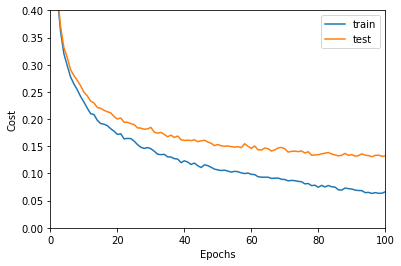

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(nepochs+1), epoch_cost_train, label="train")
plt.plot(range(nepochs+1), epoch_cost_test, label="test")
plt.ylabel('Cost')
plt.xlabel('Epochs')
xmax = nepochs
plt.axis([0,xmax,0.0,0.4])
plt.legend()
plt.show()

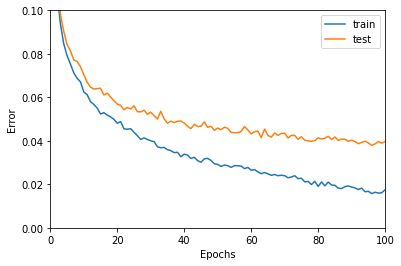

0.015733333333333332
0.0379


In [21]:
plt.plot(range(nepochs+1), epoch_error_train, label="train")
plt.plot(range(nepochs+1), epoch_error_test, label="test")
plt.ylabel('Error')
plt.xlabel('Epochs')
xmax = nepochs
plt.axis([0,xmax,0.0,0.1])
plt.legend()
plt.show()
print(np.min(epoch_error_train))
print(np.min(epoch_error_test))